In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load labels

sp_ratings = pd.read_excel('./dataset/labels.xlsx', sheet_name='sp-ratings')
label2rating = {
    0: 'AAA',
    1: 'AA+',
    2: 'AA',
    3: 'AA-',
    4: 'A+',
    5: 'A',
    6: 'A-',
    7: 'BBB+',
    8: 'BBB',
    9: 'BBB-',
    10: 'BB+',
    11: 'BB',
    12: 'BB-',
    13: 'B+',
    14: 'B',
    15: 'B-',
    16: 'CCC+',
    17: 'CCC',
    18: 'CCC-',
    19: 'CC',
    20: 'C',
    21: 'D',
}
rating2label = dict((v,k) for k,v in label2rating.items())
rating2label['SD'] = 21

print(sp_ratings.head())

   Unnamed: 0 2016Q4 2016Q3 2016Q2 2016Q1 2015Q4 2015Q3 2015Q2 2015Q1 2014Q4  \
0        1045    BB-    BB-    BB-    BB-    BB-    BB-    BB-     B+     B+   
1        1075     A-     A-     A-     A-     A-     A-     A-     A-     A-   
2        1078     A+     A+     A+     A+     A+     A+     A+     A+     A+   
3        1166    BB+    BB+    BB+    BB+    BB+    BB+    BB+    BB+    BB+   
4        1177     A-     A-     A-      A      A      A      A      A      A   

   ... 2014Q1 2013Q4 2013Q3 2013Q2 2013Q1 2012Q4 2012Q3 2012Q2 2012Q1 2011Q4  
0  ...      B      B      D      D      D      D      D      D      D      D  
1  ...     A-     A-   BBB+   BBB+   BBB+   BBB+    BBB    BBB    BBB    BBB  
2  ...     A+     A+     A+     A+     A+     A+     AA     AA     AA     AA  
3  ...     BB     BB     BB     BB    BB-    BB-    BB-    BB-    BB-    BB-  
4  ...     A-     A-     A-     A-     A-     A-     A-     A-     A-     A-  

[5 rows x 22 columns]


In [3]:
# Select appropriate quarters

q4_ratings = sp_ratings[['2014Q4', '2015Q4', '2016Q4']]
q4_labels = q4_ratings.replace(rating2label)
q4_labels[~q4_labels['2015Q4'].isin(label2rating.keys())]

print(q4_labels.head())

   2014Q4  2015Q4  2016Q4
0      13      12      12
1       6       6       6
2       4       4       4
3      10      10      10
4       5       5       6


In [4]:
# Load features

df_14q4 = pd.read_csv('./dataset/2014Q4.csv').fillna(0)
df_15q4 = pd.read_csv('./dataset/2015Q4.csv').fillna(0)
df_16q4 = pd.read_csv('./dataset/2016Q4.csv').fillna(0)

print(df_14q4.head())

   Assets - Total      Cash  Debt in Current Liabilities - Total  \
0       43771.000   994.000                              1708.00   
1       14313.532     7.604                               530.97   
2       41275.000  4063.000                              4437.00   
3        2210.772   466.829                                 0.00   
4       53402.100  1420.400                               729.30   

   Long-Term Debt - Total  Earnings Before Interest  Gross Profit (Loss)  \
0               16196.000                  6585.000            13139.000   
1                3031.215                  1228.600             1228.600   
2                3408.000                  4475.000            12088.000   
3                   0.000                   134.767              308.828   
4                7852.000                  4848.700            15091.500   

   Liabilities - Total  Retained Earnings  Total debt/total asset  \
0            41750.000         -13121.000                0.370017

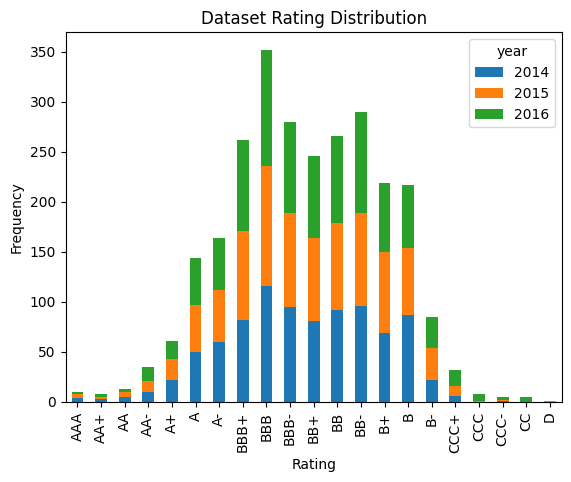

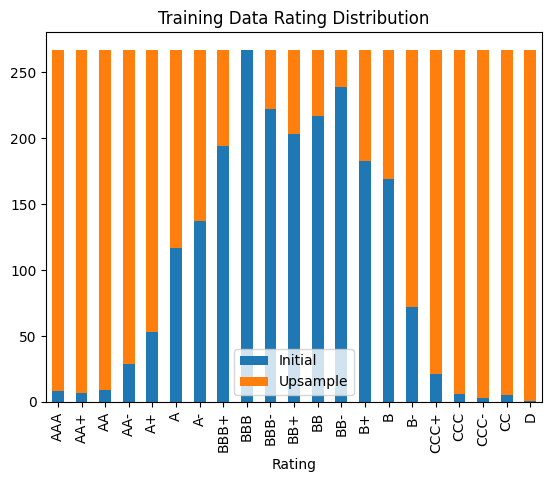

In [5]:
# MLP train/test split
from sklearn.utils import resample
from resample import random_oversample, smote_oversample, visualise_samples

def upsample(df, seed=1, factor=1000):
  grouped = df.groupby('label')
  mx_cnt = max(grouped.size())
  upsampled = []
  for label in grouped.groups.keys():
    upsampled.append(resample(
      df.loc[grouped.groups[label]],
      replace=True,
      n_samples=min(mx_cnt, len(grouped.groups[label]) * factor),
      random_state=seed
    ))
  return pd.concat(upsampled)

def merge(x, y):
  return pd.concat([x, y], axis=1)

def unmerge(df):
  x = torch.from_numpy(df.drop(columns=['label']).values)
  y = torch.from_numpy(df['label'].values)
  return x, y


# Split parameters
seed = 1
frac = 0.8

df_14q4['year'] = '2014'
df_15q4['year'] = '2015'
df_16q4['year'] = '2016'
# xs = pd.concat([df_14q4, df_15q4, df_16q4], ignore_index=True).astype('float32')
xs = pd.concat([df_14q4, df_15q4, df_16q4], ignore_index=True)
ys = q4_labels.melt(value_name='label').drop('variable', axis=1)
df = pd.concat([xs, ys], axis=1)

# Plot distribution of dataset
dfp = df[['label', 'year']].pivot_table(index=['label'], columns=['year'], aggfunc=len)
ax = dfp.plot(kind='bar', stacked=True, ylabel='Frequency', xlabel='Rating')
# ax = df.groupby('label').size().plot(kind='bar', xlabel='Rating')
ax.set_xticklabels([label2rating[key] for key in df.groupby('label').groups.keys()])
plt.title('Dataset Rating Distribution')
plt.show()
# visualise_samples(df, 'tsne', seed)
df = df.drop(columns=['year', 'Total debt/total asset', 'Earnings Per Share from Operations', 'total asset/total libiilities', 'gross profit/rev', 'EBTI/total asset', 'Book Value Per Share']).astype('float32')

# Split for n-fold cross-validation
df_shuffle = df.sample(frac=0.8, random_state=seed)
chunks = np.array_split(df_shuffle, round(1 / (1 - frac)))
folds = []
for i in range(len(chunks)):
  train = []
  for j in range(len(chunks)):
    if i != j:
      train.append(chunks[j])
  train = pd.concat(train)
  train = random_oversample(train, seed=seed)
  x_train, y_train = unmerge(train)
  x_test, y_test = unmerge(chunks[i])
  folds.append((x_train, y_train, x_test, y_test))

train = df.sample(frac=frac, random_state=seed)
test = df.drop(train.index)

x_test, y_test = unmerge(test)

train_dist = train.groupby('label').size()

# Upsample training data
train = random_oversample(train, seed=seed)
# train = smote_oversample(train, seed=seed)

# Plot distribution of train data
upsampled_dist = train.groupby('label').size() - train_dist

ax = pd.concat([train_dist, upsampled_dist], keys=['Initial', 'Upsample'], axis=1).plot(kind='bar', stacked=True, xlabel='Rating')
ax.set_xticklabels([label2rating[key] for key in train.groupby('label').groups.keys()])
plt.title('Training Data Rating Distribution')
plt.show()
# visualise_samples(train, 'tsne', seed=seed)

x_train, y_train = unmerge(train)

In [6]:
# Define visualise confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(preds, y, title='Confusion Matrix'):
  labels = list(rating2label.keys())[:-1]
  # Plotting the confusion matrix
  cm = confusion_matrix(y, preds, normalize='all', labels=list(range(22)))
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  # sns.heatmap(cm, annot=True, ax = ax)
  sns.heatmap(cm, annot=False, ax = ax, cmap=sns.light_palette([240, 75, 50], input='husl', as_cmap=True))

  # labels, title and ticks
  ax.set_xlabel('Predicted ratings')
  ax.set_ylabel('True ratings')
  ax.set_title(title)
  ax.xaxis.set_ticklabels(labels, rotation=70)
  ax.yaxis.set_ticklabels(labels, rotation=0)
  plt.show()

In [7]:
# Define ordinal criterion
from net_archs import MLP, LSTMModel

def ordinal_criterion(predictions, targets):
  # Ordinal regression with encoding as in https://arxiv.org/pdf/0704.1028.pdf

  # Create out modified target with [batch_size, num_labels] shape
  modified_target = torch.zeros_like(predictions)

  # Fill in ordinal target function, i.e. 0 -> [1,0,0,...]
  for i, target in enumerate(targets):
    modified_target[i, 0:int(target)+1] = 1

  return nn.MSELoss(reduction='none')(predictions, modified_target).sum(axis=1)


In [8]:
# Define train and test function
from sklearn.metrics import mean_squared_error, classification_report, roc_auc_score, f1_score

def train(net, optimizer, x, y, num_epoch=256, batch_size=16, criterion=ordinal_criterion):
  print_every = -1

  for n in range(num_epoch):
    # Mini batch sgd
    permutation = torch.randperm(x.size()[0])
    for i in range(0, x.size()[0], batch_size):
      indices = permutation[i:i+batch_size]
      x_mini, y_mini = x[indices], y[indices]
      y_pred = net(x_mini)
      loss = criterion(y_pred.float(), y_mini.float())
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()
      if print_every != -1 and (i / batch_size) % print_every == 0:
        print(f'Epoch: {n + 1}, Iteration: {round(i / batch_size)}, Loss: {loss.sum()}')
    if print_every == -1:
      print(f'Epoch: {n + 1}, Loss: {loss.sum()}')

def prediction2label(pred: np.ndarray):
  """Convert ordinal predictions to class labels, e.g.
  
  [0.9, 0.1, 0.1, 0.1] -> 0
  [0.9, 0.9, 0.1, 0.1] -> 1
  [0.9, 0.9, 0.9, 0.1] -> 2
  etc.
  """
  return (pred > 0.5).cumprod(axis=1).sum(axis=1) - 1

def test(net, x_test, y_test):
  y_pred = net(x_test)
  if y_pred.shape[1] == 21:
    y_pred = prediction2label(net(x_test))
  else:
    y_pred = torch.clip(y_pred.round(), min=0, max=21)

  y_default_test = np.where(y_test.detach().numpy() > 9, 1, 0)
  y_default_pred = np.where(y_pred.detach().numpy() > 9, 1, 0)
  mse = mean_squared_error(y_test.detach().numpy(), y_pred.detach().numpy())
  mse_norm = mean_squared_error(y_test.detach().numpy() / 21, y_pred.detach().numpy() / 21)
  auc = roc_auc_score(y_default_test, y_default_pred)
  f1 = f1_score(y_default_test, y_default_pred)
  return mse, mse_norm, auc, f1


### MLP

In [183]:
# 5 fold cross validation
mses = []
mse_norms = []
aucs = []
f1s = []
for x_train, y_train, x_test, y_test in folds:
  model = MLP(22, 21)
  # optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)
  train(model, optimizer, x_train, y_train)
  mse, mse_norm, auc, f1 = test(model, x_test, y_test)
  mses.append(mse)
  mse_norms.append(mse_norm)
  aucs.append(auc)
  f1s.append(f1)

Epoch: 1, Loss: 37.17204284667969
Epoch: 2, Loss: 22.187955856323242
Epoch: 3, Loss: 9.021405220031738
Epoch: 4, Loss: 11.823629379272461
Epoch: 5, Loss: 18.920406341552734
Epoch: 6, Loss: 12.300193786621094
Epoch: 7, Loss: 28.750837326049805
Epoch: 8, Loss: 15.536088943481445
Epoch: 9, Loss: 25.433961868286133
Epoch: 10, Loss: 21.896337509155273
Epoch: 11, Loss: 17.30581283569336
Epoch: 12, Loss: 15.405128479003906
Epoch: 13, Loss: 10.803603172302246
Epoch: 14, Loss: 18.87376594543457
Epoch: 15, Loss: 16.155582427978516
Epoch: 16, Loss: 17.54136085510254
Epoch: 17, Loss: 22.702394485473633
Epoch: 18, Loss: 9.130571365356445
Epoch: 19, Loss: 13.098548889160156
Epoch: 20, Loss: 17.75011444091797
Epoch: 21, Loss: 8.719476699829102
Epoch: 22, Loss: 9.637496948242188
Epoch: 23, Loss: 11.797834396362305
Epoch: 24, Loss: 13.178807258605957
Epoch: 25, Loss: 5.334987640380859
Epoch: 26, Loss: 9.092414855957031
Epoch: 27, Loss: 10.750557899475098
Epoch: 28, Loss: 11.251899719238281
Epoch: 29, L

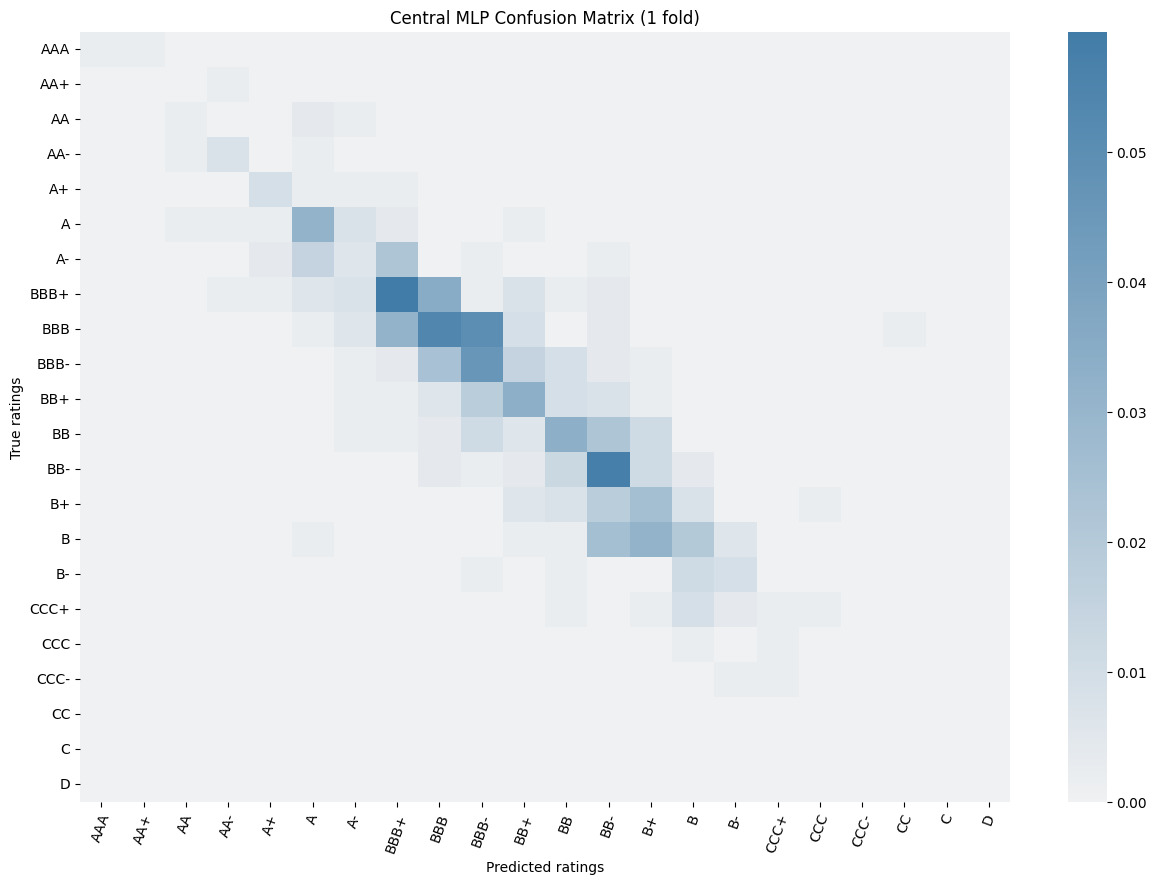

In [203]:
# Visualise confusion matrix for one fold
_, _, x_test, y_test = folds[-1]
y_pred = prediction2label(model(x_test))
confusion(y_pred, y_test, 'Central MLP Confusion Matrix (1 fold)')

In [204]:
# Print 5 fold cross validation statistics
import statistics

print(statistics.mean(mses))
print(statistics.stdev(mses))
print(statistics.mean(mse_norms))
print(statistics.stdev(mse_norms))
print(statistics.mean(aucs))
print(statistics.stdev(aucs))
print(statistics.mean(f1s))
print(statistics.stdev(f1s))

2.423876908331622
0.25192986519310184
0.0054963197362802455
0.0005712695274423638
0.8882435441161994
0.012544554436001928
0.8910528056943349
0.011446087779038565


In [9]:
# Define loss convergence graph visualistion for FL
def plot_loss(losses, start=0, title='Diagram'):
  assert len(losses) >= 6
  a, b, c, d, e, f, *_ = losses
  plt.plot(list(range(start+1, len(a)+1)), [x[1] for x in a[start:]], label='50-50')
  plt.plot(list(range(start+1, len(b)+1)), [x[1] for x in b[start:]], label='90-10')
  plt.plot(list(range(start+1, len(c)+1)), [x[1] for x in c[start:]], label='40-30-30')
  plt.plot(list(range(start+1, len(d)+1)), [x[1] for x in d[start:]], label='80-10-10')
  plt.plot(list(range(start+1, len(e)+1)), [x[1] for x in e[start:]], label='20-20-20-20-20')
  plt.plot(list(range(start+1, len(f)+1)), [x[1] for x in f[start:]], label='60-10-10-10-10')
  plt.xticks(range(start, len(a)+1, 5))
  plt.legend()
  plt.xlabel('Aggregation Round')
  plt.ylabel('MSE Loss')
  plt.title(title)
  plt.show() 

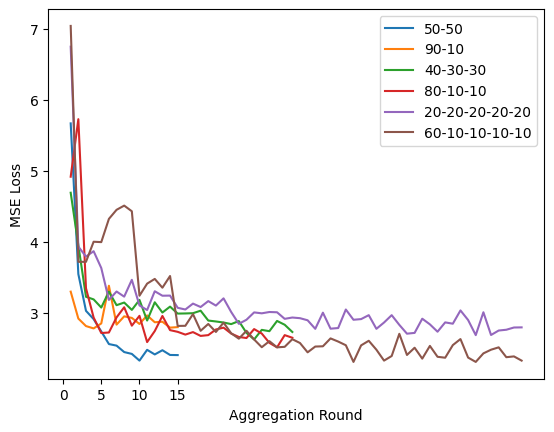

In [18]:
# Plot central MLP convergence
plot_loss([[(1, 5.66913123844732), (2, 3.5489833641404807), (3, 3.0314232902033273), (4, 2.9149722735674675), (5, 2.741219963031423), (6, 2.563770794824399), (7, 2.5415896487985212), (8, 2.4510166358595193), (9, 2.425138632162662), (10, 2.33086876155268), (11, 2.4824399260628467), (12, 2.4177449168207024), (13, 2.476894639556377), (14, 2.410351201478743), (15, 2.4085027726432533)]
, [(1, 3.301293900184843), (2, 2.922365988909427), (3, 2.8170055452865066), (4, 2.7837338262476896), (5, 2.8539741219963033), (6, 3.3844731977818854), (7, 2.837338262476895), (8, 2.9537892791127542), (9, 2.931608133086876), (10, 2.846580406654344), (11, 2.966728280961183), (12, 2.870609981515712), (13, 2.8780036968576708), (14, 2.7948243992606283), (15, 2.8022181146025877)]
, [(1, 4.693160813308688), (2, 3.955637707948244), (3, 3.229205175600739), (4, 3.192236598890943), (5, 3.077634011090573), (6, 3.301293900184843), (7, 3.11090573012939), (8, 3.147874306839187), (9, 3.044362292051756), (10, 3.1848428835489835), (11, 2.8946395563770797), (12, 3.1515711645101665), (13, 3.0073937153419594), (14, 3.090573012939002), (15, 2.9926062846580406), (16, 2.9944547134935307), (17, 2.9981515711645104), (18, 3.033271719038817), (19, 2.8946395563770797), (20, 2.8817005545286505), (21, 2.866913123844732), (22, 2.844731977818854), (23, 2.8872458410351203), (24, 2.720887245841035), (25, 2.6284658040665434), (26, 2.7634011090573014), (27, 2.744916820702403), (28, 2.88909426987061), (29, 2.8354898336414047), (30, 2.733826247689464)]
, [(1, 4.918669131238447), (2, 5.728280961182994), (3, 3.3493530499075788), (4, 2.9371534195933457), (5, 2.7190388170055453), (6, 2.7264325323475047), (7, 2.9390018484288354), (8, 3.081330868761553), (9, 2.822550831792976), (10, 2.9611829944547137), (11, 2.5914972273567467), (12, 2.746765249537893), (13, 2.9593345656192236), (14, 2.7597042513863217), (15, 2.7356746765249538), (16, 2.6968576709796674), (17, 2.731977818853974), (18, 2.678373382624769), (19, 2.689463955637708), (20, 2.7689463955637708), (21, 2.7948243992606283), (22, 2.711645101663586), (23, 2.6635859519408505), (24, 2.6487985212569316), (25, 2.77449168207024), (26, 2.711645101663586), (27, 2.5804066543438076), (28, 2.5175600739371533), (29, 2.689463955637708), (30, 2.6524953789279113)]
, [(1, 6.748613678373383), (2, 3.9353049907578557), (3, 3.7948243992606283), (4, 3.870609981515712), (5, 3.6340110905730127), (6, 3.1848428835489835), (7, 3.3031423290203326), (8, 3.2310536044362292), (9, 3.467652495378928), (10, 3.1072088724584104), (11, 3.042513863216266), (12, 3.3068391866913123), (13, 3.243992606284658), (14, 3.2458410351201477), (15, 3.0739371534195934), (16, 3.0499075785582255), (17, 3.133086876155268), (18, 3.0850277264325325), (19, 3.168207024029575), (20, 3.1053604436229203), (21, 3.2070240295748613), (22, 3.014787430683919), (23, 2.8484288354898335), (24, 2.9057301293900184), (25, 3.009242144177449), (26, 2.9963031423290203), (27, 3.014787430683919), (28, 3.011090573012939), (29, 2.918669131238447), (30, 2.9371534195933457), (31, 2.9279112754158967), (32, 2.898336414048059), (33, 2.77818853974122), (34, 3.0055452865064693), (35, 2.78003696857671), (36, 2.789279112754159), (37, 3.0499075785582255), (38, 2.9057301293900184), (39, 2.9149722735674675), (40, 2.9704251386321627), (41, 2.77818853974122), (42, 2.866913123844732), (43, 2.9704251386321627), (44, 2.833641404805915), (45, 2.709796672828096), (46, 2.720887245841035), (47, 2.9205175600739373), (48, 2.8410351201478745), (49, 2.7375231053604434), (50, 2.8687615526802217), (51, 2.8502772643253236), (52, 3.0369685767097967), (53, 2.9020332717190387), (54, 2.689463955637708), (55, 3.011090573012939), (56, 2.6913123844731976), (57, 2.7541589648798523), (58, 2.765249537892791), (59, 2.7966728280961184), (60, 2.798521256931608)]
, [(1, 7.040665434380776), (2, 3.720887245841035), (3, 3.720887245841035), (4, 4.003696857670979), (5, 3.9981515711645104), (6, 4.32532347504621), (7, 4.452865064695009), (8, 4.512014787430684), (9, 4.432532347504621), (10, 3.243992606284658), (11, 3.4140480591497226), (12, 3.4805914972273566), (13, 3.3567467652495377), (14, 3.521256931608133), (15, 2.8188539741219962), (16, 2.8207024029574863), (17, 2.985212569316081), (18, 2.7504621072088726), (19, 2.846580406654344), (20, 2.733826247689464), (21, 2.865064695009242), (22, 2.7153419593345656), (23, 2.6395563770794825), (24, 2.7504621072088726), (25, 2.6284658040665434), (26, 2.5194085027726434), (27, 2.6044362292051755), (28, 2.5175600739371533), (29, 2.5249537892791127), (30, 2.632162661737523), (31, 2.578558225508318), (32, 2.4473197781885396), (33, 2.5286506469500925), (34, 2.532347504621072), (35, 2.6432532347504623), (36, 2.598890942698706), (37, 2.5471349353049906), (38, 2.312384473197782), (39, 2.545286506469501), (40, 2.6099815157116453), (41, 2.4842883548983363), (42, 2.33086876155268), (43, 2.3955637707948245), (44, 2.707948243992606), (45, 2.410351201478743), (46, 2.512014787430684), (47, 2.358595194085028), (48, 2.5378927911275415), (49, 2.3844731977818854), (50, 2.3715341959334566), (51, 2.5489833641404807), (52, 2.6340110905730127), (53, 2.3733826247689462), (54, 2.312384473197782), (55, 2.432532347504621), (56, 2.4842883548983363), (57, 2.5175600739371533), (58, 2.378927911275416), (59, 2.3900184842883547), (60, 2.33086876155268)]]
, start=0, title='')

In [10]:
# Define MLP FL simulation wrapper
from fl_simu import mlp_simulation

def run_simulation(split, dir='default', num_epoch=256, batch_size=16, num_rounds=15):
    return mlp_simulation(split, x_train, y_train, x_test, y_test, dir, num_epoch, batch_size, num_rounds)


In [11]:
# 50-50
model_fl = run_simulation([0.5, 0.5], 'split_50_50', batch_size=64, num_epoch=8, num_rounds=60)
mse, mse_norm, auc, f1 = test(model_fl, x_test, y_test)
print(mse)
print(auc)

INFO flwr 2023-06-23 07:20:21,040 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=60, round_timeout=None)


2023-06-23 07:20:23,015	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
INFO flwr 2023-06-23 07:20:23,872 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 7364902912.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0}
INFO flwr 2023-06-23 07:20:23,872 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-23 07:20:23,872 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-23 07:20:24,721 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-23 07:20:24,722 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-23 07:20:24,722 | server.py:101 | FL starting
DEBUG flwr 2023-06-23 07:20:24,722 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:26,570 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-23 07:20:26,580 | fedavg.py:243 | No

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:27,089 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:27,103 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:27,128 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:27,129 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:27,610 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:27,625 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:27,640 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:27,641 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:28,103 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:28,116 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:28,129 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:28,130 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:28,588 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:28,599 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:28,611 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:28,612 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:29,057 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:29,069 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:29,081 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:29,082 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:29,537 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:29,550 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:29,563 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:29,564 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:30,054 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:30,065 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:30,078 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:30,079 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:30,568 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:30,578 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:30,590 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:30,591 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:31,091 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:31,110 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:31,129 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:31,130 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:31,614 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:31,626 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:31,639 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:31,640 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:32,088 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:32,101 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:32,115 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:32,115 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:32,559 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:32,569 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:32,581 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:32,582 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:33,035 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:33,046 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:33,058 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:33,059 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:33,519 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:33,529 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:33,541 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:33,541 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:33,994 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:34,007 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:34,020 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:34,020 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:34,463 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:34,473 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:34,485 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:34,485 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:34,932 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:34,944 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:34,956 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:34,957 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:35,403 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:35,413 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:35,426 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:35,426 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:35,872 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:35,882 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:35,894 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:35,895 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:36,342 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:36,351 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:36,363 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:36,364 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 2)


Saving round 21 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:36,811 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:36,818 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:36,830 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:36,830 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 2)


Saving round 22 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:37,277 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:37,285 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:37,298 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:37,298 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 2)


Saving round 23 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:37,741 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:37,748 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:37,760 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:37,761 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 2)


Saving round 24 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:38,205 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:38,213 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:38,225 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:38,226 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 2)


Saving round 25 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:38,668 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:38,675 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:38,687 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:38,688 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 2)


Saving round 26 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:39,130 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:39,137 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:39,149 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:39,149 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 2)


Saving round 27 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:39,625 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:39,633 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:39,645 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:39,645 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 2)


Saving round 28 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:40,092 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:40,099 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:40,111 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:40,112 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 2)


Saving round 29 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:40,562 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:40,569 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:40,582 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:40,582 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 2)


Saving round 30 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:41,032 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:41,039 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:41,051 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:41,052 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 2)


Saving round 31 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:41,499 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:41,507 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:41,519 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:41,519 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 2)


Saving round 32 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:41,962 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:41,969 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:41,981 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:41,982 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 2)


Saving round 33 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:42,424 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:42,431 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:42,443 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:42,444 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 2)


Saving round 34 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:42,892 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:42,899 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:42,911 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:42,912 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 2)


Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:43,353 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:43,361 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:43,373 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:43,374 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 2)


Saving round 36 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:43,816 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:43,823 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:43,835 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:43,836 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 2)


Saving round 37 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:44,282 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:44,290 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:44,301 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:44,302 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 2)


Saving round 38 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:44,752 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:44,760 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:44,772 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:44,773 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 2)


Saving round 39 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:45,217 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:45,225 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:45,237 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:45,238 | server.py:218 | fit_round 41: strategy sampled 2 clients (out of 2)


Saving round 40 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:45,680 | server.py:232 | fit_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:45,687 | server.py:168 | evaluate_round 41: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:45,699 | server.py:182 | evaluate_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:45,700 | server.py:218 | fit_round 42: strategy sampled 2 clients (out of 2)


Saving round 41 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:46,145 | server.py:232 | fit_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:46,152 | server.py:168 | evaluate_round 42: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:46,164 | server.py:182 | evaluate_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:46,165 | server.py:218 | fit_round 43: strategy sampled 2 clients (out of 2)


Saving round 42 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:46,611 | server.py:232 | fit_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:46,619 | server.py:168 | evaluate_round 43: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:46,630 | server.py:182 | evaluate_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:46,631 | server.py:218 | fit_round 44: strategy sampled 2 clients (out of 2)


Saving round 43 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:47,072 | server.py:232 | fit_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:47,079 | server.py:168 | evaluate_round 44: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:47,092 | server.py:182 | evaluate_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:47,092 | server.py:218 | fit_round 45: strategy sampled 2 clients (out of 2)


Saving round 44 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:47,537 | server.py:232 | fit_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:47,545 | server.py:168 | evaluate_round 45: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:47,557 | server.py:182 | evaluate_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:47,557 | server.py:218 | fit_round 46: strategy sampled 2 clients (out of 2)


Saving round 45 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:48,004 | server.py:232 | fit_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:48,012 | server.py:168 | evaluate_round 46: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:48,025 | server.py:182 | evaluate_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:48,025 | server.py:218 | fit_round 47: strategy sampled 2 clients (out of 2)


Saving round 46 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:48,469 | server.py:232 | fit_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:48,477 | server.py:168 | evaluate_round 47: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:48,489 | server.py:182 | evaluate_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:48,489 | server.py:218 | fit_round 48: strategy sampled 2 clients (out of 2)


Saving round 47 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:48,932 | server.py:232 | fit_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:48,939 | server.py:168 | evaluate_round 48: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:48,951 | server.py:182 | evaluate_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:48,951 | server.py:218 | fit_round 49: strategy sampled 2 clients (out of 2)


Saving round 48 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:49,440 | server.py:232 | fit_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:49,448 | server.py:168 | evaluate_round 49: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:49,460 | server.py:182 | evaluate_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:49,460 | server.py:218 | fit_round 50: strategy sampled 2 clients (out of 2)


Saving round 49 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:49,904 | server.py:232 | fit_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:49,911 | server.py:168 | evaluate_round 50: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:49,923 | server.py:182 | evaluate_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:49,923 | server.py:218 | fit_round 51: strategy sampled 2 clients (out of 2)


Saving round 50 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:50,363 | server.py:232 | fit_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:50,371 | server.py:168 | evaluate_round 51: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:50,382 | server.py:182 | evaluate_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:50,383 | server.py:218 | fit_round 52: strategy sampled 2 clients (out of 2)


Saving round 51 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:50,827 | server.py:232 | fit_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:50,834 | server.py:168 | evaluate_round 52: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:50,847 | server.py:182 | evaluate_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:50,847 | server.py:218 | fit_round 53: strategy sampled 2 clients (out of 2)


Saving round 52 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:51,304 | server.py:232 | fit_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:51,311 | server.py:168 | evaluate_round 53: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:51,323 | server.py:182 | evaluate_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:51,324 | server.py:218 | fit_round 54: strategy sampled 2 clients (out of 2)


Saving round 53 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:51,766 | server.py:232 | fit_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:51,773 | server.py:168 | evaluate_round 54: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:51,785 | server.py:182 | evaluate_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:51,786 | server.py:218 | fit_round 55: strategy sampled 2 clients (out of 2)


Saving round 54 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:52,235 | server.py:232 | fit_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:52,242 | server.py:168 | evaluate_round 55: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:52,254 | server.py:182 | evaluate_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:52,255 | server.py:218 | fit_round 56: strategy sampled 2 clients (out of 2)


Saving round 55 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:52,700 | server.py:232 | fit_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:52,708 | server.py:168 | evaluate_round 56: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:52,719 | server.py:182 | evaluate_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:52,720 | server.py:218 | fit_round 57: strategy sampled 2 clients (out of 2)


Saving round 56 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:53,168 | server.py:232 | fit_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:53,175 | server.py:168 | evaluate_round 57: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:53,187 | server.py:182 | evaluate_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:53,188 | server.py:218 | fit_round 58: strategy sampled 2 clients (out of 2)


Saving round 57 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:53,632 | server.py:232 | fit_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:53,639 | server.py:168 | evaluate_round 58: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:53,651 | server.py:182 | evaluate_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:53,651 | server.py:218 | fit_round 59: strategy sampled 2 clients (out of 2)


Saving round 58 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:54,096 | server.py:232 | fit_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:54,105 | server.py:168 | evaluate_round 59: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:54,117 | server.py:182 | evaluate_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:54,118 | server.py:218 | fit_round 60: strategy sampled 2 clients (out of 2)


Saving round 59 aggregated_parameters...


DEBUG flwr 2023-06-23 07:20:54,555 | server.py:232 | fit_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-23 07:20:54,563 | server.py:168 | evaluate_round 60: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 07:20:54,576 | server.py:182 | evaluate_round 60 received 2 results and 0 failures
INFO flwr 2023-06-23 07:20:54,576 | server.py:147 | FL finished in 29.85349408397451
INFO flwr 2023-06-23 07:20:54,577 | app.py:218 | app_fit: losses_distributed [(1, 8.5452865064695), (2, 6.785582255083179), (3, 5.648798521256932), (4, 5.310536044362292), (5, 4.66913123844732), (6, 4.87985212569316), (7, 4.2772643253234754), (8, 4.593345656192237), (9, 4.12014787430684), (10, 4.040665434380776), (11, 3.9630314232902033), (12, 3.8022181146025877), (13, 3.822550831792976), (14, 3.767097966728281), (15, 3.698706099815157), (16, 3.6598890942698707), (17, 3.6580406654343807), (18, 3.574861367837338), (19, 3.5804066543438076), (20, 3.530499075785582), (21, 3.5175600739371533), (22,

Saving round 60 aggregated_parameters...
2.8632162661737524
0.8655765802824626


In [19]:
# 90-10
model_fl = run_simulation([0.9, 0.1], 'split_90_10', batch_size=64, num_epoch=8, num_rounds=60)
mse, mse_norm, auc, f1 = test(model_fl, x_test, y_test)
print(mse)
print(auc)

INFO flwr 2023-06-19 03:06:19,034 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=60, round_timeout=None)


(launch_and_fit pid=87356) Epoch: 8, Loss: 60.01282501220703 [repeated 95x across cluster]
(launch_and_evaluate pid=87356) Client 1 evaluate, config {} [repeated 8x across cluster]


2023-06-19 03:06:23,365	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-19 03:06:23,968 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 8070435636.0}
INFO flwr 2023-06-19 03:06:23,969 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-19 03:06:23,969 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-19 03:06:24,735 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-19 03:06:24,736 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-19 03:06:24,736 | server.py:101 | FL starting
DEBUG flwr 2023-06-19 03:06:24,736 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=87418) Epoch: 1, Loss: 233.59877014160156
(launch_and_fit pid=87418) Epoch: 2, Loss: 194.55702209472656
(launch_and_fit pid=87418) Epoch: 3, Loss: 180.1023406982422
(launch_and_fit pid=87418) Epoch: 4, Loss: 120.90283203125
(launch_and_fit pid=87418) Epoch: 5, Loss: 101.06285095214844


DEBUG flwr 2023-06-19 03:06:25,545 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-19 03:06:25,550 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 03:06:25,554 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:25,567 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-19 03:06:25,567 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 03:06:25,567 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=87418) Epoch: 6, Loss: 91.68934631347656
(launch_and_fit pid=87418) Epoch: 7, Loss: 76.04707336425781
Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=87418) Client 1 evaluate, config {}


DEBUG flwr 2023-06-19 03:06:26,308 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:26,316 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:26,327 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:26,327 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:27,223 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:27,232 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:27,242 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:27,242 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:28,140 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:28,147 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:28,156 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:28,156 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:28,892 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:28,900 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:28,909 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:28,910 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:29,804 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:29,811 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:29,820 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:29,820 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...
(launch_and_fit pid=87418) Epoch: 8, Loss: 115.66317749023438 [repeated 97x across cluster]


DEBUG flwr 2023-06-19 03:06:30,717 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:30,727 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:30,737 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:30,737 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=87414) Client 0 evaluate, config {} [repeated 11x across cluster]
Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:31,638 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:31,646 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:31,655 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:31,656 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:32,396 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:32,403 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:32,412 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:32,412 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:33,150 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:33,159 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:33,168 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:33,168 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...


(raylet) [2023-06-19 03:06:33,343 E 87408 15069379] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-06-21_685393_62886 is over 95% full, available space: 22282752000; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-19 03:06:33,910 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:33,919 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:33,928 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:33,929 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:34,659 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:34,667 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:34,676 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:34,676 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...
(launch_and_fit pid=87414) Epoch: 3, Loss: 38.78784942626953 [repeated 99x across cluster]


DEBUG flwr 2023-06-19 03:06:35,566 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:35,574 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:35,583 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:35,584 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=87418) Client 1 evaluate, config {} [repeated 13x across cluster]


DEBUG flwr 2023-06-19 03:06:36,485 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:36,494 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:36,503 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:36,503 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:37,240 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:37,249 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:37,258 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:37,258 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:38,154 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:38,161 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:38,171 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:38,171 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:39,058 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:39,065 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:39,074 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:39,074 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:39,963 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:39,970 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:39,979 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:39,980 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...
(launch_and_fit pid=87414) Epoch: 7, Loss: 36.59438705444336 [repeated 84x across cluster]


DEBUG flwr 2023-06-19 03:06:40,712 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:40,719 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:40,728 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:40,728 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=87414) Client 0 evaluate, config {} [repeated 11x across cluster]
Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:41,462 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:41,470 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:41,479 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:41,480 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:42,367 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:42,375 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:42,384 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:42,384 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 2)


Saving round 21 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:43,111 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:43,118 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:43,127 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:43,127 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 2)


Saving round 22 aggregated_parameters...


(raylet) [2023-06-19 03:06:43,423 E 87408 15069379] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-06-21_685393_62886 is over 95% full, available space: 22291873792; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-19 03:06:44,019 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:44,027 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:44,036 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:44,036 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 2)


Saving round 23 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:44,766 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:44,774 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:44,783 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:44,783 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 2)


Saving round 24 aggregated_parameters...
(launch_and_fit pid=87414) Epoch: 2, Loss: 29.104351043701172 [repeated 107x across cluster]


DEBUG flwr 2023-06-19 03:06:45,668 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:45,675 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:45,684 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:45,685 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 2)


Saving round 25 aggregated_parameters...
(launch_and_evaluate pid=87418) Client 0 evaluate, config {} [repeated 13x across cluster]


DEBUG flwr 2023-06-19 03:06:46,565 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:46,572 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:46,581 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:46,582 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 2)


Saving round 26 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:47,467 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:47,475 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:47,484 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:47,485 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 2)


Saving round 27 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:48,214 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:48,223 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:48,231 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:48,232 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 2)


Saving round 28 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:49,117 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:49,126 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:49,135 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:49,135 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 2)


Saving round 29 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:50,038 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:50,045 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:50,053 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:50,054 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 2)


Saving round 30 aggregated_parameters...
(launch_and_fit pid=87414) Epoch: 7, Loss: 31.588909149169922 [repeated 85x across cluster]


DEBUG flwr 2023-06-19 03:06:50,789 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:50,796 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:50,805 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:50,805 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=87414) Client 0 evaluate, config {} [repeated 11x across cluster]
Saving round 31 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:51,697 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:51,705 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:51,714 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:51,714 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 2)


Saving round 32 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:52,601 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:52,609 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:52,617 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:52,618 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 2)


Saving round 33 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:53,344 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:53,351 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:53,360 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:53,361 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 2)
(raylet) [2023-06-19 03:06:53,501 E 87408 15069379] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-06-21_685393_62886 is over 95% full, available space: 22289293312; capacity: 494384795648. Object creation will fail if spilling is required.


Saving round 34 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:54,258 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:54,266 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:54,275 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:54,275 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 2)


Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:55,013 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:55,021 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:55,031 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:55,032 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 2)


Saving round 36 aggregated_parameters...
(launch_and_fit pid=87418) Epoch: 8, Loss: 32.33736801147461 [repeated 97x across cluster]
(launch_and_evaluate pid=87414) Client 0 evaluate, config {} [repeated 12x across cluster]


DEBUG flwr 2023-06-19 03:06:55,927 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:55,935 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:55,944 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:55,945 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 2)


Saving round 37 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:56,848 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:56,855 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:56,864 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:56,864 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 2)


Saving round 38 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:57,591 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:57,599 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:57,608 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:57,611 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 2)


Saving round 39 aggregated_parameters...


DEBUG flwr 2023-06-19 03:06:58,356 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:58,363 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:58,373 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:58,373 | server.py:218 | fit_round 41: strategy sampled 2 clients (out of 2)


Saving round 40 aggregated_parameters...
(launch_and_fit pid=87418) 


DEBUG flwr 2023-06-19 03:06:59,269 | server.py:232 | fit_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:59,276 | server.py:168 | evaluate_round 41: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:06:59,285 | server.py:182 | evaluate_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:06:59,285 | server.py:218 | fit_round 42: strategy sampled 2 clients (out of 2)


Saving round 41 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:00,183 | server.py:232 | fit_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:00,191 | server.py:168 | evaluate_round 42: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:00,200 | server.py:182 | evaluate_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:00,200 | server.py:218 | fit_round 43: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=87414) Epoch: 7, Loss: 36.79910659790039 [repeated 95x across cluster]
Saving round 42 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:00,933 | server.py:232 | fit_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:00,940 | server.py:168 | evaluate_round 43: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:00,949 | server.py:182 | evaluate_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:00,949 | server.py:218 | fit_round 44: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=87414) Client 1 evaluate, config {} [repeated 12x across cluster]
Saving round 43 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:01,847 | server.py:232 | fit_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:01,854 | server.py:168 | evaluate_round 44: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:01,863 | server.py:182 | evaluate_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:01,863 | server.py:218 | fit_round 45: strategy sampled 2 clients (out of 2)


Saving round 44 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:02,596 | server.py:232 | fit_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:02,603 | server.py:168 | evaluate_round 45: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:02,612 | server.py:182 | evaluate_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:02,612 | server.py:218 | fit_round 46: strategy sampled 2 clients (out of 2)


Saving round 45 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:03,501 | server.py:232 | fit_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:03,510 | server.py:168 | evaluate_round 46: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:03,518 | server.py:182 | evaluate_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:03,519 | server.py:218 | fit_round 47: strategy sampled 2 clients (out of 2)
(raylet) [2023-06-19 03:07:03,577 E 87408 15069379] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-06-21_685393_62886 is over 95% full, available space: 22285430784; capacity: 494384795648. Object creation will fail if spilling is required.


Saving round 46 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:04,253 | server.py:232 | fit_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:04,261 | server.py:168 | evaluate_round 47: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:04,270 | server.py:182 | evaluate_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:04,270 | server.py:218 | fit_round 48: strategy sampled 2 clients (out of 2)


Saving round 47 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:05,019 | server.py:232 | fit_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:05,027 | server.py:168 | evaluate_round 48: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:05,038 | server.py:182 | evaluate_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:05,039 | server.py:218 | fit_round 49: strategy sampled 2 clients (out of 2)


Saving round 48 aggregated_parameters...
(launch_and_fit pid=87418) Epoch: 1, Loss: 25.55717658996582 [repeated 98x across cluster]


DEBUG flwr 2023-06-19 03:07:05,793 | server.py:232 | fit_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:05,800 | server.py:168 | evaluate_round 49: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:05,810 | server.py:182 | evaluate_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:05,810 | server.py:218 | fit_round 50: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=87414) Client 1 evaluate, config {} [repeated 12x across cluster]
Saving round 49 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:06,705 | server.py:232 | fit_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:06,712 | server.py:168 | evaluate_round 50: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:06,721 | server.py:182 | evaluate_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:06,722 | server.py:218 | fit_round 51: strategy sampled 2 clients (out of 2)


Saving round 50 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:07,455 | server.py:232 | fit_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:07,463 | server.py:168 | evaluate_round 51: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:07,472 | server.py:182 | evaluate_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:07,472 | server.py:218 | fit_round 52: strategy sampled 2 clients (out of 2)


Saving round 51 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:08,203 | server.py:232 | fit_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:08,212 | server.py:168 | evaluate_round 52: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:08,221 | server.py:182 | evaluate_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:08,222 | server.py:218 | fit_round 53: strategy sampled 2 clients (out of 2)


Saving round 52 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:09,105 | server.py:232 | fit_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:09,112 | server.py:168 | evaluate_round 53: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:09,121 | server.py:182 | evaluate_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:09,122 | server.py:218 | fit_round 54: strategy sampled 2 clients (out of 2)


Saving round 53 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:09,867 | server.py:232 | fit_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:09,874 | server.py:168 | evaluate_round 54: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:09,883 | server.py:182 | evaluate_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:09,883 | server.py:218 | fit_round 55: strategy sampled 2 clients (out of 2)


Saving round 54 aggregated_parameters...
(launch_and_fit pid=87414) Epoch: 2, Loss: 22.05560302734375 [repeated 105x across cluster]


DEBUG flwr 2023-06-19 03:07:10,763 | server.py:232 | fit_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:10,770 | server.py:168 | evaluate_round 55: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:10,779 | server.py:182 | evaluate_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:10,780 | server.py:218 | fit_round 56: strategy sampled 2 clients (out of 2)


Saving round 55 aggregated_parameters...
(launch_and_evaluate pid=87418) Client 0 evaluate, config {} [repeated 13x across cluster]


DEBUG flwr 2023-06-19 03:07:11,669 | server.py:232 | fit_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:11,677 | server.py:168 | evaluate_round 56: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:11,686 | server.py:182 | evaluate_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:11,687 | server.py:218 | fit_round 57: strategy sampled 2 clients (out of 2)


Saving round 56 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:12,571 | server.py:232 | fit_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:12,580 | server.py:168 | evaluate_round 57: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:12,589 | server.py:182 | evaluate_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:12,590 | server.py:218 | fit_round 58: strategy sampled 2 clients (out of 2)


Saving round 57 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:13,333 | server.py:232 | fit_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:13,341 | server.py:168 | evaluate_round 58: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:13,349 | server.py:182 | evaluate_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:13,350 | server.py:218 | fit_round 59: strategy sampled 2 clients (out of 2)


Saving round 58 aggregated_parameters...


(raylet) [2023-06-19 03:07:13,655 E 87408 15069379] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-06-21_685393_62886 is over 95% full, available space: 22282924032; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-19 03:07:14,248 | server.py:232 | fit_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:14,256 | server.py:168 | evaluate_round 59: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:14,265 | server.py:182 | evaluate_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:14,265 | server.py:218 | fit_round 60: strategy sampled 2 clients (out of 2)


Saving round 59 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:15,150 | server.py:232 | fit_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:15,158 | server.py:168 | evaluate_round 60: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-19 03:07:15,167 | server.py:182 | evaluate_round 60 received 2 results and 0 failures
INFO flwr 2023-06-19 03:07:15,167 | server.py:147 | FL finished in 50.43100299988873
INFO flwr 2023-06-19 03:07:15,167 | app.py:218 | app_fit: losses_distributed [(1, 18.120147874306838), (2, 6.7744916820702406), (3, 7.3290203327171906), (4, 6.754158964879852), (5, 6.569316081330869), (6, 5.972273567467653), (7, 5.809611829944547), (8, 6.0258780036968576), (9, 4.402957486136784), (10, 4.118299445471349), (11, 4.580406654343808), (12, 4.072088724584104), (13, 3.789279112754159), (14, 3.743068391866913), (15, 4.033271719038817), (16, 3.6672828096118297), (17, 4.2181146025878), (18, 3.2957486136783736), (19, 3.1515711645101665), (20, 3.162661737523105), (21, 3.1848428835489835), 

Saving round 60 aggregated_parameters...
Loading pre-trained model from:  ./model_checkpoints/split_90_10/model_round_60.pth
2.804066543438078
0.8431783902372137


In [20]:
# 40-30-30
model_fl = run_simulation([0.4, 0.3, 0.3], 'split_40_30_30', batch_size=64, num_epoch=8, num_rounds=60)
mse, mse_norm, auc, f1 = test(model_fl, x_test, y_test)
print(mse)
print(auc)

INFO flwr 2023-06-19 03:07:15,193 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=60, round_timeout=None)


(launch_and_fit pid=87414) Epoch: 7, Loss: 21.49676513671875 [repeated 85x across cluster]
(launch_and_evaluate pid=87414) Client 1 evaluate, config {} [repeated 9x across cluster]


2023-06-19 03:07:19,380	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-19 03:07:19,961 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'memory': 8303711028.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0}
INFO flwr 2023-06-19 03:07:19,962 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-19 03:07:19,962 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-19 03:07:20,735 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-19 03:07:20,736 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-19 03:07:20,736 | server.py:101 | FL starting
DEBUG flwr 2023-06-19 03:07:20,736 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=87452) Epoch: 1, Loss: 82.20555114746094
(launch_and_fit pid=87452) Epoch: 2, Loss: 73.30162811279297
(launch_and_fit pid=87452) Epoch: 3, Loss: 64.82974243164062
(launch_and_fit pid=87452) Epoch: 4, Loss: 51.704811096191406
(launch_and_fit pid=87452) Epoch: 5, Loss: 36.74824905395508
(launch_and_fit pid=87452) Epoch: 6, Loss: 31.235492706298828
(launch_and_fit pid=87452) Epoch: 7, Loss: 16.116413116455078
(launch_and_fit pid=87452) Epoch: 8, Loss: 17.47576141357422


DEBUG flwr 2023-06-19 03:07:21,854 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-19 03:07:21,858 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 03:07:21,864 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:21,875 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-19 03:07:21,875 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 03:07:21,875 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=87452) Client 2 evaluate, config {}


DEBUG flwr 2023-06-19 03:07:22,295 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:22,304 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:22,313 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:22,313 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:22,629 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:22,636 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:22,646 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:22,646 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:22,998 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:23,006 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:23,016 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:23,017 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:23,369 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:23,379 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:23,388 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:23,388 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:23,740 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:23,748 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:23,757 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:23,757 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:24,113 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:24,120 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:24,131 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:24,132 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:24,546 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:24,555 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:24,566 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:24,566 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:24,980 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:24,989 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:24,998 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:24,999 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:25,353 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:25,363 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:25,372 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:25,372 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:26,108 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:26,117 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:26,132 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:26,132 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=87451) Epoch: 6, Loss: 80.72266387939453 [repeated 163x across cluster]
Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:26,460 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:26,469 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:26,479 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:26,480 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:26,900 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:26,909 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:26,918 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:26,919 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=87452) Client 1 evaluate, config {} [repeated 24x across cluster]


DEBUG flwr 2023-06-19 03:07:27,347 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:27,357 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:27,367 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:27,368 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:27,723 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:27,730 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:27,740 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:27,740 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:28,054 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:28,062 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:28,071 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:28,071 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:28,421 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:28,429 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:28,438 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:28,439 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:28,855 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:28,864 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:28,873 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:28,874 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:29,290 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:29,297 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:29,306 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:29,307 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)
(raylet) [2023-06-19 03:07:29,371 E 87448 15071288] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-07-17_688455_62886 is over 95% full, available space: 22276722688; capacity: 494384795648. Object creation will fail if spilling is required.


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:29,720 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:29,729 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:29,739 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:29,739 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:30,157 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:30,165 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:30,174 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:30,175 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 3)


Saving round 21 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:30,587 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:30,595 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:30,604 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:30,605 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 3)


Saving round 22 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:30,917 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:30,924 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:30,936 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:30,937 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 3)


Saving round 23 aggregated_parameters...
(launch_and_fit pid=87451) Epoch: 6, Loss: 60.603294372558594 [repeated 195x across cluster]


DEBUG flwr 2023-06-19 03:07:31,293 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:31,304 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:31,314 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:31,314 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 3)


Saving round 24 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:31,727 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:31,736 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:31,746 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:31,746 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 3)


Saving round 25 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:32,099 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:32,107 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:32,116 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:32,116 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=87451) Client 1 evaluate, config {} [repeated 25x across cluster]
Saving round 26 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:32,529 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:32,536 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:32,545 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:32,546 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 3)


Saving round 27 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:32,861 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:32,869 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:32,879 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:32,879 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 3)


Saving round 28 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:33,303 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:33,312 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:33,330 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:33,330 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 3)


Saving round 29 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:33,690 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:33,698 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:33,707 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:33,708 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 3)


Saving round 30 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:34,023 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:34,032 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:34,041 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:34,042 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 3)


Saving round 31 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:34,356 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:34,363 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:34,372 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:34,373 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 3)


Saving round 32 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:34,685 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:34,692 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:34,701 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:34,702 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 3)


Saving round 33 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:35,050 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:35,058 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:35,067 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:35,067 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 3)


Saving round 34 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:35,477 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:35,485 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:35,494 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:35,495 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 3)


Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:35,907 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:35,915 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:35,924 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:35,925 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 3)


Saving round 36 aggregated_parameters...
(launch_and_fit pid=87452) Epoch: 3, Loss: 63.90316390991211 [repeated 213x across cluster]


DEBUG flwr 2023-06-19 03:07:36,353 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:36,361 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:36,371 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:36,371 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 3)


Saving round 37 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:36,785 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:36,793 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:36,802 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:36,803 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 3)


Saving round 38 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:37,214 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:37,222 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:37,231 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:37,232 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=87451) Client 1 evaluate, config {} [repeated 26x across cluster]
Saving round 39 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:37,641 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:37,650 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:37,660 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:37,660 | server.py:218 | fit_round 41: strategy sampled 2 clients (out of 3)


Saving round 40 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:38,038 | server.py:232 | fit_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:38,046 | server.py:168 | evaluate_round 41: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:38,056 | server.py:182 | evaluate_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:38,056 | server.py:218 | fit_round 42: strategy sampled 2 clients (out of 3)


Saving round 41 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:38,499 | server.py:232 | fit_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:38,507 | server.py:168 | evaluate_round 42: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:38,517 | server.py:182 | evaluate_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:38,517 | server.py:218 | fit_round 43: strategy sampled 2 clients (out of 3)


Saving round 42 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:38,830 | server.py:232 | fit_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:38,838 | server.py:168 | evaluate_round 43: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:38,848 | server.py:182 | evaluate_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:38,848 | server.py:218 | fit_round 44: strategy sampled 2 clients (out of 3)


Saving round 43 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:39,178 | server.py:232 | fit_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:39,186 | server.py:168 | evaluate_round 44: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:39,197 | server.py:182 | evaluate_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:39,198 | server.py:218 | fit_round 45: strategy sampled 2 clients (out of 3)


Saving round 44 aggregated_parameters...


(raylet) [2023-06-19 03:07:39,458 E 87448 15071288] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-07-17_688455_62886 is over 95% full, available space: 22278238208; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-19 03:07:39,562 | server.py:232 | fit_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:39,571 | server.py:168 | evaluate_round 45: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:39,581 | server.py:182 | evaluate_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:39,581 | server.py:218 | fit_round 46: strategy sampled 2 clients (out of 3)


Saving round 45 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:39,897 | server.py:232 | fit_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:39,905 | server.py:168 | evaluate_round 46: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:39,914 | server.py:182 | evaluate_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:39,914 | server.py:218 | fit_round 47: strategy sampled 2 clients (out of 3)


Saving round 46 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:40,274 | server.py:232 | fit_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:40,282 | server.py:168 | evaluate_round 47: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:40,291 | server.py:182 | evaluate_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:40,291 | server.py:218 | fit_round 48: strategy sampled 2 clients (out of 3)


Saving round 47 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:40,603 | server.py:232 | fit_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:40,611 | server.py:168 | evaluate_round 48: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:40,620 | server.py:182 | evaluate_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:40,620 | server.py:218 | fit_round 49: strategy sampled 2 clients (out of 3)


Saving round 48 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:41,056 | server.py:232 | fit_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:41,063 | server.py:168 | evaluate_round 49: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:41,073 | server.py:182 | evaluate_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:41,073 | server.py:218 | fit_round 50: strategy sampled 2 clients (out of 3)


Saving round 49 aggregated_parameters...
(launch_and_fit pid=87451) Epoch: 6, Loss: 6.5809478759765625 [repeated 203x across cluster]


DEBUG flwr 2023-06-19 03:07:41,485 | server.py:232 | fit_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:41,492 | server.py:168 | evaluate_round 50: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:41,502 | server.py:182 | evaluate_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:41,502 | server.py:218 | fit_round 51: strategy sampled 2 clients (out of 3)


Saving round 50 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:41,918 | server.py:232 | fit_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:41,925 | server.py:168 | evaluate_round 51: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:41,934 | server.py:182 | evaluate_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:41,934 | server.py:218 | fit_round 52: strategy sampled 2 clients (out of 3)


Saving round 51 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:42,287 | server.py:232 | fit_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:42,294 | server.py:168 | evaluate_round 52: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:42,304 | server.py:182 | evaluate_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:42,304 | server.py:218 | fit_round 53: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=87451) Client 1 evaluate, config {} [repeated 26x across cluster]
Saving round 52 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:42,721 | server.py:232 | fit_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:42,729 | server.py:168 | evaluate_round 53: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:42,738 | server.py:182 | evaluate_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:42,739 | server.py:218 | fit_round 54: strategy sampled 2 clients (out of 3)


Saving round 53 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:43,051 | server.py:232 | fit_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:43,058 | server.py:168 | evaluate_round 54: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:43,067 | server.py:182 | evaluate_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:43,068 | server.py:218 | fit_round 55: strategy sampled 2 clients (out of 3)


Saving round 54 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:43,499 | server.py:232 | fit_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:43,506 | server.py:168 | evaluate_round 55: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:43,516 | server.py:182 | evaluate_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:43,517 | server.py:218 | fit_round 56: strategy sampled 2 clients (out of 3)


Saving round 55 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:43,850 | server.py:232 | fit_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:43,858 | server.py:168 | evaluate_round 56: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:43,868 | server.py:182 | evaluate_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:43,868 | server.py:218 | fit_round 57: strategy sampled 2 clients (out of 3)


Saving round 56 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:44,182 | server.py:232 | fit_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:44,191 | server.py:168 | evaluate_round 57: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:44,200 | server.py:182 | evaluate_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:44,200 | server.py:218 | fit_round 58: strategy sampled 2 clients (out of 3)


Saving round 57 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:44,512 | server.py:232 | fit_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:44,519 | server.py:168 | evaluate_round 58: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:44,528 | server.py:182 | evaluate_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:44,528 | server.py:218 | fit_round 59: strategy sampled 2 clients (out of 3)


Saving round 58 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:44,880 | server.py:232 | fit_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:44,889 | server.py:168 | evaluate_round 59: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:44,898 | server.py:182 | evaluate_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:44,899 | server.py:218 | fit_round 60: strategy sampled 2 clients (out of 3)


Saving round 59 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:45,214 | server.py:232 | fit_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:45,221 | server.py:168 | evaluate_round 60: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:45,230 | server.py:182 | evaluate_round 60 received 2 results and 0 failures
INFO flwr 2023-06-19 03:07:45,231 | server.py:147 | FL finished in 24.494607458123937
INFO flwr 2023-06-19 03:07:45,231 | app.py:218 | app_fit: losses_distributed [(1, 15.791127541589649), (2, 16.58410351201479), (3, 15.800369685767098), (4, 11.133086876155268), (5, 5.837338262476894), (6, 5.77264325323475), (7, 27.88909426987061), (8, 5.249537892791127), (9, 19.994454713493532), (10, 14.325323475046211), (11, 4.717190388170056), (12, 10.380776340110906), (13, 14.149722735674677), (14, 4.650646950092422), (15, 4.513863216266174), (16, 11.199630314232902), (17, 14.060998151571164), (18, 4.567467652495379), (19, 13.67837338262477), (20, 16.08133086876155), (21, 16.23475046210720

Saving round 60 aggregated_parameters...
Loading pre-trained model from:  ./model_checkpoints/split_40_30_30/model_round_60.pth
11.292051756007394
0.5


In [21]:
# 80-10-10
model_fl = run_simulation([0.8, 0.1, 0.1], 'split_80_10_10', batch_size=64, num_epoch=8, num_rounds=60)
mse, mse_norm, auc, f1 = test(model_fl, x_test, y_test)
print(mse)
print(auc)

INFO flwr 2023-06-19 03:07:45,259 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=60, round_timeout=None)


(launch_and_fit pid=87451) Epoch: 6, Loss: 6.759072780609131 [repeated 176x across cluster]
(launch_and_evaluate pid=87451) Client 1 evaluate, config {} [repeated 16x across cluster]


2023-06-19 03:07:49,474	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-19 03:07:50,131 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 8044041012.0}
INFO flwr 2023-06-19 03:07:50,131 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-19 03:07:50,131 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-19 03:07:50,975 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-19 03:07:50,976 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-19 03:07:50,976 | server.py:101 | FL starting
DEBUG flwr 2023-06-19 03:07:50,976 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=87487) Epoch: 1, Loss: 19.696569442749023
(launch_and_fit pid=87487) Epoch: 2, Loss: 24.840599060058594
(launch_and_fit pid=87487) Epoch: 3, Loss: 23.10047721862793
(launch_and_fit pid=87487) Epoch: 4, Loss: 23.255769729614258
(launch_and_fit pid=87487) Epoch: 5, Loss: 26.010997772216797
(launch_and_fit pid=87487) Epoch: 6, Loss: 18.213781356811523


DEBUG flwr 2023-06-19 03:07:51,822 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-19 03:07:51,827 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 03:07:51,832 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:51,847 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-19 03:07:51,848 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 03:07:51,849 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=87487) Epoch: 7, Loss: 13.261737823486328
Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=87487) Client 1 evaluate, config {}


DEBUG flwr 2023-06-19 03:07:52,535 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:52,544 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:52,585 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:52,586 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:53,263 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:53,271 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:53,281 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:53,282 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:53,393 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:53,402 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:53,411 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:53,411 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...
Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:54,206 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:54,214 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:54,224 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:54,224 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:54,913 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:54,921 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:54,932 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:54,932 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:55,047 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:55,054 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:55,063 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:55,064 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...
Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:55,178 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:55,186 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:55,196 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:55,196 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:55,308 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:55,316 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:55,325 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:55,325 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...
Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:55,437 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:55,446 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:55,455 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:55,456 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:56,123 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:56,132 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:56,141 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:56,141 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=87492) Epoch: 7, Loss: 16.83365249633789 [repeated 168x across cluster]


DEBUG flwr 2023-06-19 03:07:56,937 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:56,946 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:56,955 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:56,955 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:57,065 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:57,073 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:57,083 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:57,083 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=87492) Client 1 evaluate, config {} [repeated 21x across cluster]
Saving round 12 aggregated_parameters...
Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:57,194 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:57,204 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:57,213 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:57,213 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:58,006 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:58,015 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:58,024 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:58,025 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:58,139 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:58,147 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:58,156 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:58,156 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...
Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-19 03:07:58,960 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:58,969 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:58,978 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:58,978 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...


(raylet) [2023-06-19 03:07:59,454 E 87482 15072904] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-07-47_682840_62886 is over 95% full, available space: 22270205952; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-19 03:07:59,659 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:59,668 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:07:59,678 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:07:59,678 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:00,487 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:00,495 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:00,504 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:00,505 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:01,186 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:01,194 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:01,203 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:01,203 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:01,313 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:01,322 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:01,331 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:01,332 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...
(launch_and_fit pid=87492) Epoch: 8, Loss: 11.367754936218262 [repeated 145x across cluster]
Saving round 21 aggregated_parameters...
(launch_and_evaluate pid=87492) Client 2 evaluate, config {} [repeated 20x across cluster]


DEBUG flwr 2023-06-19 03:08:02,143 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:02,153 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:02,163 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:02,163 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:02,275 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:02,283 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:02,291 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:02,292 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 3)


Saving round 22 aggregated_parameters...
Saving round 23 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:03,083 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:03,091 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:03,099 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:03,100 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 3)


Saving round 24 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:03,793 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:03,802 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:03,812 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:03,812 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:03,924 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:03,933 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:03,941 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:03,942 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 3)


Saving round 25 aggregated_parameters...
Saving round 26 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:04,055 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:04,064 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:04,073 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:04,073 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 3)


Saving round 27 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:04,879 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:04,887 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:04,896 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:04,897 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:05,011 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:05,018 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:05,027 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:05,028 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 3)


Saving round 28 aggregated_parameters...
Saving round 29 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:05,723 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:05,732 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:05,741 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:05,742 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 3)


Saving round 30 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:06,429 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:06,436 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=87492) Epoch: 5, Loss: 8.059701919555664 [repeated 173x across cluster]
Saving round 31 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:06,445 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:06,446 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=87492) Client 0 evaluate, config {} [repeated 20x across cluster]


DEBUG flwr 2023-06-19 03:08:07,243 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:07,250 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:07,259 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:07,260 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 3)


Saving round 32 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:07,936 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:07,943 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:07,952 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:07,953 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 3)


Saving round 33 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:08,618 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:08,626 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:08,635 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:08,635 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 3)


Saving round 34 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:09,299 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:09,306 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:09,315 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:09,315 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 3)


Saving round 35 aggregated_parameters...


(raylet) [2023-06-19 03:08:09,541 E 87482 15072904] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-07-47_682840_62886 is over 95% full, available space: 22269161472; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-19 03:08:10,104 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:10,112 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:10,121 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:10,122 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 3)


Saving round 36 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:10,784 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:10,791 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:10,800 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:10,800 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 3)


Saving round 37 aggregated_parameters...
(launch_and_fit pid=87487) Epoch: 4, Loss: 9.8779296875 [repeated 111x across cluster]


DEBUG flwr 2023-06-19 03:08:11,585 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:11,594 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:11,602 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:11,603 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 3)


Saving round 38 aggregated_parameters...
(launch_and_evaluate pid=87492) Client 0 evaluate, config {} [repeated 14x across cluster]


DEBUG flwr 2023-06-19 03:08:12,389 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:12,396 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:12,405 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:12,405 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 3)


Saving round 39 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:13,202 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:13,209 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:13,219 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:13,219 | server.py:218 | fit_round 41: strategy sampled 2 clients (out of 3)


Saving round 40 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:13,880 | server.py:232 | fit_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:13,888 | server.py:168 | evaluate_round 41: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:13,896 | server.py:182 | evaluate_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:13,897 | server.py:218 | fit_round 42: strategy sampled 2 clients (out of 3)


Saving round 41 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:14,689 | server.py:232 | fit_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:14,696 | server.py:168 | evaluate_round 42: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:14,705 | server.py:182 | evaluate_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:14,706 | server.py:218 | fit_round 43: strategy sampled 2 clients (out of 3)


Saving round 42 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:15,376 | server.py:232 | fit_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:15,384 | server.py:168 | evaluate_round 43: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:15,393 | server.py:182 | evaluate_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:15,393 | server.py:218 | fit_round 44: strategy sampled 2 clients (out of 3)


Saving round 43 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:16,174 | server.py:232 | fit_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:16,181 | server.py:168 | evaluate_round 44: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:16,191 | server.py:182 | evaluate_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:16,191 | server.py:218 | fit_round 45: strategy sampled 2 clients (out of 3)


Saving round 44 aggregated_parameters...
(launch_and_fit pid=87487) Epoch: 1, Loss: 9.881731033325195 [repeated 102x across cluster]


DEBUG flwr 2023-06-19 03:08:17,013 | server.py:232 | fit_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:17,020 | server.py:168 | evaluate_round 45: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:17,029 | server.py:182 | evaluate_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:17,030 | server.py:218 | fit_round 46: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:17,143 | server.py:232 | fit_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:17,151 | server.py:168 | evaluate_round 46: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:17,161 | server.py:182 | evaluate_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:17,162 | server.py:218 | fit_round 47: strategy sampled 2 clients (out of 3)


Saving round 45 aggregated_parameters...
(launch_and_evaluate pid=87492) Client 1 evaluate, config {} [repeated 12x across cluster]
Saving round 46 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:18,028 | server.py:232 | fit_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:18,036 | server.py:168 | evaluate_round 47: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:18,046 | server.py:182 | evaluate_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:18,046 | server.py:218 | fit_round 48: strategy sampled 2 clients (out of 3)


Saving round 47 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:18,717 | server.py:232 | fit_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:18,725 | server.py:168 | evaluate_round 48: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:18,734 | server.py:182 | evaluate_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:18,735 | server.py:218 | fit_round 49: strategy sampled 2 clients (out of 3)


Saving round 48 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:19,569 | server.py:232 | fit_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:19,577 | server.py:168 | evaluate_round 49: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:19,587 | server.py:182 | evaluate_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:19,588 | server.py:218 | fit_round 50: strategy sampled 2 clients (out of 3)
(raylet) [2023-06-19 03:08:19,621 E 87482 15072904] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-07-47_682840_62886 is over 95% full, available space: 22267908096; capacity: 494384795648. Object creation will fail if spilling is required.


Saving round 49 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:20,470 | server.py:232 | fit_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:20,479 | server.py:168 | evaluate_round 50: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:20,490 | server.py:182 | evaluate_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:20,490 | server.py:218 | fit_round 51: strategy sampled 2 clients (out of 3)


Saving round 50 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:21,293 | server.py:232 | fit_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:21,300 | server.py:168 | evaluate_round 51: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:21,310 | server.py:182 | evaluate_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:21,310 | server.py:218 | fit_round 52: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:21,425 | server.py:232 | fit_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:21,433 | server.py:168 | evaluate_round 52: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:21,442 | server.py:182 | evaluate_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:21,442 | server.py:218 | fit_round 53: strategy sampled 2 clients (out of 3)


Saving round 51 aggregated_parameters...
(launch_and_fit pid=87487) Epoch: 8, Loss: 8.146665573120117 [repeated 110x across cluster]
Saving round 52 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:21,568 | server.py:232 | fit_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:21,576 | server.py:168 | evaluate_round 53: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:21,586 | server.py:182 | evaluate_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:21,586 | server.py:218 | fit_round 54: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:21,704 | server.py:232 | fit_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:21,713 | server.py:168 | evaluate_round 54: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:21,723 | server.py:182 | evaluate_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:21,723 | server.py:218 | fit_round 55: strategy sampled 2 clients (out of 3)


Saving round 53 aggregated_parameters...
Saving round 54 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:21,840 | server.py:232 | fit_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:21,852 | server.py:168 | evaluate_round 55: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:21,870 | server.py:182 | evaluate_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:21,870 | server.py:218 | fit_round 56: strategy sampled 2 clients (out of 3)


Saving round 55 aggregated_parameters...
(launch_and_evaluate pid=87492) Client 2 evaluate, config {} [repeated 22x across cluster]


DEBUG flwr 2023-06-19 03:08:22,699 | server.py:232 | fit_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:22,707 | server.py:168 | evaluate_round 56: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:22,718 | server.py:182 | evaluate_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:22,718 | server.py:218 | fit_round 57: strategy sampled 2 clients (out of 3)


Saving round 56 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:23,381 | server.py:232 | fit_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:23,388 | server.py:168 | evaluate_round 57: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:23,398 | server.py:182 | evaluate_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:23,398 | server.py:218 | fit_round 58: strategy sampled 2 clients (out of 3)


Saving round 57 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:24,060 | server.py:232 | fit_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:24,067 | server.py:168 | evaluate_round 58: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:24,076 | server.py:182 | evaluate_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:24,077 | server.py:218 | fit_round 59: strategy sampled 2 clients (out of 3)


Saving round 58 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:24,875 | server.py:232 | fit_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:24,882 | server.py:168 | evaluate_round 59: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:24,891 | server.py:182 | evaluate_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:24,892 | server.py:218 | fit_round 60: strategy sampled 2 clients (out of 3)


Saving round 59 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:25,678 | server.py:232 | fit_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:25,686 | server.py:168 | evaluate_round 60: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-19 03:08:25,694 | server.py:182 | evaluate_round 60 received 2 results and 0 failures
INFO flwr 2023-06-19 03:08:25,695 | server.py:147 | FL finished in 34.71913608419709
INFO flwr 2023-06-19 03:08:25,695 | app.py:218 | app_fit: losses_distributed [(1, 19.99260628465804), (2, 5.817005545286507), (3, 6.269870609981516), (4, 50.96487985212569), (5, 9.818853974121996), (6, 7.240295748613678), (7, 50.96487985212569), (8, 50.96487985212569), (9, 50.96487985212569), (10, 50.96487985212569), (11, 4.878003696857671), (12, 5.1589648798521255), (13, 50.96487985212569), (14, 50.96487985212569), (15, 4.323475046210721), (16, 50.93345656192236), (17, 5.271719038817006), (18, 5.199630314232902), (19, 6.953789279112754), (20, 6.081330868761553), (21, 50.96487985212569), (22, 

Saving round 60 aggregated_parameters...
Loading pre-trained model from:  ./model_checkpoints/split_80_10_10/model_round_60.pth
4.142329020332717
0.815843959961607


In [22]:
# 20-20-20-20-20
model_fl = run_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', batch_size=64, num_epoch=8, num_rounds=60)
mse, mse_norm, auc, f1 = test(model_fl, x_test, y_test)
print(mse)
print(auc)

INFO flwr 2023-06-19 03:08:25,725 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=60, round_timeout=None)


(launch_and_fit pid=87487) Epoch: 7, Loss: 8.298341751098633 [repeated 143x across cluster]
(launch_and_evaluate pid=87492) Client 0 evaluate, config {} [repeated 8x across cluster]


2023-06-19 03:08:29,978	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-19 03:08:30,550 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'memory': 8100929536.0}
INFO flwr 2023-06-19 03:08:30,550 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-19 03:08:30,550 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-19 03:08:31,356 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-19 03:08:31,357 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-19 03:08:31,357 | server.py:101 | FL starting
DEBUG flwr 2023-06-19 03:08:31,357 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=87518) Epoch: 1, Loss: 178.15614318847656
(launch_and_fit pid=87518) Epoch: 2, Loss: 173.0431365966797
(launch_and_fit pid=87518) Epoch: 3, Loss: 164.47265625
(launch_and_fit pid=87518) Epoch: 4, Loss: 149.82882690429688
(launch_and_fit pid=87518) Epoch: 5, Loss: 157.09078979492188
(launch_and_fit pid=87518) Epoch: 6, Loss: 136.2334442138672
(launch_and_fit pid=87518) Epoch: 7, Loss: 133.57846069335938
(launch_and_fit pid=87518) Epoch: 8, Loss: 119.30946350097656


DEBUG flwr 2023-06-19 03:08:32,289 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-19 03:08:32,294 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 03:08:32,299 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:32,311 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-19 03:08:32,311 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 03:08:32,311 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=87518) Client 3 evaluate, config {}


DEBUG flwr 2023-06-19 03:08:32,533 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:32,542 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:32,555 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:32,555 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:32,776 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:32,786 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:32,795 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:32,796 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:33,015 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:33,022 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:33,031 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:33,032 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:33,253 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:33,262 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:33,272 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:33,272 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:33,492 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:33,501 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:33,511 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:33,512 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:33,732 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:33,741 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:33,751 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:33,751 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=87512) 
Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:33,971 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:33,979 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:33,989 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:33,989 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:34,215 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:34,223 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:34,233 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:34,233 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:34,453 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:34,461 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:34,470 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:34,471 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:34,697 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:34,707 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:34,717 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:34,717 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:34,936 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:34,945 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:34,955 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:34,955 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:35,171 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:35,179 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:35,189 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:35,189 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:35,403 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:35,411 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:35,420 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:35,421 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:35,635 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:35,645 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:35,654 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:35,655 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:35,869 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:35,878 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:35,888 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:35,888 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:36,102 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:36,110 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:36,120 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:36,121 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:36,335 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:36,344 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:36,354 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:36,355 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...
(launch_and_fit pid=87518) Epoch: 4, Loss: 45.630157470703125 [repeated 284x across cluster]


DEBUG flwr 2023-06-19 03:08:36,571 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:36,579 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:36,588 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:36,588 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:36,805 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:36,814 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:36,824 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:36,824 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:37,040 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:37,050 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:37,088 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:37,090 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 5)


Saving round 21 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:37,318 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:37,326 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:37,336 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:37,336 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 5)


Saving round 22 aggregated_parameters...
(launch_and_evaluate pid=87518) Client 1 evaluate, config {} [repeated 42x across cluster]


DEBUG flwr 2023-06-19 03:08:37,567 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:37,576 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:37,585 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:37,586 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 5)


Saving round 23 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:37,802 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:37,810 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:37,819 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:37,819 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 5)


Saving round 24 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:38,035 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:38,043 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:38,052 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:38,053 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 5)


Saving round 25 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:38,265 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:38,275 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:38,285 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:38,285 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 5)


Saving round 26 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:38,503 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:38,512 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:38,521 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:38,522 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 5)


Saving round 27 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:38,736 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:38,745 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:38,754 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:38,754 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 5)


Saving round 28 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:38,967 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:38,976 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:38,985 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:38,985 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 5)


Saving round 29 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:39,201 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:39,210 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:39,219 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:39,220 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 5)


Saving round 30 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:39,436 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:39,444 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:39,454 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:39,454 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 5)


Saving round 31 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:39,667 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:39,674 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:39,683 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:39,684 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 5)


Saving round 32 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:39,903 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:39,910 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:39,919 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:39,919 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 5)
(raylet) [2023-06-19 03:08:39,953 E 87509 15074512] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-08-28_232938_62886 is over 95% full, available space: 22279569408; capacity: 494384795648. Object creation will fail if spilling is required.


Saving round 33 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:40,135 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:40,144 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:40,153 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:40,154 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 5)


Saving round 34 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:40,367 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:40,375 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:40,385 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:40,385 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 5)


Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:40,602 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:40,610 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:40,620 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:40,620 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 5)


Saving round 36 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:40,836 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:40,844 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:40,853 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:40,854 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 5)


Saving round 37 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:41,071 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:41,079 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:41,088 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:41,089 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 5)


Saving round 38 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:41,301 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:41,309 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:41,318 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:41,319 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 5)


Saving round 39 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:41,532 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:41,541 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:41,551 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:41,551 | server.py:218 | fit_round 41: strategy sampled 2 clients (out of 5)


Saving round 40 aggregated_parameters...
(launch_and_fit pid=87518) Epoch: 8, Loss: 47.88958740234375 [repeated 344x across cluster]


DEBUG flwr 2023-06-19 03:08:41,764 | server.py:232 | fit_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:41,773 | server.py:168 | evaluate_round 41: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:41,782 | server.py:182 | evaluate_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:41,783 | server.py:218 | fit_round 42: strategy sampled 2 clients (out of 5)


Saving round 41 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:41,999 | server.py:232 | fit_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:42,007 | server.py:168 | evaluate_round 42: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:42,016 | server.py:182 | evaluate_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:42,017 | server.py:218 | fit_round 43: strategy sampled 2 clients (out of 5)


Saving round 42 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:42,230 | server.py:232 | fit_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:42,237 | server.py:168 | evaluate_round 43: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:42,246 | server.py:182 | evaluate_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:42,246 | server.py:218 | fit_round 44: strategy sampled 2 clients (out of 5)


Saving round 43 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:42,461 | server.py:232 | fit_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:42,469 | server.py:168 | evaluate_round 44: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:42,479 | server.py:182 | evaluate_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:42,479 | server.py:218 | fit_round 45: strategy sampled 2 clients (out of 5)


Saving round 44 aggregated_parameters...
(launch_and_evaluate pid=87512) Client 0 evaluate, config {} [repeated 43x across cluster]


DEBUG flwr 2023-06-19 03:08:42,742 | server.py:232 | fit_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:42,751 | server.py:168 | evaluate_round 45: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:42,761 | server.py:182 | evaluate_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:42,761 | server.py:218 | fit_round 46: strategy sampled 2 clients (out of 5)


Saving round 45 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:43,002 | server.py:232 | fit_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:43,010 | server.py:168 | evaluate_round 46: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:43,020 | server.py:182 | evaluate_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:43,020 | server.py:218 | fit_round 47: strategy sampled 2 clients (out of 5)


Saving round 46 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:43,254 | server.py:232 | fit_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:43,264 | server.py:168 | evaluate_round 47: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:43,274 | server.py:182 | evaluate_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:43,274 | server.py:218 | fit_round 48: strategy sampled 2 clients (out of 5)


Saving round 47 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:43,494 | server.py:232 | fit_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:43,504 | server.py:168 | evaluate_round 48: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:43,513 | server.py:182 | evaluate_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:43,513 | server.py:218 | fit_round 49: strategy sampled 2 clients (out of 5)


Saving round 48 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:43,730 | server.py:232 | fit_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:43,739 | server.py:168 | evaluate_round 49: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:43,749 | server.py:182 | evaluate_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:43,750 | server.py:218 | fit_round 50: strategy sampled 2 clients (out of 5)


Saving round 49 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:43,967 | server.py:232 | fit_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:43,976 | server.py:168 | evaluate_round 50: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:43,986 | server.py:182 | evaluate_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:43,986 | server.py:218 | fit_round 51: strategy sampled 2 clients (out of 5)


Saving round 50 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:44,200 | server.py:232 | fit_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:44,209 | server.py:168 | evaluate_round 51: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:44,218 | server.py:182 | evaluate_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:44,218 | server.py:218 | fit_round 52: strategy sampled 2 clients (out of 5)


Saving round 51 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:44,435 | server.py:232 | fit_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:44,443 | server.py:168 | evaluate_round 52: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:44,452 | server.py:182 | evaluate_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:44,452 | server.py:218 | fit_round 53: strategy sampled 2 clients (out of 5)


Saving round 52 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:44,669 | server.py:232 | fit_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:44,678 | server.py:168 | evaluate_round 53: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:44,687 | server.py:182 | evaluate_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:44,688 | server.py:218 | fit_round 54: strategy sampled 2 clients (out of 5)


Saving round 53 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:44,903 | server.py:232 | fit_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:44,911 | server.py:168 | evaluate_round 54: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:44,921 | server.py:182 | evaluate_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:44,922 | server.py:218 | fit_round 55: strategy sampled 2 clients (out of 5)


Saving round 54 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:45,138 | server.py:232 | fit_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:45,147 | server.py:168 | evaluate_round 55: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:45,156 | server.py:182 | evaluate_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:45,157 | server.py:218 | fit_round 56: strategy sampled 2 clients (out of 5)


Saving round 55 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:45,371 | server.py:232 | fit_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:45,380 | server.py:168 | evaluate_round 56: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:45,389 | server.py:182 | evaluate_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:45,390 | server.py:218 | fit_round 57: strategy sampled 2 clients (out of 5)


Saving round 56 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:45,604 | server.py:232 | fit_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:45,613 | server.py:168 | evaluate_round 57: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:45,623 | server.py:182 | evaluate_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:45,623 | server.py:218 | fit_round 58: strategy sampled 2 clients (out of 5)


Saving round 57 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:45,839 | server.py:232 | fit_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:45,849 | server.py:168 | evaluate_round 58: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:45,858 | server.py:182 | evaluate_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:45,858 | server.py:218 | fit_round 59: strategy sampled 2 clients (out of 5)


Saving round 58 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:46,074 | server.py:232 | fit_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:46,082 | server.py:168 | evaluate_round 59: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:46,091 | server.py:182 | evaluate_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:46,092 | server.py:218 | fit_round 60: strategy sampled 2 clients (out of 5)


Saving round 59 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:46,307 | server.py:232 | fit_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:46,317 | server.py:168 | evaluate_round 60: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:46,328 | server.py:182 | evaluate_round 60 received 2 results and 0 failures
INFO flwr 2023-06-19 03:08:46,328 | server.py:147 | FL finished in 14.970939374994487
INFO flwr 2023-06-19 03:08:46,328 | app.py:218 | app_fit: losses_distributed [(1, 84.09796672828097), (2, 10.354898336414047), (3, 29.432532347504623), (4, 7.2199630314232905), (5, 39.173752310536045), (6, 39.64879852125693), (7, 6.726432532347505), (8, 9.166358595194085), (9, 50.96487985212569), (10, 9.173752310536045), (11, 11.469500924214417), (12, 5.103512014787431), (13, 41.975970425138634), (14, 4.811460258780037), (15, 41.78373382624769), (16, 44.975970425138634), (17, 50.927911275415894), (18, 41.59519408502773), (19, 4.942698706099815), (20, 10.903881700554528), (21, 33.2014787430683

Saving round 60 aggregated_parameters...
Loading pre-trained model from:  ./model_checkpoints/split_20_20_20_20_20/model_round_60.pth
24.951940850277264
0.5087412587412588


In [23]:
# 60-10-10-10-10
model_fl = run_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', batch_size=64, num_epoch=8, num_rounds=60)
mse, mse_norm, auc, f1 = test(model_fl, x_test, y_test)
print(mse)
print(auc)

INFO flwr 2023-06-19 03:08:46,362 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=60, round_timeout=None)


(launch_and_fit pid=87512) Epoch: 8, Loss: 47.593238830566406 [repeated 324x across cluster]
(launch_and_evaluate pid=87512) Client 0 evaluate, config {} [repeated 32x across cluster]


2023-06-19 03:08:50,677	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-19 03:08:51,232 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 8561567335.0, 'CPU': 8.0}
INFO flwr 2023-06-19 03:08:51,232 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-19 03:08:51,233 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-19 03:08:52,056 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-19 03:08:52,056 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-19 03:08:52,056 | server.py:101 | FL starting
DEBUG flwr 2023-06-19 03:08:52,057 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=87550) Epoch: 1, Loss: 246.98150634765625
(launch_and_fit pid=87550) Epoch: 2, Loss: 233.44989013671875
(launch_and_fit pid=87550) Epoch: 3, Loss: 222.57009887695312
(launch_and_fit pid=87550) Epoch: 4, Loss: 198.83241271972656
(launch_and_fit pid=87550) Epoch: 5, Loss: 194.703857421875
(launch_and_fit pid=87550) Epoch: 6, Loss: 166.02230834960938
(launch_and_fit pid=87550) Epoch: 7, Loss: 141.63612365722656
(launch_and_fit pid=87550) Epoch: 8, Loss: 132.79653930664062


DEBUG flwr 2023-06-19 03:08:52,821 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-19 03:08:52,825 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 03:08:52,831 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:52,843 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-19 03:08:52,843 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-19 03:08:52,843 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:52,942 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:52,950 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:52,960 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:52,961 | server.py:218 | fit_round 3: strategy samp

Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=87550) Client 4 evaluate, config {}
Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:53,477 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:53,485 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:53,495 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:53,496 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:53,592 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:53,600 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:53,610 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:53,610 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...
Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:54,110 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:54,119 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:54,129 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:54,129 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:54,636 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:54,645 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:54,654 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:54,654 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:55,155 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:55,163 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:55,172 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:55,173 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:55,672 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:55,682 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:55,691 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:55,692 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:55,787 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:55,795 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:55,804 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:55,805 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...
Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:56,305 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:56,314 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:56,324 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:56,325 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:56,420 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:56,429 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:56,438 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:56,439 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...
Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:56,941 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:56,949 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:56,958 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:56,959 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:57,054 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:57,061 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:57,070 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:57,071 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...
Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:57,168 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:57,176 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:57,186 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:57,186 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...
(launch_and_fit pid=87550) Epoch: 8, Loss: 24.783061981201172 [repeated 210x across cluster]


DEBUG flwr 2023-06-19 03:08:57,692 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:57,702 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:57,711 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:57,712 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=87556) Client 4 evaluate, config {} [repeated 29x across cluster]


DEBUG flwr 2023-06-19 03:08:58,216 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:58,224 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:58,235 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:58,235 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:58,737 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:58,745 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:58,755 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:58,755 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:59,253 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:59,262 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:59,271 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:59,272 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:59,367 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:59,375 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:59,385 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:59,385 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...
Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:59,480 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:59,487 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:08:59,497 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:08:59,497 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-19 03:08:59,996 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:00,003 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:00,012 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:00,012 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 5)


Saving round 21 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:00,513 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:00,522 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:00,531 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:00,531 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:00,626 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:00,635 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:00,644 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:00,644 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 5)
(raylet) [2023-06-19 03:09:00,651 E 87547 15075925] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-08-48_892315_62886 is over 95% full, ava

Saving round 22 aggregated_parameters...
Saving round 23 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:01,142 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:01,151 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:01,159 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:01,160 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 5)


Saving round 24 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:01,679 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:01,687 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:01,698 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:01,701 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:01,816 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:01,825 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:01,835 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:01,835 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 5)


Saving round 25 aggregated_parameters...
Saving round 26 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:01,931 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:01,939 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:01,949 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:01,949 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:02,044 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:02,051 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:02,060 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:02,061 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 5)


Saving round 27 aggregated_parameters...
Saving round 28 aggregated_parameters...
(launch_and_fit pid=87550) Epoch: 2, Loss: 86.9996109008789 [repeated 237x across cluster]


DEBUG flwr 2023-06-19 03:09:02,572 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:02,581 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:02,591 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:02,592 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 5)


Saving round 29 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:03,105 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:03,114 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:03,125 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:03,125 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=87556) Client 2 evaluate, config {} [repeated 28x across cluster]
Saving round 30 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:03,655 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:03,664 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:03,674 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:03,674 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 5)


Saving round 31 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:04,188 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:04,196 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:04,205 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:04,206 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:04,302 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:04,311 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:04,321 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:04,321 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 5)


Saving round 32 aggregated_parameters...
Saving round 33 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:04,833 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:04,841 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:04,850 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:04,851 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:04,945 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:04,953 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:04,963 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:04,963 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 5)


Saving round 34 aggregated_parameters...
Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:05,059 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:05,066 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:05,076 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:05,076 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:05,172 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:05,180 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:05,189 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:05,189 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 5)


Saving round 36 aggregated_parameters...
Saving round 37 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:05,693 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:05,702 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:05,711 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:05,712 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 5)


Saving round 38 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:06,209 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:06,217 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:06,226 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:06,226 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:06,322 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:06,331 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:06,341 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:06,342 | server.py:218 | fit_round 41: strategy sampled 2 clients (out of 5)


Saving round 39 aggregated_parameters...
Saving round 40 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:06,441 | server.py:232 | fit_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:06,448 | server.py:168 | evaluate_round 41: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:06,458 | server.py:182 | evaluate_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:06,459 | server.py:218 | fit_round 42: strategy sampled 2 clients (out of 5)


Saving round 41 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:06,972 | server.py:232 | fit_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:06,980 | server.py:168 | evaluate_round 42: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:06,989 | server.py:182 | evaluate_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:06,990 | server.py:218 | fit_round 43: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:07,089 | server.py:232 | fit_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:07,099 | server.py:168 | evaluate_round 43: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:07,108 | server.py:182 | evaluate_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:07,109 | server.py:218 | fit_round 44: strategy sampled 2 clients (out of 5)


Saving round 42 aggregated_parameters...
Saving round 43 aggregated_parameters...
(launch_and_fit pid=87550) Epoch: 8, Loss: 18.85887908935547 [repeated 241x across cluster]


DEBUG flwr 2023-06-19 03:09:07,616 | server.py:232 | fit_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:07,625 | server.py:168 | evaluate_round 44: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:07,634 | server.py:182 | evaluate_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:07,634 | server.py:218 | fit_round 45: strategy sampled 2 clients (out of 5)


Saving round 44 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:08,141 | server.py:232 | fit_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:08,149 | server.py:168 | evaluate_round 45: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:08,159 | server.py:182 | evaluate_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:08,159 | server.py:218 | fit_round 46: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=87556) Client 1 evaluate, config {} [repeated 30x across cluster]
Saving round 45 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:08,254 | server.py:232 | fit_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:08,263 | server.py:168 | evaluate_round 46: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:08,272 | server.py:182 | evaluate_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:08,272 | server.py:218 | fit_round 47: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:08,367 | server.py:232 | fit_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:08,376 | server.py:168 | evaluate_round 47: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:08,385 | server.py:182 | evaluate_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:08,386 | server.py:218 | fit_round 48: strategy sampled 2 clients (out of 5)


Saving round 46 aggregated_parameters...
Saving round 47 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:08,891 | server.py:232 | fit_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:08,898 | server.py:168 | evaluate_round 48: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:08,908 | server.py:182 | evaluate_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:08,908 | server.py:218 | fit_round 49: strategy sampled 2 clients (out of 5)


Saving round 48 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:09,426 | server.py:232 | fit_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:09,435 | server.py:168 | evaluate_round 49: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:09,445 | server.py:182 | evaluate_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:09,445 | server.py:218 | fit_round 50: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:09,541 | server.py:232 | fit_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:09,548 | server.py:168 | evaluate_round 50: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:09,557 | server.py:182 | evaluate_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:09,558 | server.py:218 | fit_round 51: strategy sampled 2 clients (out of 5)


Saving round 49 aggregated_parameters...
Saving round 50 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:10,069 | server.py:232 | fit_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:10,076 | server.py:168 | evaluate_round 51: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:10,086 | server.py:182 | evaluate_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:10,086 | server.py:218 | fit_round 52: strategy sampled 2 clients (out of 5)


Saving round 51 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:10,595 | server.py:232 | fit_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:10,603 | server.py:168 | evaluate_round 52: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:10,613 | server.py:182 | evaluate_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:10,614 | server.py:218 | fit_round 53: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:10,709 | server.py:232 | fit_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:10,719 | server.py:168 | evaluate_round 53: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:10,728 | server.py:182 | evaluate_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:10,728 | server.py:218 | fit_round 54: strategy sampled 2 clients (out of 5)


Saving round 52 aggregated_parameters...
Saving round 53 aggregated_parameters...


(raylet) [2023-06-19 03:09:10,728 E 87547 15075925] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-08-48_892315_62886 is over 95% full, available space: 22264901632; capacity: 494384795648. Object creation will fail if spilling is required.
DEBUG flwr 2023-06-19 03:09:10,823 | server.py:232 | fit_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:10,832 | server.py:168 | evaluate_round 54: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:10,841 | server.py:182 | evaluate_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:10,842 | server.py:218 | fit_round 55: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:10,939 | server.py:232 | fit_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:10,948 | server.py:168 | evaluate_round 55: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:10,957 | server.py:182 | evaluate_round 55 received 2 results and 0 failures
DEB

Saving round 54 aggregated_parameters...
Saving round 55 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:11,054 | server.py:232 | fit_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:11,062 | server.py:168 | evaluate_round 56: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:11,072 | server.py:182 | evaluate_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:11,072 | server.py:218 | fit_round 57: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:11,180 | server.py:232 | fit_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:11,187 | server.py:168 | evaluate_round 57: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:11,197 | server.py:182 | evaluate_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:11,197 | server.py:218 | fit_round 58: strategy sampled 2 clients (out of 5)


Saving round 56 aggregated_parameters...
Saving round 57 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:11,703 | server.py:232 | fit_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:11,710 | server.py:168 | evaluate_round 58: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:11,719 | server.py:182 | evaluate_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:11,719 | server.py:218 | fit_round 59: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:11,814 | server.py:232 | fit_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:11,822 | server.py:168 | evaluate_round 59: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:11,831 | server.py:182 | evaluate_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:11,832 | server.py:218 | fit_round 60: strategy sampled 2 clients (out of 5)


Saving round 58 aggregated_parameters...
Saving round 59 aggregated_parameters...


DEBUG flwr 2023-06-19 03:09:11,927 | server.py:232 | fit_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-19 03:09:11,936 | server.py:168 | evaluate_round 60: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-19 03:09:11,945 | server.py:182 | evaluate_round 60 received 2 results and 0 failures
INFO flwr 2023-06-19 03:09:11,945 | server.py:147 | FL finished in 19.888806792208925
INFO flwr 2023-06-19 03:09:11,945 | app.py:218 | app_fit: losses_distributed [(1, 56.96118299445472), (2, 14.33826247689464), (3, 14.293900184842883), (4, 29.32902033271719), (5, 10.878003696857672), (6, 8.467652495378928), (7, 7.811460258780037), (8, 7.194085027726432), (9, 20.637707948243992), (10, 7.022181146025878), (11, 46.44177449168207), (12, 5.375231053604436), (13, 64.67837338262477), (14, 53.438077634011094), (15, 12.767097966728281), (16, 6.639556377079482), (17, 5.792975970425139), (18, 4.0924214417744915), (19, 22.073937153419593), (20, 36.781885397412196), (21, 3.746765249537893

Saving round 60 aggregated_parameters...
Loading pre-trained model from:  ./model_checkpoints/split_60_10_10_10_10/model_round_60.pth
14.761552680221811
0.5384615384615384


(raylet) [2023-06-19 03:09:20,742 E 87547 15075925] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-08-48_892315_62886 is over 95% full, available space: 22264688640; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2023-06-19 03:09:30,772 E 87547 15075925] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-08-48_892315_62886 is over 95% full, available space: 22255640576; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2023-06-19 03:09:40,775 E 87547 15075925] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-08-48_892315_62886 is over 95% full, available space: 22262669312; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2023-06-19 03:09:50,804 E 87547 15075925] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-19_03-08-48_892315_62886 is over 95% full, available space: 22261399552; capacity: 494384795648. Obj

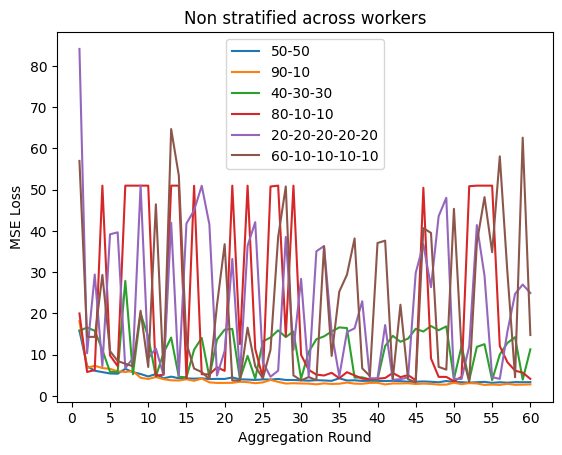

In [15]:
# Plot non stratified FL MLP convergence
plot_loss([[(1, 15.835489833641406), (2, 7.22735674676525), (3, 6.1090573012939), (4, 5.77818853974122), (5, 5.449168207024029), (6, 5.388170055452865), (7, 6.574861367837339), (8, 5.759704251386322), (9, 5.321626617375231), (10, 4.728280961182994), (11, 5.312384473197782), (12, 4.279112754158965), (13, 4.678373382624769), (14, 4.290203327171904), (15, 4.249537892791127), (16, 4.190388170055453), (17, 4.279112754158965), (18, 4.094269870609981), (19, 4.136783733826248), (20, 4.12014787430684), (21, 4.480591497227357), (22, 4.031423290203327), (23, 3.9741219963031424), (24, 3.8817005545286505), (25, 4.022181146025878), (26, 3.975970425138632), (27, 4.116451016635859), (28, 3.876155268022181), (29, 3.866913123844732), (30, 3.789279112754159), (31, 3.698706099815157), (32, 3.8262476894639557), (33, 3.7541589648798523), (34, 3.6617375231053604), (35, 4.279112754158965), (36, 3.7486136783733826), (37, 3.798521256931608), (38, 3.645101663585952), (39, 3.6765249537892792), (40, 3.6598890942698707), (41, 3.6173752310536043), (42, 3.6672828096118297), (43, 3.5914972273567467), (44, 3.4491682070240297), (45, 3.43992606284658), (46, 3.5175600739371533), (47, 3.436229205175601), (48, 3.310536044362292), (49, 3.622920517560074), (50, 3.391866913123845), (51, 3.3364140480591495), (52, 3.22550831792976), (53, 3.325323475046211), (54, 3.4085027726432533), (55, 3.177449168207024), (56, 3.3234750462107208), (57, 3.2070240295748613), (58, 3.3512014787430684), (59, 3.3271719038817005), (60, 3.345656192236599)]
, [(1, 18.120147874306838), (2, 6.7744916820702406), (3, 7.3290203327171906), (4, 6.754158964879852), (5, 6.569316081330869), (6, 5.972273567467653), (7, 5.809611829944547), (8, 6.0258780036968576), (9, 4.402957486136784), (10, 4.118299445471349), (11, 4.580406654343808), (12, 4.072088724584104), (13, 3.789279112754159), (14, 3.743068391866913), (15, 4.033271719038817), (16, 3.6672828096118297), (17, 4.2181146025878), (18, 3.2957486136783736), (19, 3.1515711645101665), (20, 3.162661737523105), (21, 3.1848428835489835), (22, 3.4473197781885396), (23, 3.3401109057301293), (24, 3.086876155268022), (25, 3.2828096118299444), (26, 3.8964879852125693), (27, 3.412199630314233), (28, 3.009242144177449), (29, 3.0850277264325325), (30, 3.024029574861368), (31, 2.988909426987061), (32, 2.8188539741219962), (33, 3.044362292051756), (34, 2.909426987060998), (35, 2.9611829944547137), (36, 3.243992606284658), (37, 2.981515711645102), (38, 2.946395563770795), (39, 3.166358595194085), (40, 3.186691312384473), (41, 2.8022181146025877), (42, 3.0295748613678373), (43, 3.020332717190388), (44, 3.075785582255083), (45, 2.8946395563770797), (46, 2.9963031423290203), (47, 2.9149722735674675), (48, 2.744916820702403), (49, 2.7504621072088726), (50, 3.2033271719038816), (51, 2.855822550831793), (52, 3.1127541589648797), (53, 3.0295748613678373), (54, 2.6728280961182995), (55, 2.7634011090573014), (56, 2.678373382624769), (57, 2.942698706099815), (58, 2.7042513863216264), (59, 2.744916820702403), (60, 2.804066543438078)]
, [(1, 15.791127541589649), (2, 16.58410351201479), (3, 15.800369685767098), (4, 11.133086876155268), (5, 5.837338262476894), (6, 5.77264325323475), (7, 27.88909426987061), (8, 5.249537892791127), (9, 19.994454713493532), (10, 14.325323475046211), (11, 4.717190388170056), (12, 10.380776340110906), (13, 14.149722735674677), (14, 4.650646950092422), (15, 4.513863216266174), (16, 11.199630314232902), (17, 14.060998151571164), (18, 4.567467652495379), (19, 13.67837338262477), (20, 16.08133086876155), (21, 16.234750462107208), (22, 4.12014787430684), (23, 9.711645101663587), (24, 4.188539741219963), (25, 13.208872458410351), (26, 14.164510166358594), (27, 15.900184842883549), (28, 14.266173752310536), (29, 15.608133086876155), (30, 4.194085027726432), (31, 10.696857670979668), (32, 13.744916820702404), (33, 14.43253234750462), (34, 15.619223659889094), (35, 16.611829944547136), (36, 16.44731977818854), (37, 4.44362292051756), (38, 4.510166358595194), (39, 4.011090573012939), (40, 3.985212569316081), (41, 12.09796672828096), (42, 14.573012939001849), (43, 13.133086876155268), (44, 13.903881700554528), (45, 16.275415896487985), (46, 15.617375231053604), (47, 16.944547134935306), (48, 15.920517560073938), (49, 16.859519408502774), (50, 4.11090573012939), (51, 12.099815157116451), (52, 3.8354898336414047), (53, 11.898336414048059), (54, 12.54713493530499), (55, 3.842883548983364), (56, 10.035120147874308), (57, 12.850277264325323), (58, 14.249537892791128), (59, 3.942698706099815), (60, 11.292051756007394)]
, [(1, 19.99260628465804), (2, 5.817005545286507), (3, 6.269870609981516), (4, 50.96487985212569), (5, 9.818853974121996), (6, 7.240295748613678), (7, 50.96487985212569), (8, 50.96487985212569), (9, 50.96487985212569), (10, 50.96487985212569), (11, 4.878003696857671), (12, 5.1589648798521255), (13, 50.96487985212569), (14, 50.96487985212569), (15, 4.323475046210721), (16, 50.93345656192236), (17, 5.271719038817006), (18, 5.199630314232902), (19, 6.953789279112754), (20, 6.081330868761553), (21, 50.96487985212569), (22, 12.55822550831793), (23, 50.96487985212569), (24, 11.384473197781885), (25, 4.3622920517560075), (26, 50.75600739371534), (27, 50.96487985212569), (28, 14.463955637707949), (29, 50.96487985212569), (30, 9.953789279112755), (31, 6.314232902033272), (32, 5.166358595194085), (33, 4.959334565619224), (34, 5.6044362292051755), (35, 4.303142329020333), (36, 5.754158964879852), (37, 4.979667282809612), (38, 4.2014787430683915), (39, 4.038817005545287), (40, 4.181146025878004), (41, 4.354898336414048), (42, 5.56007393715342), (43, 4.565619223659889), (44, 5.040665434380776), (45, 3.8207024029574863), (46, 50.44547134935305), (47, 9.092421441774492), (48, 4.626617375231054), (49, 4.611829944547135), (50, 3.567467652495379), (51, 4.624768946395564), (52, 50.82809611829945), (53, 50.96487985212569), (54, 50.96487985212569), (55, 50.96487985212569), (56, 12.101663585951941), (57, 8.177449168207024), (58, 6.129390018484289), (59, 5.641404805914973), (60, 4.142329020332717)]
, [(1, 84.09796672828097), (2, 10.354898336414047), (3, 29.432532347504623), (4, 7.2199630314232905), (5, 39.173752310536045), (6, 39.64879852125693), (7, 6.726432532347505), (8, 9.166358595194085), (9, 50.96487985212569), (10, 9.173752310536045), (11, 11.469500924214417), (12, 5.103512014787431), (13, 41.975970425138634), (14, 4.811460258780037), (15, 41.78373382624769), (16, 44.975970425138634), (17, 50.927911275415894), (18, 41.59519408502773), (19, 4.942698706099815), (20, 10.903881700554528), (21, 33.20147874306839), (22, 4.881700554528651), (23, 36.39741219963032), (24, 42.11460258780037), (25, 8.194085027726432), (26, 4.658040665434381), (27, 6.131238447319778), (28, 38.54158964879852), (29, 11.179297597042513), (30, 28.373382624768947), (31, 4.682070240295749), (32, 35.05360443622921), (33, 36.3271719038817), (34, 15.362292051756008), (35, 4.77634011090573), (36, 15.467652495378928), (37, 16.382624768946396), (38, 22.953789279112755), (39, 4.292051756007393), (40, 4.266173752310536), (41, 17.179297597042513), (42, 3.9020332717190387), (43, 4.079482439926063), (44, 4.456561922365989), (45, 29.824399260628464), (46, 36.7634011090573), (47, 26.364140480591498), (48, 43.56007393715342), (49, 48.033271719038815), (50, 4.133086876155268), (51, 4.1256931608133085), (52, 12.009242144177449), (53, 41.40480591497227), (54, 29.155268022181147), (55, 4.550831792975971), (56, 4.136783733826248), (57, 15.611829944547136), (58, 24.737523105360445), (59, 26.99815157116451), (60, 24.951940850277264)]
, [(1, 56.96118299445472), (2, 14.33826247689464), (3, 14.293900184842883), (4, 29.32902033271719), (5, 10.878003696857672), (6, 8.467652495378928), (7, 7.811460258780037), (8, 7.194085027726432), (9, 20.637707948243992), (10, 7.022181146025878), (11, 46.44177449168207), (12, 5.375231053604436), (13, 64.67837338262477), (14, 53.438077634011094), (15, 12.767097966728281), (16, 6.639556377079482), (17, 5.792975970425139), (18, 4.0924214417744915), (19, 22.073937153419593), (20, 36.781885397412196), (21, 3.746765249537893), (22, 3.7615526802218113), (23, 16.54898336414048), (24, 7.1922365988909425), (25, 4.262476894639557), (26, 11.179297597042513), (27, 38.52310536044362), (28, 50.76524953789279), (29, 4.977818853974122), (30, 3.7726432532347505), (31, 4.573012939001848), (32, 3.837338262476895), (33, 36.23290203327172), (34, 9.702402957486136), (35, 25.303142329020332), (36, 29.358595194085026), (37, 38.160813308687615), (38, 6.683918669131239), (39, 4.837338262476894), (40, 37.06099815157116), (41, 37.63401109057301), (42, 4.079482439926063), (43, 22.10720887245841), (44, 4.053604436229205), (45, 3.2846580406654344), (46, 40.676524953789276), (47, 39.50277264325324), (48, 7.046210720887246), (49, 6.377079482439926), (50, 45.345656192236596), (51, 11.020332717190389), (52, 3.388170055452865), (53, 37.1460258780037), (54, 48.181146025878), (55, 34.8373382624769), (56, 58.06284658040666), (57, 29.852125693160815), (58, 4.521256931608133), (59, 62.593345656192234), (60, 14.761552680221811)]]
, start = 0, title = 'Non stratified across workers')

mses = [3.345656192236599,
2.804066543438078,
11.292051756007394,
4.142329020332717,
24.951940850277264,
14.761552680221811]

aucs = [0.8703482791718087,
0.8431783902372137,
0.5,
0.815843959961607,
0.5087412587412588,
0.5384615384615384]

### LSTM

In [9]:
# Transform to time series
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

df_14q4_mod = df_14q4.drop(columns=['year', 'Total debt/total asset', 'Earnings Per Share from Operations', 'total asset/total libiilities', 'gross profit/rev', 'EBTI/total asset', 'Book Value Per Share'], inplace=False, errors='ignore')
df_15q4_mod = df_15q4.drop(columns=['year', 'Total debt/total asset', 'Earnings Per Share from Operations', 'total asset/total libiilities', 'gross profit/rev', 'EBTI/total asset', 'Book Value Per Share'], inplace=False, errors='ignore')
df_16q4_mod = df_16q4.drop(columns=['year', 'Total debt/total asset', 'Earnings Per Share from Operations', 'total asset/total libiilities', 'gross profit/rev', 'EBTI/total asset', 'Book Value Per Share'], inplace=False, errors='ignore')
df_14q4_mod = (df_14q4_mod-df_14q4_mod.mean())/df_14q4_mod.std()
df_15q4_mod = (df_15q4_mod-df_15q4_mod.mean())/df_15q4_mod.std()
df_16q4_mod = (df_16q4_mod-df_16q4_mod.mean())/df_16q4_mod.std()
df_14q4_mod['label'] = q4_labels['2014Q4']
df_15q4_mod['label'] = q4_labels['2015Q4']
df_16q4_mod['label'] = q4_labels['2015Q4']

ts14 = torch.tensor(df_14q4_mod.values.astype('float32'))
ts15 = torch.tensor(df_15q4_mod.values.astype('float32'))
ts16 = torch.tensor(df_16q4_mod.values.astype('float32'))
ts = torch.stack([ts14, ts15, ts16], 1)
ts_labels = q4_labels['2016Q4']

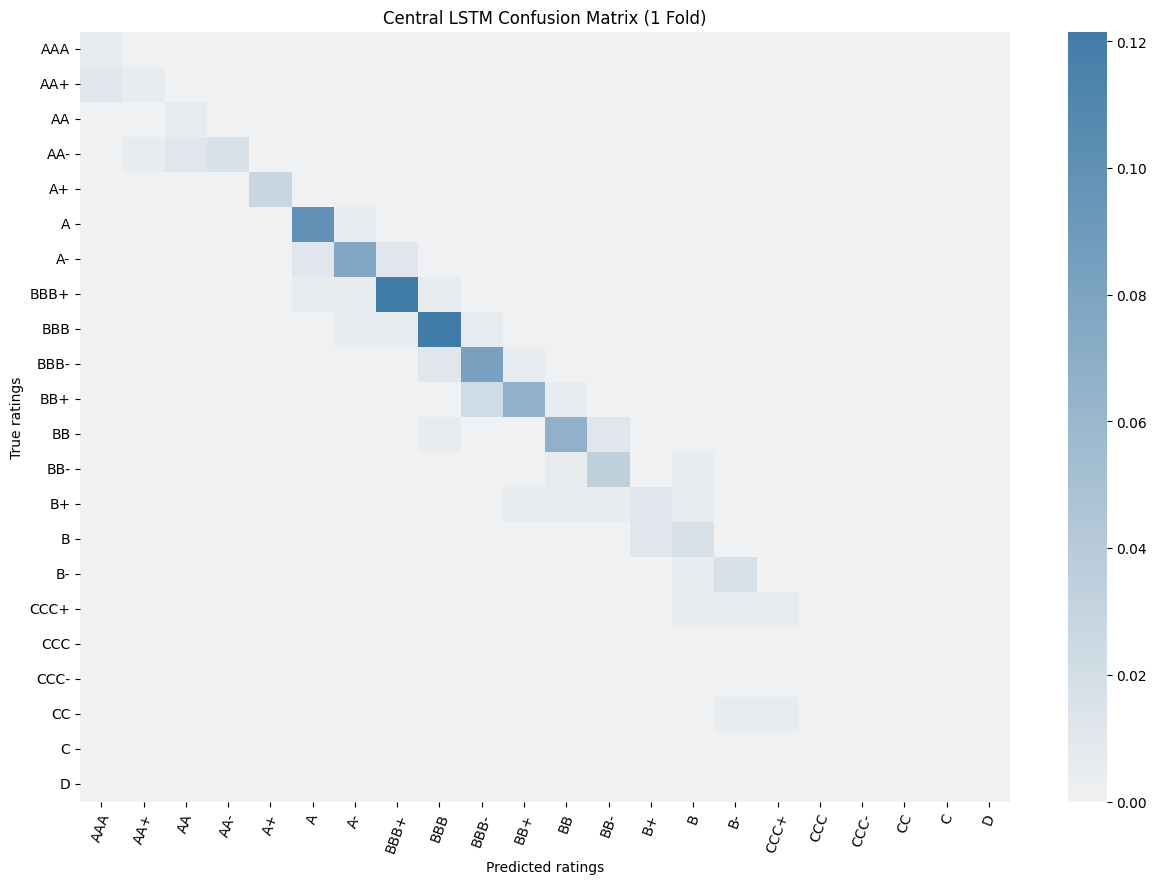

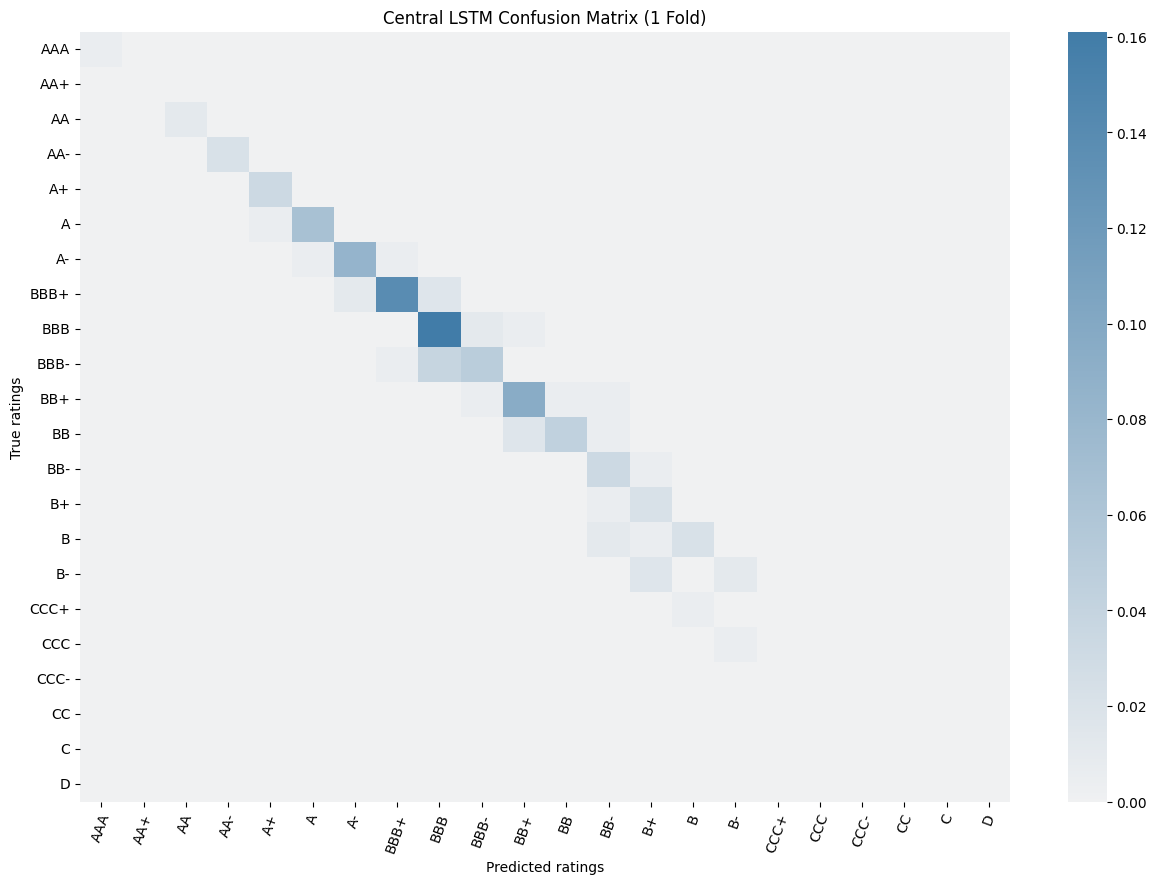

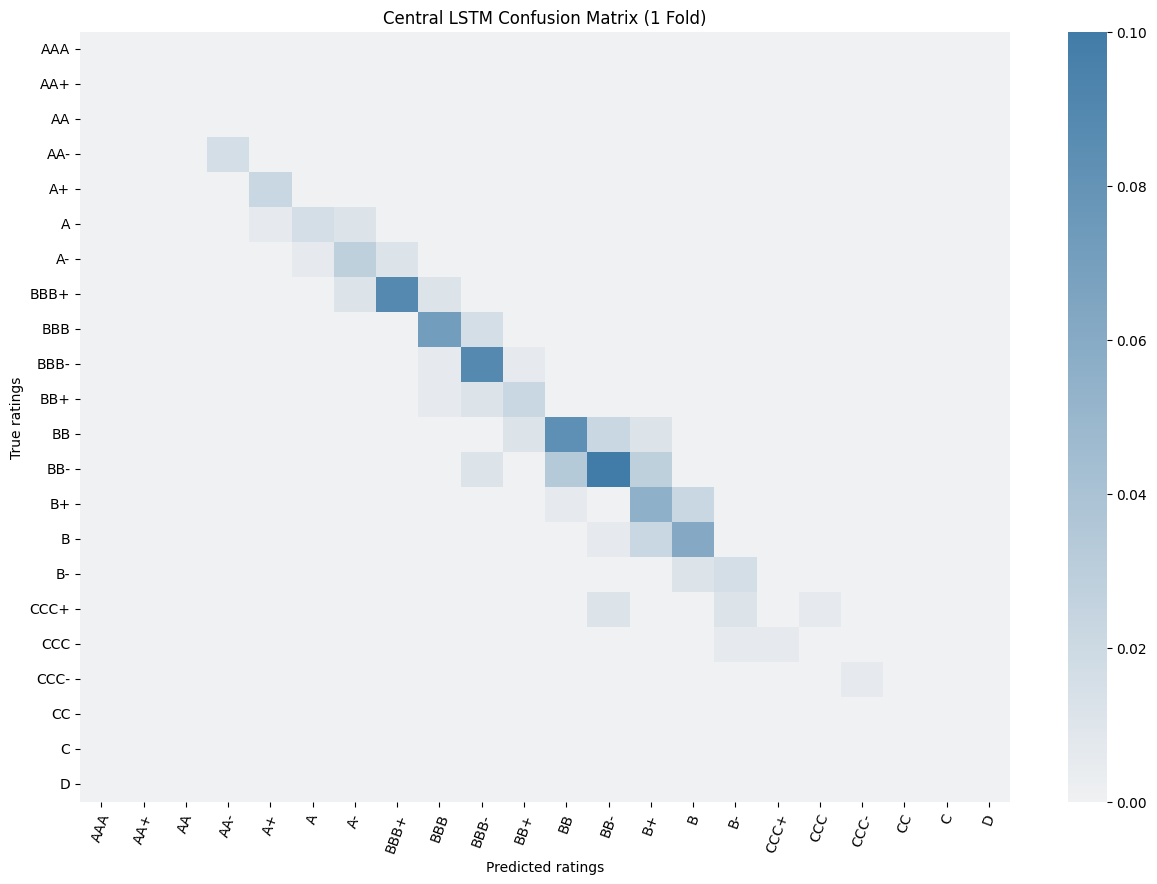

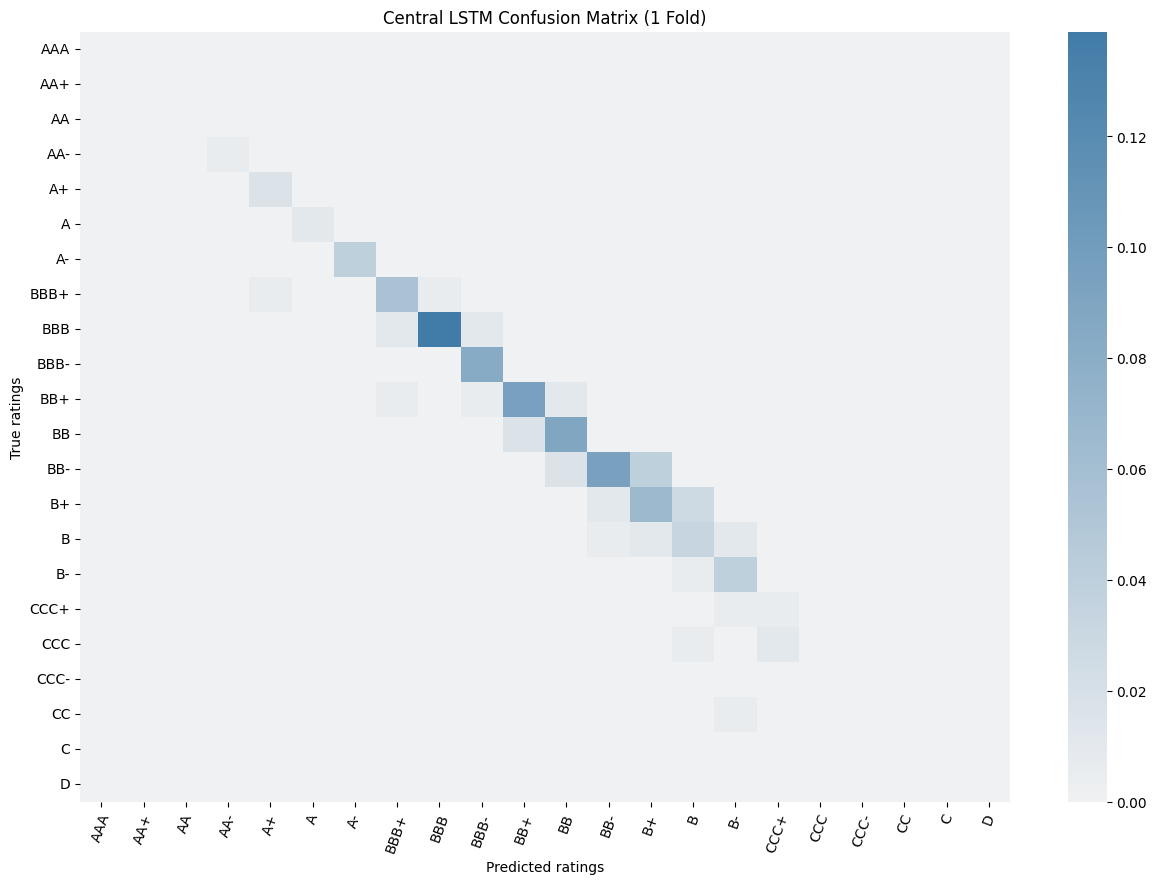

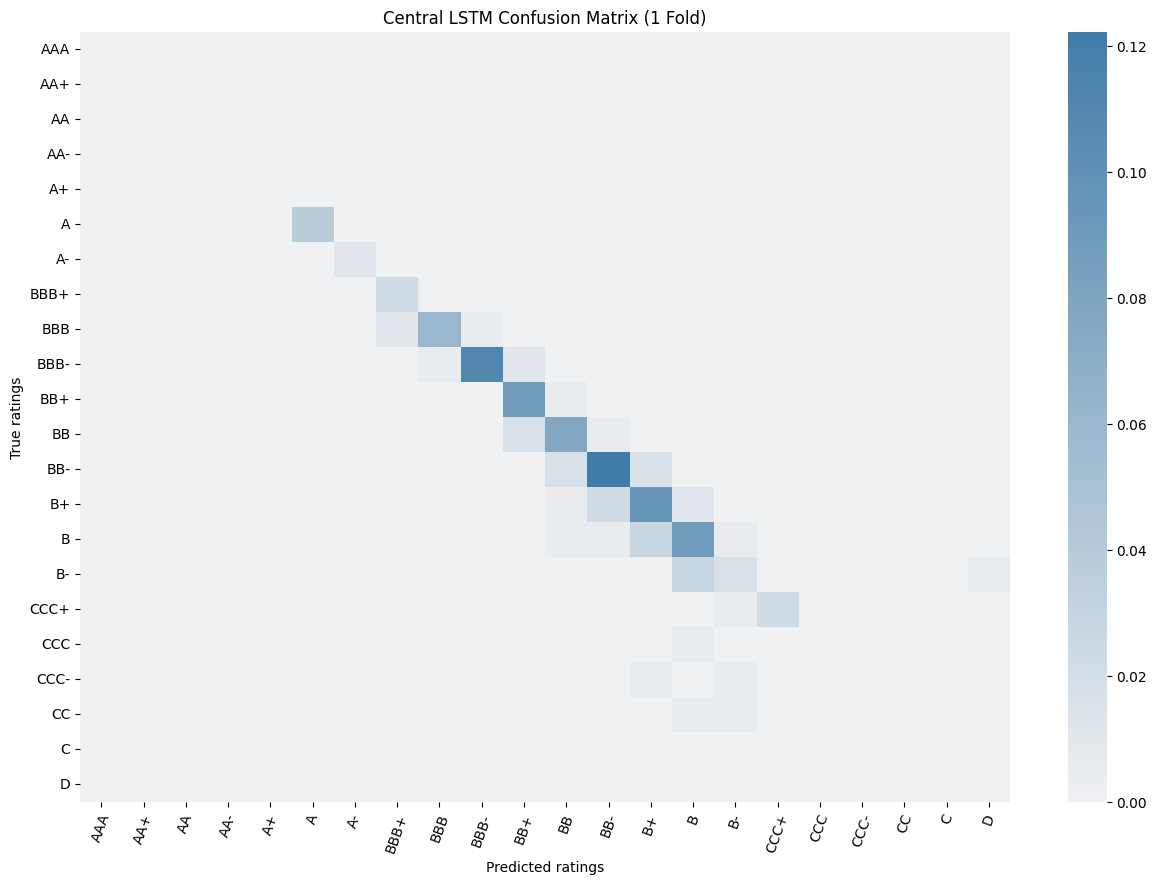

In [19]:
# 5 fold cross validation
mses = []
mse_norms = []
aucs = []
f1s = []

kf = KFold(n_splits=5)
for i, (train_idx, test_idx) in enumerate(kf.split(ts, ts_labels)):
  X_train = ts[train_idx]
  X_test = ts[test_idx]
  y_train = torch.reshape(torch.tensor(ts_labels)[train_idx], (-1, 1))
  y_test = torch.reshape(torch.tensor(ts_labels)[test_idx], (-1, 1))
  lstm = LSTMModel(23, 21)

  y_pred = lstm(X_test[:, 1, -1])
  confusion(y_pred, y_test, f'Central LSTM Confusion Matrix (1 Fold)')
  mse, mse_norm, auc, f1 = test(lstm, X_test, y_test)
  mses.append(mse)
  mse_norms.append(mse_norm)
  aucs.append(auc)
  f1s.append(f1)

In [20]:
# Print 5 fold cross validation statistics
import statistics

print(mses)
print(statistics.mean(mses))
print(statistics.stdev(mses))
print(statistics.mean(mse_norms))
print(statistics.stdev(mse_norms))
print(statistics.mean(aucs))
print(statistics.stdev(aucs))
print(statistics.mean(f1s))
print(statistics.stdev(f1s))

[0.26519337016574585, 0.17222222222222222, 0.18888888888888888, 0.2388888888888889, 0.8666666666666667]
0.3463720073664825
0.29324827563983724
0.0007854240529852211
0.0006649620762808101
0.979819832910742
0.023192472671725778
0.9801045178768082
0.02801661953984082


In [11]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(ts, ts_labels, test_size=0.2, random_state=1)
y_train = torch.reshape(torch.tensor(y_train.values), (-1, 1))
y_test = torch.reshape(torch.tensor(y_test.values), (-1, 1))

In [12]:
# Define LSTM FL simulation wrapper
from fl_simu import lstm_simulation

def run_lstm_simulation(split, dir='default', num_epoch=256, batch_size=16, num_rounds=15):
    return lstm_simulation(split, X_train, y_train, X_test, y_test, dir, num_epoch, batch_size, num_rounds)


#### 32 Epoch

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-23 02:19:42,149 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


2023-06-23 02:19:44,982	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
INFO flwr 2023-06-23 02:19:45,882 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'memory': 7325561652.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-23 02:19:45,883 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-23 02:19:45,884 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-23 02:19:46,742 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-23 02:19:46,742 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-23 02:19:46,743 | server.py:101 | FL starting
DEBUG flwr 2023-06-23 02:19:46,743 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:20:12,103 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-23 02:20:12,130 | fedavg.py:243 | No

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-23 02:20:41,255 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:20:41,322 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-23 02:20:41,501 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:20:41,507 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:21:12,252 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:21:12,339 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:21:12,447 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:21:12,448 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-23 02:21:37,474 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:21:37,513 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:21:37,625 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:21:37,626 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-23 02:22:01,455 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:22:01,491 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:22:01,558 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:22:01,558 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-23 02:22:27,167 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:22:27,217 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:22:27,267 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:22:27,267 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-23 02:22:52,532 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:22:52,571 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:22:52,629 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:22:52,629 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-23 02:23:17,063 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:23:17,089 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:23:17,139 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:23:17,139 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-23 02:23:42,782 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:23:42,867 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:23:42,951 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:23:42,951 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-23 02:24:08,347 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:24:08,379 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:24:08,425 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:24:08,426 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-23 02:24:33,594 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:24:33,652 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:24:33,749 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:24:33,750 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-23 02:24:58,464 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:24:58,501 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:24:58,551 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:24:58,551 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-23 02:25:22,329 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:25:22,387 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:25:22,468 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:25:22,469 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-23 02:25:47,791 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:25:47,849 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:25:47,946 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:25:47,948 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-23 02:26:11,732 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:26:11,756 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:26:11,800 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:26:11,801 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-23 02:26:35,814 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:26:35,845 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:26:35,892 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:26:35,892 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-23 02:27:00,685 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:27:00,711 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:27:00,754 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:27:00,754 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-23 02:27:26,637 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:27:26,661 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:27:26,702 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:27:26,703 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-23 02:27:51,120 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:27:51,148 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:27:51,194 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:27:51,195 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-23 02:28:16,262 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-23 02:28:16,320 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 02:28:16,399 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-23 02:28:16,399 | server.py:147 | FL finished in 509.6505911250133
INFO flwr 2023-06-23 02:28:16,401 | app.py:218 | app_fit: losses_distributed [(1, 1.6850828729281768), (2, 0.7348066298342542), (3, 0.6961325966850829), (4, 0.6795580110497238), (5, 0.7071823204419889), (6, 0.7237569060773481), (7, 0.6795580110497238), (8, 0.7237569060773481), (9, 0.6961325966850829), (10, 0.712707182320442), (11, 0.7292817679558011), (12, 0.8839779005524862), (13, 0.7734806629834254), (14, 0.8232044198895028), (15, 0.7734806629834254), (16, 0.8011049723756906), (17, 0.8397790055248618), (18, 0.8397790055248618), (19, 0.8839779005524862), (20, 0.8397790055248618)]
INFO flwr 20

Saving round 20 aggregated_parameters...
0.8397790055248618
0.001904260783503088
0.9668011738811445
0.9680851063829787


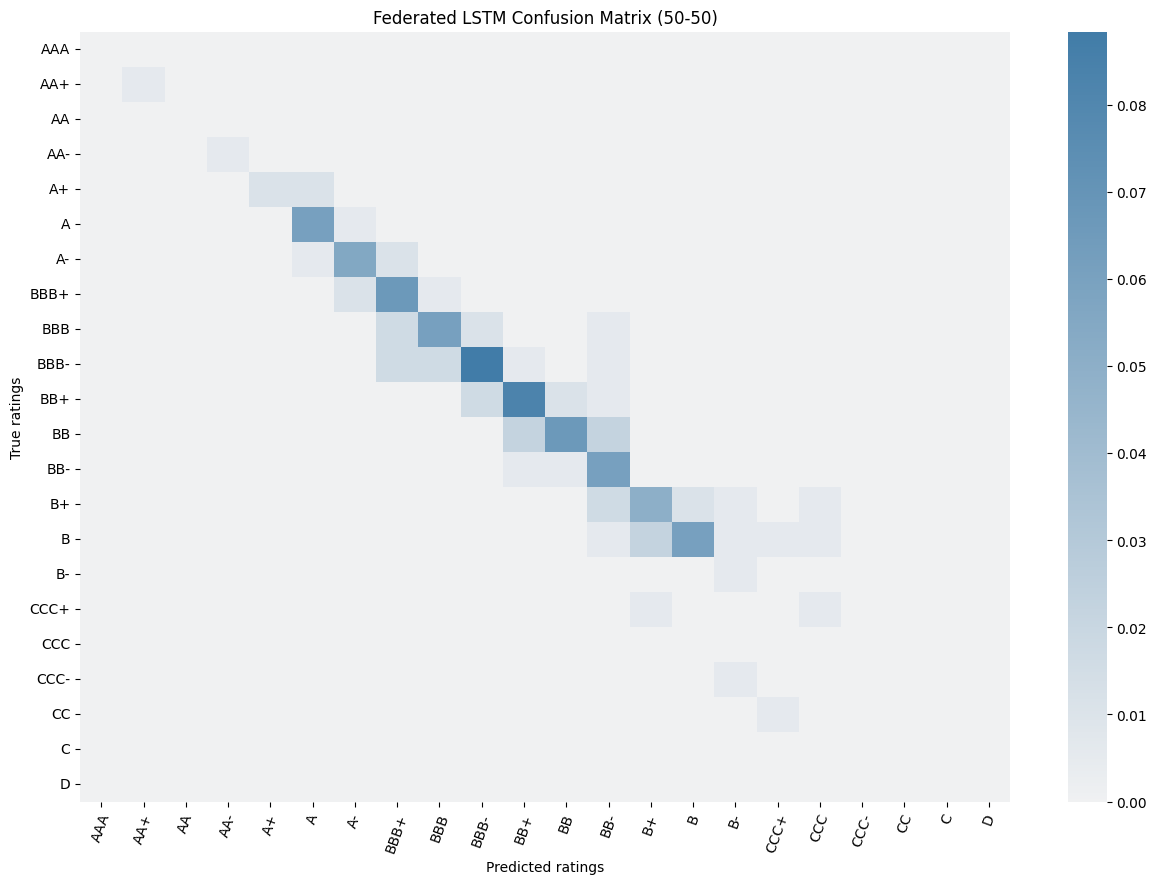

In [14]:
# 50-50
model_fl = run_lstm_simulation([0.5, 0.5], 'split_50_50', 32, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (50-50)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-23 06:36:09,182 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2023-06-23 06:36:13,262	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
INFO flwr 2023-06-23 06:36:13,963 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 7922714215.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-23 06:36:13,964 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-23 06:36:13,964 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-23 06:36:15,191 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-23 06:36:15,192 | server.py:88 | Evaluating initial paramet

Saving round 1 aggregated_parameters...


DEBUG flwr 2023-06-23 06:37:37,183 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:37:37,225 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:37:37,301 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:37:37,301 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-23 06:38:18,101 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:38:18,158 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:38:18,269 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:38:18,269 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-23 06:38:58,805 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:38:58,837 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:38:58,916 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:38:58,917 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-23 06:39:41,832 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:39:41,897 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:39:42,020 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:39:42,021 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-23 06:40:21,094 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:40:21,147 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:40:21,229 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:40:21,229 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-23 06:41:01,117 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:41:01,148 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:41:01,192 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:41:01,192 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-23 06:41:39,784 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:41:39,820 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:41:39,897 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:41:39,898 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-23 06:42:21,276 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:42:21,328 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:42:21,444 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:42:21,445 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-23 06:43:04,493 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:43:04,546 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:43:04,616 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:43:04,617 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-23 06:43:44,098 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:43:44,153 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:43:44,240 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:43:44,240 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-23 06:44:24,119 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:44:24,174 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:44:24,277 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:44:24,277 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-23 06:45:01,873 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:45:01,921 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:45:02,019 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:45:02,019 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-23 06:45:42,952 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:45:43,010 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:45:43,099 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:45:43,100 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-23 06:46:21,701 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:46:21,752 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:46:21,810 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:46:21,811 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-23 06:47:01,769 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:47:01,840 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:47:01,912 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:47:01,913 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-23 06:47:41,764 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:47:41,812 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:47:41,887 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:47:41,888 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-23 06:48:23,121 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:48:23,177 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:48:23,284 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:48:23,285 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-23 06:49:04,792 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:49:04,843 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:49:04,920 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:49:04,920 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-23 06:49:42,673 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-23 06:49:42,696 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-23 06:49:42,743 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-23 06:49:42,744 | server.py:147 | FL finished in 807.5487481669988
INFO flwr 2023-06-23 06:49:42,745 | app.py:218 | app_fit: losses_distributed [(1, 0.6961325966850829), (2, 0.6353591160220995), (3, 0.7071823204419889), (4, 0.6850828729281768), (5, 0.7071823204419889), (6, 0.7016574585635359), (7, 0.7790055248618785), (8, 0.7182320441988951), (9, 0.7237569060773481), (10, 0.7845303867403315), (11, 0.8232044198895028), (12, 0.7569060773480663), (13, 0.9171270718232044), (14, 0.9281767955801105), (15, 0.9005524861878453), (16, 0.8674033149171271), (17, 0.7845303867403315), (18, 0.8674033149171271), (19, 0.850828729281768), (20, 0.8453038674033149)]
INFO flwr 20

Saving round 20 aggregated_parameters...
0.8453038674033149
0.0019167888149735032
0.9397774516996822
0.9405405405405406


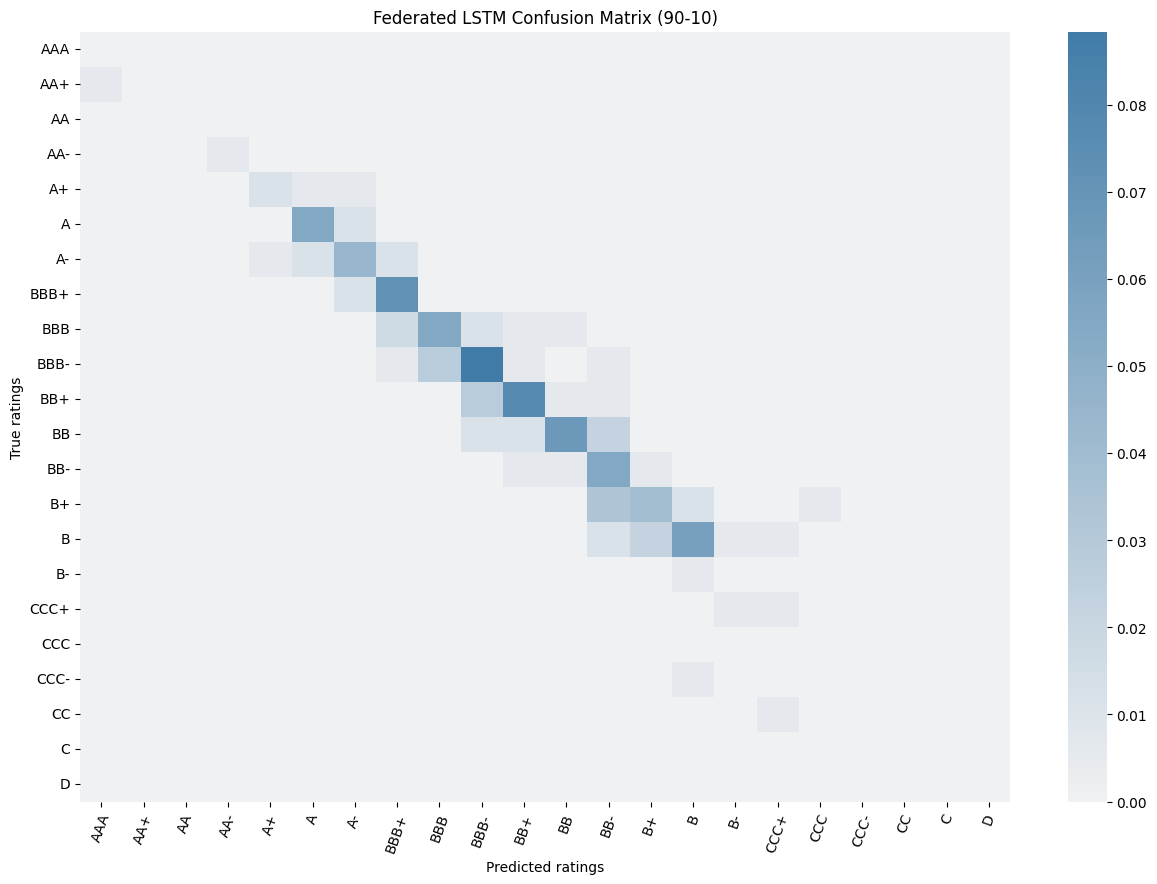

In [19]:
# 90-10
model_fl = run_lstm_simulation([0.9, 0.1], 'split_90_10', 32, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 14:56:07,788 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=24486) Epoch: 32, Loss: 0.24205400049686432 [repeated 2x across cluster]
(launch_and_evaluate pid=24486) Client 1 evaluate, config {}


2023-06-15 14:56:13,045	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 14:56:13,609 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'memory': 8673973044.0}
INFO flwr 2023-06-15 14:56:13,610 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 14:56:13,610 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 14:56:14,429 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 14:56:14,429 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 14:56:14,430 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 14:56:14,430 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=24557) Epoch: 1, Loss: 40.40304946899414
(launch_and_fit pid=24557) Epoch: 2, Loss: 40.931156158447266
(launch_and_fit pid=24557) Epoch: 3, Loss: 30.91078758239746
(launch_and_fit pid=24557) Epoch: 4, Loss: 42.26982498168945
(launch_and_fit pid=24557) Epoch: 5, Loss: 20.71683692932129


DEBUG flwr 2023-06-15 14:56:19,483 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 14:56:19,502 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 14:56:19,523 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:56:19,623 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 14:56:19,624 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 14:56:19,624 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 0 evaluate, config {}
(launch_and_fit pid=24557) Epoch: 1, Loss: 4.269476413726807 [repeated 60x across cluster]
(launch_and_evaluate pid=24555) Epoch: 29, Loss: 5.626764297485352
(launch_and_fit pid=24555) Epoch: 30, Loss: 5.679529190063477 [repeated 61x across cluster]


DEBUG flwr 2023-06-15 14:56:25,181 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:56:25,205 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:56:25,291 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:56:25,292 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 1 evaluate, config {}
(launch_and_fit pid=24557) Epoch: 28, Loss: 1.3398362398147583 [repeated 62x across cluster]
(launch_and_evaluate pid=24555) Epoch: 30, Loss: 1.2201564311981201


DEBUG flwr 2023-06-15 14:56:30,578 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:56:30,601 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:56:30,696 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:56:30,697 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 0 evaluate, config {}
(launch_and_fit pid=24557) Epoch: 32, Loss: 1.4097914695739746 [repeated 64x across cluster]


DEBUG flwr 2023-06-15 14:56:35,510 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:56:35,545 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:56:35,631 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:56:35,632 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=24555) Client 2 evaluate, config {} [repeated 3x across cluster]


DEBUG flwr 2023-06-15 14:56:40,242 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:56:40,267 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=24555) Epoch: 31, Loss: 0.7098957300186157 [repeated 67x across cluster]
Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 14:56:40,349 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:56:40,350 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=24555) Client 2 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=24557) Epoch: 32, Loss: 0.43994730710983276 [repeated 56x across cluster]


DEBUG flwr 2023-06-15 14:56:46,533 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:56:46,562 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:56:46,656 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:56:46,657 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 0 evaluate, config {}
(launch_and_fit pid=24557) Epoch: 24, Loss: 0.32760775089263916 [repeated 51x across cluster]
(launch_and_evaluate pid=24555) Epoch: 28, Loss: 1.6147773265838623


DEBUG flwr 2023-06-15 14:56:52,277 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:56:52,299 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:56:52,386 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:56:52,386 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 1 evaluate, config {}
(launch_and_fit pid=24557) Epoch: 17, Loss: 0.9043793678283691 [repeated 52x across cluster]
(launch_and_evaluate pid=24555) Epoch: 32, Loss: 0.4647342562675476


DEBUG flwr 2023-06-15 14:56:58,646 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:56:58,678 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:56:58,774 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:56:58,774 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 0 evaluate, config {}
(launch_and_fit pid=24557) Epoch: 9, Loss: 2.841747283935547 [repeated 50x across cluster]
(launch_and_evaluate pid=24555) Epoch: 30, Loss: 0.8395581245422363


DEBUG flwr 2023-06-15 14:57:04,802 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:04,827 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:57:04,924 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:04,925 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 2 evaluate, config {}
(launch_and_fit pid=24555) Epoch: 3, Loss: 1.1945916414260864 [repeated 53x across cluster]


DEBUG flwr 2023-06-15 14:57:09,874 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:09,903 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:57:09,990 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:09,991 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=24555) Epoch: 32, Loss: 0.6474651098251343
(launch_and_evaluate pid=24557) Client 2 evaluate, config {}
(launch_and_fit pid=24555) Epoch: 2, Loss: 0.9847071766853333 [repeated 63x across cluster]
(launch_and_evaluate pid=24555) Epoch: 26, Loss: 0.8469210267066956
(launch_and_fit pid=24555) Epoch: 29, Loss: 0.4464268982410431 [repeated 57x across cluster]


DEBUG flwr 2023-06-15 14:57:16,002 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:16,025 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:57:16,117 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:16,118 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 1 evaluate, config {}
(launch_and_fit pid=24557) Epoch: 30, Loss: 0.40299147367477417 [repeated 55x across cluster]
(launch_and_evaluate pid=24555) Epoch: 26, Loss: 0.45626354217529297


DEBUG flwr 2023-06-15 14:57:22,006 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:22,033 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:57:22,143 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:22,144 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 0 evaluate, config {}
(launch_and_fit pid=24557) Epoch: 24, Loss: 1.1550977230072021 [repeated 53x across cluster]
(launch_and_evaluate pid=24555) Epoch: 27, Loss: 0.5305342674255371


DEBUG flwr 2023-06-15 14:57:27,990 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:28,014 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:57:28,122 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:28,122 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 2 evaluate, config {}
(launch_and_fit pid=24557) Epoch: 17, Loss: 0.35685229301452637 [repeated 51x across cluster]
(launch_and_evaluate pid=24555) Epoch: 25, Loss: 0.4362546503543854


DEBUG flwr 2023-06-15 14:57:34,348 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:34,387 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:57:34,488 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:34,488 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 0 evaluate, config {}
(launch_and_fit pid=24557) Epoch: 6, Loss: 0.49501708149909973 [repeated 48x across cluster]
(launch_and_evaluate pid=24555) Epoch: 28, Loss: 0.3161861300468445


DEBUG flwr 2023-06-15 14:57:40,084 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:40,110 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:57:40,203 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:40,204 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 1 evaluate, config {}
(launch_and_fit pid=24557) Epoch: 3, Loss: 1.3978829383850098 [repeated 57x across cluster]


DEBUG flwr 2023-06-15 14:57:45,133 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:45,166 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:57:45,265 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:45,266 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=24557) Epoch: 3, Loss: 0.7612266540527344 [repeated 64x across cluster]


DEBUG flwr 2023-06-15 14:57:50,172 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:50,202 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:57:50,295 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:50,295 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=24557) Epoch: 3, Loss: 0.6300930976867676 [repeated 64x across cluster]
(launch_and_evaluate pid=24555) Epoch: 27, Loss: 0.39612478017807007
(launch_and_fit pid=24555) Epoch: 30, Loss: 0.6644614934921265 [repeated 57x across cluster]


DEBUG flwr 2023-06-15 14:57:56,280 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:56,305 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:57:56,397 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:57:56,397 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 0 evaluate, config {}
(launch_and_fit pid=24557) Epoch: 31, Loss: 0.20847266912460327 [repeated 62x across cluster]


DEBUG flwr 2023-06-15 14:58:01,301 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:58:01,329 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:58:01,426 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:58:01,426 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=24557) Epoch: 23, Loss: 0.08508671075105667 [repeated 56x across cluster]
(launch_and_evaluate pid=24555) Epoch: 26, Loss: 0.28964298963546753


DEBUG flwr 2023-06-15 14:58:07,393 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:58:07,430 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:58:07,526 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 14:58:07,527 | server.py:147 | FL finished in 113.09688175003976
INFO flwr 2023-06-15 14:58:07,528 | app.py:218 | app_fit: losses_distributed [(1, 51.20249653259362), (2, 33.55617198335645), (3, 1.0513176144244105), (4, 1.0332871012482663), (5, 1.0208044382801664), (6, 1.0180305131761442), (7, 1.030513176144244), (8, 1.044382801664355), (9, 0.957004160887656), (10, 0.9764216366158114), (11, 0.9653259361997226), (12, 0.9736477115117892), (13, 0.9320388349514563), (14, 0.9514563106796117), (15, 0.9583911234396671), (16, 0.9042995839112344), (17, 0.8959778085991679), (18, 0.871012482662968), (19, 0.8959778085991679), (20, 0.9375866851595007)]
INFO flwr 2023-0

Saving round 20 aggregated_parameters...
(launch_and_evaluate pid=24557) Client 2 evaluate, config {}
Loading pre-trained model from:  lstm_model_checkpoints/split_40_30_30/model_round_20.pth
0.9375866851595007
0.002126046905123584
0.9651577471731829
0.9665327978580991


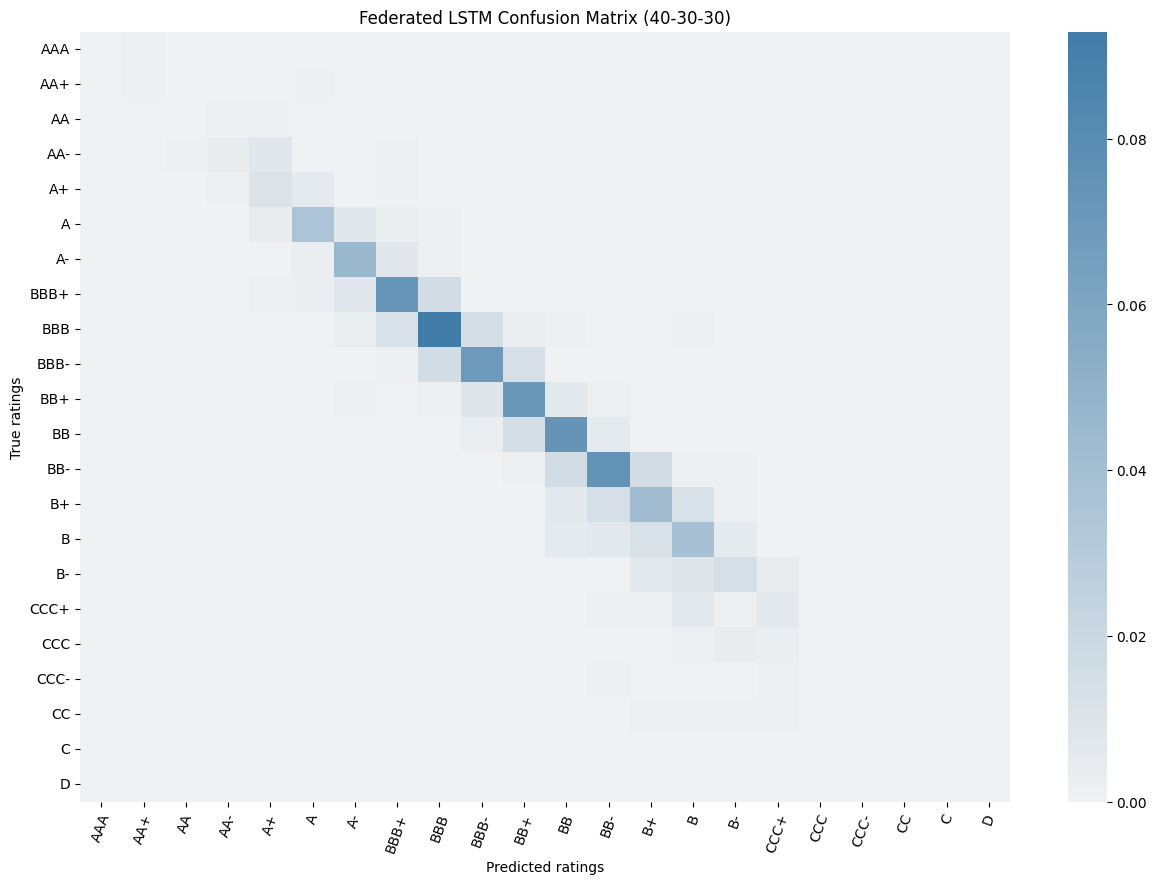

In [54]:
# 40-30-30
model_fl = run_lstm_simulation([0.4, 0.3, 0.3], 'split_40_30_30', 32, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (40-30-30)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 14:58:08,071 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=24557) Epoch: 32, Loss: 0.5865758061408997 [repeated 12x across cluster]
(launch_and_evaluate pid=24555) Client 0 evaluate, config {}


2023-06-15 14:58:12,502	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 14:58:13,050 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'node:127.0.0.1': 1.0, 'memory': 8710055527.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-15 14:58:13,050 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 14:58:13,051 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 14:58:13,882 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 14:58:13,882 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 14:58:13,882 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 14:58:13,883 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=24580) Epoch: 1, Loss: 23.52322006225586
(launch_and_fit pid=24580) Epoch: 2, Loss: 22.423660278320312
(launch_and_fit pid=24580) Epoch: 3, Loss: 12.711976051330566
(launch_and_fit pid=24580) Epoch: 4, Loss: 19.372318267822266
(launch_and_fit pid=24580) Epoch: 5, Loss: 24.924684524536133
(launch_and_fit pid=24580) Epoch: 6, Loss: 20.912322998046875
(launch_and_fit pid=24580) Epoch: 7, Loss: 17.999778747558594
(launch_and_fit pid=24580) Epoch: 8, Loss: 12.378746032714844
(launch_and_fit pid=24580) Epoch: 9, Loss: 18.461170196533203
(launch_and_fit pid=24580) Epoch: 10, Loss: 17.462968826293945
(launch_and_fit pid=24580) Epoch: 11, Loss: 13.508970260620117
(launch_and_fit pid=24580) Epoch: 12, Loss: 17.753868103027344
(launch_and_fit pid=24580) Epoch: 13, Loss: 13.882047653198242
(launch_and_fit pid=24580) Epoch: 14, Loss: 13.319842338562012
(launch_and_fit pid=24580) Epoch: 15, Loss: 11.957390785217285
(launch_and_fit pid=24580) Epoch: 16, Loss: 18.057613372802734


DEBUG flwr 2023-06-15 14:58:16,225 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 14:58:16,242 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 14:58:16,263 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:58:16,375 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 14:58:16,376 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 14:58:16,376 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=24580) Client 1 evaluate, config {}
(launch_and_fit pid=24580) 


DEBUG flwr 2023-06-15 14:58:18,045 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:58:18,072 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:58:18,171 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:58:18,171 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...
(launch_and_fit pid=24574) Epoch: 17, Loss: 4.306854724884033 [repeated 131x across cluster]
(launch_and_evaluate pid=24574) Client 2 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=24580) Epoch: 17, Loss: 6.323143482208252 [repeated 30x across cluster]


DEBUG flwr 2023-06-15 14:58:29,094 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:58:29,126 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:58:29,224 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:58:29,224 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=24580) Client 0 evaluate, config {}
(launch_and_fit pid=24580) Epoch: 32, Loss: 6.644016742706299 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 14:58:30,878 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:58:30,900 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:58:30,985 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:58:30,986 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=24574) Client 2 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=24574) Epoch: 10, Loss: 2.016660451889038 [repeated 106x across cluster]
(launch_and_fit pid=24574) Epoch: 26, Loss: 7.5083489418029785 [repeated 16x across cluster]


DEBUG flwr 2023-06-15 14:58:41,360 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:58:41,393 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:58:41,482 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:58:41,482 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=24580) Client 0 evaluate, config {}
(launch_and_fit pid=24574) Epoch: 8, Loss: 0.8225358724594116 [repeated 46x across cluster]
(launch_and_evaluate pid=24574) Epoch: 14, Loss: 1.2050482034683228
(launch_and_fit pid=24574) Epoch: 23, Loss: 9.032527923583984 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 14:58:52,879 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:58:52,915 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:58:53,000 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:58:53,001 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=24580) Client 0 evaluate, config {}
(launch_and_fit pid=24574) Epoch: 5, Loss: 0.7756229639053345 [repeated 46x across cluster]
(launch_and_evaluate pid=24574) Epoch: 14, Loss: 1.9282490015029907
(launch_and_fit pid=24574) Epoch: 20, Loss: 1.676589012145996 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 14:59:04,126 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:04,155 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:59:04,247 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:04,247 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=24580) Client 1 evaluate, config {}
(launch_and_fit pid=24580) Epoch: 17, Loss: 1.6593745946884155 [repeated 31x across cluster]
(launch_and_evaluate pid=24574) Epoch: 14, Loss: 0.8167779445648193
(launch_and_fit pid=24574) Epoch: 17, Loss: 2.600618362426758 [repeated 30x across cluster]


DEBUG flwr 2023-06-15 14:59:15,490 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:15,515 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:59:15,615 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:15,616 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=24574) Epoch: 32, Loss: 6.2834320068359375 [repeated 15x across cluster]
(launch_and_evaluate pid=24580) Client 1 evaluate, config {}


DEBUG flwr 2023-06-15 14:59:17,471 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:17,511 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:59:17,624 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:17,625 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=24580) Epoch: 8, Loss: 1.0999287366867065 [repeated 104x across cluster]
(launch_and_evaluate pid=24580) Client 0 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=24580) Epoch: 24, Loss: 0.8717795610427856 [repeated 16x across cluster]


DEBUG flwr 2023-06-15 14:59:28,593 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:28,636 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:59:28,737 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:28,737 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=24580) Client 1 evaluate, config {}


DEBUG flwr 2023-06-15 14:59:30,456 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:30,477 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:59:30,579 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:30,579 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=24580) Epoch: 5, Loss: 1.5398573875427246 [repeated 80x across cluster]


DEBUG flwr 2023-06-15 14:59:32,327 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:32,357 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:59:32,449 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:32,449 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=24574) Client 1 evaluate, config {} [repeated 5x across cluster]
(launch_and_fit pid=24580) Epoch: 10, Loss: 1.0118660926818848 [repeated 98x across cluster]
(launch_and_fit pid=24580) Epoch: 26, Loss: 1.5202845335006714 [repeated 16x across cluster]


DEBUG flwr 2023-06-15 14:59:43,405 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:43,429 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:59:43,518 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:43,518 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=24580) Client 0 evaluate, config {}
(launch_and_fit pid=24574) Epoch: 8, Loss: 1.3248231410980225 [repeated 46x across cluster]
(launch_and_evaluate pid=24574) Epoch: 14, Loss: 0.8144201040267944
(launch_and_fit pid=24574) Epoch: 23, Loss: 1.208772897720337 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 14:59:54,887 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:54,912 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 14:59:55,003 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:59:55,003 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=24580) Client 0 evaluate, config {}
(launch_and_fit pid=24574) Epoch: 32, Loss: 2.138988971710205 [repeated 45x across cluster]
(launch_and_evaluate pid=24574) Epoch: 14, Loss: 0.24659216403961182
(launch_and_fit pid=24580) Epoch: 19, Loss: 1.2992292642593384 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 15:00:06,572 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:00:06,610 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:00:06,706 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:00:06,707 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=24580) Client 2 evaluate, config {}
(launch_and_fit pid=24580) Epoch: 7, Loss: 0.720323920249939 [repeated 25x across cluster]


DEBUG flwr 2023-06-15 15:00:08,388 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:00:08,427 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:00:08,538 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:00:08,539 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=24574) Client 1 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=24574) Epoch: 10, Loss: 0.5198970437049866 [repeated 94x across cluster]
(launch_and_fit pid=24574) Epoch: 25, Loss: 0.5436327457427979 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 15:00:19,608 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:00:19,637 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:00:19,729 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:00:19,730 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=24580) Client 1 evaluate, config {}
(launch_and_fit pid=24574) Epoch: 7, Loss: 0.7238799333572388 [repeated 46x across cluster]
(launch_and_evaluate pid=24574) Epoch: 14, Loss: 2.501948833465576
(launch_and_fit pid=24574) Epoch: 22, Loss: 0.8615946769714355 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 15:00:30,688 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:00:30,723 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:00:30,836 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:00:30,837 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=24580) Client 0 evaluate, config {}
(launch_and_fit pid=24574) Epoch: 31, Loss: 1.1058619022369385 [repeated 45x across cluster]
(launch_and_evaluate pid=24574) Epoch: 14, Loss: 1.1021047830581665
(launch_and_fit pid=24580) Epoch: 19, Loss: 1.0232528448104858 [repeated 16x across cluster]


DEBUG flwr 2023-06-15 15:00:41,944 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:00:41,988 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:00:42,086 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:00:42,087 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=24580) Client 2 evaluate, config {}
(launch_and_fit pid=24580) Epoch: 11, Loss: 0.4383620321750641 [repeated 33x across cluster]


DEBUG flwr 2023-06-15 15:00:43,719 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:00:43,749 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:00:43,836 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 15:00:43,837 | server.py:147 | FL finished in 149.9538045420777
INFO flwr 2023-06-15 15:00:43,838 | app.py:218 | app_fit: losses_distributed [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 127.17337031900139), (5, 1.2857142857142858), (6, 1.3203883495145632), (7, 1.029126213592233), (8, 0.9112343966712899), (9, 1.3730929264909848), (10, 0.9015256588072122), (11, 1.2316227461858529), (12, 1.3231622746185854), (13, 0.8432732316227461), (14, 0.8502080443828016), (15, 0.8571428571428571), (16, 1.1525658807212205), (17, 0.855755894590846), (18, 0.8391123439667129), (19, 0.8987517337031901), (20, 1.1525658807212205)]
INFO flwr 202

Saving round 20 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_80_10_10/model_round_20.pth
1.1525658807212205
0.0026135280741977785
0.9568274948393259
0.9585006693440428


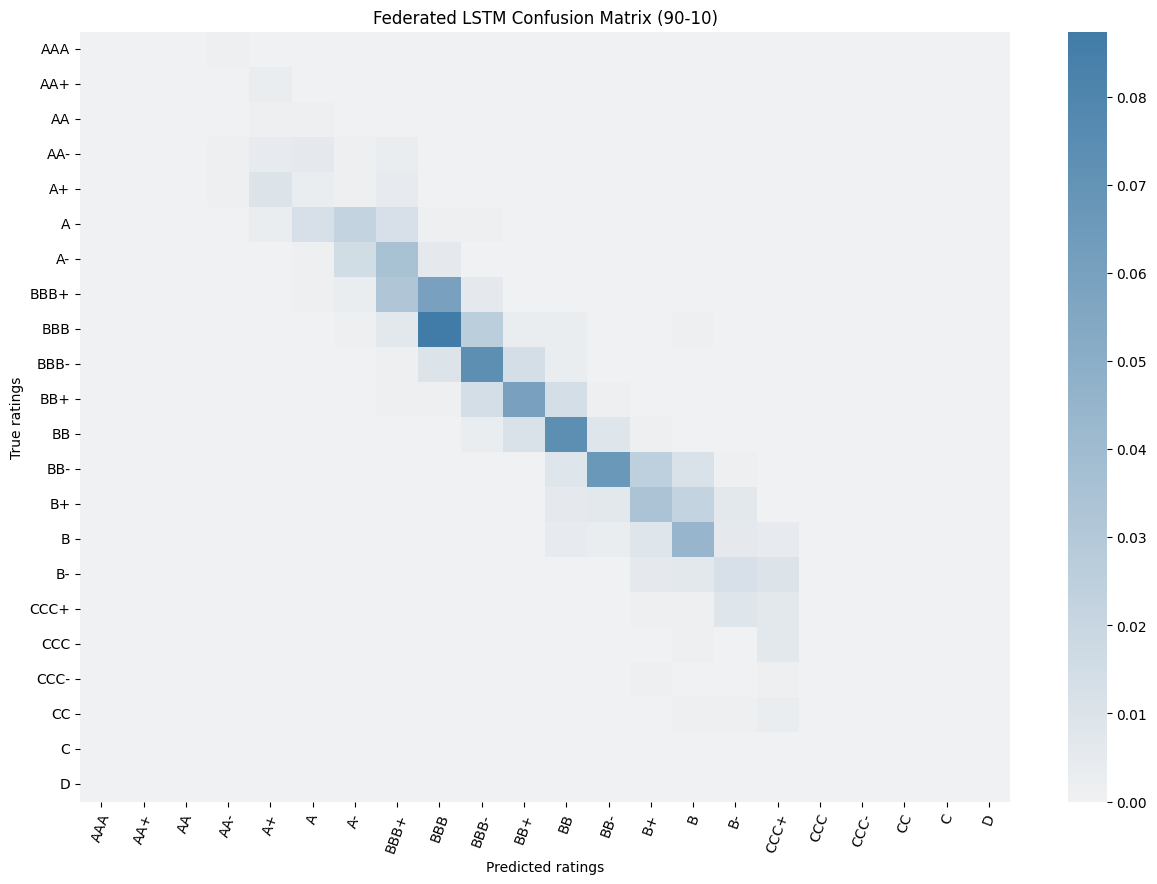

In [55]:
# 80-10-10
model_fl = run_lstm_simulation([0.8, 0.1, 0.1], 'split_80_10_10', 32, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 15:00:44,408 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=24574) Client 1 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=24574) Epoch: 32, Loss: 0.28503501415252686 [repeated 44x across cluster]


2023-06-15 15:00:48,098	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 15:00:48,653 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'memory': 8685253428.0}
INFO flwr 2023-06-15 15:00:48,653 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 15:00:48,654 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 15:00:49,462 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 15:00:49,462 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 15:00:49,463 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 15:00:49,463 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=24642) Epoch: 1, Loss: 40.23053741455078
(launch_and_fit pid=24642) Epoch: 2, Loss: 39.77542495727539
(launch_and_fit pid=24642) Epoch: 3, Loss: 36.390445709228516
(launch_and_fit pid=24642) Epoch: 4, Loss: 35.05600357055664
(launch_and_fit pid=24642) Epoch: 5, Loss: 42.72772216796875
(launch_and_fit pid=24642) Epoch: 6, Loss: 47.20439910888672
(launch_and_fit pid=24642) Epoch: 7, Loss: 35.44511795043945
(launch_and_fit pid=24642) Epoch: 8, Loss: 38.34046936035156
(launch_and_fit pid=24642) Epoch: 9, Loss: 29.830759048461914
(launch_and_fit pid=24642) Epoch: 10, Loss: 24.761066436767578


DEBUG flwr 2023-06-15 15:00:52,723 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:00:52,754 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:00:52,778 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:00:52,874 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:00:52,874 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:00:52,874 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=24642) Client 3 evaluate, config {}
(launch_and_fit pid=24642) Epoch: 19, Loss: 15.520255088806152 [repeated 92x across cluster]


DEBUG flwr 2023-06-15 15:00:55,721 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:00:55,746 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:00:55,829 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:00:55,829 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=24640) Client 3 evaluate, config {} [repeated 3x across cluster]


DEBUG flwr 2023-06-15 15:00:58,802 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:00:58,829 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:00:58,929 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:00:58,929 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...
(launch_and_fit pid=24642) Epoch: 7, Loss: 11.106197357177734 [repeated 103x across cluster]


DEBUG flwr 2023-06-15 15:01:01,863 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:01,893 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:01,986 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:01,986 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=24640) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=24642) Epoch: 28, Loss: 10.20532512664795 [repeated 109x across cluster]


DEBUG flwr 2023-06-15 15:01:05,026 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:05,050 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:05,145 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:05,146 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 15:01:08,036 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:08,059 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:08,156 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:08,157 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=24640) Client 1 evaluate, config {} [repeated 2x across cluster]
Saving round 6 aggregated_parameters...
(launch_and_fit pid=24642) Epoch: 16, Loss: 5.066004753112793 [repeated 102x across cluster]


DEBUG flwr 2023-06-15 15:01:11,334 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:11,362 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:11,454 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:11,455 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=24640) Client 1 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:01:14,637 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:14,670 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:14,758 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:14,758 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=24642) Epoch: 1, Loss: 5.55031156539917 [repeated 97x across cluster]


DEBUG flwr 2023-06-15 15:01:17,731 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:17,759 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:17,845 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:17,846 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=24640) Client 4 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=24642) Epoch: 23, Loss: 3.7239789962768555 [repeated 107x across cluster]


DEBUG flwr 2023-06-15 15:01:20,784 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:20,806 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:20,895 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:20,896 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=24640) Client 3 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:01:23,958 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:23,989 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:24,085 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:24,086 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=24642) Epoch: 9, Loss: 1.8832122087478638 [repeated 102x across cluster]


DEBUG flwr 2023-06-15 15:01:27,101 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:27,123 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:27,216 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:27,216 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=24640) Client 4 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=24642) Epoch: 31, Loss: 2.5759377479553223 [repeated 104x across cluster]


DEBUG flwr 2023-06-15 15:01:30,384 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:30,410 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:30,506 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:30,507 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=24640) Client 1 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:01:33,608 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:33,632 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:33,723 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:33,723 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...
(launch_and_fit pid=24642) Epoch: 14, Loss: 0.8711830973625183 [repeated 97x across cluster]


DEBUG flwr 2023-06-15 15:01:36,833 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:36,863 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:36,954 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:36,954 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=24640) Client 2 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:01:39,963 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:39,997 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:40,082 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:40,082 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...
(launch_and_fit pid=24642) Epoch: 1, Loss: 1.207899570465088 [repeated 102x across cluster]


DEBUG flwr 2023-06-15 15:01:43,073 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:43,096 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:43,187 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:43,188 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=24640) Client 3 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=24642) Epoch: 22, Loss: 0.5247424840927124 [repeated 108x across cluster]


DEBUG flwr 2023-06-15 15:01:46,206 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:46,231 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:46,319 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:46,320 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=24640) Client 0 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:01:49,447 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:49,470 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:49,560 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:49,561 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...
(launch_and_fit pid=24642) Epoch: 8, Loss: 0.7155487537384033 [repeated 97x across cluster]


DEBUG flwr 2023-06-15 15:01:52,768 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:01:52,795 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:01:52,890 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 15:01:52,891 | server.py:147 | FL finished in 63.427870084065944
INFO flwr 2023-06-15 15:01:52,892 | app.py:218 | app_fit: losses_distributed [(1, 88.40499306518724), (2, 72.66990291262135), (3, 71.43966712898752), (4, 71.40499306518724), (5, 17.780859916782248), (6, 17.79889042995839), (7, 17.77253814147018), (8, 17.66990291262136), (9, 17.764216366158113), (10, 1.0624133148404993), (11, 1.015256588072122), (12, 0.9805825242718447), (13, 1.0041608876560333), (14, 1.1872399445214978), (15, 1.0679611650485437), (16, 1.0610263522884882), (17, 1.0818307905686546), (18, 1.072122052704577), (19, 1.1775312066574202), (20, 1.0332871012482663)]
INFO flwr 2023-06-1

Saving round 20 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_20_20_20_20_20/model_round_20.pth
1.0332871012482663
0.0023430546513566125
0.9653349046430663
0.9663526244952894


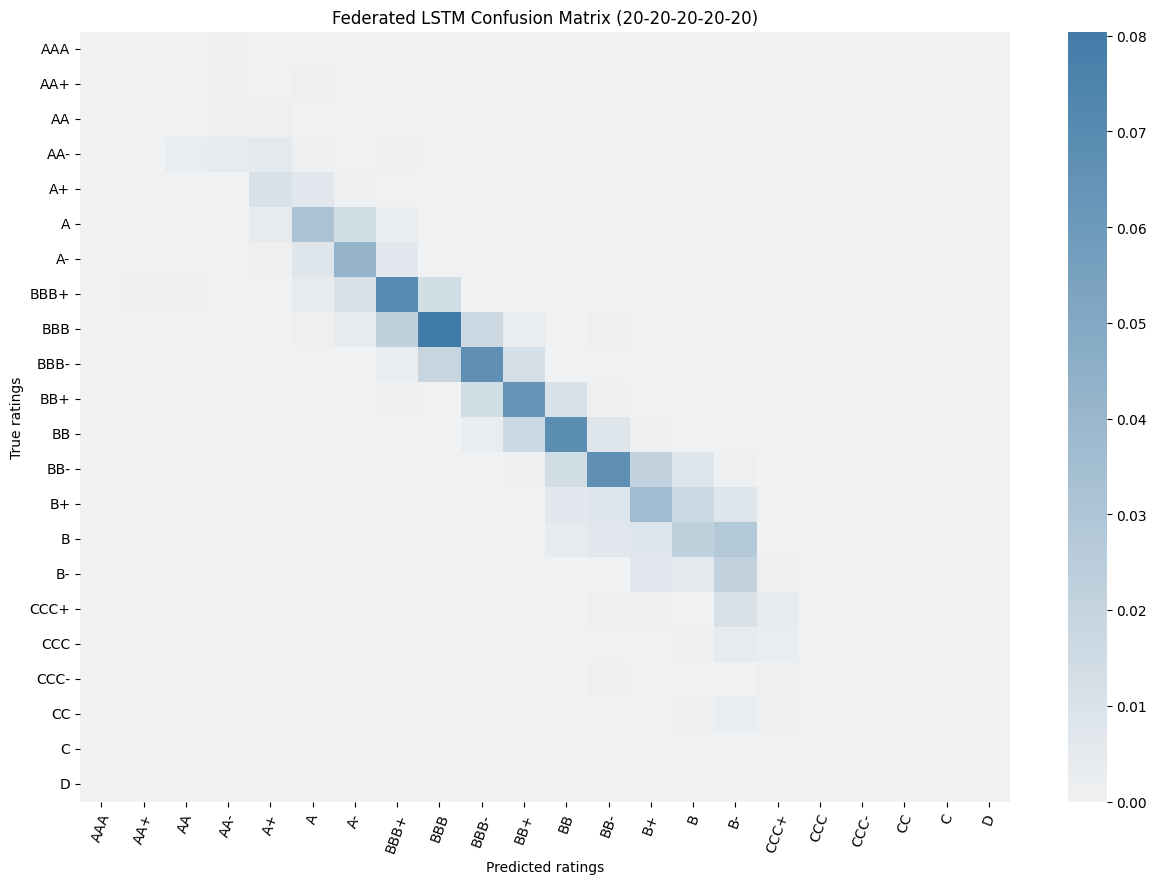

In [56]:
# 20-20-20-20-20
model_fl = run_lstm_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', 32, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (20-20-20-20-20)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 15:01:53,538 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=24640) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=24640) Epoch: 32, Loss: 1.0637764930725098 [repeated 50x across cluster]


2023-06-15 15:01:57,275	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 15:01:57,837 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'memory': 8651235328.0}
INFO flwr 2023-06-15 15:01:57,837 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 15:01:57,838 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 15:01:58,584 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 15:01:58,585 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 15:01:58,585 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 15:01:58,585 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=24670) Epoch: 1, Loss: 21.900123596191406
(launch_and_fit pid=24670) Epoch: 2, Loss: 25.441837310791016
(launch_and_fit pid=24670) Epoch: 3, Loss: 14.972635269165039
(launch_and_fit pid=24670) Epoch: 4, Loss: 27.052631378173828
(launch_and_fit pid=24670) Epoch: 5, Loss: 18.469640731811523
(launch_and_fit pid=24670) Epoch: 6, Loss: 23.87462043762207
(launch_and_fit pid=24670) Epoch: 7, Loss: 16.617483139038086
(launch_and_fit pid=24670) Epoch: 8, Loss: 22.518489837646484
(launch_and_fit pid=24670) Epoch: 9, Loss: 7.082014560699463
(launch_and_fit pid=24670) Epoch: 10, Loss: 16.397266387939453
(launch_and_fit pid=24670) Epoch: 11, Loss: 20.235759735107422
(launch_and_fit pid=24670) Epoch: 12, Loss: 23.95993423461914
(launch_and_fit pid=24670) Epoch: 13, Loss: 20.502506256103516
(launch_and_fit pid=24670) Epoch: 14, Loss: 7.058140754699707
(launch_and_fit pid=24670) Epoch: 15, Loss: 16.458724975585938
(launch_and_fit pid=24670) Epoch: 16, Loss: 17.572200775146484
(laun

DEBUG flwr 2023-06-15 15:02:00,749 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:02:00,770 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:02:00,798 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:00,907 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:02:00,907 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:02:00,908 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=24670) Client 0 evaluate, config {}


DEBUG flwr 2023-06-15 15:02:02,528 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:02,561 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:02,647 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:02,648 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...
(launch_and_fit pid=24670) Epoch: 22, Loss: 7.74191951751709 [repeated 149x across cluster]


DEBUG flwr 2023-06-15 15:02:04,295 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:04,322 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:04,413 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:04,413 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=24665) Client 3 evaluate, config {} [repeated 5x across cluster]
(launch_and_fit pid=24670) Epoch: 18, Loss: 7.8873372077941895 [repeated 74x across cluster]


DEBUG flwr 2023-06-15 15:02:12,116 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:12,139 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:12,230 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:12,230 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=24670) Client 0 evaluate, config {}


DEBUG flwr 2023-06-15 15:02:13,897 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:13,924 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:14,020 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:14,020 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=24670) Epoch: 32, Loss: 6.516788959503174 [repeated 75x across cluster]
Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 15:02:15,721 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:15,753 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:15,854 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:15,855 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=24665) Client 0 evaluate, config {} [repeated 5x across cluster]


DEBUG flwr 2023-06-15 15:02:17,517 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:17,541 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:17,628 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:17,628 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...
(launch_and_fit pid=24670) Epoch: 25, Loss: 0.847888708114624 [repeated 180x across cluster]


DEBUG flwr 2023-06-15 15:02:19,256 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:19,287 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:19,386 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:19,386 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=24665) Client 2 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=24670) Epoch: 17, Loss: 1.48215913772583 [repeated 64x across cluster]


DEBUG flwr 2023-06-15 15:02:27,654 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:27,692 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:27,787 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:27,787 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=24670) Client 3 evaluate, config {}
(launch_and_fit pid=24670) Epoch: 24, Loss: 0.19294624030590057 [repeated 61x across cluster]


DEBUG flwr 2023-06-15 15:02:29,520 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:29,550 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:29,643 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:29,643 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 15:02:31,416 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:31,455 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:31,554 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:31,555 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=24665) Client 2 evaluate, config {} [repeated 5x across cluster]


DEBUG flwr 2023-06-15 15:02:33,404 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:33,438 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:33,550 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:33,551 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...
(launch_and_fit pid=24670) Epoch: 9, Loss: 0.6969863176345825 [repeated 156x across cluster]
(launch_and_evaluate pid=24665) Client 4 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=24665) Epoch: 21, Loss: 1.9405328035354614 [repeated 43x across cluster]


DEBUG flwr 2023-06-15 15:02:42,003 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:42,037 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:42,125 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:42,126 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=24665) Client 3 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:02:43,932 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:43,960 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:44,049 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:44,049 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...
(launch_and_fit pid=24670) Epoch: 4, Loss: 2.3341376781463623 [repeated 81x across cluster]


DEBUG flwr 2023-06-15 15:02:45,999 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:46,053 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:46,149 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:46,149 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=24665) Client 1 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=24665) Epoch: 12, Loss: 1.5703654289245605 [repeated 102x across cluster]


DEBUG flwr 2023-06-15 15:02:54,173 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:54,198 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:54,295 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:54,296 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=24670) Client 1 evaluate, config {}
(launch_and_fit pid=24670) Epoch: 2, Loss: 0.4327070713043213 [repeated 22x across cluster]


DEBUG flwr 2023-06-15 15:02:56,000 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:56,024 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:02:56,111 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:02:56,111 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=24665) Client 3 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=24670) Epoch: 13, Loss: 1.0136171579360962 [repeated 107x across cluster]


DEBUG flwr 2023-06-15 15:03:04,012 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:03:04,050 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:03:04,153 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:03:04,154 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=24670) 
(launch_and_evaluate pid=24665) Client 4 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=24670) Epoch: 7, Loss: 0.4489389955997467 [repeated 30x across cluster]


DEBUG flwr 2023-06-15 15:03:05,836 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:03:05,864 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:03:05,961 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:03:05,961 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 15:03:07,610 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:03:07,635 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:03:07,733 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 15:03:07,734 | server.py:147 | FL finished in 69.1482304581441
INFO flwr 2023-06-15 15:03:07,735 | app.py:218 | app_fit: losses_distributed [(1, 72.43273231622746), (2, 71.69070735090152), (3, 71.41331484049931), (4, 71.39251040221914), (5, 71.39251040221914), (6, 10.47018030513176), (7, 1.2122052704576975), (8, 1.1664355062413314), (9, 1.0083217753120666), (10, 1.08876560332871), (11, 1.1081830790568654), (12, 1.1733703190013869), (13, 1.0416088765603329), (14, 1.0776699029126213), (15, 0.9750346740638003), (16, 1.0027739251040222), (17, 1.0638002773925104), (18, 0.9833564493758669), (19, 1.072122052704577), (20, 1.1872399445214978)]
INFO flwr 2023-06-15 

Saving round 20 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_60_10_10_10_10/model_round_20.pth
1.1872399445214978
0.0026921540692097456
0.970888406198971
0.971736204576043


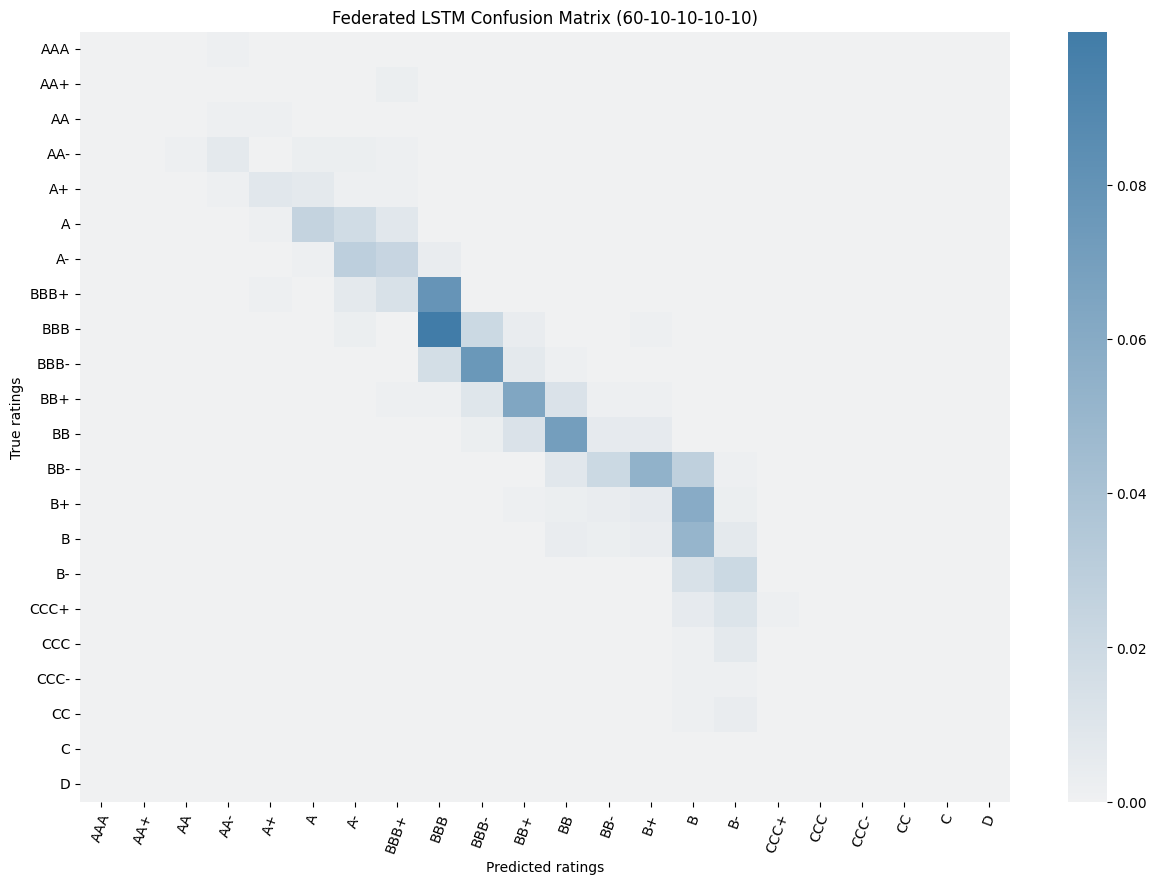

In [57]:
# 60-10-10-10-10
model_fl = run_lstm_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', 32, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (60-10-10-10-10)')

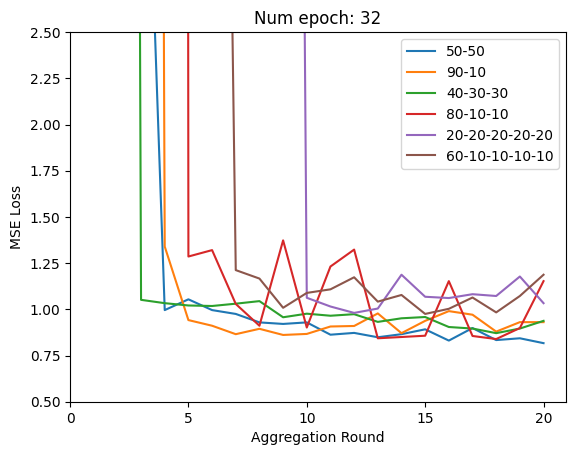

In [21]:
# Visualise loss convergence 32 epoch
ax = plt.gca()
ax.set_ylim([0.5, 2.5])
plot_loss([[(1, 56.794729542302356), (2, 56.79750346740638), (3, 4.633841886269071), (4, 0.9958391123439667), (5, 1.0540915395284327), (6, 0.9958391123439667), (7, 0.9750346740638003), (8, 0.9292649098474342), (9, 0.9209431345353676), (10, 0.9292649098474342), (11, 0.8626907073509015), (12, 0.8723994452149791), (13, 0.8488210818307905), (14, 0.8654646324549237), (15, 0.8918169209431346), (16, 0.8307905686546463), (17, 0.8987517337031901), (18, 0.8335644937586685), (19, 0.8432732316227461), (20, 0.8169209431345353)]
, [(1, 33.49237170596394), (2, 33.49237170596394), (3, 33.48543689320388), (4, 1.3398058252427185), (5, 0.941747572815534), (6, 0.9112343966712899), (7, 0.8654646324549237), (8, 0.8945908460471568), (9, 0.8613037447988904), (10, 0.8668515950069348), (11, 0.9070735090152566), (12, 0.9098474341192788), (13, 0.9778085991678225), (14, 0.871012482662968), (15, 0.9375866851595007), (16, 0.9902912621359223), (17, 0.970873786407767), (18, 0.8793342579750347), (19, 0.9306518723994452), (20, 0.9306518723994452)]
, [(1, 51.20249653259362), (2, 33.55617198335645), (3, 1.0513176144244105), (4, 1.0332871012482663), (5, 1.0208044382801664), (6, 1.0180305131761442), (7, 1.030513176144244), (8, 1.044382801664355), (9, 0.957004160887656), (10, 0.9764216366158114), (11, 0.9653259361997226), (12, 0.9736477115117892), (13, 0.9320388349514563), (14, 0.9514563106796117), (15, 0.9583911234396671), (16, 0.9042995839112344), (17, 0.8959778085991679), (18, 0.871012482662968), (19, 0.8959778085991679), (20, 0.9375866851595007)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 127.17337031900139), (5, 1.2857142857142858), (6, 1.3203883495145632), (7, 1.029126213592233), (8, 0.9112343966712899), (9, 1.3730929264909848), (10, 0.9015256588072122), (11, 1.2316227461858529), (12, 1.3231622746185854), (13, 0.8432732316227461), (14, 0.8502080443828016), (15, 0.8571428571428571), (16, 1.1525658807212205), (17, 0.855755894590846), (18, 0.8391123439667129), (19, 0.8987517337031901), (20, 1.1525658807212205)]
, [(1, 88.40499306518724), (2, 72.66990291262135), (3, 71.43966712898752), (4, 71.40499306518724), (5, 17.780859916782248), (6, 17.79889042995839), (7, 17.77253814147018), (8, 17.66990291262136), (9, 17.764216366158113), (10, 1.0624133148404993), (11, 1.015256588072122), (12, 0.9805825242718447), (13, 1.0041608876560333), (14, 1.1872399445214978), (15, 1.0679611650485437), (16, 1.0610263522884882), (17, 1.0818307905686546), (18, 1.072122052704577), (19, 1.1775312066574202), (20, 1.0332871012482663)]
, [(1, 72.43273231622746), (2, 71.69070735090152), (3, 71.41331484049931), (4, 71.39251040221914), (5, 71.39251040221914), (6, 10.47018030513176), (7, 1.2122052704576975), (8, 1.1664355062413314), (9, 1.0083217753120666), (10, 1.08876560332871), (11, 1.1081830790568654), (12, 1.1733703190013869), (13, 1.0416088765603329), (14, 1.0776699029126213), (15, 0.9750346740638003), (16, 1.0027739251040222), (17, 1.0638002773925104), (18, 0.9833564493758669), (19, 1.072122052704577), (20, 1.1872399445214978)]]
, start=0, title='Num epoch: 32')

#### 64 Epoch

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 15:03:08,287 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_evaluate pid=24665) Client 4 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=24665) Epoch: 32, Loss: 0.2392939180135727 [repeated 117x across cluster]


2023-06-15 15:03:12,443	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 15:03:12,994 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'memory': 8644245914.0, 'CPU': 8.0}
INFO flwr 2023-06-15 15:03:12,994 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 15:03:12,995 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 15:03:13,777 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 15:03:13,777 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 15:03:13,777 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 15:03:13,778 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=24701) Epoch: 1, Loss: 16.197872161865234
(launch_and_fit pid=24701) Epoch: 2, Loss: 21.950176239013672
(launch_and_fit pid=24701) Epoch: 3, Loss: 17.57033920288086
(launch_and_fit pid=24701) Epoch: 4, Loss: 12.925060272216797
(launch_and_fit pid=24701) Epoch: 23, Loss: 10.27437686920166 [repeated 39x across cluster]
(launch_and_fit pid=24701) Epoch: 47, Loss: 5.431126594543457 [repeated 48x across cluster]


DEBUG flwr 2023-06-15 15:03:28,086 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:03:28,119 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:03:28,140 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:03:28,263 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:03:28,263 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:03:28,264 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 0 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 4, Loss: 7.145565986633301 [repeated 45x across cluster]
(launch_and_evaluate pid=24696) Epoch: 21, Loss: 4.842358589172363
(launch_and_fit pid=24701) Epoch: 25, Loss: 5.544061183929443 [repeated 45x across cluster]
(launch_and_fit pid=24701) Epoch: 46, Loss: 2.595384120941162 [repeated 46x across cluster]


DEBUG flwr 2023-06-15 15:03:43,374 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:03:43,405 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:03:43,507 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:03:43,507 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 0 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 4, Loss: 0.6393648386001587 [repeated 36x across cluster]
(launch_and_evaluate pid=24696) Epoch: 22, Loss: 0.5068833827972412
(launch_and_fit pid=24701) Epoch: 27, Loss: 0.6489644646644592 [repeated 46x across cluster]
(launch_and_fit pid=24701) Epoch: 50, Loss: 0.3423139154911041 [repeated 47x across cluster]


DEBUG flwr 2023-06-15 15:03:57,867 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:03:57,891 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:03:57,980 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:03:57,981 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 1 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 8, Loss: 1.2435109615325928 [repeated 44x across cluster]
(launch_and_evaluate pid=24696) Epoch: 21, Loss: 0.4880712330341339
(launch_and_fit pid=24701) Epoch: 29, Loss: 0.5824249386787415 [repeated 44x across cluster]
(launch_and_fit pid=24696) Epoch: 55, Loss: 0.6513077616691589 [repeated 45x across cluster]


DEBUG flwr 2023-06-15 15:04:12,930 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:04:12,956 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:04:13,049 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:04:13,050 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 0 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 7, Loss: 0.1693909764289856 [repeated 37x across cluster]
(launch_and_evaluate pid=24696) Epoch: 21, Loss: 0.11729370057582855
(launch_and_fit pid=24701) Epoch: 28, Loss: 0.5457197427749634 [repeated 43x across cluster]
(launch_and_fit pid=24696) Epoch: 54, Loss: 0.3720811605453491 [repeated 46x across cluster]


DEBUG flwr 2023-06-15 15:04:28,283 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:04:28,332 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:04:28,449 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:04:28,450 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 1 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 7, Loss: 0.4824702739715576 [repeated 38x across cluster]
(launch_and_evaluate pid=24696) Epoch: 21, Loss: 0.514500617980957
(launch_and_fit pid=24696) Epoch: 29, Loss: 0.7236536741256714 [repeated 44x across cluster]
(launch_and_fit pid=24701) Epoch: 50, Loss: 0.32041144371032715 [repeated 43x across cluster]


DEBUG flwr 2023-06-15 15:04:43,333 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:04:43,359 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:04:43,452 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:04:43,452 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 0 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 7, Loss: 1.3321665525436401 [repeated 42x across cluster]
(launch_and_evaluate pid=24696) Epoch: 21, Loss: 0.13095739483833313
(launch_and_fit pid=24701) Epoch: 29, Loss: 0.2811566889286041 [repeated 45x across cluster]
(launch_and_fit pid=24701) Epoch: 50, Loss: 0.18606354296207428 [repeated 45x across cluster]


DEBUG flwr 2023-06-15 15:04:58,457 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:04:58,485 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:04:58,584 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:04:58,584 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 0 evaluate, config {}
(launch_and_fit pid=24696) Epoch: 8, Loss: 0.18698018789291382 [repeated 39x across cluster]
(launch_and_evaluate pid=24696) Epoch: 21, Loss: 0.3029707074165344
(launch_and_fit pid=24696) Epoch: 30, Loss: 0.4230310320854187 [repeated 43x across cluster]
(launch_and_fit pid=24701) Epoch: 51, Loss: 0.17433536052703857 [repeated 46x across cluster]


DEBUG flwr 2023-06-15 15:05:13,556 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:05:13,584 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:05:13,675 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:05:13,676 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 0 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 8, Loss: 0.2921907603740692 [repeated 39x across cluster]
(launch_and_evaluate pid=24696) Epoch: 20, Loss: 0.31293362379074097
(launch_and_fit pid=24696) Epoch: 30, Loss: 0.7698293328285217 [repeated 44x across cluster]
(launch_and_fit pid=24701) Epoch: 51, Loss: 0.3421177864074707 [repeated 43x across cluster]


DEBUG flwr 2023-06-15 15:05:28,890 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:05:28,936 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:05:29,043 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:05:29,043 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 0 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 7, Loss: 0.1008058413863182 [repeated 40x across cluster]
(launch_and_evaluate pid=24696) Epoch: 20, Loss: 1.2418937683105469
(launch_and_fit pid=24701) Epoch: 28, Loss: 0.32698798179626465 [repeated 44x across cluster]
(launch_and_fit pid=24701) Epoch: 51, Loss: 0.10287106782197952 [repeated 48x across cluster]


DEBUG flwr 2023-06-15 15:05:44,042 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:05:44,087 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:05:44,181 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:05:44,182 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 1 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 8, Loss: 1.0386563539505005 [repeated 38x across cluster]
(launch_and_evaluate pid=24696) Epoch: 21, Loss: 0.016573036089539528
(launch_and_fit pid=24701) Epoch: 29, Loss: 0.13674451410770416 [repeated 44x across cluster]
(launch_and_fit pid=24696) Epoch: 55, Loss: 0.4754403531551361 [repeated 45x across cluster]


DEBUG flwr 2023-06-15 15:05:59,239 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:05:59,267 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:05:59,358 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:05:59,359 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 1 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 7, Loss: 2.1172468662261963 [repeated 38x across cluster]
(launch_and_evaluate pid=24696) Epoch: 20, Loss: 0.28437668085098267
(launch_and_fit pid=24696) Epoch: 32, Loss: 0.06849385052919388 [repeated 44x across cluster]
(launch_and_fit pid=24696) Epoch: 56, Loss: 2.4246809482574463 [repeated 45x across cluster]


DEBUG flwr 2023-06-15 15:06:14,716 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:06:14,740 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:06:14,828 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:06:14,829 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 0 evaluate, config {}
(launch_and_fit pid=24696) Epoch: 7, Loss: 1.0966390371322632 [repeated 36x across cluster]
(launch_and_evaluate pid=24696) Epoch: 21, Loss: 0.09431564062833786
(launch_and_fit pid=24696) Epoch: 31, Loss: 0.229669451713562 [repeated 46x across cluster]
(launch_and_fit pid=24696) Epoch: 56, Loss: 1.5037903785705566 [repeated 48x across cluster]


DEBUG flwr 2023-06-15 15:06:29,361 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:06:29,402 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:06:29,516 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:06:29,517 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 1 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 9, Loss: 0.48638391494750977 [repeated 39x across cluster]
(launch_and_evaluate pid=24696) Epoch: 21, Loss: 0.2045917809009552
(launch_and_fit pid=24696) Epoch: 30, Loss: 0.44225066900253296 [repeated 44x across cluster]
(launch_and_fit pid=24701) Epoch: 55, Loss: 0.0912332683801651 [repeated 46x across cluster]


DEBUG flwr 2023-06-15 15:06:44,230 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:06:44,272 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:06:44,383 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:06:44,383 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 0 evaluate, config {}
(launch_and_fit pid=24696) Epoch: 10, Loss: 0.8047686219215393 [repeated 40x across cluster]
(launch_and_evaluate pid=24696) Epoch: 21, Loss: 0.022405501455068588
(launch_and_fit pid=24701) Epoch: 32, Loss: 0.19261276721954346 [repeated 46x across cluster]
(launch_and_fit pid=24696) Epoch: 58, Loss: 0.589004397392273 [repeated 47x across cluster]


DEBUG flwr 2023-06-15 15:06:58,957 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:06:58,985 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:06:59,075 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:06:59,075 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 1 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 12, Loss: 0.8022620677947998 [repeated 40x across cluster]
(launch_and_evaluate pid=24696) Epoch: 21, Loss: 0.1643366515636444
(launch_and_fit pid=24701) Epoch: 34, Loss: 0.44867023825645447 [repeated 44x across cluster]
(launch_and_fit pid=24701) Epoch: 56, Loss: 0.29684513807296753 [repeated 45x across cluster]


DEBUG flwr 2023-06-15 15:07:13,906 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:07:13,935 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:07:14,040 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:07:14,040 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 1 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 13, Loss: 0.08371614664793015 [repeated 41x across cluster]
(launch_and_evaluate pid=24696) Epoch: 22, Loss: 0.39154160022735596
(launch_and_fit pid=24701) Epoch: 35, Loss: 0.024271665140986443 [repeated 45x across cluster]
(launch_and_fit pid=24701) Epoch: 57, Loss: 0.08499051630496979 [repeated 46x across cluster]


DEBUG flwr 2023-06-15 15:07:28,895 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:07:28,939 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:07:29,057 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:07:29,058 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 1 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 13, Loss: 0.009219152852892876 [repeated 37x across cluster]
(launch_and_evaluate pid=24696) Epoch: 21, Loss: 0.21585088968276978
(launch_and_fit pid=24696) Epoch: 38, Loss: 0.2918279469013214 [repeated 46x across cluster]
(launch_and_fit pid=24701) Epoch: 56, Loss: 0.07599885016679764 [repeated 44x across cluster]


DEBUG flwr 2023-06-15 15:07:44,175 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:07:44,220 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:07:44,348 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:07:44,349 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 0 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 13, Loss: 0.010482078418135643 [repeated 38x across cluster]
(launch_and_evaluate pid=24696) Epoch: 20, Loss: 0.03839360550045967
(launch_and_fit pid=24696) Epoch: 35, Loss: 0.005230313632637262 [repeated 41x across cluster]
(launch_and_fit pid=24701) Epoch: 56, Loss: 0.2754770517349243 [repeated 47x across cluster]


DEBUG flwr 2023-06-15 15:07:59,579 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:07:59,632 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:07:59,753 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:07:59,754 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 1 evaluate, config {}
(launch_and_fit pid=24701) Epoch: 13, Loss: 0.4587411880493164 [repeated 40x across cluster]
(launch_and_fit pid=24701) 
(launch_and_evaluate pid=24696) Epoch: 21, Loss: 0.969952404499054
(launch_and_fit pid=24701) Epoch: 35, Loss: 0.7808112502098083 [repeated 45x across cluster]
(launch_and_fit pid=24701) Epoch: 58, Loss: 0.5534462928771973 [repeated 47x across cluster]


DEBUG flwr 2023-06-15 15:08:14,258 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:08:14,308 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:08:14,437 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 15:08:14,437 | server.py:147 | FL finished in 300.6588586671278
INFO flwr 2023-06-15 15:08:14,438 | app.py:218 | app_fit: losses_distributed [(1, 71.39667128987517), (2, 1.0360610263522885), (3, 1.0471567267683772), (4, 0.9667128987517337), (5, 0.9029126213592233), (6, 0.9916782246879334), (7, 0.9431345353675451), (8, 0.9680998613037448), (9, 0.9778085991678225), (10, 0.9625520110957004), (11, 0.9667128987517337), (12, 0.9875173370319001), (13, 0.9597780859916782), (14, 0.955617198335645), (15, 0.9958391123439667), (16, 1.0027739251040222), (17, 0.957004160887656), (18, 0.970873786407767), (19, 0.9528432732316228), (20, 0.9542302357836339)]
INFO flwr 2023-

Saving round 20 aggregated_parameters...
(launch_and_evaluate pid=24701) Client 0 evaluate, config {}
Loading pre-trained model from:  lstm_model_checkpoints/split_50_50/model_round_20.pth
0.9542302357836339
0.002163787382729328
0.9625581538651139
0.9636608344549125


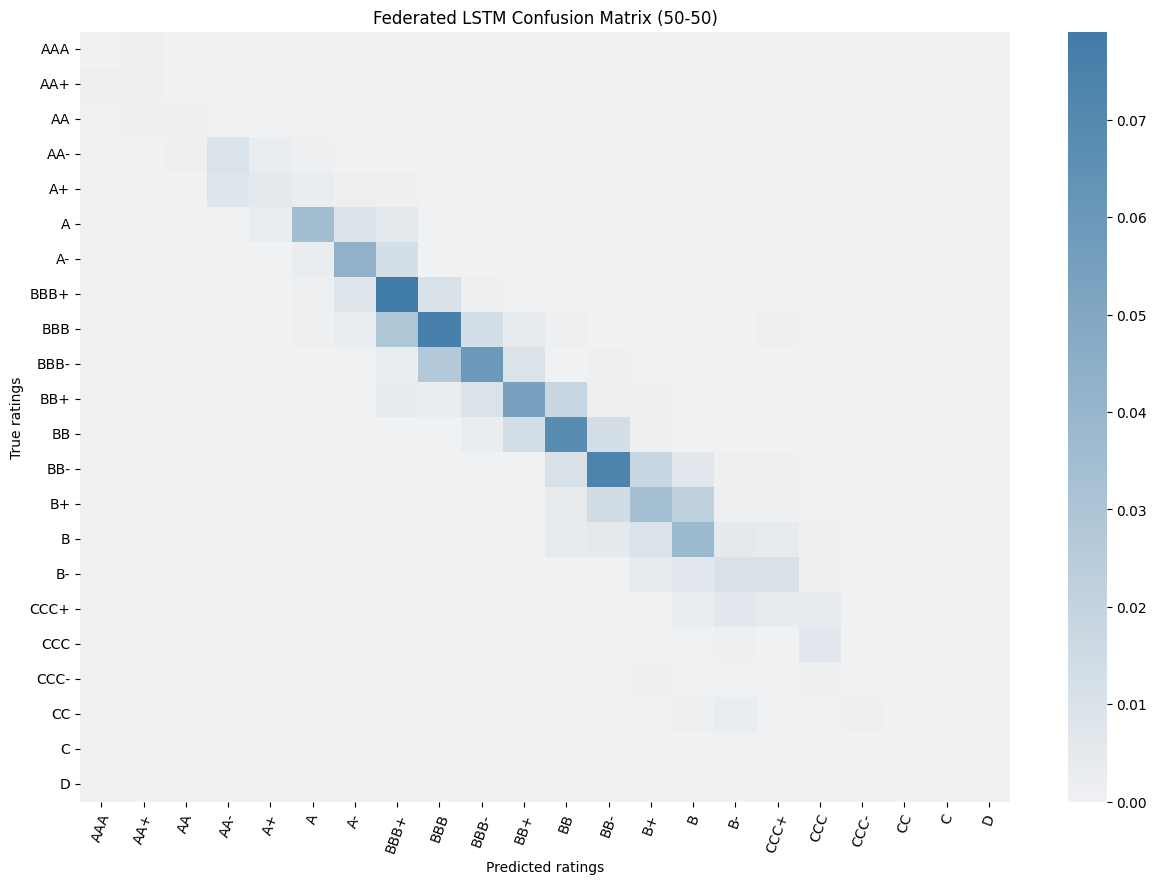

In [58]:
# 50-50
model_fl = run_lstm_simulation([0.5, 0.5], 'split_50_50', 64, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (50-50)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 15:08:15,018 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=24701) Epoch: 64, Loss: 0.5268280506134033 [repeated 10x across cluster]
(launch_and_evaluate pid=24696) Client 1 evaluate, config {}


2023-06-15 15:08:18,649	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 15:08:19,322 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'CPU': 8.0, 'memory': 8166164071.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-15 15:08:19,323 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 15:08:19,323 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 15:08:20,256 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 15:08:20,256 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 15:08:20,257 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 15:08:20,257 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=24746) Epoch: 1, Loss: 19.753910064697266
(launch_and_fit pid=24746) Epoch: 2, Loss: 9.531311988830566
(launch_and_fit pid=24746) Epoch: 14, Loss: 5.742324352264404 [repeated 76x across cluster]
(launch_and_fit pid=24746) Epoch: 28, Loss: 6.753415584564209 [repeated 14x across cluster]
(launch_and_fit pid=24746) Epoch: 42, Loss: 4.584432601928711 [repeated 14x across cluster]
(launch_and_fit pid=24746) Epoch: 56, Loss: 6.549912929534912 [repeated 14x across cluster]


DEBUG flwr 2023-06-15 15:08:44,425 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:08:44,453 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:08:44,479 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:08:44,589 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:08:44,589 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:08:44,590 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 0 evaluate, config {}
(launch_and_fit pid=24746) Epoch: 32, Loss: 3.880293607711792 [repeated 43x across cluster]
(launch_and_evaluate pid=24744) Epoch: 13, Loss: 0.916664183139801
(launch_and_fit pid=24744) Epoch: 19, Loss: 0.6090807914733887 [repeated 48x across cluster]
(launch_and_fit pid=24744) Epoch: 34, Loss: 1.4702668190002441 [repeated 15x across cluster]
(launch_and_fit pid=24744) Epoch: 50, Loss: 0.3359915018081665 [repeated 16x across cluster]


DEBUG flwr 2023-06-15 15:09:06,742 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:09:06,776 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:09:06,888 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:09:06,889 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 0 evaluate, config {}
(launch_and_fit pid=24746) Epoch: 4, Loss: 0.9067476987838745 [repeated 18x across cluster]
(launch_and_evaluate pid=24744) Epoch: 13, Loss: 0.11607944965362549
(launch_and_fit pid=24744) Epoch: 14, Loss: 0.1939765363931656 [repeated 74x across cluster]
(launch_and_fit pid=24744) Epoch: 29, Loss: 0.9036158323287964 [repeated 15x across cluster]
(launch_and_fit pid=24744) Epoch: 44, Loss: 0.22450129687786102 [repeated 15x across cluster]
(launch_and_fit pid=24744) Epoch: 59, Loss: 0.19196641445159912 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 15:09:29,889 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:09:29,923 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:09:30,015 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:09:30,015 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 1 evaluate, config {}
(launch_and_fit pid=24744) Epoch: 62, Loss: 0.16068895161151886 [repeated 74x across cluster]
(launch_and_evaluate pid=24744) Epoch: 13, Loss: 0.15424594283103943
(launch_and_fit pid=24746) Epoch: 21, Loss: 0.5752705335617065 [repeated 16x across cluster]
(launch_and_fit pid=24746) Epoch: 35, Loss: 0.14887982606887817 [repeated 14x across cluster]
(launch_and_fit pid=24746) Epoch: 49, Loss: 0.37784600257873535 [repeated 14x across cluster]
(launch_and_fit pid=24746) Epoch: 63, Loss: 0.5619661211967468 [repeated 14x across cluster]


DEBUG flwr 2023-06-15 15:09:54,385 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:09:54,419 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:09:54,506 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:09:54,507 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 1 evaluate, config {}
(launch_and_fit pid=24746) Epoch: 12, Loss: 0.07642936706542969 [repeated 77x across cluster]
(launch_and_evaluate pid=24744) Epoch: 13, Loss: 1.5145150423049927
(launch_and_fit pid=24746) Epoch: 26, Loss: 0.39028486609458923 [repeated 14x across cluster]
(launch_and_fit pid=24746) Epoch: 40, Loss: 1.4747445583343506 [repeated 14x across cluster]
(launch_and_fit pid=24746) Epoch: 54, Loss: 2.443397283554077 [repeated 14x across cluster]


DEBUG flwr 2023-06-15 15:10:18,775 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:10:18,804 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:10:18,906 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:10:18,906 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 1 evaluate, config {}
(launch_and_fit pid=24746) Epoch: 19, Loss: 0.08962475508451462 [repeated 31x across cluster]
(launch_and_evaluate pid=24744) Epoch: 13, Loss: 0.29445138573646545
(launch_and_fit pid=24744) Epoch: 16, Loss: 0.522955060005188 [repeated 59x across cluster]
(launch_and_fit pid=24744) Epoch: 30, Loss: 0.3225467801094055 [repeated 14x across cluster]
(launch_and_fit pid=24744) Epoch: 44, Loss: 0.145894393324852 [repeated 14x across cluster]
(launch_and_fit pid=24744) Epoch: 58, Loss: 0.5345491766929626 [repeated 14x across cluster]


DEBUG flwr 2023-06-15 15:10:42,823 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:10:42,848 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:10:42,944 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:10:42,944 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 0 evaluate, config {}
(launch_and_fit pid=24746) Epoch: 53, Loss: 1.3513087034225464 [repeated 65x across cluster]
(launch_and_evaluate pid=24744) Epoch: 13, Loss: 0.09430176764726639
(launch_and_fit pid=24744) Epoch: 22, Loss: 0.5889472961425781 [repeated 27x across cluster]
(launch_and_fit pid=24744) Epoch: 37, Loss: 0.4928402006626129 [repeated 15x across cluster]
(launch_and_fit pid=24744) Epoch: 52, Loss: 0.45347583293914795 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 15:11:05,898 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:11:05,925 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:11:06,018 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:11:06,018 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 0 evaluate, config {}
(launch_and_fit pid=24744) Epoch: 14, Loss: 1.7468723058700562 [repeated 27x across cluster]
(launch_and_evaluate pid=24744) Epoch: 13, Loss: 0.34585708379745483
(launch_and_fit pid=24746) Epoch: 15, Loss: 0.04072977229952812 [repeated 64x across cluster]
(launch_and_fit pid=24746) Epoch: 28, Loss: 0.2318151593208313 [repeated 13x across cluster]
(launch_and_fit pid=24746) Epoch: 42, Loss: 0.19247587025165558 [repeated 14x across cluster]
(launch_and_fit pid=24746) Epoch: 56, Loss: 0.034455664455890656 [repeated 14x across cluster]


DEBUG flwr 2023-06-15 15:11:30,110 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:11:30,142 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:11:30,276 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:11:30,277 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 1 evaluate, config {}
(launch_and_fit pid=24746) Epoch: 40, Loss: 2.131948709487915 [repeated 52x across cluster]
(launch_and_evaluate pid=24744) Epoch: 13, Loss: 0.6448794603347778
(launch_and_fit pid=24744) Epoch: 19, Loss: 0.298919677734375 [repeated 39x across cluster]
(launch_and_fit pid=24744) Epoch: 34, Loss: 1.5630826950073242 [repeated 15x across cluster]
(launch_and_fit pid=24744) Epoch: 49, Loss: 0.6918110847473145 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 15:11:52,766 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:11:52,803 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:11:52,894 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:11:52,894 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 1 evaluate, config {}
(launch_and_fit pid=24744) Epoch: 63, Loss: 0.003135932143777609 [repeated 14x across cluster]
(launch_and_evaluate pid=24744) Epoch: 13, Loss: 0.00560246454551816
(launch_and_fit pid=24746) Epoch: 13, Loss: 0.00560246454551816 [repeated 78x across cluster]
(launch_and_fit pid=24746) Epoch: 27, Loss: 0.2745521366596222 [repeated 14x across cluster]
(launch_and_fit pid=24746) Epoch: 41, Loss: 0.2957356572151184 [repeated 14x across cluster]
(launch_and_fit pid=24746) Epoch: 56, Loss: 0.16698595881462097 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 15:12:16,126 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:12:16,159 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:12:16,257 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:12:16,257 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 0 evaluate, config {}
(launch_and_fit pid=24746) Epoch: 44, Loss: 1.1743192672729492 [repeated 57x across cluster]
(launch_and_evaluate pid=24744) Epoch: 13, Loss: 0.9634479284286499
(launch_and_fit pid=24744) Epoch: 19, Loss: 0.007807875517755747 [repeated 34x across cluster]
(launch_and_fit pid=24744) Epoch: 34, Loss: 0.2477215826511383 [repeated 15x across cluster]
(launch_and_fit pid=24744) Epoch: 49, Loss: 0.10052952170372009 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 15:12:39,309 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:12:39,346 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:12:39,459 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:12:39,460 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=24744) Epoch: 64, Loss: 0.2569969892501831 [repeated 15x across cluster]
(launch_and_evaluate pid=24746) Client 1 evaluate, config {}
(launch_and_fit pid=24744) Epoch: 14, Loss: 0.05568574368953705 [repeated 78x across cluster]
(launch_and_evaluate pid=24744) Epoch: 14, Loss: 0.05568574368953705
(launch_and_fit pid=24744) Epoch: 29, Loss: 0.002186127007007599 [repeated 15x across cluster]
(launch_and_fit pid=24744) Epoch: 44, Loss: 1.0138542652130127 [repeated 15x across cluster]
(launch_and_fit pid=24744) Epoch: 59, Loss: 0.0024270371068269014 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 15:13:01,549 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:13:01,596 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:13:01,717 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:13:01,717 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 1 evaluate, config {}
(launch_and_fit pid=24746) Epoch: 8, Loss: 0.054607778787612915 [repeated 77x across cluster]
(launch_and_evaluate pid=24744) Epoch: 13, Loss: 0.15432584285736084
(launch_and_fit pid=24746) Epoch: 21, Loss: 1.58421790599823 [repeated 13x across cluster]
(launch_and_fit pid=24746) Epoch: 35, Loss: 0.1496855467557907 [repeated 14x across cluster]
(launch_and_fit pid=24746) Epoch: 49, Loss: 0.21631483733654022 [repeated 14x across cluster]


DEBUG flwr 2023-06-15 15:13:26,051 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:13:26,076 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:13:26,169 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:13:26,170 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...
(launch_and_fit pid=24746) Epoch: 64, Loss: 0.2756393849849701 [repeated 15x across cluster]
(launch_and_evaluate pid=24746) Client 1 evaluate, config {}
(launch_and_fit pid=24744) Epoch: 14, Loss: 0.33495810627937317 [repeated 78x across cluster]
(launch_and_evaluate pid=24744) Epoch: 14, Loss: 0.33495810627937317
(launch_and_fit pid=24744) Epoch: 30, Loss: 0.1274576485157013 [repeated 16x across cluster]
(launch_and_fit pid=24744) Epoch: 46, Loss: 0.003574275178834796 [repeated 16x across cluster]
(launch_and_fit pid=24744) Epoch: 62, Loss: 0.09896213561296463 [repeated 16x across cluster]


DEBUG flwr 2023-06-15 15:13:47,324 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:13:47,360 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:13:47,460 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:13:47,460 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 0 evaluate, config {}
(launch_and_fit pid=24746) Epoch: 11, Loss: 0.007626582868397236 [repeated 77x across cluster]
(launch_and_evaluate pid=24744) Epoch: 12, Loss: 0.002442670986056328
(launch_and_fit pid=24746) Epoch: 24, Loss: 0.19455526769161224 [repeated 13x across cluster]
(launch_and_fit pid=24746) Epoch: 37, Loss: 0.05218972638249397 [repeated 13x across cluster]
(launch_and_fit pid=24746) Epoch: 50, Loss: 0.4347289502620697 [repeated 13x across cluster]


DEBUG flwr 2023-06-15 15:14:12,452 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:14:12,483 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:14:12,598 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:14:12,598 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=24746) Epoch: 64, Loss: 0.0019581993110477924 [repeated 14x across cluster]
Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 0 evaluate, config {}
(launch_and_fit pid=24746) Epoch: 12, Loss: 0.1811075210571289 [repeated 76x across cluster]
(launch_and_evaluate pid=24744) Epoch: 13, Loss: 0.23179945349693298
(launch_and_fit pid=24746) Epoch: 26, Loss: 0.003606388345360756 [repeated 14x across cluster]
(launch_and_fit pid=24746) Epoch: 40, Loss: 0.11696331948041916 [repeated 14x across cluster]
(launch_and_fit pid=24746) Epoch: 53, Loss: 0.08729587495326996 [repeated 13x across cluster]


DEBUG flwr 2023-06-15 15:14:36,976 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:14:37,015 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:14:37,122 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:14:37,123 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 0 evaluate, config {}
(launch_and_fit pid=24744) Epoch: 21, Loss: 0.11026997864246368 [repeated 34x across cluster]
(launch_and_evaluate pid=24744) Epoch: 13, Loss: 0.436893105506897
(launch_and_fit pid=24746) Epoch: 16, Loss: 0.004300594329833984 [repeated 57x across cluster]
(launch_and_fit pid=24746) Epoch: 30, Loss: 0.048148706555366516 [repeated 14x across cluster]
(launch_and_fit pid=24746) Epoch: 44, Loss: 0.018356606364250183 [repeated 14x across cluster]
(launch_and_fit pid=24746) Epoch: 58, Loss: 0.15835867822170258 [repeated 14x across cluster]


DEBUG flwr 2023-06-15 15:15:01,528 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:15:01,555 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:15:01,685 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:15:01,686 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 1 evaluate, config {}
(launch_and_fit pid=24746) Epoch: 6, Loss: 0.09400836378335953 [repeated 68x across cluster]
(launch_and_evaluate pid=24744) Epoch: 13, Loss: 1.9715070724487305
(launch_and_fit pid=24746) Epoch: 20, Loss: 0.08380374312400818 [repeated 22x across cluster]
(launch_and_fit pid=24746) Epoch: 35, Loss: 0.1681625247001648 [repeated 15x across cluster]
(launch_and_fit pid=24746) Epoch: 50, Loss: 0.016371794044971466 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 15:15:25,118 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:15:25,142 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:15:25,237 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:15:25,238 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 0 evaluate, config {}
(launch_and_fit pid=24746) Epoch: 1, Loss: 1.3608717918395996 [repeated 15x across cluster]
(launch_and_evaluate pid=24744) Epoch: 14, Loss: 0.001969672739505768
(launch_and_fit pid=24744) Epoch: 15, Loss: 0.004142384044826031 [repeated 78x across cluster]
(launch_and_fit pid=24744) Epoch: 31, Loss: 0.00117387471254915 [repeated 16x across cluster]
(launch_and_fit pid=24744) 
(launch_and_fit pid=24744) Epoch: 47, Loss: 0.6037629842758179 [repeated 16x across cluster]
(launch_and_fit pid=24744) Epoch: 63, Loss: 0.011601043865084648 [repeated 16x across cluster]


DEBUG flwr 2023-06-15 15:15:46,213 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:15:46,250 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:15:46,358 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:15:46,358 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 1 evaluate, config {}
(launch_and_fit pid=24744) Epoch: 13, Loss: 0.8536654114723206 [repeated 78x across cluster]
(launch_and_evaluate pid=24744) Epoch: 14, Loss: 0.13068710267543793
(launch_and_fit pid=24744) Epoch: 29, Loss: 0.6608846187591553 [repeated 16x across cluster]
(launch_and_fit pid=24744) Epoch: 45, Loss: 0.14038273692131042 [repeated 16x across cluster]
(launch_and_fit pid=24744) Epoch: 61, Loss: 0.0012450107606127858 [repeated 16x across cluster]


DEBUG flwr 2023-06-15 15:16:07,676 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:16:07,707 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:16:07,810 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 15:16:07,811 | server.py:147 | FL finished in 467.53415249986574
INFO flwr 2023-06-15 15:16:07,812 | app.py:218 | app_fit: losses_distributed [(1, 56.793342579750345), (2, 1.013869625520111), (3, 0.941747572815534), (4, 0.9680998613037448), (5, 0.8959778085991679), (6, 0.8793342579750347), (7, 0.912621359223301), (8, 0.9015256588072122), (9, 0.8807212205270458), (10, 0.9070735090152566), (11, 0.9375866851595007), (12, 0.9140083217753121), (13, 0.9140083217753121), (14, 0.9167822468793343), (15, 0.9112343966712899), (16, 0.9209431345353676), (17, 0.9403606102635229), (18, 0.9459084604715673), (19, 1.1137309292649098), (20, 1.0790568654646324)]
INFO flwr 202

Saving round 20 aggregated_parameters...
(launch_and_evaluate pid=24746) Client 0 evaluate, config {}
Loading pre-trained model from:  lstm_model_checkpoints/split_90_10/model_round_20.pth
1.0790568654646324
0.002446840964772409
0.9581715808608313
0.9598930481283423


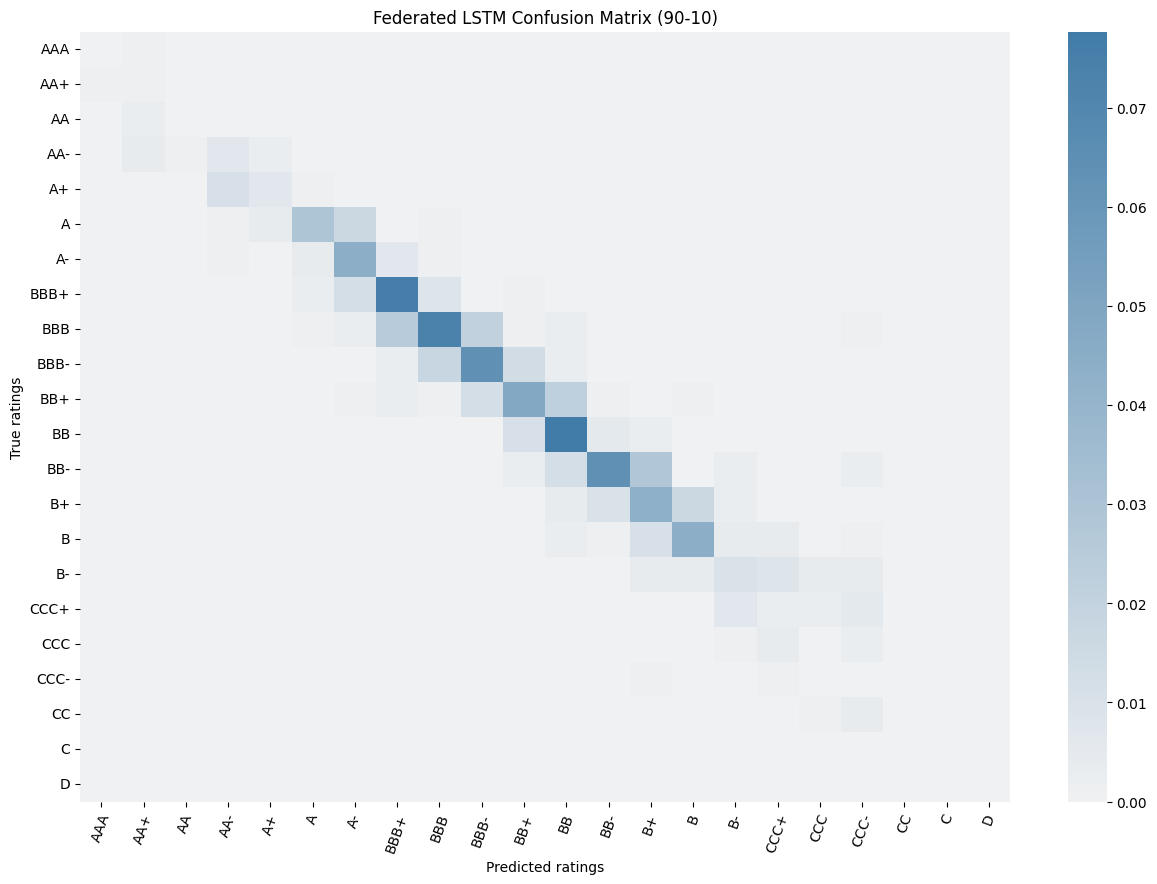

In [59]:
# 90-10
model_fl = run_lstm_simulation([0.9, 0.1], 'split_90_10', 64, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 15:16:08,392 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=24744) Epoch: 64, Loss: 0.08110499382019043 [repeated 3x across cluster]
(launch_and_evaluate pid=24744) Client 1 evaluate, config {}


2023-06-15 15:16:12,290	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 15:16:12,835 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 8446920295.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0}
INFO flwr 2023-06-15 15:16:12,835 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 15:16:12,836 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 15:16:13,658 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 15:16:13,659 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 15:16:13,659 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 15:16:13,659 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=24809) Epoch: 1, Loss: 10.50443172454834
(launch_and_fit pid=24809) Epoch: 2, Loss: 23.344924926757812
(launch_and_fit pid=24809) Epoch: 3, Loss: 12.805671691894531
(launch_and_fit pid=24809) Epoch: 4, Loss: 13.603967666625977
(launch_and_fit pid=24809) Epoch: 5, Loss: 15.76298713684082
(launch_and_fit pid=24809) Epoch: 6, Loss: 15.924386978149414
(launch_and_fit pid=24808) Epoch: 35, Loss: 3.7015957832336426 [repeated 68x across cluster]


DEBUG flwr 2023-06-15 15:16:22,829 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:16:22,854 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:16:22,874 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:16:22,980 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:16:22,980 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:16:22,981 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 1 evaluate, config {}
(launch_and_fit pid=24809) Epoch: 6, Loss: 3.9186902046203613 [repeated 64x across cluster]
(launch_and_evaluate pid=24808) Epoch: 28, Loss: 14.541644096374512
(launch_and_fit pid=24809) Epoch: 41, Loss: 4.898554801940918 [repeated 64x across cluster]


DEBUG flwr 2023-06-15 15:16:34,162 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:16:34,196 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=24808) Epoch: 63, Loss: 6.538820266723633 [repeated 53x across cluster]
Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 15:16:34,289 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:16:34,289 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=24809) Client 2 evaluate, config {}
(launch_and_fit pid=24808) Epoch: 34, Loss: 5.1776442527771 [repeated 68x across cluster]
(launch_and_evaluate pid=24808) Epoch: 36, Loss: 4.660745620727539


DEBUG flwr 2023-06-15 15:16:43,124 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:16:43,148 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:16:43,243 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:16:43,243 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 0 evaluate, config {}
(launch_and_fit pid=24809) Epoch: 4, Loss: 4.295496940612793 [repeated 69x across cluster]
(launch_and_evaluate pid=24808) Epoch: 29, Loss: 0.8626812696456909
(launch_and_fit pid=24809) Epoch: 34, Loss: 1.479541540145874 [repeated 66x across cluster]


DEBUG flwr 2023-06-15 15:16:54,109 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:16:54,132 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:16:54,231 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:16:54,231 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...
(launch_and_fit pid=24809) Epoch: 64, Loss: 1.2719035148620605 [repeated 54x across cluster]
(launch_and_evaluate pid=24809) Client 2 evaluate, config {}
(launch_and_fit pid=24809) Epoch: 37, Loss: 0.4721628427505493 [repeated 75x across cluster]
(launch_and_evaluate pid=24808) Epoch: 37, Loss: 0.4721628427505493


DEBUG flwr 2023-06-15 15:17:02,741 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:17:02,766 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:17:02,853 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:17:02,854 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 0 evaluate, config {}
(launch_and_fit pid=24808) Epoch: 9, Loss: 1.5877580642700195 [repeated 69x across cluster]
(launch_and_evaluate pid=24808) Epoch: 28, Loss: 1.429306149482727
(launch_and_fit pid=24809) Epoch: 36, Loss: 0.9607648253440857 [repeated 64x across cluster]


DEBUG flwr 2023-06-15 15:17:13,988 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:17:14,014 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:17:14,100 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:17:14,101 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 1 evaluate, config {}
(launch_and_fit pid=24808) Epoch: 1, Loss: 1.2926490306854248 [repeated 49x across cluster]
(launch_and_evaluate pid=24808) Epoch: 27, Loss: 1.1046240329742432
(launch_and_fit pid=24809) Epoch: 28, Loss: 0.9382567405700684 [repeated 64x across cluster]
(launch_and_fit pid=24809) Epoch: 51, Loss: 0.6313866376876831 [repeated 50x across cluster]


DEBUG flwr 2023-06-15 15:17:26,488 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:17:26,533 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:17:26,646 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:17:26,647 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 1 evaluate, config {}
(launch_and_fit pid=24809) Epoch: 19, Loss: 2.4213380813598633 [repeated 46x across cluster]
(launch_and_evaluate pid=24808) Epoch: 36, Loss: 0.07568047195672989
(launch_and_fit pid=24809) Epoch: 55, Loss: 0.4791524410247803 [repeated 64x across cluster]


DEBUG flwr 2023-06-15 15:17:38,093 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:17:38,131 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:17:38,231 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:17:38,232 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 1 evaluate, config {}
(launch_and_fit pid=24809) Epoch: 6, Loss: 1.776857614517212 [repeated 45x across cluster]
(launch_and_evaluate pid=24808) Epoch: 35, Loss: 1.012963891029358
(launch_and_fit pid=24809) Epoch: 33, Loss: 0.7923686504364014 [repeated 63x across cluster]
(launch_and_fit pid=24809) Epoch: 61, Loss: 4.014431953430176 [repeated 48x across cluster]


DEBUG flwr 2023-06-15 15:17:50,144 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:17:50,176 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:17:50,274 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:17:50,275 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 2 evaluate, config {}
(launch_and_fit pid=24808) Epoch: 26, Loss: 0.30689969658851624 [repeated 59x across cluster]
(launch_and_evaluate pid=24808) Epoch: 34, Loss: 0.07993194460868835
(launch_and_fit pid=24808) Epoch: 56, Loss: 1.325305700302124 [repeated 64x across cluster]


DEBUG flwr 2023-06-15 15:18:00,997 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:18:01,023 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:18:01,131 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:18:01,132 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 0 evaluate, config {}
(launch_and_fit pid=24809) Epoch: 20, Loss: 0.8620626330375671 [repeated 54x across cluster]
(launch_and_evaluate pid=24808) Epoch: 27, Loss: 3.942439317703247
(launch_and_fit pid=24809) Epoch: 48, Loss: 0.34924519062042236 [repeated 64x across cluster]


DEBUG flwr 2023-06-15 15:18:12,390 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:18:12,424 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:18:12,529 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:18:12,529 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 2 evaluate, config {}
(launch_and_fit pid=24809) Epoch: 16, Loss: 0.13780581951141357 [repeated 46x across cluster]
(launch_and_evaluate pid=24808) Epoch: 34, Loss: 0.28875792026519775
(launch_and_fit pid=24809) Epoch: 51, Loss: 0.6675529479980469 [repeated 62x across cluster]


DEBUG flwr 2023-06-15 15:18:23,765 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:18:23,797 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:18:23,894 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:18:23,894 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 2 evaluate, config {}
(launch_and_fit pid=24809) Epoch: 7, Loss: 0.08397868275642395 [repeated 50x across cluster]
(launch_and_evaluate pid=24808) Epoch: 35, Loss: 0.16106955707073212
(launch_and_fit pid=24809) Epoch: 43, Loss: 0.8788085579872131 [repeated 63x across cluster]
(launch_and_fit pid=24808) Epoch: 62, Loss: 0.40438079833984375 [repeated 51x across cluster]


DEBUG flwr 2023-06-15 15:18:35,451 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:18:35,479 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:18:35,579 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:18:35,580 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 0 evaluate, config {}
(launch_and_fit pid=24809) Epoch: 33, Loss: 0.021187596023082733 [repeated 59x across cluster]
(launch_and_evaluate pid=24808) Epoch: 36, Loss: 0.588637113571167
(launch_and_fit pid=24808) Epoch: 52, Loss: 0.20161066949367523 [repeated 59x across cluster]


DEBUG flwr 2023-06-15 15:18:47,121 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:18:47,148 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:18:47,239 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:18:47,239 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 2 evaluate, config {}
(launch_and_fit pid=24808) 
(launch_and_fit pid=24809) Epoch: 19, Loss: 0.40252840518951416 [repeated 47x across cluster]
(launch_and_evaluate pid=24808) Epoch: 33, Loss: 0.34433820843696594
(launch_and_fit pid=24809) Epoch: 52, Loss: 1.937345266342163 [repeated 61x across cluster]


DEBUG flwr 2023-06-15 15:18:58,240 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:18:58,263 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:18:58,362 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:18:58,362 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 2 evaluate, config {}
(launch_and_fit pid=24809) Epoch: 12, Loss: 0.19197526574134827 [repeated 56x across cluster]
(launch_and_evaluate pid=24808) Epoch: 34, Loss: 0.39978498220443726
(launch_and_fit pid=24809) Epoch: 47, Loss: 0.013240338303148746 [repeated 72x across cluster]


DEBUG flwr 2023-06-15 15:19:07,569 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:19:07,592 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:19:07,683 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:19:07,684 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 1 evaluate, config {}
(launch_and_fit pid=24809) Epoch: 17, Loss: 0.03190882131457329 [repeated 66x across cluster]
(launch_and_evaluate pid=24808) Epoch: 34, Loss: 1.0233194828033447
(launch_and_fit pid=24809) Epoch: 51, Loss: 0.47124183177948 [repeated 71x across cluster]


DEBUG flwr 2023-06-15 15:19:17,177 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:19:17,207 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:19:17,301 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:19:17,302 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 2 evaluate, config {}
(launch_and_fit pid=24808) Epoch: 21, Loss: 0.03291189298033714 [repeated 63x across cluster]
(launch_and_evaluate pid=24808) Epoch: 33, Loss: 0.3585526645183563
(launch_and_fit pid=24809) Epoch: 54, Loss: 0.49643799662590027 [repeated 71x across cluster]


DEBUG flwr 2023-06-15 15:19:26,699 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:19:26,724 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:19:26,814 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:19:26,814 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 0 evaluate, config {}
(launch_and_fit pid=24809) Epoch: 24, Loss: 0.3132181465625763 [repeated 59x across cluster]
(launch_and_evaluate pid=24808) Epoch: 27, Loss: 0.17487767338752747
(launch_and_fit pid=24809) Epoch: 61, Loss: 0.4637242555618286 [repeated 65x across cluster]


DEBUG flwr 2023-06-15 15:19:38,102 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:19:38,125 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:19:38,221 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:19:38,221 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 0 evaluate, config {}
(launch_and_fit pid=24808) Epoch: 15, Loss: 0.6538912057876587 [repeated 50x across cluster]
(launch_and_evaluate pid=24808) Epoch: 34, Loss: 0.13248737156391144
(launch_and_fit pid=24809) Epoch: 49, Loss: 0.7457162141799927 [repeated 71x across cluster]


DEBUG flwr 2023-06-15 15:19:47,436 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:19:47,461 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:19:47,557 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 15:19:47,558 | server.py:147 | FL finished in 213.89624383300543
INFO flwr 2023-06-15 15:19:47,559 | app.py:218 | app_fit: losses_distributed [(1, 44.19278779472954), (2, 44.20804438280167), (3, 44.19140083217753), (4, 1.0499306518723994), (5, 1.0457697642163661), (6, 1.1345353675450762), (7, 1.0832177531206657), (8, 1.0846047156726768), (9, 1.0610263522884882), (10, 1.0846047156726768), (11, 1.246879334257975), (12, 1.2233009708737863), (13, 1.0651872399445215), (14, 1.1248266296809986), (15, 1.1553398058252426), (16, 1.073509015256588), (17, 1.058252427184466), (18, 1.116504854368932), (19, 1.116504854368932), (20, 1.0846047156726768)]
INFO flwr 2023-06-

Saving round 20 aggregated_parameters...
(launch_and_evaluate pid=24809) Client 2 evaluate, config {}
Loading pre-trained model from:  lstm_model_checkpoints/split_40_30_30/model_round_20.pth
1.0846047156726768
0.002459421123974324
0.9656006408478911
0.966078697421981


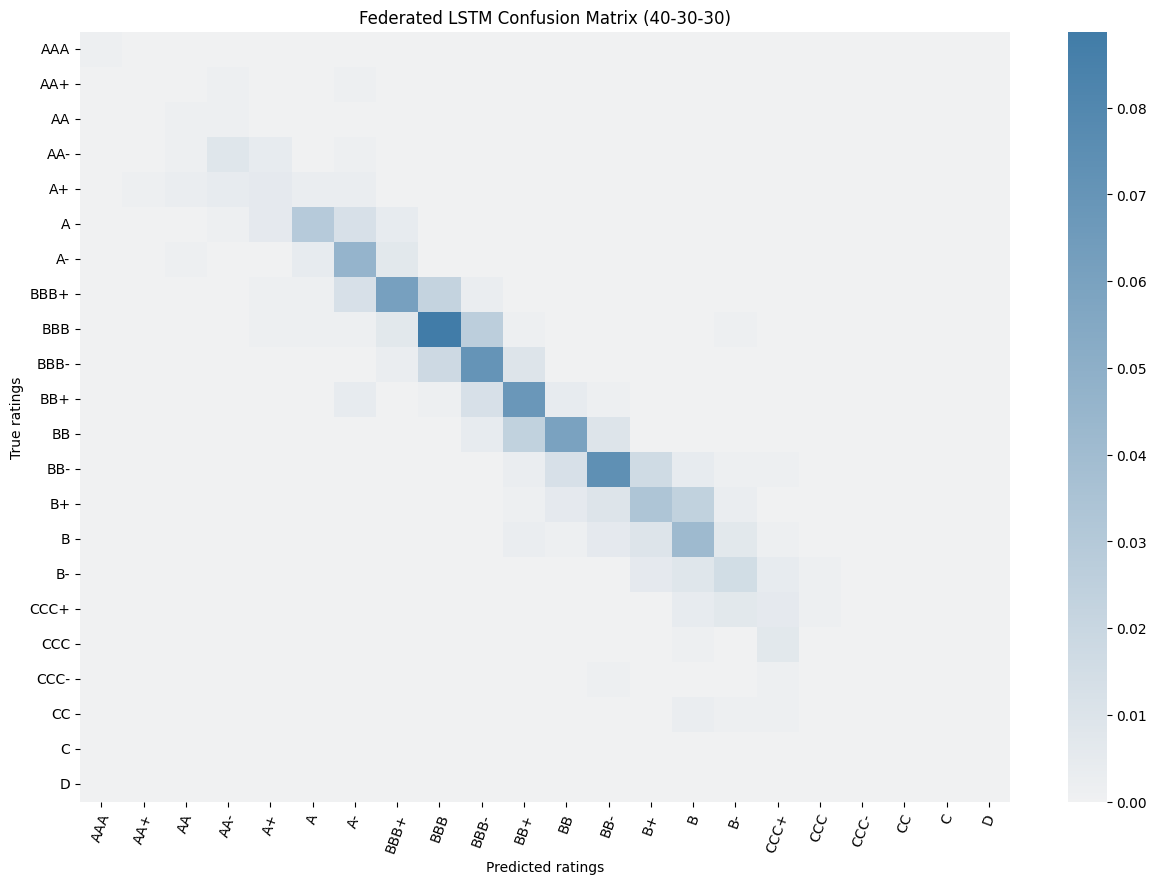

In [60]:
# 40-30-30
model_fl = run_lstm_simulation([0.4, 0.3, 0.3], 'split_40_30_30', 64, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (40-30-30)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 15:19:48,121 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=24809) Epoch: 64, Loss: 0.04769933968782425 [repeated 28x across cluster]
(launch_and_evaluate pid=24808) Client 1 evaluate, config {}


2023-06-15 15:19:52,843	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 15:19:53,365 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 8338894029.0}
INFO flwr 2023-06-15 15:19:53,366 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 15:19:53,366 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 15:19:54,218 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 15:19:54,219 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 15:19:54,219 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 15:19:54,219 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=24880) Epoch: 1, Loss: 26.535369873046875
(launch_and_fit pid=24880) Epoch: 2, Loss: 18.755104064941406
(launch_and_fit pid=24880) Epoch: 3, Loss: 11.143363952636719
(launch_and_fit pid=24880) Epoch: 4, Loss: 12.944910049438477
(launch_and_fit pid=24880) Epoch: 5, Loss: 25.90947151184082
(launch_and_fit pid=24880) Epoch: 6, Loss: 9.041258811950684
(launch_and_fit pid=24880) Epoch: 7, Loss: 16.410383224487305
(launch_and_fit pid=24880) Epoch: 8, Loss: 18.723257064819336
(launch_and_fit pid=24880) Epoch: 9, Loss: 21.409507751464844
(launch_and_fit pid=24880) Epoch: 10, Loss: 22.707977294921875
(launch_and_fit pid=24880) Epoch: 11, Loss: 12.038436889648438
(launch_and_fit pid=24880) Epoch: 12, Loss: 16.75301742553711
(launch_and_fit pid=24880) Epoch: 13, Loss: 20.448158264160156
(launch_and_fit pid=24880) Epoch: 14, Loss: 18.596038818359375
(launch_and_fit pid=24880) Epoch: 15, Loss: 13.375555038452148
(launch_and_fit pid=24880) Epoch: 16, Loss: 15.213151931762695
(lau

DEBUG flwr 2023-06-15 15:19:57,898 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:19:57,909 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:19:57,927 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:19:58,021 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:19:58,022 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:19:58,022 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=24880) Client 0 evaluate, config {}
(launch_and_fit pid=24880) Epoch: 27, Loss: 7.993462562561035 [repeated 163x across cluster]


DEBUG flwr 2023-06-15 15:20:01,405 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:20:01,436 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:20:01,540 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:20:01,541 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=24875) Client 2 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=24880) Epoch: 55, Loss: 5.0526347160339355 [repeated 185x across cluster]


DEBUG flwr 2023-06-15 15:20:04,999 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:20:05,024 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:20:05,113 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:20:05,114 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=24875) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=24875) Epoch: 13, Loss: 8.667618751525879 [repeated 94x across cluster]
(launch_and_fit pid=24875) Epoch: 30, Loss: 6.859702110290527 [repeated 17x across cluster]
(launch_and_fit pid=24875) Epoch: 47, Loss: 8.262958526611328 [repeated 17x across cluster]


DEBUG flwr 2023-06-15 15:20:25,334 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:20:25,536 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=24875) Epoch: 64, Loss: 6.083276748657227 [repeated 17x across cluster]
Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 15:20:25,754 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:20:25,755 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=24880) Client 2 evaluate, config {}
(launch_and_fit pid=24875) Epoch: 14, Loss: 9.166742324829102 [repeated 78x across cluster]
(launch_and_evaluate pid=24875) Epoch: 15, Loss: 9.735487937927246
(launch_and_fit pid=24875) Epoch: 31, Loss: 5.6014862060546875 [repeated 17x across cluster]
(launch_and_fit pid=24875) Epoch: 48, Loss: 0.8796190619468689 [repeated 17x across cluster]


DEBUG flwr 2023-06-15 15:20:45,609 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:20:45,640 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:20:45,742 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:20:45,743 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=24880) Client 1 evaluate, config {}
(launch_and_fit pid=24875) Epoch: 3, Loss: 2.3198671340942383 [repeated 19x across cluster]
(launch_and_evaluate pid=24875) Epoch: 14, Loss: 0.6894768476486206
(launch_and_fit pid=24880) Epoch: 14, Loss: 0.6894768476486206 [repeated 75x across cluster]
(launch_and_fit pid=24880) Epoch: 29, Loss: 0.7435153722763062 [repeated 15x across cluster]
(launch_and_fit pid=24880) Epoch: 45, Loss: 1.0958023071289062 [repeated 16x across cluster]
(launch_and_fit pid=24880) Epoch: 61, Loss: 0.38266149163246155 [repeated 16x across cluster]


DEBUG flwr 2023-06-15 15:21:07,589 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:21:07,628 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:21:07,748 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:21:07,748 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=24880) Client 2 evaluate, config {}


DEBUG flwr 2023-06-15 15:21:11,038 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:21:11,065 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:21:11,159 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:21:11,159 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...
(launch_and_fit pid=24880) Epoch: 8, Loss: 0.21012340486049652 [repeated 146x across cluster]
(launch_and_evaluate pid=24875) Client 2 evaluate, config {} [repeated 3x across cluster]


DEBUG flwr 2023-06-15 15:21:14,560 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:21:14,587 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:21:14,680 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:21:14,680 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=24880) Epoch: 33, Loss: 0.14437806606292725 [repeated 181x across cluster]
(launch_and_evaluate pid=24875) Client 2 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:21:18,164 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:21:18,191 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:21:18,298 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:21:18,298 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 15:21:21,674 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:21:21,700 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:21:21,785 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:21:21,785 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...
(launch_and_fit pid=24880) Epoch: 64, Loss: 0.17860884964466095 [repeated 188x across cluster]
(launch_and_evaluate pid=24875) Client 1 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=24880) Epoch: 14, Loss: 1.274701476097107 [repeated 78x across cluster]
(launch_and_fit pid=24880) Epoch: 30, Loss: 0.5891098380088806 [repeated 16x across cluster]
(launch_and_fit pid=24880) Epoch: 46, Loss: 2.089174270629883 [repeated 16x across cluster]
(launch_and_fit pid=24880) Epoch: 63, Loss: 0.9562535285949707 [repeated 17x across cluster]


DEBUG flwr 2023-06-15 15:21:42,543 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:21:42,575 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:21:42,677 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:21:42,678 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=24880) Client 0 evaluate, config {}


DEBUG flwr 2023-06-15 15:21:45,980 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:21:46,003 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:21:46,093 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:21:46,093 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...
(launch_and_fit pid=24880) Epoch: 21, Loss: 0.614905059337616 [repeated 153x across cluster]
(launch_and_evaluate pid=24875) Client 0 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=24875) Epoch: 18, Loss: 2.211805820465088 [repeated 58x across cluster]
(launch_and_fit pid=24875) Epoch: 34, Loss: 0.5345077514648438 [repeated 16x across cluster]
(launch_and_fit pid=24875) Epoch: 50, Loss: 1.160841703414917 [repeated 16x across cluster]


DEBUG flwr 2023-06-15 15:22:07,443 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:22:07,470 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:22:07,559 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:22:07,559 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=24880) Client 2 evaluate, config {}
(launch_and_fit pid=24880) Epoch: 4, Loss: 0.5626518726348877 [repeated 18x across cluster]
(launch_and_fit pid=24880) 
(launch_and_evaluate pid=24875) Epoch: 15, Loss: 0.4935913681983948
(launch_and_fit pid=24875) Epoch: 16, Loss: 0.2719670534133911 [repeated 76x across cluster]
(launch_and_fit pid=24875) Epoch: 33, Loss: 1.307658314704895 [repeated 17x across cluster]
(launch_and_fit pid=24875) Epoch: 51, Loss: 1.007258415222168 [repeated 18x across cluster]


DEBUG flwr 2023-06-15 15:22:27,263 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:22:27,304 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:22:27,403 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:22:27,404 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=24880) Client 0 evaluate, config {}
(launch_and_fit pid=24875) Epoch: 19, Loss: 0.1799948662519455 [repeated 34x across cluster]
(launch_and_evaluate pid=24875) Epoch: 15, Loss: 0.7364583015441895
(launch_and_fit pid=24880) Epoch: 17, Loss: 0.8762005567550659 [repeated 60x across cluster]
(launch_and_fit pid=24880) Epoch: 32, Loss: 0.6984853744506836 [repeated 15x across cluster]
(launch_and_fit pid=24880) Epoch: 49, Loss: 0.8739988207817078 [repeated 17x across cluster]


DEBUG flwr 2023-06-15 15:22:48,438 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:22:48,470 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:22:48,573 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:22:48,574 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=24880) Client 1 evaluate, config {}
(launch_and_fit pid=24880) Epoch: 5, Loss: 0.41821733117103577 [repeated 23x across cluster]


DEBUG flwr 2023-06-15 15:22:51,655 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:22:51,686 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:22:51,774 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:22:51,775 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=24875) Client 1 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=24875) Epoch: 42, Loss: 0.1339898407459259 [repeated 167x across cluster]
(launch_and_fit pid=24880) Epoch: 21, Loss: 0.16055616736412048 [repeated 38x across cluster]
(launch_and_fit pid=24880) Epoch: 37, Loss: 1.1066691875457764 [repeated 16x across cluster]
(launch_and_fit pid=24880) Epoch: 52, Loss: 0.21008384227752686 [repeated 15x across cluster]


DEBUG flwr 2023-06-15 15:23:13,575 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:23:13,609 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:23:13,734 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:23:13,735 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=24880) Client 1 evaluate, config {}
(launch_and_fit pid=24875) Epoch: 18, Loss: 0.139989972114563 [repeated 32x across cluster]
(launch_and_evaluate pid=24875) Epoch: 14, Loss: 1.301948070526123
(launch_and_fit pid=24880) Epoch: 17, Loss: 1.3295480012893677 [repeated 61x across cluster]
(launch_and_fit pid=24880) Epoch: 32, Loss: 1.5075504779815674 [repeated 15x across cluster]
(launch_and_fit pid=24880) Epoch: 48, Loss: 0.6397805213928223 [repeated 16x across cluster]


DEBUG flwr 2023-06-15 15:23:35,322 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:23:35,355 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:23:35,455 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:23:35,456 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...
(launch_and_fit pid=24880) Epoch: 64, Loss: 1.6268149614334106 [repeated 16x across cluster]
(launch_and_evaluate pid=24880) Client 2 evaluate, config {}


DEBUG flwr 2023-06-15 15:23:38,967 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:23:39,020 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:23:39,131 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:23:39,132 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...
(launch_and_fit pid=24880) Epoch: 22, Loss: 0.031427159905433655 [repeated 172x across cluster]
(launch_and_evaluate pid=24875) Client 0 evaluate, config {} [repeated 3x across cluster]


DEBUG flwr 2023-06-15 15:23:42,434 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:23:42,476 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:23:42,565 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 15:23:42,565 | server.py:147 | FL finished in 228.3438435830176
INFO flwr 2023-06-15 15:23:42,567 | app.py:218 | app_fit: losses_distributed [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 56.793342579750345), (5, 8.134535367545077), (6, 0.8529819694868238), (7, 1.3592233009708738), (8, 1.3689320388349515), (9, 1.3800277392510403), (10, 1.3689320388349515), (11, 0.8377253814147018), (12, 1.1484049930651872), (13, 0.926490984743412), (14, 0.8751733703190014), (15, 0.8793342579750347), (16, 1.0610263522884882), (17, 0.8654646324549237), (18, 0.8904299583911235), (19, 0.9375866851595007), (20, 1.0485436893203883)]
INFO flwr 202

Saving round 20 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_80_10_10/model_round_20.pth
1.0485436893203883
0.0023776500891618782
0.963725082416736
0.96524064171123


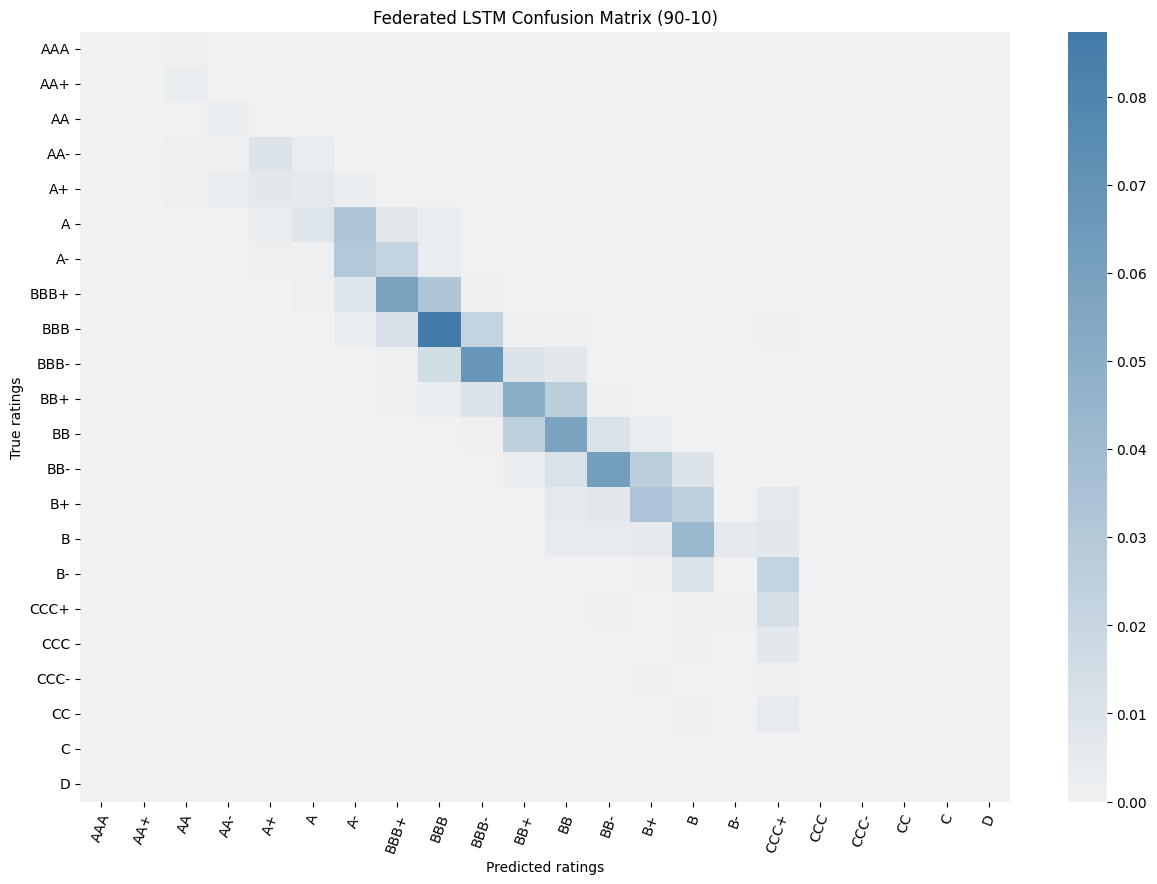

In [61]:
# 80-10-10
model_fl = run_lstm_simulation([0.8, 0.1, 0.1], 'split_80_10_10', 64, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 14:25:04,595 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=24037) Epoch: 64, Loss: 0.30551522970199585 [repeated 11x across cluster]
(launch_and_evaluate pid=24037) Client 1 evaluate, config {}


2023-06-15 14:25:09,662	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 14:25:10,190 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'CPU': 8.0, 'memory': 8407357850.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-15 14:25:10,191 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 14:25:10,191 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 14:25:11,049 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 14:25:11,049 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 14:25:11,049 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 14:25:11,050 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=24071) Epoch: 1, Loss: 50.02048873901367
(launch_and_fit pid=24071) Epoch: 2, Loss: 45.589271545410156
(launch_and_fit pid=24071) Epoch: 3, Loss: 52.54369354248047
(launch_and_fit pid=24071) Epoch: 4, Loss: 41.334529876708984
(launch_and_fit pid=24071) Epoch: 5, Loss: 40.42193603515625
(launch_and_fit pid=24071) Epoch: 6, Loss: 43.433982849121094
(launch_and_fit pid=24071) Epoch: 7, Loss: 25.74398422241211
(launch_and_fit pid=24071) Epoch: 8, Loss: 46.014930725097656
(launch_and_fit pid=24071) Epoch: 9, Loss: 24.758087158203125
(launch_and_fit pid=24071) Epoch: 59, Loss: 5.977962970733643 [repeated 101x across cluster]


DEBUG flwr 2023-06-15 14:25:17,363 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 14:25:17,391 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 14:25:17,417 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:25:17,525 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 14:25:17,526 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 14:25:17,526 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 3 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 39, Loss: 5.176543712615967 [repeated 98x across cluster]
(launch_and_evaluate pid=24068) Epoch: 51, Loss: 3.9765658378601074


DEBUG flwr 2023-06-15 14:25:23,760 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:25:23,788 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:25:23,953 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:25:23,953 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 3 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 22, Loss: 5.4005045890808105 [repeated 93x across cluster]
(launch_and_evaluate pid=24068) Epoch: 50, Loss: 5.5289177894592285


DEBUG flwr 2023-06-15 14:25:30,198 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:25:30,273 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:25:30,419 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:25:30,419 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 0 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 10, Loss: 5.802645683288574 [repeated 104x across cluster]
(launch_and_evaluate pid=24068) Epoch: 52, Loss: 1.856645107269287


DEBUG flwr 2023-06-15 14:25:36,457 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:25:36,500 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:25:36,605 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:25:36,605 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=24071) Epoch: 63, Loss: 1.9362831115722656 [repeated 106x across cluster]
Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 4 evaluate, config {}
(launch_and_fit pid=24068) 
(launch_and_fit pid=24071) Epoch: 52, Loss: 0.9581737518310547 [repeated 112x across cluster]
(launch_and_evaluate pid=24068) Epoch: 53, Loss: 0.7060279250144958


DEBUG flwr 2023-06-15 14:25:42,491 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:25:42,521 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:25:42,613 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:25:42,613 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 1 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 40, Loss: 0.9956575632095337 [repeated 101x across cluster]
(launch_and_evaluate pid=24068) Epoch: 52, Loss: 0.8454886674880981


DEBUG flwr 2023-06-15 14:25:48,729 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:25:48,761 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:25:48,851 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:25:48,851 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 3 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 28, Loss: 2.041243553161621 [repeated 103x across cluster]
(launch_and_evaluate pid=24068) Epoch: 52, Loss: 0.4866786599159241


DEBUG flwr 2023-06-15 14:25:54,874 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:25:54,903 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:25:54,999 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:25:55,000 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 0 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 17, Loss: 1.5552411079406738 [repeated 105x across cluster]
(launch_and_evaluate pid=24068) Epoch: 54, Loss: 0.7790383100509644


DEBUG flwr 2023-06-15 14:26:00,989 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:01,013 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:26:01,108 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:01,109 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 0 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 6, Loss: 1.0694221258163452 [repeated 104x across cluster]
(launch_and_fit pid=24068) 
(launch_and_evaluate pid=24068) Epoch: 52, Loss: 2.252697229385376
(launch_and_fit pid=24071) Epoch: 60, Loss: 1.9072009325027466 [repeated 112x across cluster]


DEBUG flwr 2023-06-15 14:26:07,133 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:07,167 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:26:07,265 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:07,265 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 4 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 16, Loss: 1.6850415468215942
(launch_and_fit pid=24071) Epoch: 49, Loss: 0.8042991161346436 [repeated 111x across cluster]
(launch_and_evaluate pid=24068) Epoch: 54, Loss: 1.5482721328735352


DEBUG flwr 2023-06-15 14:26:13,117 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:13,151 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:26:13,239 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:13,239 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 4 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 37, Loss: 0.4609590768814087 [repeated 101x across cluster]
(launch_and_evaluate pid=24068) Epoch: 51, Loss: 2.362330198287964


DEBUG flwr 2023-06-15 14:26:19,411 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:19,435 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:26:19,520 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:19,520 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 0 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 24, Loss: 1.8519246578216553 [repeated 99x across cluster]
(launch_and_evaluate pid=24068) Epoch: 51, Loss: 2.502244710922241


DEBUG flwr 2023-06-15 14:26:25,692 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:25,723 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:26:25,807 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:25,808 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 0 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 12, Loss: 3.957364320755005 [repeated 100x across cluster]
(launch_and_evaluate pid=24068) Epoch: 53, Loss: 0.5071958899497986


DEBUG flwr 2023-06-15 14:26:31,803 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:31,827 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:26:31,918 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:31,918 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 0 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 1, Loss: 1.8121132850646973 [repeated 106x across cluster]
(launch_and_evaluate pid=24068) Epoch: 49, Loss: 0.9446170330047607
(launch_and_fit pid=24071) Epoch: 51, Loss: 1.5628986358642578 [repeated 109x across cluster]


DEBUG flwr 2023-06-15 14:26:38,332 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:38,359 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:26:38,448 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:38,448 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 1 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 35, Loss: 0.139751136302948 [repeated 92x across cluster]
(launch_and_evaluate pid=24068) Epoch: 47, Loss: 0.509261965751648


DEBUG flwr 2023-06-15 14:26:45,079 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:45,107 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:26:45,197 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:45,198 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 1 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 19, Loss: 0.2289542853832245 [repeated 94x across cluster]
(launch_and_evaluate pid=24068) Epoch: 48, Loss: 0.2507931888103485
(launch_and_fit pid=24071) 


DEBUG flwr 2023-06-15 14:26:51,706 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:51,734 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:26:51,831 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:51,831 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 0 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 4, Loss: 1.6713297367095947 [repeated 96x across cluster]
(launch_and_evaluate pid=24068) Epoch: 55, Loss: 0.982273280620575


DEBUG flwr 2023-06-15 14:26:57,582 | server.py:232 | fit_round 17 received 2 results and 0 failures


(launch_and_fit pid=24071) Epoch: 61, Loss: 1.0785189867019653 [repeated 117x across cluster]


DEBUG flwr 2023-06-15 14:26:57,609 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:26:57,697 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:26:57,697 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 2 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 48, Loss: 0.54266357421875 [repeated 99x across cluster]
(launch_and_evaluate pid=24068) Epoch: 51, Loss: 0.32666507363319397


DEBUG flwr 2023-06-15 14:27:03,880 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:27:03,942 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:27:04,048 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:27:04,049 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 1 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 37, Loss: 0.6966747641563416 [repeated 107x across cluster]
(launch_and_evaluate pid=24068) Epoch: 54, Loss: 0.6381174921989441


DEBUG flwr 2023-06-15 14:27:09,963 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:27:09,992 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:27:10,087 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:27:10,088 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=24071) Client 2 evaluate, config {}
(launch_and_fit pid=24071) Epoch: 23, Loss: 0.7784600257873535 [repeated 101x across cluster]
(launch_and_evaluate pid=24068) Epoch: 47, Loss: 0.4898524284362793


DEBUG flwr 2023-06-15 14:27:16,659 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:27:16,694 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:27:16,779 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 14:27:16,780 | server.py:147 | FL finished in 125.73039029096253
INFO flwr 2023-06-15 14:27:16,780 | app.py:218 | app_fit: losses_distributed [(1, 17.889042995839112), (2, 17.77253814147018), (3, 17.72122052704577), (4, 1.0540915395284327), (5, 1.1511789181692094), (6, 1.1262135922330097), (7, 1.1234396671289875), (8, 1.0402219140083218), (9, 1.1067961165048543), (10, 1.0249653259361997), (11, 1.3509015256588073), (12, 1.2787794729542303), (13, 1.4105409153952844), (14, 1.319001386962552), (15, 1.3245492371705965), (16, 1.1248266296809986), (17, 1.246879334257975), (18, 1.0832177531206657), (19, 1.1359223300970873), (20, 1.2524271844660195)]
INFO flwr 2023

Saving round 20 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_20_20_20_20_20/model_round_20.pth
(launch_and_evaluate pid=24071) Client 2 evaluate, config {}
1.2524271844660195
0.0028399709398322435
0.9521751856302185
0.9551451187335093


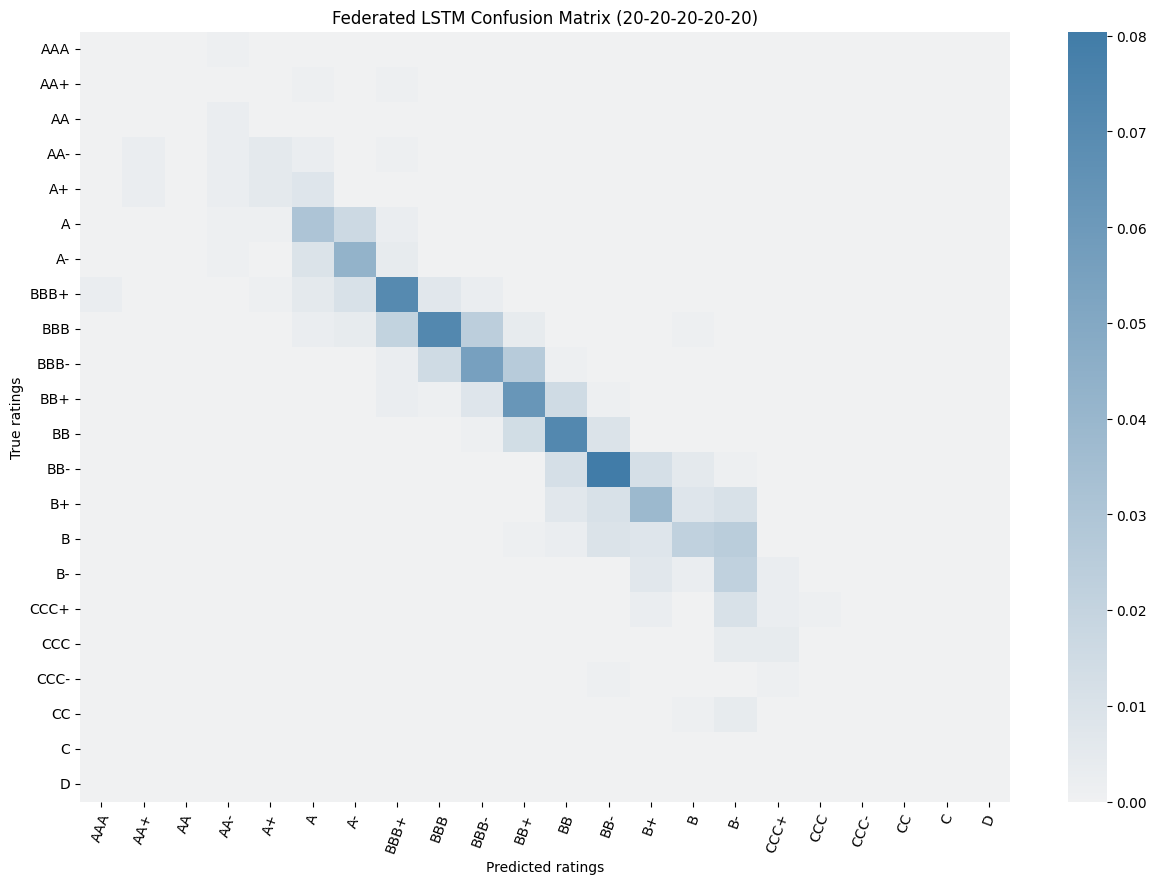

In [32]:
# 20-20-20-20-20
model_fl = run_lstm_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', 64, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (20-20-20-20-20)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 14:27:17,355 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)


(launch_and_fit pid=24071) Epoch: 64, Loss: 0.5689826011657715 [repeated 80x across cluster]
(launch_and_evaluate pid=24068) Client 3 evaluate, config {}


2023-06-15 14:27:22,072	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 14:27:22,711 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'memory': 7978349364.0}
INFO flwr 2023-06-15 14:27:22,712 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 14:27:22,712 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 14:27:23,622 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 14:27:23,622 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 14:27:23,623 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 14:27:23,623 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=24090) Epoch: 1, Loss: 25.956295013427734
(launch_and_fit pid=24090) Epoch: 2, Loss: 27.675025939941406
(launch_and_fit pid=24090) Epoch: 3, Loss: 25.602306365966797
(launch_and_fit pid=24090) Epoch: 4, Loss: 30.225996017456055
(launch_and_fit pid=24090) Epoch: 5, Loss: 24.367734909057617
(launch_and_fit pid=24090) Epoch: 6, Loss: 22.248275756835938
(launch_and_fit pid=24090) Epoch: 7, Loss: 14.869935989379883
(launch_and_fit pid=24090) Epoch: 8, Loss: 19.370668411254883
(launch_and_fit pid=24090) Epoch: 9, Loss: 25.17974853515625
(launch_and_fit pid=24090) Epoch: 10, Loss: 21.12569808959961
(launch_and_fit pid=24090) Epoch: 11, Loss: 13.34343147277832
(launch_and_fit pid=24090) Epoch: 12, Loss: 18.596227645874023
(launch_and_fit pid=24090) Epoch: 13, Loss: 17.490745544433594
(launch_and_fit pid=24090) Epoch: 14, Loss: 17.957860946655273
(launch_and_fit pid=24090) Epoch: 15, Loss: 12.061932563781738
(launch_and_fit pid=24090) Epoch: 16, Loss: 14.630804061889648
(lau

DEBUG flwr 2023-06-15 14:27:41,909 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 14:27:41,939 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 14:27:41,965 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:27:42,082 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 14:27:42,082 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 14:27:42,083 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=24090) Client 0 evaluate, config {}
(launch_and_fit pid=24090) Epoch: 40, Loss: 6.628199100494385 [repeated 85x across cluster]


DEBUG flwr 2023-06-15 14:27:45,620 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:27:45,659 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:27:45,756 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:27:45,757 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=24097) Client 3 evaluate, config {} [repeated 3x across cluster]


DEBUG flwr 2023-06-15 14:27:49,071 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:27:49,108 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:27:49,208 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:27:49,209 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...
(launch_and_fit pid=24097) Epoch: 64, Loss: 2.171344041824341 [repeated 182x across cluster]
(launch_and_evaluate pid=24097) Client 2 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 14:27:52,688 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:27:52,720 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:27:52,807 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:27:52,808 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...
(launch_and_fit pid=24090) Epoch: 26, Loss: 0.5938326120376587 [repeated 177x across cluster]


DEBUG flwr 2023-06-15 14:27:56,291 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:27:56,325 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:27:56,414 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:27:56,415 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=24097) Client 4 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=24090) Epoch: 53, Loss: 0.2144675850868225 [repeated 180x across cluster]


DEBUG flwr 2023-06-15 14:27:59,965 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:27:59,993 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:28:00,118 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:28:00,118 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=24090) Client 2 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 14:28:03,846 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:28:03,875 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:28:03,967 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:28:03,967 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...
(launch_and_fit pid=24090) Epoch: 1, Loss: 1.1919965744018555 [repeated 159x across cluster]
(launch_and_evaluate pid=24097) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=24090) Epoch: 20, Loss: 1.1975376605987549 [repeated 80x across cluster]
(launch_and_fit pid=24090) Epoch: 42, Loss: 2.859865665435791 [repeated 22x across cluster]
(launch_and_fit pid=24090) Epoch: 63, Loss: 1.3799563646316528 [repeated 21x across cluster]


DEBUG flwr 2023-06-15 14:28:20,154 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:28:20,197 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:28:20,302 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:28:20,303 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=24090) Client 0 evaluate, config {}
(launch_and_fit pid=24090) Epoch: 17, Loss: 1.228794813156128 [repeated 82x across cluster]
(launch_and_evaluate pid=24097) Epoch: 19, Loss: 0.9112251400947571
(launch_and_fit pid=24090) Epoch: 38, Loss: 4.718159198760986 [repeated 21x across cluster]
(launch_and_fit pid=24090) Epoch: 59, Loss: 0.4456079602241516 [repeated 21x across cluster]


DEBUG flwr 2023-06-15 14:28:36,514 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:28:36,552 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:28:36,648 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:28:36,649 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=24090) Client 4 evaluate, config {}


DEBUG flwr 2023-06-15 14:28:40,131 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:28:40,160 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:28:40,265 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:28:40,265 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...
(launch_and_fit pid=24090) Epoch: 1, Loss: 1.5797703266143799 [repeated 134x across cluster]
(launch_and_evaluate pid=24097) Client 0 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=24097) Epoch: 18, Loss: 4.995433330535889 [repeated 81x across cluster]
(launch_and_fit pid=24097) Epoch: 38, Loss: 0.9158570766448975 [repeated 20x across cluster]
(launch_and_fit pid=24097) Epoch: 58, Loss: 1.2491686344146729 [repeated 20x across cluster]


DEBUG flwr 2023-06-15 14:28:57,530 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:28:57,563 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:28:57,665 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:28:57,666 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=24090) Client 1 evaluate, config {}
(launch_and_fit pid=24097) Epoch: 58, Loss: 0.05896048992872238 [repeated 75x across cluster]
(launch_and_evaluate pid=24097) Epoch: 18, Loss: 0.7390768527984619
(launch_and_fit pid=24090) Epoch: 31, Loss: 0.3485933840274811 [repeated 26x across cluster]
(launch_and_fit pid=24090) Epoch: 51, Loss: 0.6669603586196899 [repeated 20x across cluster]


DEBUG flwr 2023-06-15 14:29:14,394 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:29:14,428 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:29:14,526 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:29:14,526 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=24090) Client 0 evaluate, config {}
(launch_and_fit pid=24090) Epoch: 33, Loss: 0.9760583639144897 [repeated 77x across cluster]


DEBUG flwr 2023-06-15 14:29:17,733 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:29:17,766 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=24097) 
Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 14:29:17,870 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:29:17,870 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=24097) Client 3 evaluate, config {} [repeated 3x across cluster]


DEBUG flwr 2023-06-15 14:29:21,465 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:29:21,503 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=24097) Epoch: 61, Loss: 0.1466393768787384 [repeated 189x across cluster]
Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 14:29:21,602 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:29:21,602 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=24097) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=24090) Epoch: 18, Loss: 0.9839130640029907 [repeated 85x across cluster]
(launch_and_fit pid=24090) Epoch: 39, Loss: 0.7306311726570129 [repeated 21x across cluster]
(launch_and_fit pid=24090) Epoch: 61, Loss: 0.6852631568908691 [repeated 22x across cluster]


DEBUG flwr 2023-06-15 14:29:37,156 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:29:37,193 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:29:37,296 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:29:37,297 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=24090) Client 4 evaluate, config {}


DEBUG flwr 2023-06-15 14:29:40,632 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:29:40,664 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:29:40,760 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:29:40,760 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...
(launch_and_fit pid=24090) Epoch: 16, Loss: 0.11254341155290604 [repeated 160x across cluster]
(launch_and_evaluate pid=24097) Client 1 evaluate, config {} [repeated 3x across cluster]


DEBUG flwr 2023-06-15 14:29:44,155 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:29:44,188 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:29:44,287 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:29:44,287 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...
(launch_and_fit pid=24090) Epoch: 8, Loss: 1.1378908157348633 [repeated 148x across cluster]
(launch_and_evaluate pid=24097) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=24090) Epoch: 28, Loss: 0.22302590310573578 [repeated 43x across cluster]
(launch_and_fit pid=24090) Epoch: 49, Loss: 2.0035572052001953 [repeated 21x across cluster]


DEBUG flwr 2023-06-15 14:30:00,414 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:30:00,449 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:30:00,572 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:30:00,573 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=24090) Client 4 evaluate, config {}
(launch_and_fit pid=24090) Epoch: 28, Loss: 0.43768781423568726 [repeated 70x across cluster]


DEBUG flwr 2023-06-15 14:30:03,722 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:30:03,753 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:30:03,850 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:30:03,851 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=24097) Client 0 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=24090) Epoch: 62, Loss: 0.01682516187429428 [repeated 192x across cluster]


DEBUG flwr 2023-06-15 14:30:07,236 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 14:30:07,276 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 14:30:07,376 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
INFO flwr 2023-06-15 14:30:07,377 | server.py:147 | FL finished in 163.75412729103118
INFO flwr 2023-06-15 14:30:07,377 | app.py:218 | app_fit: losses_distributed [(1, 106.5991678224688), (2, 106.59084604715673), (3, 5.439667128987518), (4, 1.6310679611650485), (5, 1.1248266296809986), (6, 1.5977808599167822), (7, 1.7323162274618584), (8, 1.2302357836338418), (9, 1.0624133148404993), (10, 1.3398058252427185), (11, 1.1789181692094313), (12, 1.1262135922330097), (13, 1.1927877947295422), (14, 1.2066574202496532), (15, 1.2066574202496532), (16, 1.6740638002773924), (17, 1.4965325936199723), (18, 1.1276005547850207), (19, 1.3925104022191401), (20, 1.418862690707351)]
INFO flwr 202

Saving round 20 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_60_10_10_10_10/model_round_20.pth
1.418862690707351
0.003217375715889685
0.9623809963952306
0.963855421686747


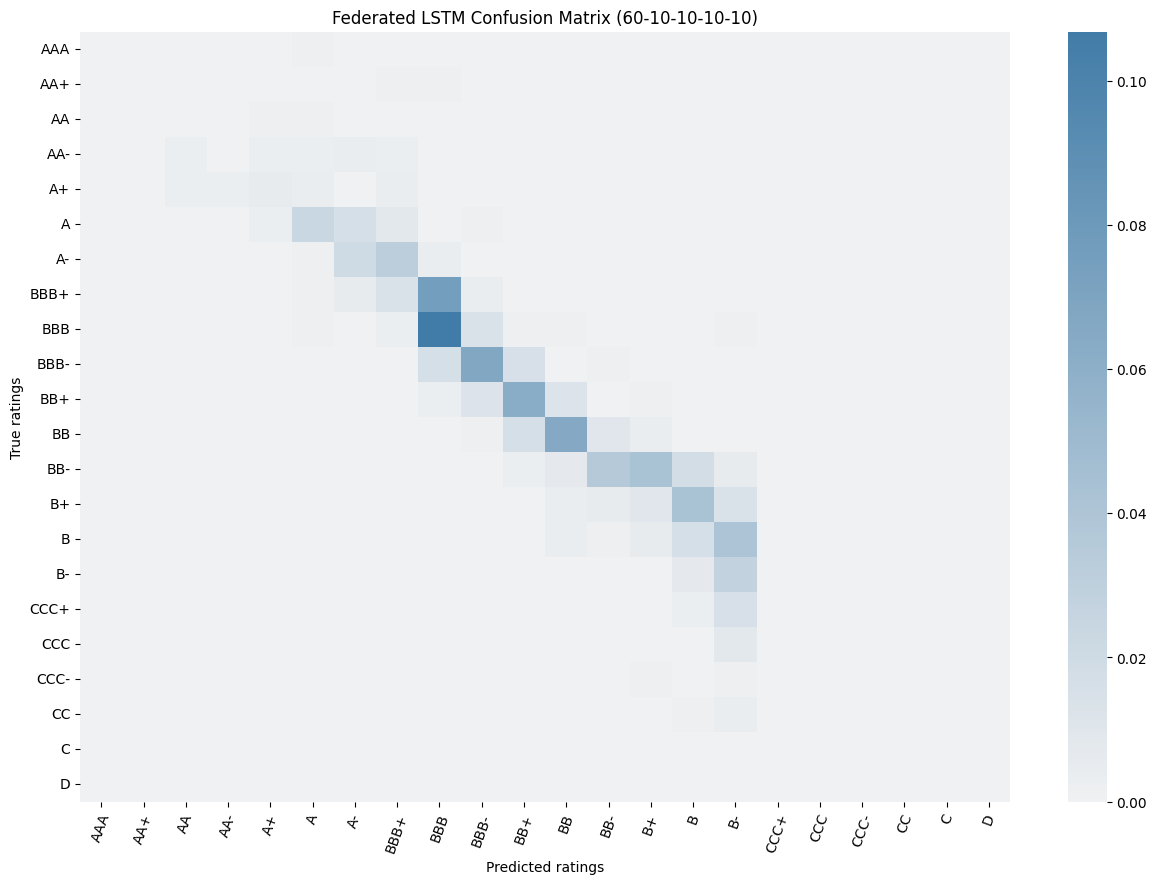

In [33]:
# 60-10-10-10-10
model_fl = run_lstm_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', 64, 4, 20)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (60-10-10-10-10)')

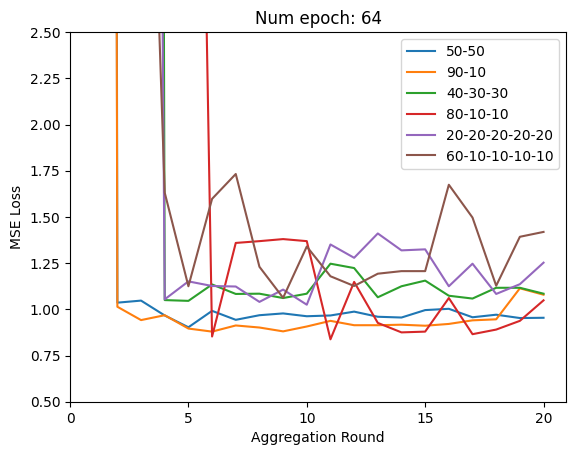

In [22]:
# Visualise loss convergence 64 epoch
ax = plt.gca()
ax.set_ylim([0.5, 2.5])
plot_loss([[(1, 71.39667128987517), (2, 1.0360610263522885), (3, 1.0471567267683772), (4, 0.9667128987517337), (5, 0.9029126213592233), (6, 0.9916782246879334), (7, 0.9431345353675451), (8, 0.9680998613037448), (9, 0.9778085991678225), (10, 0.9625520110957004), (11, 0.9667128987517337), (12, 0.9875173370319001), (13, 0.9597780859916782), (14, 0.955617198335645), (15, 0.9958391123439667), (16, 1.0027739251040222), (17, 0.957004160887656), (18, 0.970873786407767), (19, 0.9528432732316228), (20, 0.9542302357836339)]
, [(1, 56.793342579750345), (2, 1.013869625520111), (3, 0.941747572815534), (4, 0.9680998613037448), (5, 0.8959778085991679), (6, 0.8793342579750347), (7, 0.912621359223301), (8, 0.9015256588072122), (9, 0.8807212205270458), (10, 0.9070735090152566), (11, 0.9375866851595007), (12, 0.9140083217753121), (13, 0.9140083217753121), (14, 0.9167822468793343), (15, 0.9112343966712899), (16, 0.9209431345353676), (17, 0.9403606102635229), (18, 0.9459084604715673), (19, 1.1137309292649098), (20, 1.0790568654646324)]
, [(1, 44.19278779472954), (2, 44.20804438280167), (3, 44.19140083217753), (4, 1.0499306518723994), (5, 1.0457697642163661), (6, 1.1345353675450762), (7, 1.0832177531206657), (8, 1.0846047156726768), (9, 1.0610263522884882), (10, 1.0846047156726768), (11, 1.246879334257975), (12, 1.2233009708737863), (13, 1.0651872399445215), (14, 1.1248266296809986), (15, 1.1553398058252426), (16, 1.073509015256588), (17, 1.058252427184466), (18, 1.116504854368932), (19, 1.116504854368932), (20, 1.0846047156726768)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 56.793342579750345), (5, 8.134535367545077), (6, 0.8529819694868238), (7, 1.3592233009708738), (8, 1.3689320388349515), (9, 1.3800277392510403), (10, 1.3689320388349515), (11, 0.8377253814147018), (12, 1.1484049930651872), (13, 0.926490984743412), (14, 0.8751733703190014), (15, 0.8793342579750347), (16, 1.0610263522884882), (17, 0.8654646324549237), (18, 0.8904299583911235), (19, 0.9375866851595007), (20, 1.0485436893203883)]
, [(1, 17.889042995839112), (2, 17.77253814147018), (3, 17.72122052704577), (4, 1.0540915395284327), (5, 1.1511789181692094), (6, 1.1262135922330097), (7, 1.1234396671289875), (8, 1.0402219140083218), (9, 1.1067961165048543), (10, 1.0249653259361997), (11, 1.3509015256588073), (12, 1.2787794729542303), (13, 1.4105409153952844), (14, 1.319001386962552), (15, 1.3245492371705965), (16, 1.1248266296809986), (17, 1.246879334257975), (18, 1.0832177531206657), (19, 1.1359223300970873), (20, 1.2524271844660195)]
, [(1, 106.5991678224688), (2, 106.59084604715673), (3, 5.439667128987518), (4, 1.6310679611650485), (5, 1.1248266296809986), (6, 1.5977808599167822), (7, 1.7323162274618584), (8, 1.2302357836338418), (9, 1.0624133148404993), (10, 1.3398058252427185), (11, 1.1789181692094313), (12, 1.1262135922330097), (13, 1.1927877947295422), (14, 1.2066574202496532), (15, 1.2066574202496532), (16, 1.6740638002773924), (17, 1.4965325936199723), (18, 1.1276005547850207), (19, 1.3925104022191401), (20, 1.418862690707351)]]
, start=0, title='Num epoch: 64')

#### 16 Epoch

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 17:08:25,469 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None)


(launch_and_fit pid=26072) Epoch: 4, Loss: 0.2794397473335266 [repeated 33x across cluster]
(launch_and_evaluate pid=26072) Client 1 evaluate, config {} [repeated 5x across cluster]


2023-06-15 17:08:29,440	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 17:08:30,146 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2147483648.0, 'memory': 7886911898.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-15 17:08:30,147 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 17:08:30,147 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 17:08:31,064 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 17:08:31,065 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 17:08:31,065 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 17:08:31,066 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=26346) Epoch: 1, Loss: 13.70715618133545
(launch_and_fit pid=26346) Epoch: 2, Loss: 19.499420166015625
(launch_and_fit pid=26346) Epoch: 3, Loss: 13.135644912719727
(launch_and_fit pid=26346) Epoch: 4, Loss: 7.0124053955078125


DEBUG flwr 2023-06-15 17:08:35,781 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 17:08:35,809 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 17:08:35,843 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:08:35,940 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 17:08:35,941 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 17:08:35,941 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=26346) Client 0 evaluate, config {}
(launch_and_fit pid=26346) Epoch: 2, Loss: 3.7882442474365234 [repeated 31x across cluster]


DEBUG flwr 2023-06-15 17:08:40,059 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:08:40,095 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:08:40,195 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:08:40,195 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=26346) Epoch: 5, Loss: 0.7377172708511353 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 17:08:44,218 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:08:44,251 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:08:44,367 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:08:44,368 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26346) Epoch: 9, Loss: 2.6056790351867676 [repeated 40x across cluster]


DEBUG flwr 2023-06-15 17:08:48,170 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:08:48,207 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:08:48,292 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:08:48,292 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26346) Epoch: 14, Loss: 0.9374954104423523 [repeated 42x across cluster]


DEBUG flwr 2023-06-15 17:08:52,139 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:08:52,169 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:08:52,253 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:08:52,253 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 1 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:08:56,320 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:08:56,350 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:08:56,436 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:08:56,437 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...
(launch_and_fit pid=26342) Epoch: 1, Loss: 0.5335031151771545 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 17:09:00,508 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:00,532 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:09:00,622 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:00,622 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=26346) Client 1 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26342) Epoch: 5, Loss: 0.761009931564331 [repeated 40x across cluster]


DEBUG flwr 2023-06-15 17:09:04,802 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:04,829 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:09:04,924 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:04,925 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26346) Epoch: 8, Loss: 0.5274319648742676 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 17:09:09,098 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:09,123 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:09:09,207 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:09,207 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26346) Epoch: 11, Loss: 0.4789922833442688 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 17:09:13,349 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:13,377 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:09:13,463 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:13,464 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26346) Epoch: 15, Loss: 0.372833788394928 [repeated 40x across cluster]


DEBUG flwr 2023-06-15 17:09:17,555 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:17,582 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:09:17,667 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:17,668 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:09:21,835 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:21,863 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:09:21,960 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:21,960 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...
(launch_and_fit pid=26346) Epoch: 1, Loss: 0.3919079601764679 [repeated 36x across cluster]


DEBUG flwr 2023-06-15 17:09:25,912 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:25,936 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:09:26,022 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:26,022 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 1 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26346) Epoch: 5, Loss: 0.777984619140625 [repeated 40x across cluster]


DEBUG flwr 2023-06-15 17:09:30,187 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:30,209 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:09:30,303 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:30,303 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26342) Epoch: 8, Loss: 0.3821243643760681 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 17:09:34,567 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:34,597 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:09:34,686 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:34,686 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26342) Epoch: 10, Loss: 0.650349497795105 [repeated 36x across cluster]


DEBUG flwr 2023-06-15 17:09:38,962 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:38,993 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:09:39,080 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:39,081 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26342) Epoch: 14, Loss: 1.2793610095977783 [repeated 40x across cluster]


DEBUG flwr 2023-06-15 17:09:43,034 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:43,062 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:09:43,154 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:43,154 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 1 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:09:47,393 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:47,419 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:09:47,519 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:47,520 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...
(launch_and_fit pid=26346) Epoch: 16, Loss: 0.23583762347698212 [repeated 36x across cluster]


DEBUG flwr 2023-06-15 17:09:51,448 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:51,475 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:09:51,576 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:51,576 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26346) Epoch: 4, Loss: 0.3362460136413574 [repeated 40x across cluster]


DEBUG flwr 2023-06-15 17:09:55,492 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:55,519 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:09:55,611 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:55,612 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26346) Epoch: 8, Loss: 0.9836496114730835 [repeated 40x across cluster]


DEBUG flwr 2023-06-15 17:09:59,645 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:59,672 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:09:59,761 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:09:59,761 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 2)


Saving round 21 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26342) Epoch: 10, Loss: 0.5995340347290039 [repeated 37x across cluster]


DEBUG flwr 2023-06-15 17:10:04,046 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:04,069 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:10:04,163 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:04,164 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 2)


Saving round 22 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26342) Epoch: 14, Loss: 1.6666377782821655 [repeated 39x across cluster]


DEBUG flwr 2023-06-15 17:10:08,206 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:08,249 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:10:08,342 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:08,343 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 2)


Saving round 23 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 1 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:10:12,464 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:12,495 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:10:12,584 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:12,584 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 2)


Saving round 24 aggregated_parameters...
(launch_and_fit pid=26346) Epoch: 1, Loss: 0.27884769439697266 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 17:10:16,716 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:16,741 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:10:16,836 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:16,836 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 2)


Saving round 25 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26346) Epoch: 4, Loss: 0.2641974091529846 [repeated 39x across cluster]


DEBUG flwr 2023-06-15 17:10:20,640 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:20,673 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:10:20,774 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:20,774 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 2)


Saving round 26 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 1 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26346) Epoch: 9, Loss: 0.32399415969848633 [repeated 41x across cluster]


DEBUG flwr 2023-06-15 17:10:24,685 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:24,712 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:10:24,799 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:24,799 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 2)


Saving round 27 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26346) Epoch: 13, Loss: 0.09854328632354736 [repeated 40x across cluster]


DEBUG flwr 2023-06-15 17:10:28,862 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:28,890 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:10:28,981 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:28,981 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 2)


Saving round 28 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 1 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:10:33,058 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:33,086 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:10:33,172 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:33,172 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 2)


Saving round 29 aggregated_parameters...
(launch_and_fit pid=26342) Epoch: 16, Loss: 0.64058518409729 [repeated 39x across cluster]


DEBUG flwr 2023-06-15 17:10:37,222 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:37,245 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:10:37,342 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:37,343 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 2x across cluster]
Saving round 30 aggregated_parameters...
(launch_and_fit pid=26342) Epoch: 4, Loss: 0.41298726201057434 [repeated 39x across cluster]


DEBUG flwr 2023-06-15 17:10:41,536 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:41,569 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:10:41,678 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:41,678 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 2)


Saving round 31 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26342) Epoch: 7, Loss: 0.2811260521411896 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 17:10:45,722 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:45,758 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:10:45,846 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:45,847 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 2)


Saving round 32 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26346) Epoch: 11, Loss: 0.8210533857345581 [repeated 39x across cluster]


DEBUG flwr 2023-06-15 17:10:50,132 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:50,160 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:10:50,249 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:50,249 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 2)


Saving round 33 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26342) Epoch: 13, Loss: 0.07772216200828552 [repeated 39x across cluster]


DEBUG flwr 2023-06-15 17:10:54,255 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:54,281 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:10:54,367 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:54,368 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 2)


Saving round 34 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 1 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:10:58,623 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:58,649 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:10:58,771 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:10:58,772 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 2)


Saving round 35 aggregated_parameters...
(launch_and_fit pid=26342) Epoch: 15, Loss: 0.19079171121120453 [repeated 36x across cluster]
(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:11:03,066 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:03,090 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:11:03,191 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:03,192 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 2)


Saving round 36 aggregated_parameters...
(launch_and_fit pid=26346) Epoch: 2, Loss: 0.47312501072883606 [repeated 36x across cluster]


DEBUG flwr 2023-06-15 17:11:07,474 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:07,500 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:11:07,598 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:07,599 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 2x across cluster]
Saving round 37 aggregated_parameters...
(launch_and_fit pid=26346) Epoch: 5, Loss: 0.7227940559387207 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 17:11:11,734 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:11,771 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:11:11,867 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:11,868 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 2)


Saving round 38 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 1 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26346) Epoch: 9, Loss: 0.38853368163108826 [repeated 40x across cluster]


DEBUG flwr 2023-06-15 17:11:15,914 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:15,938 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:11:16,046 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:16,046 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 2)


Saving round 39 aggregated_parameters...
(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26346) Epoch: 13, Loss: 1.6474003791809082 [repeated 39x across cluster]


DEBUG flwr 2023-06-15 17:11:20,210 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:20,242 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:11:20,356 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
INFO flwr 2023-06-15 17:11:20,357 | server.py:147 | FL finished in 169.30121929198503
INFO flwr 2023-06-15 17:11:20,358 | app.py:218 | app_fit: losses_distributed [(1, 3.938973647711512), (2, 2.2441054091539527), (3, 2.0776699029126213), (4, 2.056865464632455), (5, 1.9361997226074896), (6, 2.0083217753120666), (7, 1.0388349514563107), (8, 0.9639389736477115), (9, 0.9237170596393898), (10, 0.9306518723994452), (11, 0.883495145631068), (12, 0.8821081830790569), (13, 0.9791955617198336), (14, 0.8543689320388349), (15, 0.8779472954230236), (16, 0.8377253814147018), (17, 0.8571428571428571), (18, 0.8751733703190014), (19, 0.8807212205270458), (20, 0.840499306518724), (21, 0.8710124

Saving round 40 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_50_50/model_round_40.pth
0.9084604715672677
0.002060001069313532
0.9653349046430663
0.9663526244952894


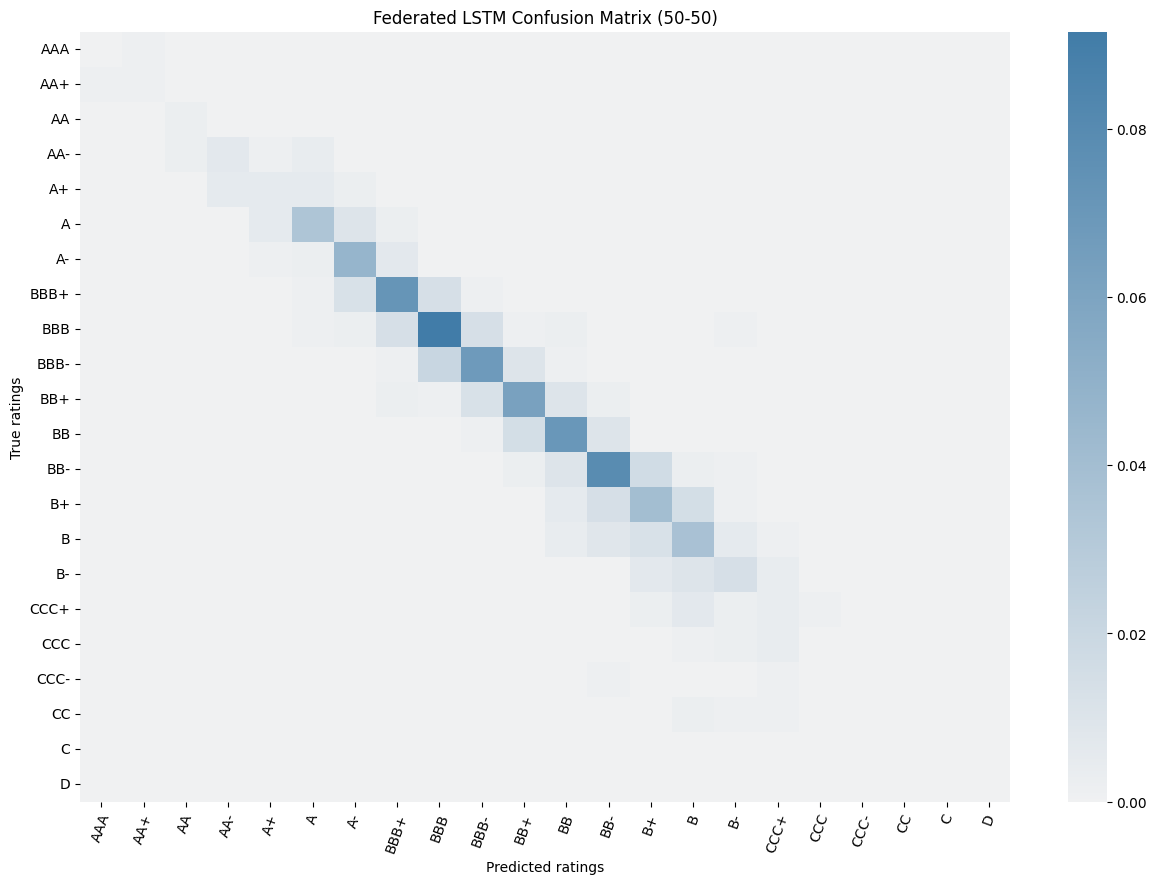

In [159]:
# 50-50
model_fl = run_lstm_simulation([0.5, 0.5], 'split_50_50', 16, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (50-50)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 17:11:21,199 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None)


(launch_and_evaluate pid=26342) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26342) Epoch: 16, Loss: 0.09330597519874573 [repeated 8x across cluster]


2023-06-15 17:11:26,124	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 17:11:26,806 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'memory': 7583668634.0}
INFO flwr 2023-06-15 17:11:26,806 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 17:11:26,807 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 17:11:27,668 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 17:11:27,668 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 17:11:27,668 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 17:11:27,669 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=26381) Epoch: 1, Loss: 29.705503463745117
(launch_and_fit pid=26381) Epoch: 2, Loss: 10.549169540405273


DEBUG flwr 2023-06-15 17:11:33,452 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 17:11:33,478 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 17:11:33,504 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:11:33,622 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 17:11:33,622 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 17:11:33,623 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...
(launch_and_fit pid=26381) Epoch: 16, Loss: 2.037604331970215 [repeated 30x across cluster]
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26377) Epoch: 12, Loss: 2.322378396987915 [repeated 28x across cluster]
(launch_and_evaluate pid=26377) Epoch: 12, Loss: 2.322378396987915


DEBUG flwr 2023-06-15 17:11:40,546 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:40,611 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:11:40,740 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:40,741 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 8, Loss: 1.635743260383606 [repeated 28x across cluster]
(launch_and_evaluate pid=26377) Epoch: 14, Loss: 3.1694860458374023


DEBUG flwr 2023-06-15 17:11:46,618 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:46,651 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:11:46,746 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:46,747 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 6, Loss: 1.3858915567398071 [repeated 30x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 1.6874209642410278


DEBUG flwr 2023-06-15 17:11:53,168 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:53,225 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:11:53,343 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:53,344 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 15, Loss: 1.4064955711364746 [repeated 26x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 4.679128646850586


DEBUG flwr 2023-06-15 17:11:59,524 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:59,552 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:11:59,649 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:11:59,650 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=26377) Epoch: 16, Loss: 1.7696715593338013 [repeated 16x across cluster]
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 14, Loss: 0.7316799163818359 [repeated 30x across cluster]
(launch_and_evaluate pid=26377) Epoch: 14, Loss: 0.7316799163818359


DEBUG flwr 2023-06-15 17:12:05,592 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:05,634 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:12:05,737 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:05,737 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 12, Loss: 0.6171106100082397 [repeated 30x across cluster]
(launch_and_evaluate pid=26377) Epoch: 14, Loss: 0.39644235372543335


DEBUG flwr 2023-06-15 17:12:11,397 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:11,422 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:12:11,508 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:11,509 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26377) Epoch: 10, Loss: 0.47307050228118896 [repeated 30x across cluster]
(launch_and_evaluate pid=26377) Epoch: 14, Loss: 2.1572351455688477


DEBUG flwr 2023-06-15 17:12:17,759 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:17,789 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:12:17,879 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:17,880 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26377) Epoch: 7, Loss: 0.5279185175895691 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 14, Loss: 0.8164187669754028


DEBUG flwr 2023-06-15 17:12:23,929 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:23,957 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:12:24,049 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:24,049 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 4, Loss: 0.4940915107727051 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.39931410551071167


DEBUG flwr 2023-06-15 17:12:30,225 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:30,255 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:12:30,345 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:30,345 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 1, Loss: 0.46596628427505493 [repeated 19x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.634120523929596
(launch_and_fit pid=26381) Epoch: 15, Loss: 0.42172718048095703 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 17:12:36,467 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:36,491 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:12:36,575 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:36,576 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26377) Epoch: 12, Loss: 0.29958945512771606 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 1.2936137914657593


DEBUG flwr 2023-06-15 17:12:42,864 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:42,890 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:12:42,974 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:42,975 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 9, Loss: 0.7814522981643677 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.5195051431655884


DEBUG flwr 2023-06-15 17:12:49,261 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:49,287 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:12:49,376 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:49,376 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26377) Epoch: 6, Loss: 0.30413082242012024 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.8447206020355225


DEBUG flwr 2023-06-15 17:12:55,686 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:55,714 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:12:55,799 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:12:55,800 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 3, Loss: 0.04635202884674072 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 12, Loss: 0.08708906173706055
(launch_and_fit pid=26381) Epoch: 15, Loss: 0.05646859109401703 [repeated 12x across cluster]


DEBUG flwr 2023-06-15 17:13:02,551 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:02,578 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:13:02,666 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:02,666 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 13, Loss: 0.07916486263275146 [repeated 30x across cluster]
(launch_and_evaluate pid=26377) Epoch: 14, Loss: 1.2915809154510498


DEBUG flwr 2023-06-15 17:13:08,598 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:08,624 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:13:08,712 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:08,713 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26377) Epoch: 10, Loss: 0.3419407308101654 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.1026407778263092


DEBUG flwr 2023-06-15 17:13:15,027 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:15,051 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:13:15,141 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:15,142 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 7, Loss: 0.23437410593032837 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.3618084192276001


DEBUG flwr 2023-06-15 17:13:21,341 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:21,368 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:13:21,460 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:21,461 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 4, Loss: 0.23110085725784302 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.3490036129951477


DEBUG flwr 2023-06-15 17:13:27,578 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:27,602 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:13:27,697 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:27,697 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 1, Loss: 0.9767197370529175 [repeated 19x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.4477023780345917
(launch_and_fit pid=26381) Epoch: 15, Loss: 0.7060273289680481 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 17:13:33,951 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:33,989 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:13:34,121 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:34,124 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 12, Loss: 0.09858148545026779 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.2452331781387329


DEBUG flwr 2023-06-15 17:13:40,426 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:40,456 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:13:40,552 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:40,553 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 2)


Saving round 21 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26377) Epoch: 10, Loss: 0.21765156090259552 [repeated 30x across cluster]
(launch_and_evaluate pid=26377) Epoch: 14, Loss: 0.006985696032643318


DEBUG flwr 2023-06-15 17:13:46,382 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:46,415 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:13:46,505 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:46,506 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 2)


Saving round 22 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 7, Loss: 0.08879100531339645 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 12, Loss: 0.3091278076171875


DEBUG flwr 2023-06-15 17:13:53,173 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:53,225 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:13:53,371 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:53,372 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 2)


Saving round 23 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26377) Epoch: 4, Loss: 0.7107003927230835 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 14, Loss: 0.1213473230600357


DEBUG flwr 2023-06-15 17:13:59,184 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:59,215 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:13:59,307 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:13:59,308 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 2)


Saving round 24 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 14, Loss: 0.200180783867836 [repeated 27x across cluster]
(launch_and_evaluate pid=26377) Epoch: 14, Loss: 0.8013596534729004


DEBUG flwr 2023-06-15 17:14:05,277 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:05,307 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:14:05,397 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:05,398 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 2)


Saving round 25 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26377) Epoch: 15, Loss: 0.1505139023065567 [repeated 16x across cluster]
(launch_and_evaluate pid=26377) Epoch: 14, Loss: 0.7693376541137695
(launch_and_fit pid=26381) Epoch: 14, Loss: 0.7693376541137695 [repeated 31x across cluster]


DEBUG flwr 2023-06-15 17:14:11,266 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:11,298 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:14:11,392 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:11,393 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 2)


Saving round 26 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26377) Epoch: 11, Loss: 0.36280497908592224 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.3616054654121399


DEBUG flwr 2023-06-15 17:14:17,663 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:17,693 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:14:17,788 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:17,789 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 2)


Saving round 27 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26377) Epoch: 8, Loss: 1.1188373565673828 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 3.0610058307647705


DEBUG flwr 2023-06-15 17:14:23,910 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:23,940 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:14:24,027 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:24,028 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 2)


Saving round 28 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26377) Epoch: 5, Loss: 0.024715755134820938 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 1.6541461944580078


DEBUG flwr 2023-06-15 17:14:30,144 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:30,170 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:14:30,265 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:30,265 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 2)


Saving round 29 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26377) Epoch: 16, Loss: 0.1566573530435562 [repeated 28x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.22602178156375885
(launch_and_fit pid=26381) Epoch: 15, Loss: 0.023631030693650246 [repeated 14x across cluster]


DEBUG flwr 2023-06-15 17:14:36,710 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:36,737 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:14:36,828 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:36,829 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 2)


Saving round 30 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 11, Loss: 1.3414384126663208 [repeated 28x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.06027228385210037


DEBUG flwr 2023-06-15 17:14:43,373 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:43,398 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:14:43,489 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:43,490 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 2)


Saving round 31 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26377) Epoch: 7, Loss: 0.0892268717288971 [repeated 28x across cluster]
(launch_and_evaluate pid=26377) Epoch: 12, Loss: 0.01476549543440342


DEBUG flwr 2023-06-15 17:14:50,292 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:50,341 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:14:50,433 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:50,433 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 2)


Saving round 32 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 3, Loss: 0.2556159794330597 [repeated 28x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.7284305691719055


DEBUG flwr 2023-06-15 17:14:56,721 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:56,746 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:14:56,837 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:14:56,837 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 2)


Saving round 33 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 16, Loss: 0.577721357345581 [repeated 13x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.08492091298103333
(launch_and_fit pid=26381) Epoch: 13, Loss: 0.08492091298103333 [repeated 29x across cluster]


DEBUG flwr 2023-06-15 17:15:03,293 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:03,323 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:15:03,418 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:03,418 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 2)


Saving round 34 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 10, Loss: 0.13839294016361237 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.39978551864624023


DEBUG flwr 2023-06-15 17:15:09,866 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:09,890 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:15:09,986 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:09,987 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 2)


Saving round 35 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 7, Loss: 0.09220172464847565 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.2631338834762573


DEBUG flwr 2023-06-15 17:15:16,138 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:16,165 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:15:16,264 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:16,265 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 2)


Saving round 36 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
(launch_and_fit pid=26377) Epoch: 4, Loss: 1.8543294668197632 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.8209863901138306


DEBUG flwr 2023-06-15 17:15:22,614 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:22,643 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:15:22,737 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:22,738 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 2)


Saving round 37 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 5, Loss: 0.473562628030777 [repeated 17x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.4030856192111969
(launch_and_fit pid=26377) Epoch: 14, Loss: 0.09612694382667542 [repeated 25x across cluster]


DEBUG flwr 2023-06-15 17:15:29,093 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:29,123 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:15:29,215 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:29,216 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 2)


Saving round 38 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 11, Loss: 0.04166601598262787 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.003093354869633913


DEBUG flwr 2023-06-15 17:15:35,486 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:35,513 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:15:35,602 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:35,603 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 2)


Saving round 39 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 0 evaluate, config {}
(launch_and_fit pid=26381) Epoch: 8, Loss: 0.2600025236606598 [repeated 29x across cluster]
(launch_and_evaluate pid=26377) Epoch: 13, Loss: 0.6107345819473267


DEBUG flwr 2023-06-15 17:15:41,966 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:41,995 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 17:15:42,087 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
INFO flwr 2023-06-15 17:15:42,087 | server.py:147 | FL finished in 254.42149291699752
INFO flwr 2023-06-15 17:15:42,089 | app.py:218 | app_fit: losses_distributed [(1, 8.402219140083218), (2, 8.162274618585299), (3, 8.10124826629681), (4, 8.090152565880722), (5, 1.2829403606102636), (6, 1.2441054091539527), (7, 1.0901525658807212), (8, 1.0485436893203883), (9, 0.912621359223301), (10, 0.8890429958391124), (11, 0.8723994452149791), (12, 0.8599167822468793), (13, 0.8391123439667129), (14, 0.8613037447988904), (15, 0.8307905686546463), (16, 0.8654646324549237), (17, 0.8626907073509015), (18, 0.8294036061026352), (19, 0.8307905686546463), (20, 0.8502080443828016), (21, 0.852981969

Saving round 40 aggregated_parameters...
(launch_and_evaluate pid=26381) Client 1 evaluate, config {}
Loading pre-trained model from:  lstm_model_checkpoints/split_90_10/model_round_40.pth
0.8307905686546463
0.001883878840486726
0.9681116554210185
0.9690444145356663


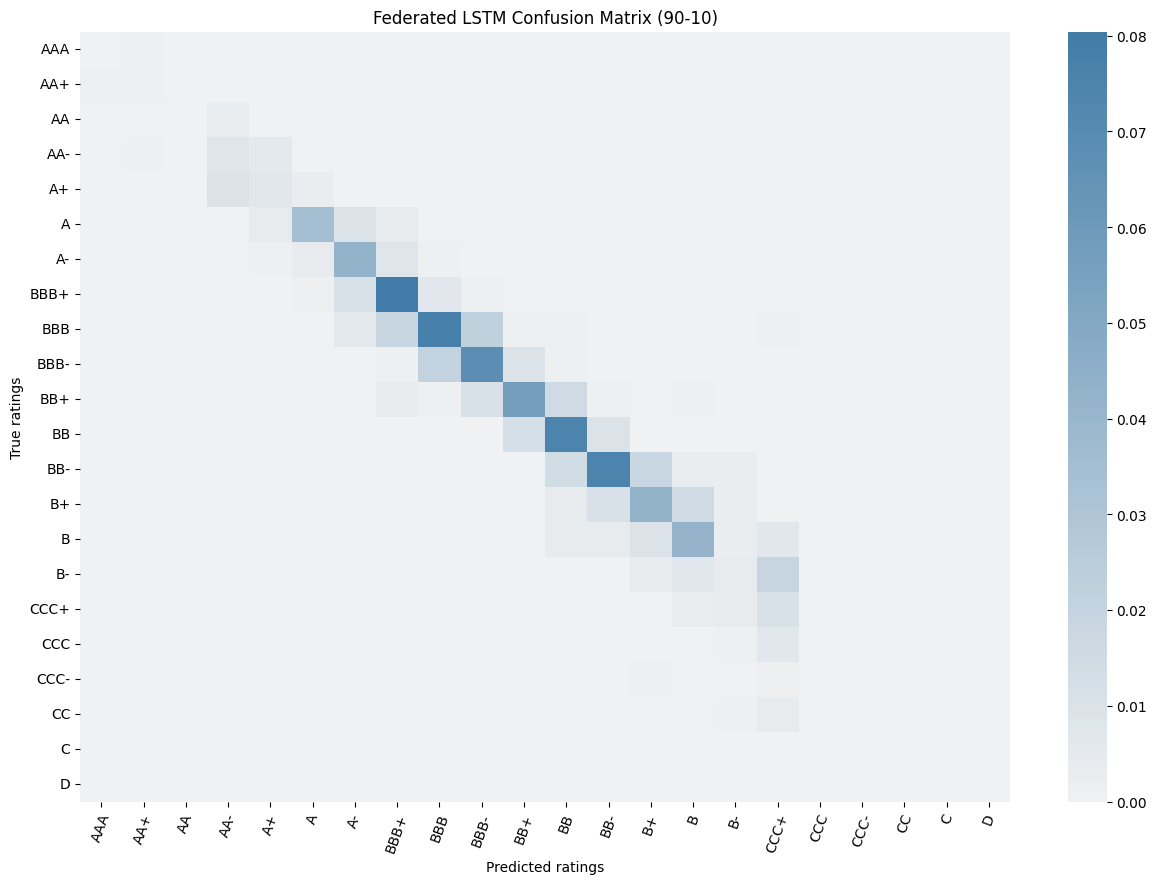

In [160]:
# 90-10
model_fl = run_lstm_simulation([0.9, 0.1], 'split_90_10', 16, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 17:15:42,661 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None)


(launch_and_fit pid=26381) Epoch: 16, Loss: 0.1147901639342308 [repeated 8x across cluster]
(launch_and_evaluate pid=26377) Client 0 evaluate, config {}


2023-06-15 17:15:46,932	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 17:15:47,485 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'CPU': 8.0, 'memory': 7901126656.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-15 17:15:47,485 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 17:15:47,485 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 17:15:48,313 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 17:15:48,313 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 17:15:48,314 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 17:15:48,314 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=26422) Epoch: 1, Loss: 18.627239227294922
(launch_and_fit pid=26422) Epoch: 2, Loss: 9.873430252075195
(launch_and_fit pid=26422) Epoch: 3, Loss: 12.403533935546875
(launch_and_fit pid=26422) Epoch: 4, Loss: 20.601791381835938
(launch_and_fit pid=26422) Epoch: 5, Loss: 9.044090270996094
(launch_and_fit pid=26422) Epoch: 6, Loss: 12.059480667114258
(launch_and_fit pid=26422) Epoch: 7, Loss: 10.66418170928955


DEBUG flwr 2023-06-15 17:15:51,186 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 17:15:51,199 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 17:15:51,220 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:15:51,311 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 17:15:51,311 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 17:15:51,311 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=26422) Client 2 evaluate, config {}
(launch_and_fit pid=26417) Epoch: 15, Loss: 4.545187473297119 [repeated 51x across cluster]


DEBUG flwr 2023-06-15 17:15:54,415 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:54,441 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:15:54,535 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:54,535 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 2 evaluate, config {} [repeated 3x across cluster]


DEBUG flwr 2023-06-15 17:15:57,672 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:57,698 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:15:57,846 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:15:57,847 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...
(launch_and_fit pid=26422) Epoch: 5, Loss: 3.98425555229187 [repeated 47x across cluster]


DEBUG flwr 2023-06-15 17:16:00,536 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:00,576 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:00,671 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:00,672 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 2 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 17:16:03,295 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:03,321 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:03,409 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:03,409 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=26417) Epoch: 1, Loss: 8.918066024780273 [repeated 57x across cluster]
(launch_and_evaluate pid=26417) Client 2 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:16:06,820 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:06,847 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:06,947 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:06,947 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...
(launch_and_fit pid=26422) Epoch: 12, Loss: 2.7348618507385254 [repeated 52x across cluster]


DEBUG flwr 2023-06-15 17:16:09,572 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:09,595 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:09,691 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:09,691 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 2 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 17:16:12,319 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:12,343 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:12,433 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:12,434 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=26422) Epoch: 6, Loss: 2.142610788345337 [repeated 55x across cluster]


DEBUG flwr 2023-06-15 17:16:15,847 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:15,875 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:15,968 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:15,969 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26422) Epoch: 14, Loss: 1.3481671810150146 [repeated 48x across cluster]


DEBUG flwr 2023-06-15 17:16:19,183 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:19,216 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:19,310 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:19,310 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 0 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:16:22,510 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:22,537 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:22,631 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:22,631 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=26422) Epoch: 8, Loss: 0.674834132194519 [repeated 48x across cluster]


DEBUG flwr 2023-06-15 17:16:25,889 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:25,918 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:26,005 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:26,006 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 1 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26422) Epoch: 14, Loss: 0.7997272610664368 [repeated 49x across cluster]


DEBUG flwr 2023-06-15 17:16:29,236 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:29,263 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:29,351 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:29,351 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 1 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:16:32,497 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:32,538 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:32,634 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:32,634 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...
(launch_and_fit pid=26422) Epoch: 8, Loss: 1.5314992666244507 [repeated 49x across cluster]


DEBUG flwr 2023-06-15 17:16:35,191 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:35,220 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:35,334 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:35,334 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 0 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 17:16:37,925 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:37,950 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:38,036 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:38,036 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...
(launch_and_fit pid=26417) Epoch: 6, Loss: 0.84322190284729 [repeated 59x across cluster]


DEBUG flwr 2023-06-15 17:16:41,235 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:41,264 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:41,377 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:41,377 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26422) Epoch: 16, Loss: 0.30511441826820374 [repeated 50x across cluster]


DEBUG flwr 2023-06-15 17:16:44,674 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:44,704 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:44,802 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:44,803 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 1 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:16:48,221 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:48,255 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:48,351 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:48,352 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...
(launch_and_fit pid=26422) Epoch: 3, Loss: 0.995739758014679 [repeated 42x across cluster]


DEBUG flwr 2023-06-15 17:16:51,657 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:51,686 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:51,776 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:51,776 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26422) Epoch: 11, Loss: 5.241276264190674 [repeated 51x across cluster]


DEBUG flwr 2023-06-15 17:16:54,929 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:54,958 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:55,053 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:55,054 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 3)


Saving round 21 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 2 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:16:57,664 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:57,702 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:16:57,798 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:16:57,798 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 3)


Saving round 22 aggregated_parameters...
(launch_and_fit pid=26422) Epoch: 9, Loss: 0.9346938729286194 [repeated 54x across cluster]


DEBUG flwr 2023-06-15 17:17:00,865 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:00,895 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:00,984 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:00,985 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 3)


Saving round 23 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 1 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 17:17:03,515 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:03,545 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:03,633 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:03,634 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 3)


Saving round 24 aggregated_parameters...
(launch_and_fit pid=26422) Epoch: 4, Loss: 0.4241981506347656 [repeated 56x across cluster]


DEBUG flwr 2023-06-15 17:17:06,294 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:06,326 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:06,415 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:06,416 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 3)


Saving round 25 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 0 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 17:17:09,568 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:09,596 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=26422) Epoch: 15, Loss: 0.9607845544815063 [repeated 56x across cluster]
Saving round 26 aggregated_parameters...


DEBUG flwr 2023-06-15 17:17:09,683 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:09,684 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=26417) Client 2 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:17:12,776 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:12,804 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:12,889 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:12,889 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 3)


Saving round 27 aggregated_parameters...
(launch_and_fit pid=26422) Epoch: 10, Loss: 0.46691715717315674 [repeated 50x across cluster]


DEBUG flwr 2023-06-15 17:17:15,812 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:15,847 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:15,984 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:15,985 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 3)


Saving round 28 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 2 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 17:17:19,246 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:19,273 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:19,390 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:19,391 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 3)


Saving round 29 aggregated_parameters...
(launch_and_fit pid=26422) Epoch: 1, Loss: 1.1994597911834717 [repeated 48x across cluster]


DEBUG flwr 2023-06-15 17:17:21,855 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:21,883 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:21,981 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:21,983 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 3)


Saving round 30 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26422) Epoch: 13, Loss: 0.4190109372138977 [repeated 59x across cluster]


DEBUG flwr 2023-06-15 17:17:25,082 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:25,112 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:25,209 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:25,210 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 3)


Saving round 31 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 0 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:17:28,550 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:28,600 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:28,720 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:28,720 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 3)


Saving round 32 aggregated_parameters...
(launch_and_fit pid=26422) Epoch: 5, Loss: 0.13294044137001038 [repeated 44x across cluster]


DEBUG flwr 2023-06-15 17:17:31,834 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:31,864 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:31,966 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:31,966 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 3)


Saving round 33 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 1 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 17:17:34,881 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:34,912 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=26422) Epoch: 15, Loss: 1.5334391593933105 [repeated 55x across cluster]
Saving round 34 aggregated_parameters...


DEBUG flwr 2023-06-15 17:17:35,003 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:35,004 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=26417) Client 1 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:17:38,175 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:38,228 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:38,368 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:38,369 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 3)


Saving round 35 aggregated_parameters...
(launch_and_fit pid=26422) Epoch: 9, Loss: 0.4495229125022888 [repeated 47x across cluster]


DEBUG flwr 2023-06-15 17:17:41,804 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:41,835 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:41,924 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:41,924 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 3)


Saving round 36 aggregated_parameters...
(launch_and_evaluate pid=26422) Client 1 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26422) Epoch: 14, Loss: 4.850244522094727 [repeated 48x across cluster]


DEBUG flwr 2023-06-15 17:17:45,232 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:45,260 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:45,358 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:45,359 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 3)


Saving round 37 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 2 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:17:47,886 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:47,909 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:48,008 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:48,008 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 3)


Saving round 38 aggregated_parameters...
(launch_and_fit pid=26422) Epoch: 11, Loss: 0.17361025512218475 [repeated 53x across cluster]


DEBUG flwr 2023-06-15 17:17:51,384 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:51,430 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:51,557 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:51,557 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 3)


Saving round 39 aggregated_parameters...
(launch_and_evaluate pid=26417) Client 0 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 17:17:54,803 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:17:54,831 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:17:54,920 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
INFO flwr 2023-06-15 17:17:54,921 | server.py:147 | FL finished in 126.60812558303587
INFO flwr 2023-06-15 17:17:54,923 | app.py:218 | app_fit: losses_distributed [(1, 57.30513176144244), (2, 56.81553398058252), (3, 56.80443828016644), (4, 56.793342579750345), (5, 56.793342579750345), (6, 56.80443828016644), (7, 12.486823855755894), (8, 1.4729542302357836), (9, 1.3092926490984744), (10, 1.4160887656033287), (11, 1.3495145631067962), (12, 1.3592233009708738), (13, 1.246879334257975), (14, 1.0776699029126213), (15, 1.0180305131761442), (16, 0.9791955617198336), (17, 0.9805825242718447), (18, 0.9667128987517337), (19, 0.9902912621359223), (20, 0.9916782246879334), (21, 0.95145631

Saving round 40 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_40_30_30/model_round_40.pth
1.0055478502080444
0.0022801538553470393
0.968288812890902
0.9688768606224628


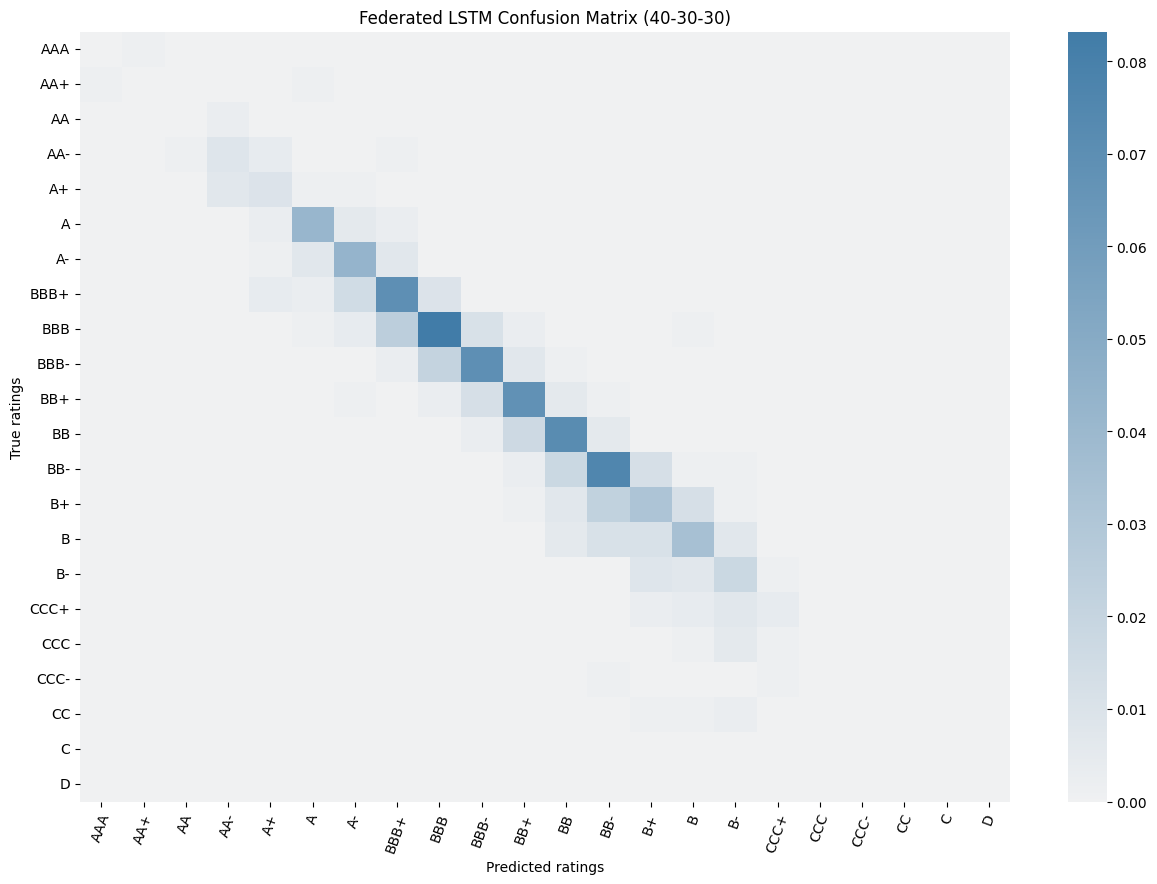

In [161]:
# 40-30-30
model_fl = run_lstm_simulation([0.4, 0.3, 0.3], 'split_40_30_30', 16, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (40-30-30)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 17:17:55,488 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None)


(launch_and_fit pid=26422) Epoch: 16, Loss: 0.7492135763168335 [repeated 45x across cluster]
(launch_and_evaluate pid=26417) Client 1 evaluate, config {} [repeated 2x across cluster]


2023-06-15 17:17:59,355	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 17:17:59,946 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'memory': 8024547328.0}
INFO flwr 2023-06-15 17:17:59,946 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 17:17:59,946 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 17:18:00,752 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 17:18:00,753 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 17:18:00,753 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 17:18:00,753 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=26473) Epoch: 1, Loss: 25.556217193603516
(launch_and_fit pid=26473) Epoch: 2, Loss: 26.473495483398438
(launch_and_fit pid=26473) Epoch: 3, Loss: 20.590288162231445
(launch_and_fit pid=26473) Epoch: 4, Loss: 25.25820541381836
(launch_and_fit pid=26473) Epoch: 5, Loss: 22.250530242919922
(launch_and_fit pid=26473) Epoch: 6, Loss: 25.043601989746094
(launch_and_fit pid=26473) Epoch: 7, Loss: 23.821434020996094
(launch_and_fit pid=26473) Epoch: 8, Loss: 25.47303009033203
(launch_and_fit pid=26473) Epoch: 9, Loss: 30.06351089477539
(launch_and_fit pid=26473) Epoch: 10, Loss: 26.122966766357422
(launch_and_fit pid=26473) Epoch: 11, Loss: 24.597824096679688
(launch_and_fit pid=26473) Epoch: 12, Loss: 25.79440689086914
(launch_and_fit pid=26473) Epoch: 13, Loss: 23.26224136352539
(launch_and_fit pid=26473) Epoch: 14, Loss: 17.807178497314453
(launch_and_fit pid=26473) Epoch: 15, Loss: 21.555130004882812
(launch_and_fit pid=26473) Epoch: 16, Loss: 17.238658905029297


DEBUG flwr 2023-06-15 17:18:02,241 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 17:18:02,255 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 17:18:02,279 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:18:02,371 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 17:18:02,371 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 17:18:02,372 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=26473) Client 0 evaluate, config {}
(launch_and_fit pid=26467) Epoch: 10, Loss: 24.552066802978516 [repeated 42x across cluster]
(launch_and_evaluate pid=26467) Epoch: 14, Loss: 19.31903648376465


DEBUG flwr 2023-06-15 17:18:08,037 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:08,071 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:18:08,158 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:08,158 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=26473) Client 0 evaluate, config {}


DEBUG flwr 2023-06-15 17:18:09,032 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:09,067 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:18:09,152 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:09,153 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 17:18:10,038 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:10,067 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:18:10,157 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:10,157 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 17:18:11,125 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:11,155 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:18:11,241 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:11,241 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=26473) Epoch: 16, Loss: 6.392805576324463 [repeated 99x across cluster]
Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 17:18:12,170 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:12,195 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:18:12,280 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:12,280 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=26467) Client 1 evaluate, config {} [repeated 9x across cluster]
(launch_and_fit pid=26467) Epoch: 10, Loss: 16.080787658691406 [repeated 61x across cluster]


DEBUG flwr 2023-06-15 17:18:18,252 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:18,280 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:18:18,372 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:18,372 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=26473) Client 0 evaluate, config {}


DEBUG flwr 2023-06-15 17:18:19,254 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:19,285 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:18:19,388 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:19,389 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 17:18:20,290 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:20,316 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:18:20,410 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:20,411 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=26473) Epoch: 14, Loss: 1.6022148132324219 [repeated 85x across cluster]
(launch_and_evaluate pid=26467) Client 0 evaluate, config {} [repeated 5x across cluster]


DEBUG flwr 2023-06-15 17:18:26,315 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:26,344 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:18:26,426 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:26,426 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...
(launch_and_fit pid=26467) Epoch: 15, Loss: 1.8182035684585571 [repeated 16x across cluster]
(launch_and_evaluate pid=26467) Client 2 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26467) Epoch: 14, Loss: 1.269465446472168 [repeated 31x across cluster]


DEBUG flwr 2023-06-15 17:18:32,253 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:32,295 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:18:32,388 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:32,388 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=26467) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26473) Epoch: 13, Loss: 1.066443920135498 [repeated 31x across cluster]


DEBUG flwr 2023-06-15 17:18:37,556 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:37,587 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:18:37,685 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:37,685 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=26467) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26467) Epoch: 11, Loss: 1.2015507221221924 [repeated 30x across cluster]


DEBUG flwr 2023-06-15 17:18:43,699 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:43,731 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:18:43,823 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:43,823 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=26467) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26473) Epoch: 10, Loss: 2.144611120223999 [repeated 31x across cluster]


DEBUG flwr 2023-06-15 17:18:49,219 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:49,247 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:18:49,334 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:49,335 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=26467) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26473) Epoch: 8, Loss: 1.9903757572174072 [repeated 30x across cluster]


DEBUG flwr 2023-06-15 17:18:55,235 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:55,265 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:18:55,355 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:18:55,356 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=26473) Client 0 evaluate, config {}
(launch_and_fit pid=26467) Epoch: 5, Loss: 1.6596006155014038 [repeated 29x across cluster]
(launch_and_evaluate pid=26467) Epoch: 13, Loss: 0.8769290447235107


DEBUG flwr 2023-06-15 17:19:01,664 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:01,701 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:19:01,794 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:01,795 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=26473) Client 2 evaluate, config {}
(launch_and_fit pid=26473) Epoch: 12, Loss: 0.29470881819725037 [repeated 24x across cluster]
(launch_and_evaluate pid=26467) Epoch: 14, Loss: 1.090993046760559
(launch_and_fit pid=26467) Epoch: 15, Loss: 1.5887789726257324 [repeated 18x across cluster]


DEBUG flwr 2023-06-15 17:19:07,868 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:07,896 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:19:07,990 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:07,991 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=26473) Client 0 evaluate, config {}
(launch_and_fit pid=26467) Epoch: 12, Loss: 1.8573565483093262 [repeated 29x across cluster]
(launch_and_evaluate pid=26467) Epoch: 14, Loss: 2.213183879852295


DEBUG flwr 2023-06-15 17:19:14,030 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:14,056 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:19:14,145 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:14,146 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=26473) Client 0 evaluate, config {}


DEBUG flwr 2023-06-15 17:19:15,032 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:15,063 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:19:15,168 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:15,169 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...
(launch_and_fit pid=26467) Epoch: 7, Loss: 1.1982611417770386 [repeated 59x across cluster]
(launch_and_evaluate pid=26467) Client 1 evaluate, config {} [repeated 3x across cluster]


DEBUG flwr 2023-06-15 17:19:21,182 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:21,207 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:19:21,306 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:21,306 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 17:19:22,149 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:22,175 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:19:22,265 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:22,265 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 3)


Saving round 21 aggregated_parameters...
(launch_and_fit pid=26473) Epoch: 2, Loss: 1.6136932373046875 [repeated 55x across cluster]
(launch_and_evaluate pid=26467) Client 2 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 17:19:27,835 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:27,864 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:19:27,954 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:27,955 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 3)


Saving round 22 aggregated_parameters...
(launch_and_fit pid=26467) Epoch: 2, Loss: 0.32403114438056946 [repeated 20x across cluster]
(launch_and_evaluate pid=26467) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26473) Epoch: 14, Loss: 0.6054953336715698 [repeated 28x across cluster]


DEBUG flwr 2023-06-15 17:19:33,811 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:33,833 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:19:33,924 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:33,924 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 3)


Saving round 23 aggregated_parameters...
(launch_and_evaluate pid=26467) Client 2 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:19:35,338 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:35,413 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:19:35,576 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:35,577 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 3)


Saving round 24 aggregated_parameters...
(launch_and_fit pid=26473) Epoch: 8, Loss: 0.9646259546279907 [repeated 58x across cluster]
(launch_and_evaluate pid=26473) Client 1 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:19:40,845 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:40,883 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:19:40,978 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:40,979 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 3)


Saving round 25 aggregated_parameters...


DEBUG flwr 2023-06-15 17:19:41,819 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:41,850 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:19:41,937 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:41,937 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 3)


Saving round 26 aggregated_parameters...
(launch_and_fit pid=26467) Epoch: 4, Loss: 1.2667616605758667 [repeated 60x across cluster]
(launch_and_evaluate pid=26467) Client 2 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 17:19:47,981 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:48,014 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:19:48,136 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:48,137 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 3)


Saving round 27 aggregated_parameters...
(launch_and_fit pid=26473) Epoch: 9, Loss: 0.5113966464996338 [repeated 27x across cluster]


DEBUG flwr 2023-06-15 17:19:49,005 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:49,032 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:19:49,120 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:49,121 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 3)


Saving round 28 aggregated_parameters...


DEBUG flwr 2023-06-15 17:19:50,024 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:50,049 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:19:50,135 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:50,135 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 3)


Saving round 29 aggregated_parameters...
(launch_and_evaluate pid=26467) Client 2 evaluate, config {} [repeated 6x across cluster]
(launch_and_fit pid=26473) Epoch: 10, Loss: 1.0106279850006104 [repeated 75x across cluster]


DEBUG flwr 2023-06-15 17:19:55,698 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:55,736 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:19:55,837 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:19:55,837 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 3)


Saving round 30 aggregated_parameters...
(launch_and_evaluate pid=26473) Client 2 evaluate, config {}
(launch_and_fit pid=26473) Epoch: 8, Loss: 0.21770818531513214 [repeated 30x across cluster]
(launch_and_evaluate pid=26467) Epoch: 12, Loss: 1.003676414489746


DEBUG flwr 2023-06-15 17:20:02,095 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:02,157 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:20:02,297 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:02,298 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 3)


Saving round 31 aggregated_parameters...
(launch_and_evaluate pid=26473) Client 0 evaluate, config {}
(launch_and_fit pid=26467) Epoch: 6, Loss: 0.4337815046310425 [repeated 30x across cluster]
(launch_and_evaluate pid=26467) Epoch: 14, Loss: 0.4111425280570984


DEBUG flwr 2023-06-15 17:20:07,988 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:08,028 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:20:08,132 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:08,132 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 3)


Saving round 32 aggregated_parameters...
(launch_and_evaluate pid=26473) Client 2 evaluate, config {}


DEBUG flwr 2023-06-15 17:20:08,976 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:09,006 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:20:09,100 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:09,101 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 3)


Saving round 33 aggregated_parameters...
(launch_and_fit pid=26473) Epoch: 10, Loss: 0.3962542414665222 [repeated 53x across cluster]
(launch_and_evaluate pid=26467) Client 1 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=26467) Epoch: 15, Loss: 0.9040840268135071 [repeated 20x across cluster]


DEBUG flwr 2023-06-15 17:20:15,019 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:15,050 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:20:15,159 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:15,159 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 3)


Saving round 34 aggregated_parameters...
(launch_and_evaluate pid=26467) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26473) Epoch: 14, Loss: 1.4329948425292969 [repeated 31x across cluster]


DEBUG flwr 2023-06-15 17:20:20,648 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:20,691 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:20:20,814 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:20,814 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 3)


Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-15 17:20:21,626 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:21,656 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:20:21,744 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:21,744 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 3)


Saving round 36 aggregated_parameters...
(launch_and_evaluate pid=26467) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26467) Epoch: 10, Loss: 0.38988223671913147 [repeated 60x across cluster]


DEBUG flwr 2023-06-15 17:20:27,683 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:27,735 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:20:27,853 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:27,854 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 3)


Saving round 37 aggregated_parameters...
(launch_and_evaluate pid=26467) Client 2 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26473) Epoch: 8, Loss: 0.6344127655029297 [repeated 30x across cluster]


DEBUG flwr 2023-06-15 17:20:32,998 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:33,041 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:20:33,158 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:33,159 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 3)


Saving round 38 aggregated_parameters...
(launch_and_evaluate pid=26467) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26467) Epoch: 7, Loss: 1.5206799507141113 [repeated 31x across cluster]


DEBUG flwr 2023-06-15 17:20:38,985 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:39,008 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:20:39,104 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:39,105 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 3)


Saving round 39 aggregated_parameters...
(launch_and_evaluate pid=26473) Client 1 evaluate, config {}


DEBUG flwr 2023-06-15 17:20:40,017 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:40,039 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 17:20:40,140 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
INFO flwr 2023-06-15 17:20:40,141 | server.py:147 | FL finished in 159.38904579216614
INFO flwr 2023-06-15 17:20:40,142 | app.py:218 | app_fit: losses_distributed [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 90.57420249653259), (5, 88.72676837725382), (6, 88.29403606102635), (7, 71.500693481276), (8, 71.40499306518724), (9, 71.39112343966713), (10, 1.0055478502080444), (11, 0.9292649098474342), (12, 0.9251040221914009), (13, 0.8821081830790569), (14, 0.8460471567267683), (15, 0.8474341192787794), (16, 0.8474341192787794), (17, 0.8599167822468793), (18, 0.871012482662968), (19, 0.9611650485436893), (20, 0.8613037447988904), (21, 0.918169209431

Saving round 40 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_80_10_10/model_round_40.pth
0.9902912621359223
0.0022455584175417737
0.9665018331946883
0.9679144385026738


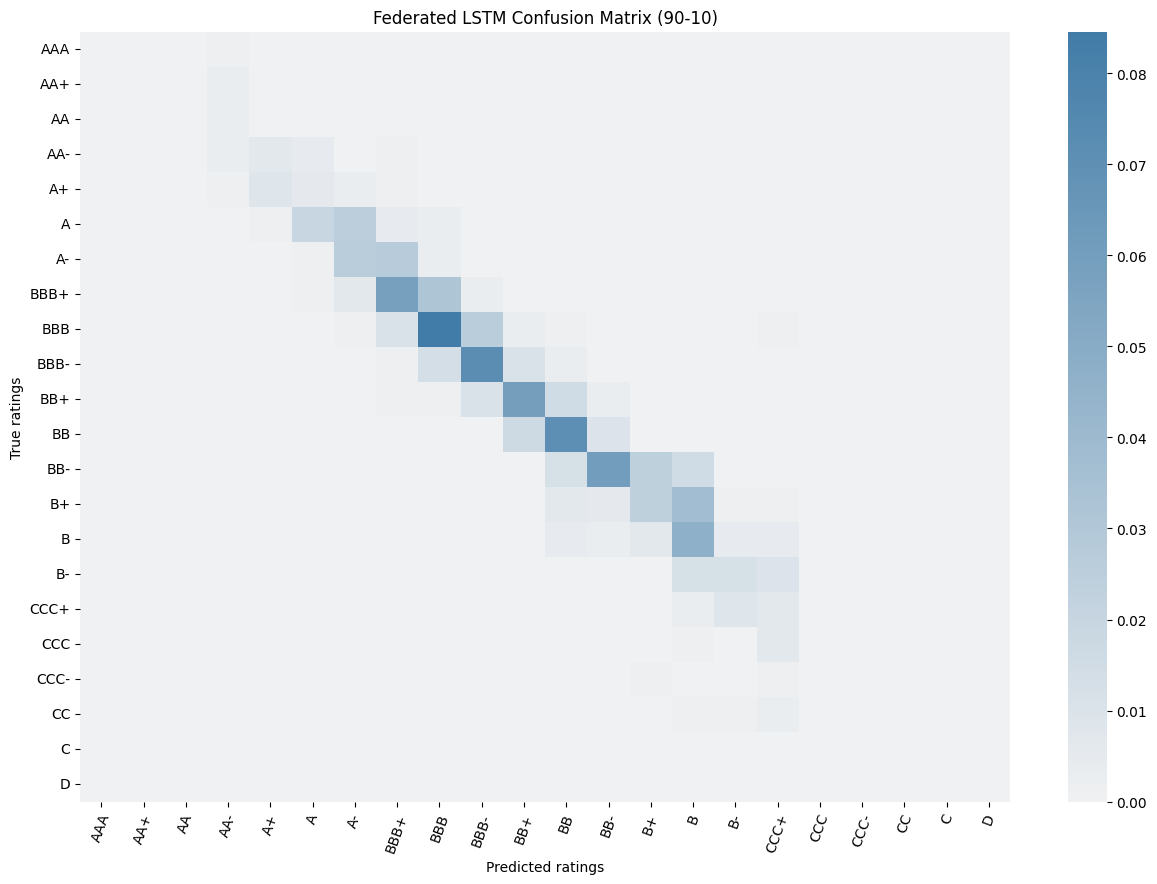

In [162]:
# 80-10-10
model_fl = run_lstm_simulation([0.8, 0.1, 0.1], 'split_80_10_10', 16, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 17:20:40,832 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None)


(launch_and_fit pid=26467) Epoch: 16, Loss: 0.38266417384147644 [repeated 41x across cluster]
(launch_and_evaluate pid=26467) Client 2 evaluate, config {} [repeated 3x across cluster]


2023-06-15 17:20:45,706	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 17:20:46,274 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 8232180122.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0}
INFO flwr 2023-06-15 17:20:46,274 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 17:20:46,275 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 17:20:47,186 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 17:20:47,186 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 17:20:47,187 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 17:20:47,187 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=26562) Epoch: 1, Loss: 36.989967346191406
(launch_and_fit pid=26562) Epoch: 2, Loss: 37.53718566894531
(launch_and_fit pid=26562) Epoch: 3, Loss: 33.30519104003906
(launch_and_fit pid=26562) Epoch: 4, Loss: 31.298107147216797
(launch_and_fit pid=26562) Epoch: 5, Loss: 37.31718444824219
(launch_and_fit pid=26562) Epoch: 6, Loss: 35.51616287231445
(launch_and_fit pid=26562) Epoch: 7, Loss: 42.05242919921875
(launch_and_fit pid=26562) Epoch: 8, Loss: 33.78361511230469
(launch_and_fit pid=26562) Epoch: 9, Loss: 26.180633544921875
(launch_and_fit pid=26562) Epoch: 10, Loss: 21.283000946044922


DEBUG flwr 2023-06-15 17:20:49,281 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 17:20:49,307 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 17:20:49,328 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:20:49,423 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 17:20:49,424 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 17:20:49,424 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=26562) Client 2 evaluate, config {}


DEBUG flwr 2023-06-15 17:20:50,930 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:50,960 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:20:51,060 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:51,060 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...
(launch_and_fit pid=26562) Epoch: 13, Loss: 18.91483497619629 [repeated 79x across cluster]


DEBUG flwr 2023-06-15 17:20:52,623 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:52,650 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:20:52,737 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:52,737 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 17:20:54,457 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:54,489 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:20:54,586 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:54,587 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=26565) Client 2 evaluate, config {} [repeated 5x across cluster]


DEBUG flwr 2023-06-15 17:20:56,307 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:56,337 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:20:56,439 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:56,439 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=26562) Epoch: 10, Loss: 10.281752586364746 [repeated 90x across cluster]


DEBUG flwr 2023-06-15 17:20:58,011 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:58,041 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:20:58,130 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:58,131 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...
(launch_and_fit pid=26562) 


DEBUG flwr 2023-06-15 17:20:59,725 | server.py:232 | fit_round 7 received 2 results and 0 failures


(launch_and_evaluate pid=26565) Client 1 evaluate, config {} [repeated 6x across cluster]
Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 17:20:59,757 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:20:59,855 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:20:59,856 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:01,456 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:01,486 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:01,571 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:01,571 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=26562) Epoch: 9, Loss: 10.5227689743042 [repeated 94x across cluster]


DEBUG flwr 2023-06-15 17:21:03,248 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:03,274 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:03,362 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:03,363 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=26565) Client 2 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 17:21:05,098 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:05,131 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:05,223 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:05,224 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 17:21:06,866 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:06,898 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:06,993 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:06,994 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=26562) Epoch: 3, Loss: 4.457000255584717 [repeated 84x across cluster]


DEBUG flwr 2023-06-15 17:21:08,729 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:08,763 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:08,864 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:08,864 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=26565) Client 4 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 17:21:10,370 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:10,400 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:10,488 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:10,489 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 17:21:11,993 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:12,023 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:12,135 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:12,136 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...
(launch_and_fit pid=26562) Epoch: 4, Loss: 2.4241397380828857 [repeated 98x across cluster]


DEBUG flwr 2023-06-15 17:21:13,826 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:13,851 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:13,942 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:13,943 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=26565) Client 2 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 17:21:15,589 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:15,619 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:15,706 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:15,706 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 17:21:17,343 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:17,372 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:17,457 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:17,458 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...
(launch_and_fit pid=26562) Epoch: 1, Loss: 1.3642704486846924 [repeated 90x across cluster]


DEBUG flwr 2023-06-15 17:21:19,063 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:19,091 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:19,179 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:19,180 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=26565) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 17:21:20,744 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:20,772 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:20,861 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:20,861 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 17:21:22,478 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:22,506 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:22,592 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:22,592 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...
(launch_and_fit pid=26562) Epoch: 1, Loss: 1.094090461730957 [repeated 96x across cluster]


DEBUG flwr 2023-06-15 17:21:24,206 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:24,246 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:24,340 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:24,341 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 5)


Saving round 21 aggregated_parameters...
(launch_and_evaluate pid=26565) Client 1 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 17:21:25,944 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:25,974 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:26,062 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:26,062 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 5)


Saving round 22 aggregated_parameters...


DEBUG flwr 2023-06-15 17:21:27,705 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:27,731 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:27,820 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:27,820 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 5)


Saving round 23 aggregated_parameters...
(launch_and_fit pid=26562) Epoch: 1, Loss: 2.149432420730591 [repeated 96x across cluster]


DEBUG flwr 2023-06-15 17:21:29,405 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:29,451 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:29,582 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:29,583 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 5)


Saving round 24 aggregated_parameters...
(launch_and_evaluate pid=26565) Client 3 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 17:21:31,209 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:31,241 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:31,332 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:31,333 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 5)


Saving round 25 aggregated_parameters...


DEBUG flwr 2023-06-15 17:21:32,842 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:32,873 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:32,966 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:32,966 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 5)


Saving round 26 aggregated_parameters...
(launch_and_fit pid=26565) Epoch: 16, Loss: 0.7913252115249634 [repeated 95x across cluster]


DEBUG flwr 2023-06-15 17:21:34,588 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:34,615 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:34,707 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:34,707 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 5)


Saving round 27 aggregated_parameters...
(launch_and_evaluate pid=26565) Client 1 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 17:21:36,320 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:36,354 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:36,448 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:36,448 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 5)


Saving round 28 aggregated_parameters...


DEBUG flwr 2023-06-15 17:21:38,018 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:38,046 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:38,134 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:38,135 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=26562) Epoch: 16, Loss: 1.2273099422454834 [repeated 95x across cluster]
Saving round 29 aggregated_parameters...


DEBUG flwr 2023-06-15 17:21:39,739 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:39,766 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:39,850 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:39,851 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 5)


Saving round 30 aggregated_parameters...
(launch_and_evaluate pid=26565) Client 4 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 17:21:41,468 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:41,499 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:41,588 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:41,588 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 5)


Saving round 31 aggregated_parameters...


DEBUG flwr 2023-06-15 17:21:43,173 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:43,212 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=26562) Epoch: 15, Loss: 2.699782371520996 [repeated 94x across cluster]
Saving round 32 aggregated_parameters...


DEBUG flwr 2023-06-15 17:21:43,302 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:43,302 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:44,920 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:44,951 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:45,045 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:45,046 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 5)


Saving round 33 aggregated_parameters...
(launch_and_evaluate pid=26562) Client 3 evaluate, config {} [repeated 5x across cluster]


DEBUG flwr 2023-06-15 17:21:46,726 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:46,752 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:46,842 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:46,842 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 5)


Saving round 34 aggregated_parameters...
(launch_and_fit pid=26562) Epoch: 12, Loss: 0.7587481737136841 [repeated 90x across cluster]


DEBUG flwr 2023-06-15 17:21:48,469 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:48,502 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:48,592 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:48,592 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 5)


Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-15 17:21:50,214 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:50,243 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=26565) Client 2 evaluate, config {} [repeated 5x across cluster]
Saving round 36 aggregated_parameters...


DEBUG flwr 2023-06-15 17:21:50,332 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:50,332 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:52,024 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:52,052 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:52,142 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:52,142 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 5)


Saving round 37 aggregated_parameters...
(launch_and_fit pid=26562) Epoch: 8, Loss: 1.5828754901885986 [repeated 89x across cluster]


DEBUG flwr 2023-06-15 17:21:53,868 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:53,902 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:53,992 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:53,993 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 5)


Saving round 38 aggregated_parameters...
(launch_and_evaluate pid=26565) Client 2 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 17:21:55,680 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:55,708 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:55,796 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:55,796 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 5)


Saving round 39 aggregated_parameters...


DEBUG flwr 2023-06-15 17:21:57,551 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:21:57,591 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:21:57,692 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
INFO flwr 2023-06-15 17:21:57,692 | server.py:147 | FL finished in 70.50648383400403
INFO flwr 2023-06-15 17:21:57,695 | app.py:218 | app_fit: losses_distributed [(1, 88.64909847434119), (2, 88.33287101248267), (3, 88.23300970873787), (4, 88.00693481276005), (5, 74.03606102635229), (6, 71.49791955617198), (7, 71.41470180305132), (8, 71.41470180305132), (9, 71.40221914008322), (10, 9.765603328710124), (11, 2.2149791955617197), (12, 2.0374479889042996), (13, 1.9472954230235784), (14, 1.9223300970873787), (15, 1.9251040221914009), (16, 1.9209431345353676), (17, 1.0416088765603329), (18, 1.1054091539528432), (19, 1.072122052704577), (20, 1.0984743411927878), (21, 1.037447988904299

Saving round 40 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_20_20_20_20_20/model_round_40.pth
1.0180305131761442
0.0023084592135513473
0.9649805897032997
0.9667110519307589


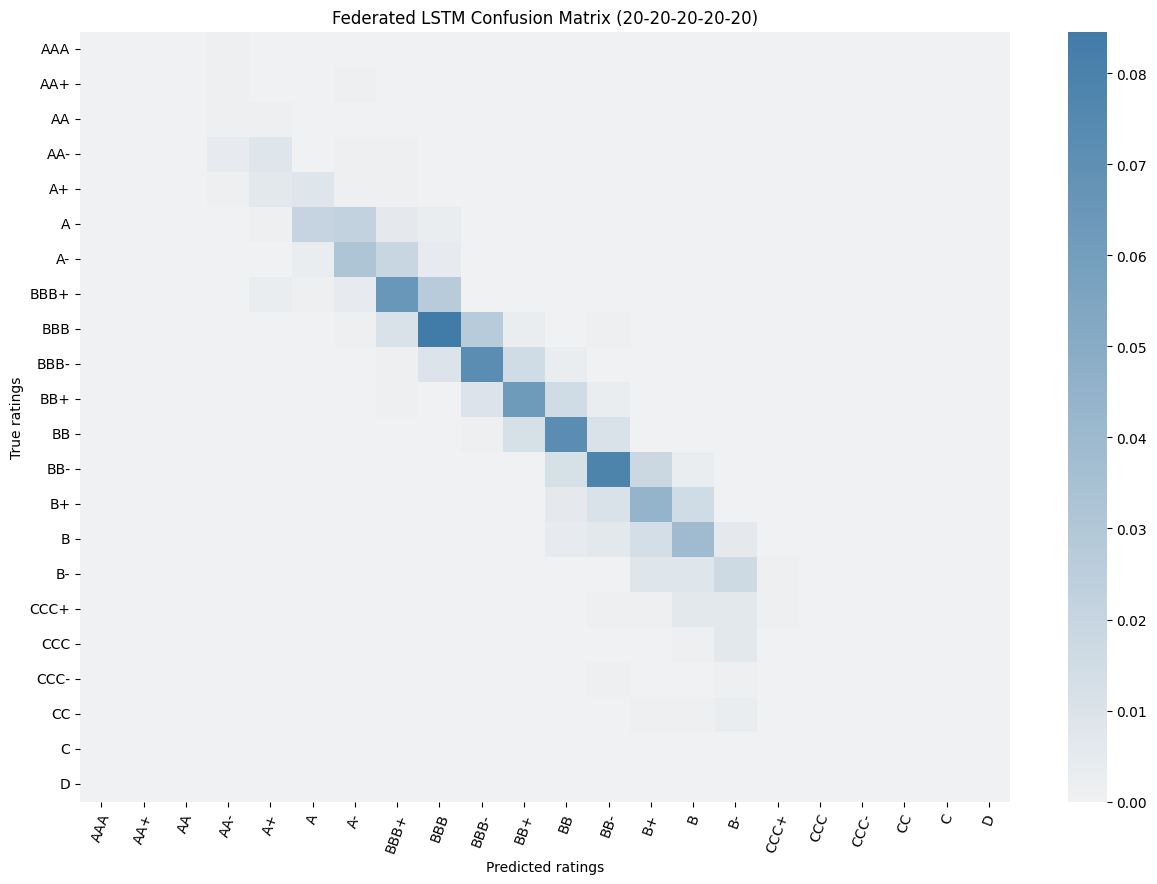

In [163]:
# 20-20-20-20-20
model_fl = run_lstm_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', 16, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (20-20-20-20-20)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 17:21:58,329 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None)


(launch_and_fit pid=26565) Epoch: 16, Loss: 1.7536283731460571 [repeated 80x across cluster]
(launch_and_evaluate pid=26565) Client 4 evaluate, config {} [repeated 4x across cluster]


2023-06-15 17:22:01,995	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 17:22:02,558 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 8123283866.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-15 17:22:02,558 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 17:22:02,559 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 17:22:03,396 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 17:22:03,397 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 17:22:03,397 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 17:22:03,397 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=26600) Epoch: 1, Loss: 26.241439819335938
(launch_and_fit pid=26600) Epoch: 2, Loss: 22.374217987060547
(launch_and_fit pid=26600) Epoch: 3, Loss: 24.238094329833984
(launch_and_fit pid=26600) Epoch: 4, Loss: 6.784873008728027
(launch_and_fit pid=26600) Epoch: 5, Loss: 18.185842514038086
(launch_and_fit pid=26600) Epoch: 6, Loss: 28.563369750976562
(launch_and_fit pid=26600) Epoch: 7, Loss: 19.777442932128906
(launch_and_fit pid=26600) Epoch: 8, Loss: 25.321266174316406
(launch_and_fit pid=26600) Epoch: 9, Loss: 22.397258758544922
(launch_and_fit pid=26600) Epoch: 10, Loss: 27.445728302001953
(launch_and_fit pid=26600) Epoch: 11, Loss: 6.580713272094727
(launch_and_fit pid=26600) Epoch: 12, Loss: 22.245914459228516
(launch_and_fit pid=26600) Epoch: 13, Loss: 26.74789047241211
(launch_and_fit pid=26600) Epoch: 14, Loss: 20.813095092773438
(launch_and_fit pid=26600) Epoch: 15, Loss: 21.610584259033203
(launch_and_fit pid=26600) Epoch: 16, Loss: 14.042509078979492


DEBUG flwr 2023-06-15 17:22:07,803 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 17:22:07,815 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 17:22:07,837 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:07,933 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 17:22:07,933 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 17:22:07,933 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=26600) Client 3 evaluate, config {}


DEBUG flwr 2023-06-15 17:22:08,751 | server.py:232 | fit_round 2 received 2 results and 0 failures


(launch_and_fit pid=26600) Epoch: 12, Loss: 6.501124382019043 [repeated 38x across cluster]
Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 17:22:08,785 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:08,876 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:08,877 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:09,717 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:09,748 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:09,835 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:09,835 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 4 evaluate, config {} [repeated 5x across cluster]
(launch_and_fit pid=26600) Epoch: 14, Loss: 12.896838188171387 [repeated 72x across cluster]


DEBUG flwr 2023-06-15 17:22:14,061 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:14,092 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:14,183 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:14,183 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 17:22:15,150 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:15,174 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:15,278 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:15,278 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26600) Epoch: 12, Loss: 8.486090660095215 [repeated 62x across cluster]


DEBUG flwr 2023-06-15 17:22:19,697 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:19,729 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:19,831 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:19,832 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 3 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26595) Epoch: 15, Loss: 2.435516834259033 [repeated 35x across cluster]


DEBUG flwr 2023-06-15 17:22:23,967 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:23,997 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:24,094 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:24,094 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 17:22:28,390 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:28,417 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:28,525 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:28,526 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26600) Epoch: 4, Loss: 1.4247047901153564 [repeated 37x across cluster]


DEBUG flwr 2023-06-15 17:22:33,029 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:33,073 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:33,175 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:33,175 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26600) Epoch: 13, Loss: 1.2638890743255615 [repeated 43x across cluster]


DEBUG flwr 2023-06-15 17:22:37,170 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:37,204 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:37,296 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:37,297 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 17:22:38,113 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:38,143 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:38,228 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:38,229 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26600) Epoch: 11, Loss: 0.792019784450531 [repeated 69x across cluster]


DEBUG flwr 2023-06-15 17:22:39,182 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:39,211 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:39,310 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:39,311 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 17:22:43,338 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:43,370 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:43,457 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:43,458 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=26600) Client 4 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26600) Epoch: 8, Loss: 0.37162071466445923 [repeated 58x across cluster]


DEBUG flwr 2023-06-15 17:22:44,327 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:44,357 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:44,447 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:44,447 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 17:22:48,710 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:48,742 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:48,835 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:48,836 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=26600) Client 3 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=26600) Epoch: 2, Loss: 0.8470636606216431 [repeated 52x across cluster]


DEBUG flwr 2023-06-15 17:22:52,917 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:52,955 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:53,049 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:53,050 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 4 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=26600) Epoch: 16, Loss: 0.3042343258857727 [repeated 49x across cluster]


DEBUG flwr 2023-06-15 17:22:57,169 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:57,201 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:57,294 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:57,295 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 17:22:58,772 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:58,820 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:22:58,932 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:22:58,932 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 4 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26600) Epoch: 1, Loss: 0.4395153522491455 [repeated 46x across cluster]


DEBUG flwr 2023-06-15 17:23:03,029 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:03,079 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 17:23:03,267 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:03,267 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=26595) Client 1 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26600) Epoch: 16, Loss: 0.13192619383335114 [repeated 49x across cluster]


DEBUG flwr 2023-06-15 17:23:07,199 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:07,229 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:07,313 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:07,313 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26595) Epoch: 7, Loss: 1.1861516237258911 [repeated 37x across cluster]


DEBUG flwr 2023-06-15 17:23:11,525 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:11,551 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:11,636 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:11,636 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 5)


Saving round 21 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 3 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26600) Epoch: 10, Loss: 2.1932833194732666 [repeated 35x across cluster]


DEBUG flwr 2023-06-15 17:23:15,960 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:15,989 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:16,074 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:16,074 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 5)


Saving round 22 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 4 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26600) Epoch: 12, Loss: 2.242642641067505 [repeated 34x across cluster]


DEBUG flwr 2023-06-15 17:23:20,671 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:20,708 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:20,798 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:20,799 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 5)


Saving round 23 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 4 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 17:23:24,839 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:24,869 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:24,956 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:24,956 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 5)


Saving round 24 aggregated_parameters...
(launch_and_fit pid=26600) Epoch: 16, Loss: 1.1849515438079834 [repeated 36x across cluster]


DEBUG flwr 2023-06-15 17:23:29,390 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:29,422 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:29,525 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:29,526 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 5)


Saving round 25 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 4 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=26595) Epoch: 1, Loss: 1.4113397598266602 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 17:23:33,638 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:33,676 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:33,763 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:33,763 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 5)


Saving round 26 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 1 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26595) Epoch: 4, Loss: 4.199764251708984 [repeated 46x across cluster]
(launch_and_fit pid=26595) 


DEBUG flwr 2023-06-15 17:23:38,001 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:38,037 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:38,153 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:38,154 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 5)


Saving round 27 aggregated_parameters...


DEBUG flwr 2023-06-15 17:23:39,046 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:39,098 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:39,189 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:39,189 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 5)


Saving round 28 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 4 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 17:23:40,089 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:40,122 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=26600) Epoch: 13, Loss: 1.9631909132003784 [repeated 68x across cluster]
Saving round 29 aggregated_parameters...


DEBUG flwr 2023-06-15 17:23:40,209 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:40,210 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:41,172 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:41,208 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 5)


Saving round 30 aggregated_parameters...


DEBUG flwr 2023-06-15 17:23:41,446 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:41,446 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=26595) Client 2 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26595) Epoch: 14, Loss: 1.7543505430221558 [repeated 70x across cluster]


DEBUG flwr 2023-06-15 17:23:45,568 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:45,601 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:45,709 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:45,710 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 5)


Saving round 31 aggregated_parameters...


DEBUG flwr 2023-06-15 17:23:46,541 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:46,570 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:46,660 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:46,661 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 5)


Saving round 32 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26595) Epoch: 14, Loss: 1.8306910991668701 [repeated 64x across cluster]


DEBUG flwr 2023-06-15 17:23:50,756 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:50,785 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:50,878 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:50,878 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 5)


Saving round 33 aggregated_parameters...


DEBUG flwr 2023-06-15 17:23:51,764 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:51,792 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:51,887 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:51,887 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 5)


Saving round 34 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 2 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=26595) Epoch: 13, Loss: 0.729020893573761 [repeated 63x across cluster]


DEBUG flwr 2023-06-15 17:23:56,246 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:56,271 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:56,360 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:56,361 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 5)


Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-15 17:23:57,245 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:57,276 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:57,366 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:57,367 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 5)


Saving round 36 aggregated_parameters...


DEBUG flwr 2023-06-15 17:23:58,272 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:58,300 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:58,394 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:58,395 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 5)


Saving round 37 aggregated_parameters...


DEBUG flwr 2023-06-15 17:23:59,343 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:59,383 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:23:59,482 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:23:59,483 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 5)


Saving round 38 aggregated_parameters...
(launch_and_evaluate pid=26595) Client 0 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 17:24:00,449 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:24:00,474 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:24:00,574 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:24:00,574 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 5)


Saving round 39 aggregated_parameters...
(launch_and_fit pid=26595) Epoch: 16, Loss: 0.2397310435771942 [repeated 131x across cluster]


DEBUG flwr 2023-06-15 17:24:01,426 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 17:24:01,459 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 17:24:01,556 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
INFO flwr 2023-06-15 17:24:01,556 | server.py:147 | FL finished in 118.16031733318232
INFO flwr 2023-06-15 17:24:01,558 | app.py:218 | app_fit: losses_distributed [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 127.17337031900139), (5, 127.17337031900139), (6, 9.084604715672677), (7, 5.325936199722608), (8, 5.235783633841886), (9, 1.058252427184466), (10, 1.3092926490984744), (11, 1.0527045769764216), (12, 1.2357836338418862), (13, 1.0194174757281553), (14, 1.0374479889042996), (15, 1.0027739251040222), (16, 1.0346740638002774), (17, 1.015256588072122), (18, 1.2246879334257974), (19, 1.027739251040222), (20, 1.001386962552011), (21, 1.0402219140

Saving round 40 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_60_10_10_10_10/model_round_40.pth
1.19001386962552
0.0026984441488107033
0.9655120621129494
0.9661705006765899


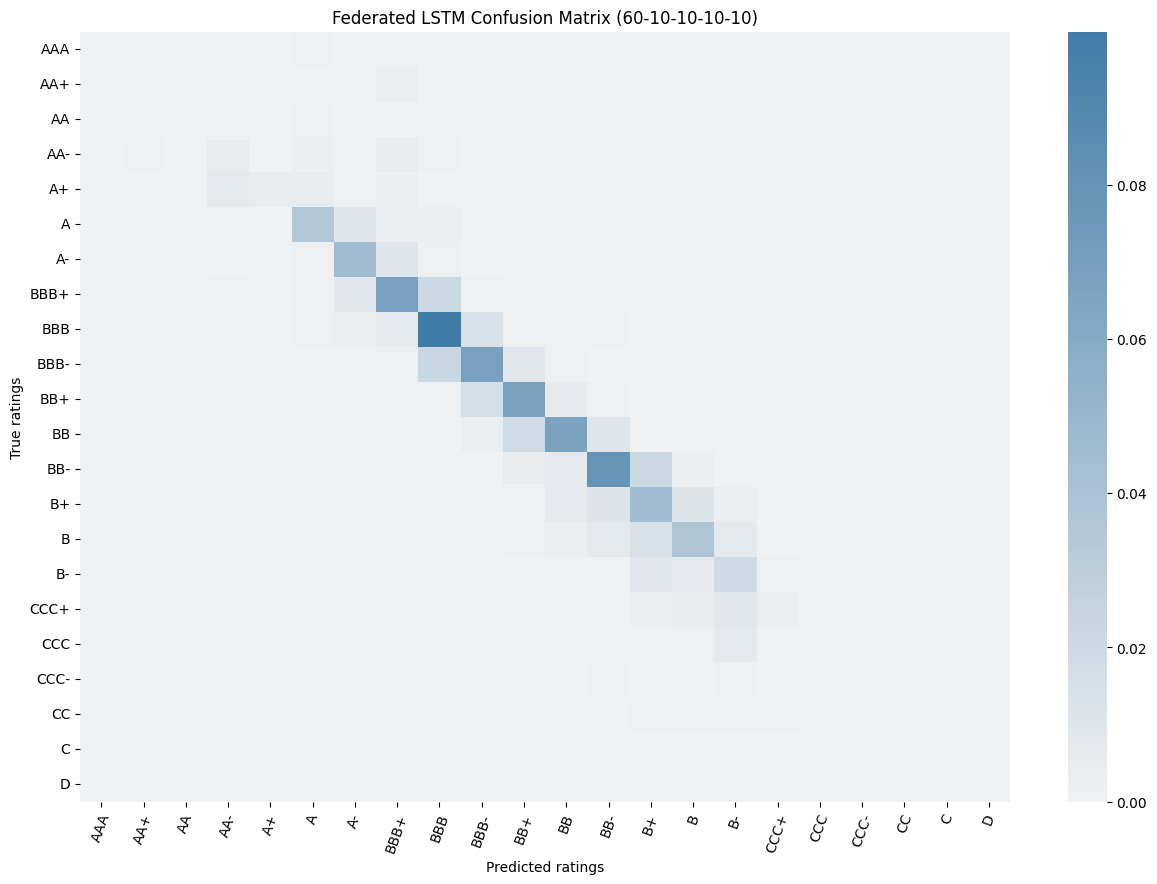

In [164]:
# 60-10-10-10-10
model_fl = run_lstm_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', 16, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (60-10-10-10-10)')

Text(0.5, 1.0, 'Num epoch: 16')

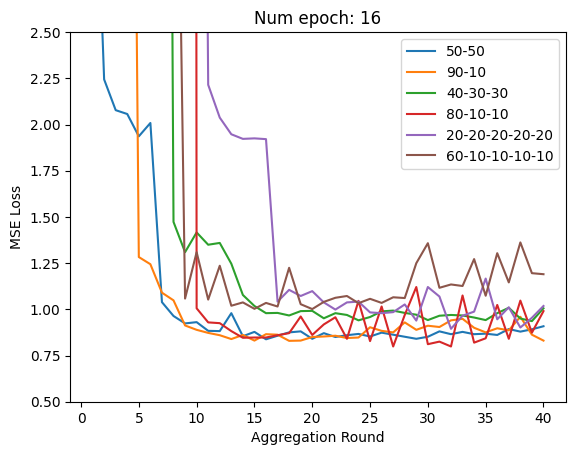

In [179]:
# Visualise loss convergence 16 epoch
ax = plt.gca()
ax.set_ylim([0.5, 2.5])
plot_loss([[(1, 3.938973647711512), (2, 2.2441054091539527), (3, 2.0776699029126213), (4, 2.056865464632455), (5, 1.9361997226074896), (6, 2.0083217753120666), (7, 1.0388349514563107), (8, 0.9639389736477115), (9, 0.9237170596393898), (10, 0.9306518723994452), (11, 0.883495145631068), (12, 0.8821081830790569), (13, 0.9791955617198336), (14, 0.8543689320388349), (15, 0.8779472954230236), (16, 0.8377253814147018), (17, 0.8571428571428571), (18, 0.8751733703190014), (19, 0.8807212205270458), (20, 0.840499306518724), (21, 0.871012482662968), (22, 0.8502080443828016), (23, 0.8599167822468793), (24, 0.8668515950069348), (25, 0.8529819694868238), (26, 0.8737864077669902), (27, 0.8626907073509015), (28, 0.8515950069348127), (29, 0.840499306518724), (30, 0.8515950069348127), (31, 0.8807212205270458), (32, 0.8654646324549237), (33, 0.8779472954230236), (34, 0.8654646324549237), (35, 0.8682385575589459), (36, 0.8613037447988904), (37, 0.8932038834951457), (38, 0.8793342579750347), (39, 0.8918169209431346), (40, 0.9084604715672677)]
, [(1, 8.402219140083218), (2, 8.162274618585299), (3, 8.10124826629681), (4, 8.090152565880722), (5, 1.2829403606102636), (6, 1.2441054091539527), (7, 1.0901525658807212), (8, 1.0485436893203883), (9, 0.912621359223301), (10, 0.8890429958391124), (11, 0.8723994452149791), (12, 0.8599167822468793), (13, 0.8391123439667129), (14, 0.8613037447988904), (15, 0.8307905686546463), (16, 0.8654646324549237), (17, 0.8626907073509015), (18, 0.8294036061026352), (19, 0.8307905686546463), (20, 0.8502080443828016), (21, 0.8529819694868238), (22, 0.8571428571428571), (23, 0.8446601941747572), (24, 0.8474341192787794), (25, 0.9029126213592233), (26, 0.883495145631068), (27, 0.8751733703190014), (28, 0.9292649098474342), (29, 0.8890429958391124), (30, 0.9112343966712899), (31, 0.9042995839112344), (32, 0.9403606102635229), (33, 0.9486823855755895), (34, 0.9001386962552012), (35, 0.8751733703190014), (36, 0.897364771151179), (37, 0.8862690707350902), (38, 0.9597780859916782), (39, 0.8626907073509015), (40, 0.8307905686546463)]
, [(1, 57.30513176144244), (2, 56.81553398058252), (3, 56.80443828016644), (4, 56.793342579750345), (5, 56.793342579750345), (6, 56.80443828016644), (7, 12.486823855755894), (8, 1.4729542302357836), (9, 1.3092926490984744), (10, 1.4160887656033287), (11, 1.3495145631067962), (12, 1.3592233009708738), (13, 1.246879334257975), (14, 1.0776699029126213), (15, 1.0180305131761442), (16, 0.9791955617198336), (17, 0.9805825242718447), (18, 0.9667128987517337), (19, 0.9902912621359223), (20, 0.9916782246879334), (21, 0.9514563106796117), (22, 0.9791955617198336), (23, 0.9694868238557559), (24, 0.9403606102635229), (25, 0.9583911234396671), (26, 0.9889042995839112), (27, 0.9930651872399445), (28, 0.9805825242718447), (29, 0.970873786407767), (30, 0.941747572815534), (31, 0.9653259361997226), (32, 0.9694868238557559), (33, 0.9667128987517337), (34, 0.955617198335645), (35, 0.941747572815534), (36, 0.9791955617198336), (37, 1.0083217753120666), (38, 0.9500693481276006), (39, 0.9361997226074896), (40, 1.0055478502080444)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 90.57420249653259), (5, 88.72676837725382), (6, 88.29403606102635), (7, 71.500693481276), (8, 71.40499306518724), (9, 71.39112343966713), (10, 1.0055478502080444), (11, 0.9292649098474342), (12, 0.9251040221914009), (13, 0.8821081830790569), (14, 0.8460471567267683), (15, 0.8474341192787794), (16, 0.8474341192787794), (17, 0.8599167822468793), (18, 0.871012482662968), (19, 0.9611650485436893), (20, 0.8613037447988904), (21, 0.9181692094313454), (22, 0.957004160887656), (23, 0.840499306518724), (24, 1.0457697642163661), (25, 0.8280166435506241), (26, 1.015256588072122), (27, 0.7988904299583911), (28, 0.9694868238557559), (29, 1.1206657420249653), (30, 0.811373092926491), (31, 0.8252427184466019), (32, 0.7988904299583911), (33, 1.0748959778085991), (34, 0.8196948682385575), (35, 0.8432732316227461), (36, 1.0235783633841886), (37, 0.840499306518724), (38, 1.0471567267683772), (39, 0.8737864077669902), (40, 0.9902912621359223)]
, [(1, 88.64909847434119), (2, 88.33287101248267), (3, 88.23300970873787), (4, 88.00693481276005), (5, 74.03606102635229), (6, 71.49791955617198), (7, 71.41470180305132), (8, 71.41470180305132), (9, 71.40221914008322), (10, 9.765603328710124), (11, 2.2149791955617197), (12, 2.0374479889042996), (13, 1.9472954230235784), (14, 1.9223300970873787), (15, 1.9251040221914009), (16, 1.9209431345353676), (17, 1.0416088765603329), (18, 1.1054091539528432), (19, 1.072122052704577), (20, 1.0984743411927878), (21, 1.0374479889042996), (22, 0.9986130374479889), (23, 1.0374479889042996), (24, 1.0416088765603329), (25, 0.9833564493758669), (26, 0.9791955617198336), (27, 0.984743411927878), (28, 1.0263522884882108), (29, 0.9389736477115118), (30, 1.1206657420249653), (31, 1.0693481276005548), (32, 0.8945908460471568), (33, 0.9653259361997226), (34, 0.9875173370319001), (35, 1.1664355062413314), (36, 0.9459084604715673), (37, 1.0110957004160888), (38, 0.9015256588072122), (39, 0.9542302357836339), (40, 1.0180305131761442)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 127.17337031900139), (5, 127.17337031900139), (6, 9.084604715672677), (7, 5.325936199722608), (8, 5.235783633841886), (9, 1.058252427184466), (10, 1.3092926490984744), (11, 1.0527045769764216), (12, 1.2357836338418862), (13, 1.0194174757281553), (14, 1.0374479889042996), (15, 1.0027739251040222), (16, 1.0346740638002774), (17, 1.015256588072122), (18, 1.2246879334257974), (19, 1.027739251040222), (20, 1.001386962552011), (21, 1.0402219140083218), (22, 1.0624133148404993), (23, 1.072122052704577), (24, 1.0332871012482663), (25, 1.056865464632455), (26, 1.0346740638002774), (27, 1.0651872399445215), (28, 1.0610263522884882), (29, 1.2496532593619971), (30, 1.3578363384188628), (31, 1.116504854368932), (32, 1.1345353675450762), (33, 1.1262135922330097), (34, 1.2718446601941749), (35, 1.073509015256588), (36, 1.30374479889043), (37, 1.145631067961165), (38, 1.361997226074896), (39, 1.1955617198335644), (40, 1.19001386962552)]]
, start=0, title='Num epoch: 16')

#### 8 Epoch

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 15:40:16,067 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None)


(launch_and_evaluate pid=25061) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=25059) Epoch: 16, Loss: 1.385066270828247 [repeated 3x across cluster]


2023-06-15 15:40:21,218	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 15:40:21,973 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 7283344999.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-15 15:40:21,974 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 15:40:21,974 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 15:40:22,904 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 15:40:22,904 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 15:40:22,905 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 15:40:22,905 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=25106) Epoch: 1, Loss: 22.79739761352539
(launch_and_fit pid=25106) Epoch: 2, Loss: 9.359762191772461
(launch_and_fit pid=25106) Epoch: 3, Loss: 18.548011779785156
(launch_and_fit pid=25106) Epoch: 4, Loss: 12.972999572753906


DEBUG flwr 2023-06-15 15:40:25,313 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:40:25,331 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:40:25,354 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:25,450 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:40:25,451 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:40:25,451 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=25106) Client 0 evaluate, config {}


DEBUG flwr 2023-06-15 15:40:27,599 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:27,626 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:27,726 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:27,727 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...
(launch_and_fit pid=25106) Epoch: 2, Loss: 5.3078813552856445 [repeated 31x across cluster]


DEBUG flwr 2023-06-15 15:40:29,756 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:29,794 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:29,887 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:29,888 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...
(launch_and_evaluate pid=25103) Client 1 evaluate, config {} [repeated 5x across cluster]


DEBUG flwr 2023-06-15 15:40:31,936 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:31,965 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:32,086 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:32,087 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...
(launch_and_fit pid=25106) Epoch: 5, Loss: 2.7011876106262207 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 15:40:34,015 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:34,107 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:34,194 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:34,194 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=25103) Client 1 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:40:36,288 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:36,315 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:36,407 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:36,407 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 15:40:38,412 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:38,442 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:38,539 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:38,539 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=25103) Epoch: 8, Loss: 2.571786880493164 [repeated 38x across cluster]
Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 15:40:40,701 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:40,724 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=25103) Client 1 evaluate, config {} [repeated 4x across cluster]
Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 15:40:40,821 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:40,821 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:42,880 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:42,914 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:43,012 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:43,013 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=25106) Epoch: 1, Loss: 3.2839369773864746 [repeated 34x across cluster]


DEBUG flwr 2023-06-15 15:40:45,519 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:45,558 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:45,668 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:45,669 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=25103) Client 0 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:40:47,575 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:47,598 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:47,696 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:47,696 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=25106) Epoch: 5, Loss: 2.4087164402008057 [repeated 40x across cluster]


DEBUG flwr 2023-06-15 15:40:49,667 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:49,695 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:49,811 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:49,811 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=25103) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:40:51,963 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:51,994 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:52,088 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:52,088 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 15:40:53,979 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:54,006 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:54,091 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:54,091 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...
(launch_and_fit pid=25106) Epoch: 8, Loss: 1.6855584383010864 [repeated 39x across cluster]
(launch_and_evaluate pid=25103) Client 1 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:40:56,015 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:56,043 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:56,131 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:56,132 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 15:40:58,225 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:58,250 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:40:58,343 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:40:58,344 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...
(launch_and_fit pid=25106) Epoch: 3, Loss: 0.8577232956886292 [repeated 37x across cluster]


DEBUG flwr 2023-06-15 15:41:00,383 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:00,406 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:00,491 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:00,491 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=25103) Client 1 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:41:02,605 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:02,638 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:02,740 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:02,741 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...
(launch_and_fit pid=25106) Epoch: 6, Loss: 0.484544962644577 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 15:41:04,726 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:04,753 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:04,857 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:04,857 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=25103) Client 1 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:41:06,811 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:06,835 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:06,922 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:06,922 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 15:41:08,963 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:08,988 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:09,072 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:09,072 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 2)


Saving round 21 aggregated_parameters...
(launch_and_fit pid=25106) Epoch: 1, Loss: 2.766900062561035 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 15:41:11,104 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:11,126 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=25103) Client 0 evaluate, config {} [repeated 4x across cluster]
Saving round 22 aggregated_parameters...


DEBUG flwr 2023-06-15 15:41:11,211 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:11,211 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:13,325 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:13,349 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:13,433 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:13,433 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 2)


Saving round 23 aggregated_parameters...
(launch_and_fit pid=25103) Epoch: 4, Loss: 0.5798819065093994 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 15:41:15,582 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:15,609 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:15,697 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:15,697 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 2)


Saving round 24 aggregated_parameters...
(launch_and_evaluate pid=25103) Client 1 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:41:17,765 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:17,791 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:17,891 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:17,891 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 2)


Saving round 25 aggregated_parameters...
(launch_and_fit pid=25103) Epoch: 6, Loss: 0.8786817193031311 [repeated 36x across cluster]


DEBUG flwr 2023-06-15 15:41:20,016 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:20,041 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:20,126 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:20,126 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 2)


Saving round 26 aggregated_parameters...
(launch_and_evaluate pid=25103) Client 0 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:41:22,058 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:22,082 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:22,171 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:22,172 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 2)


Saving round 27 aggregated_parameters...


DEBUG flwr 2023-06-15 15:41:24,112 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:24,139 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:24,225 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:24,225 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 2)


Saving round 28 aggregated_parameters...
(launch_and_fit pid=25103) Epoch: 1, Loss: 0.28009307384490967 [repeated 39x across cluster]


DEBUG flwr 2023-06-15 15:41:26,176 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:26,204 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:26,329 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:26,329 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 2)


Saving round 29 aggregated_parameters...
(launch_and_evaluate pid=25103) Client 0 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:41:28,364 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:28,389 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:28,474 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:28,474 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 2)


Saving round 30 aggregated_parameters...
(launch_and_fit pid=25106) Epoch: 4, Loss: 0.1299211084842682 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 15:41:30,487 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:30,512 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:30,601 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:30,602 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 2)


Saving round 31 aggregated_parameters...
(launch_and_evaluate pid=25103) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:41:32,714 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:32,745 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:32,832 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:32,832 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 2)


Saving round 32 aggregated_parameters...
(launch_and_fit pid=25106) Epoch: 7, Loss: 0.5041013956069946 [repeated 37x across cluster]


DEBUG flwr 2023-06-15 15:41:34,898 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:34,922 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:35,007 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:35,007 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 2)


Saving round 33 aggregated_parameters...
(launch_and_evaluate pid=25103) Client 1 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:41:37,151 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:37,177 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:37,267 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:37,267 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 2)


Saving round 34 aggregated_parameters...


DEBUG flwr 2023-06-15 15:41:39,411 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:39,439 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:39,527 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:39,528 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 2)


Saving round 35 aggregated_parameters...
(launch_and_fit pid=25106) Epoch: 1, Loss: 1.0447649955749512 [repeated 36x across cluster]
(launch_and_evaluate pid=25103) Client 0 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:41:41,665 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:41,690 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:41,779 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:41,780 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 2)


Saving round 36 aggregated_parameters...


DEBUG flwr 2023-06-15 15:41:43,796 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:43,820 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:43,908 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:43,908 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 2)


Saving round 37 aggregated_parameters...
(launch_and_fit pid=25106) Epoch: 4, Loss: 0.7645979523658752 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 15:41:46,019 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:46,048 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:46,136 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:46,136 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 2)


Saving round 38 aggregated_parameters...
(launch_and_evaluate pid=25103) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:41:48,338 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:48,382 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:48,474 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:48,474 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 2)


Saving round 39 aggregated_parameters...
(launch_and_fit pid=25106) Epoch: 5, Loss: 0.2949526607990265 [repeated 35x across cluster]


DEBUG flwr 2023-06-15 15:41:50,686 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:41:50,714 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:41:50,810 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
INFO flwr 2023-06-15 15:41:50,811 | server.py:147 | FL finished in 87.90499908290803
INFO flwr 2023-06-15 15:41:50,812 | app.py:218 | app_fit: losses_distributed [(1, 88.8876560332871), (2, 57.22607489597781), (3, 33.61442441054091), (4, 33.47572815533981), (5, 33.50901525658807), (6, 33.499306518724), (7, 33.49514563106796), (8, 33.486823855755894), (9, 33.486823855755894), (10, 33.488210818307905), (11, 33.48127600554785), (12, 33.48266296809986), (13, 33.479889042995836), (14, 1.030513176144244), (15, 0.9583911234396671), (16, 0.9278779472954231), (17, 0.9348127600554785), (18, 0.9736477115117892), (19, 0.9001386962552012), (20, 0.8959778085991679), (21, 0.9237170596393898)

Saving round 40 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_50_50/model_round_40.pth
0.826629680998613
0.0018744437210852902
0.9667675693995132
0.967654986522911


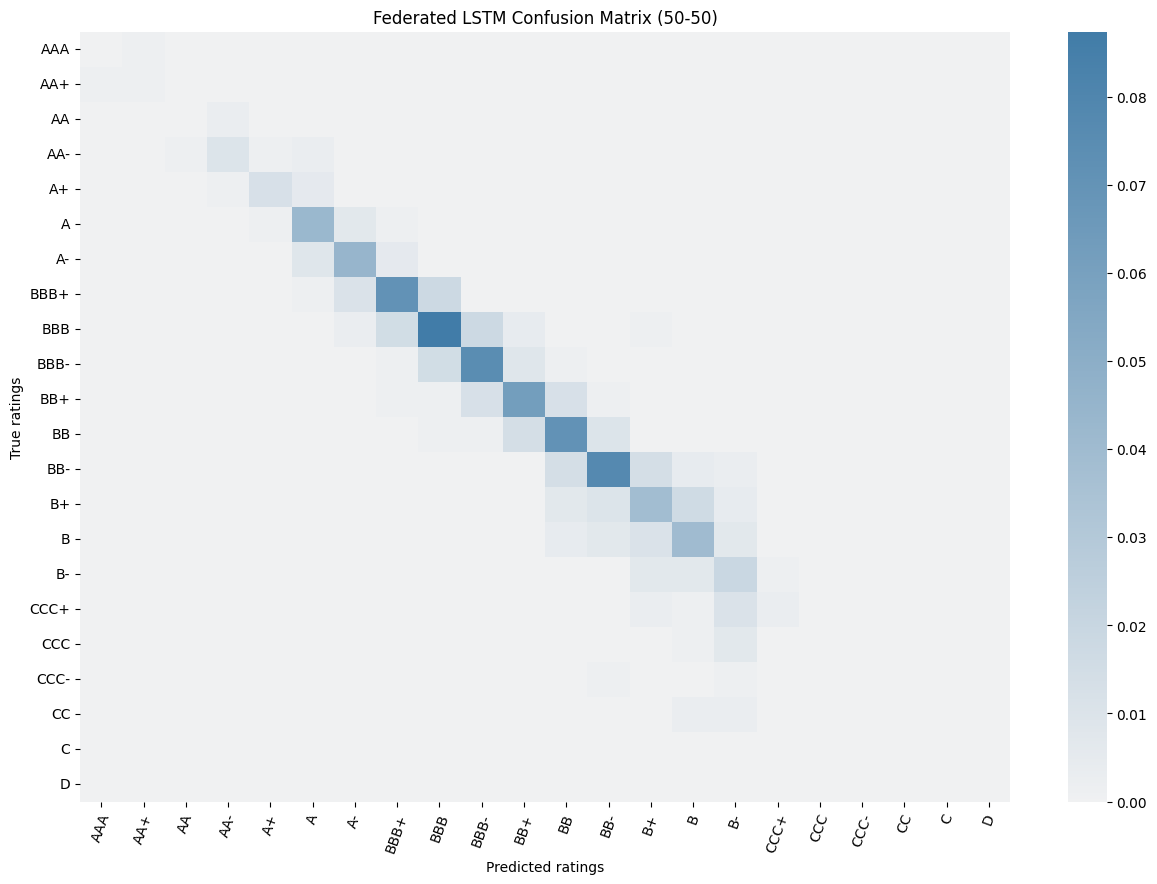

In [89]:
# 50-50
model_fl = run_lstm_simulation([0.5, 0.5], 'split_50_50', 8, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (50-50)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 15:41:51,421 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None)


(launch_and_evaluate pid=25103) Client 1 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=25106) Epoch: 8, Loss: 0.9778614640235901 [repeated 6x across cluster]


2023-06-15 15:41:56,529	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 15:41:57,146 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'memory': 7764081050.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-15 15:41:57,147 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 15:41:57,147 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 15:41:58,086 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 15:41:58,087 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 15:41:58,087 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 15:41:58,088 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=25132) Epoch: 1, Loss: 14.383881568908691
(launch_and_fit pid=25132) Epoch: 2, Loss: 13.150272369384766


DEBUG flwr 2023-06-15 15:42:01,329 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:42:01,354 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:42:01,376 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:01,474 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:42:01,475 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:42:01,475 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=25132) Client 0 evaluate, config {}
(launch_and_fit pid=25127) Epoch: 5, Loss: 8.598432540893555 [repeated 27x across cluster]


DEBUG flwr 2023-06-15 15:42:04,956 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:04,980 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:05,074 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:05,074 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 1 evaluate, config {} [repeated 3x across cluster]


DEBUG flwr 2023-06-15 15:42:08,348 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:08,375 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:08,465 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:08,465 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...
(launch_and_fit pid=25127) Epoch: 7, Loss: 4.6498494148254395 [repeated 26x across cluster]


DEBUG flwr 2023-06-15 15:42:11,786 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:11,809 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:11,906 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:11,906 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=25127) Epoch: 5, Loss: 4.015788555145264 [repeated 22x across cluster]


DEBUG flwr 2023-06-15 15:42:15,292 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:15,320 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:15,411 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:15,411 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 1 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:42:18,392 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:18,416 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:18,511 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:18,511 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...
(launch_and_fit pid=25132) Epoch: 2, Loss: 0.6934736967086792 [repeated 29x across cluster]


DEBUG flwr 2023-06-15 15:42:21,604 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:21,628 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:21,720 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:21,721 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=25127) Epoch: 7, Loss: 1.123805046081543 [repeated 21x across cluster]


DEBUG flwr 2023-06-15 15:42:24,874 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:24,896 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:24,982 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:24,982 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 1 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:42:28,325 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:28,351 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:28,441 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:28,442 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=25132) Epoch: 3, Loss: 0.7068169713020325 [repeated 28x across cluster]


DEBUG flwr 2023-06-15 15:42:31,894 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:31,922 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:32,012 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:32,012 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 1 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=25127) Epoch: 6, Loss: 0.5786222815513611 [repeated 19x across cluster]


DEBUG flwr 2023-06-15 15:42:35,838 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:35,868 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:35,972 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:35,973 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 0 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:42:39,286 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:39,312 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:39,414 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:39,414 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...
(launch_and_fit pid=25127) 
(launch_and_fit pid=25132) Epoch: 2, Loss: 1.6592769622802734 [repeated 28x across cluster]


DEBUG flwr 2023-06-15 15:42:42,578 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:42,604 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:42,688 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:42,688 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 1 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=25132) Epoch: 7, Loss: 0.7534236311912537 [repeated 21x across cluster]


DEBUG flwr 2023-06-15 15:42:46,034 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:46,063 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:46,152 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:46,153 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 1 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:42:49,675 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:49,700 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:49,787 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:49,787 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...
(launch_and_fit pid=25127) Epoch: 2, Loss: 0.2812124788761139 [repeated 27x across cluster]


DEBUG flwr 2023-06-15 15:42:53,189 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:53,213 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:53,303 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:53,303 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=25132) Client 0 evaluate, config {} [repeated 3x across cluster]
(launch_and_fit pid=25132) Epoch: 6, Loss: 0.6740908622741699 [repeated 20x across cluster]


DEBUG flwr 2023-06-15 15:42:56,916 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:56,958 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:42:57,083 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:42:57,084 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 0 evaluate, config {} [repeated 3x across cluster]


DEBUG flwr 2023-06-15 15:43:00,463 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:00,488 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:00,576 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:00,577 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...
(launch_and_fit pid=25132) Epoch: 2, Loss: 0.3230566382408142 [repeated 28x across cluster]


DEBUG flwr 2023-06-15 15:43:03,789 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:03,818 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:03,901 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:03,901 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=25132) Epoch: 7, Loss: 0.25149989128112793 [repeated 21x across cluster]


DEBUG flwr 2023-06-15 15:43:07,036 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:07,067 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:07,157 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:07,158 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 0 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:43:10,291 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:10,316 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:10,406 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:10,406 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 2)


Saving round 21 aggregated_parameters...
(launch_and_fit pid=25127) Epoch: 3, Loss: 1.4788912534713745 [repeated 28x across cluster]


DEBUG flwr 2023-06-15 15:43:13,939 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:13,963 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:14,053 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:14,054 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 2)


Saving round 22 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 1 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=25132) Epoch: 6, Loss: 0.2996634840965271 [repeated 19x across cluster]


DEBUG flwr 2023-06-15 15:43:17,713 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:17,739 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:17,842 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:17,842 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 2)


Saving round 23 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 0 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:43:21,398 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:21,423 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:21,512 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:21,512 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 2)


Saving round 24 aggregated_parameters...
(launch_and_fit pid=25127) Epoch: 5, Loss: 0.8315279483795166 [repeated 23x across cluster]
(launch_and_evaluate pid=25127) Client 0 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:43:24,992 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:25,017 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:25,105 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:25,105 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 2)


Saving round 25 aggregated_parameters...
(launch_and_fit pid=25132) Epoch: 4, Loss: 0.3204692006111145 [repeated 23x across cluster]


DEBUG flwr 2023-06-15 15:43:28,849 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:28,871 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:28,959 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:28,960 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 2)


Saving round 26 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 0 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:43:32,289 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:32,315 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:32,417 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:32,418 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 2)


Saving round 27 aggregated_parameters...
(launch_and_fit pid=25127) Epoch: 8, Loss: 0.22427840530872345 [repeated 20x across cluster]
(launch_and_evaluate pid=25127) Client 1 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:43:35,953 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:35,978 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:36,074 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:36,075 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 2)


Saving round 28 aggregated_parameters...
(launch_and_fit pid=25127) Epoch: 3, Loss: 0.3085153102874756 [repeated 27x across cluster]


DEBUG flwr 2023-06-15 15:43:39,369 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:39,395 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:39,484 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:39,485 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 2)


Saving round 29 aggregated_parameters...
(launch_and_fit pid=25132) 
(launch_and_evaluate pid=25127) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=25132) Epoch: 7, Loss: 0.40763962268829346 [repeated 20x across cluster]


DEBUG flwr 2023-06-15 15:43:43,007 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:43,036 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:43,126 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:43,126 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 2)


Saving round 30 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 1 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:43:46,821 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:46,844 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:46,939 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:46,940 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 2)


Saving round 31 aggregated_parameters...
(launch_and_fit pid=25132) Epoch: 2, Loss: 0.4503442049026489 [repeated 27x across cluster]


DEBUG flwr 2023-06-15 15:43:50,272 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:50,299 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:50,402 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:50,402 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 2)


Saving round 32 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 1 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=25132) Epoch: 6, Loss: 0.13364462554454803 [repeated 20x across cluster]


DEBUG flwr 2023-06-15 15:43:53,845 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:53,868 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:53,954 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:53,955 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 2)


Saving round 33 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 0 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:43:57,502 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:57,526 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:43:57,620 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:43:57,621 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 2)


Saving round 34 aggregated_parameters...
(launch_and_fit pid=25132) Epoch: 1, Loss: 1.5533149242401123 [repeated 26x across cluster]


DEBUG flwr 2023-06-15 15:44:01,196 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:01,221 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:44:01,315 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:01,315 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 2)


Saving round 35 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 0 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=25127) Epoch: 4, Loss: 0.3412579298019409 [repeated 20x across cluster]


DEBUG flwr 2023-06-15 15:44:05,018 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:05,044 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:44:05,135 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:05,135 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 2)


Saving round 36 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 0 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:44:08,695 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:08,719 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:44:08,823 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:08,824 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 2)


Saving round 37 aggregated_parameters...
(launch_and_fit pid=25127) Epoch: 7, Loss: 0.25310951471328735 [repeated 19x across cluster]
(launch_and_evaluate pid=25127) Client 1 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:44:12,503 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:12,533 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:44:12,623 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:12,623 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 2)


Saving round 38 aggregated_parameters...
(launch_and_fit pid=25127) Epoch: 3, Loss: 1.4119036197662354 [repeated 28x across cluster]


DEBUG flwr 2023-06-15 15:44:16,176 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:16,206 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:44:16,297 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:16,298 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 2)


Saving round 39 aggregated_parameters...
(launch_and_evaluate pid=25127) Client 1 evaluate, config {} [repeated 4x across cluster]
(launch_and_fit pid=25127) Epoch: 7, Loss: 0.25227442383766174 [repeated 20x across cluster]


DEBUG flwr 2023-06-15 15:44:19,719 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:19,742 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 15:44:19,830 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
INFO flwr 2023-06-15 15:44:19,831 | server.py:147 | FL finished in 141.74211987503804
INFO flwr 2023-06-15 15:44:19,832 | app.py:218 | app_fit: losses_distributed [(1, 75.22052704576977), (2, 71.54646324549238), (3, 71.4507628294036), (4, 71.42995839112344), (5, 57.205270457697644), (6, 2.0527045769764216), (7, 1.1692094313453536), (8, 1.0970873786407767), (9, 0.986130374479889), (10, 1.0027739251040222), (11, 1.072122052704577), (12, 0.9694868238557559), (13, 0.9251040221914009), (14, 0.9403606102635229), (15, 0.9667128987517337), (16, 0.8932038834951457), (17, 0.9112343966712899), (18, 0.8640776699029126), (19, 0.8932038834951457), (20, 0.9334257975034674), (21, 0.8585298196

Saving round 40 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_90_10/model_round_40.pth
0.9167822468793343
0.002078871308116404
0.9642565548263858
0.9646739130434784


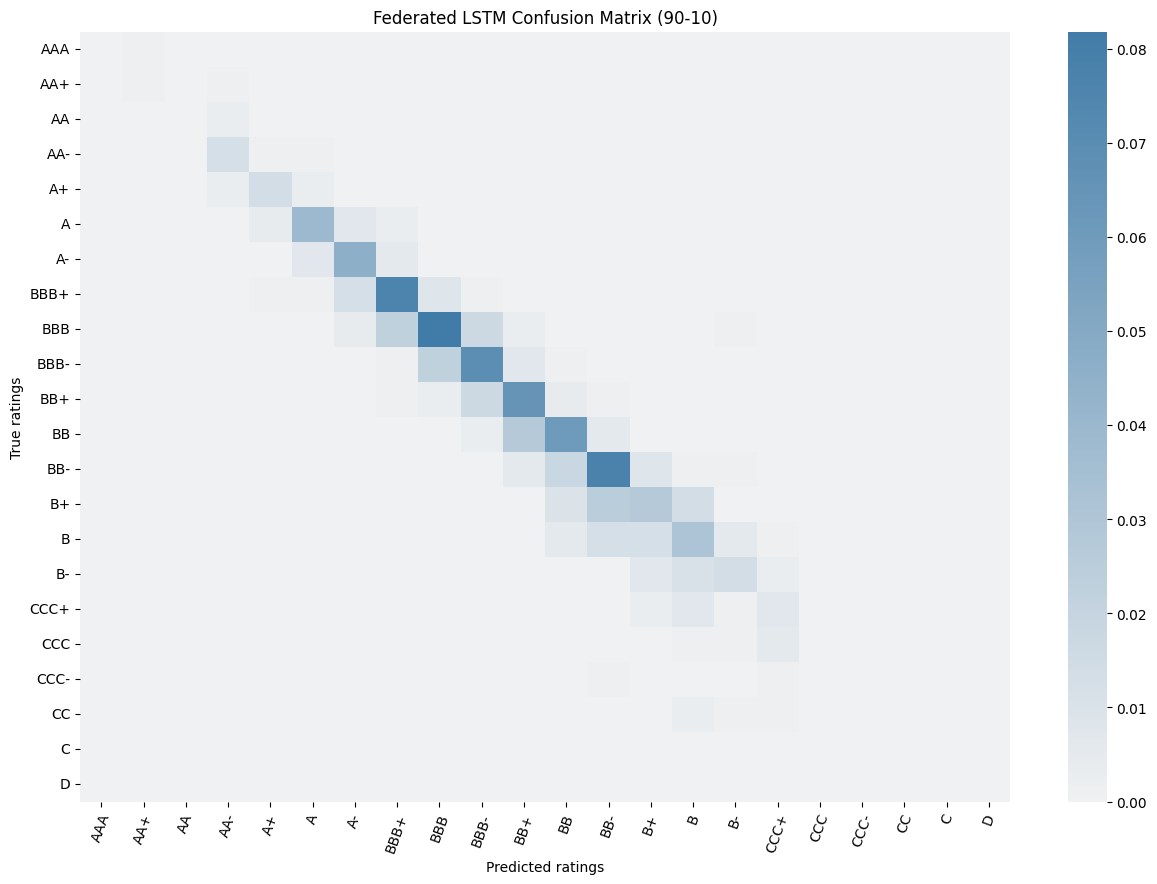

In [90]:
# 90-10
model_fl = run_lstm_simulation([0.9, 0.1], 'split_90_10', 8, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 15:44:20,405 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None)


(launch_and_evaluate pid=25127) Client 0 evaluate, config {} [repeated 2x across cluster]
(launch_and_fit pid=25127) Epoch: 8, Loss: 0.585549533367157


2023-06-15 15:44:24,254	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 15:44:24,770 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'memory': 8018575360.0, 'CPU': 8.0}
INFO flwr 2023-06-15 15:44:24,771 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 15:44:24,771 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 15:44:25,610 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 15:44:25,611 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 15:44:25,611 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 15:44:25,611 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=25173) Epoch: 1, Loss: 19.782413482666016
(launch_and_fit pid=25173) Epoch: 2, Loss: 19.457923889160156
(launch_and_fit pid=25173) Epoch: 3, Loss: 21.645103454589844
(launch_and_fit pid=25173) Epoch: 4, Loss: 16.15884017944336
(launch_and_fit pid=25173) Epoch: 5, Loss: 14.511002540588379
(launch_and_fit pid=25173) Epoch: 6, Loss: 11.765745162963867
(launch_and_fit pid=25173) Epoch: 7, Loss: 5.964171886444092


DEBUG flwr 2023-06-15 15:44:27,601 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:44:27,620 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:44:27,642 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:27,750 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:44:27,751 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:44:27,751 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=25173) Client 0 evaluate, config {}


DEBUG flwr 2023-06-15 15:44:28,988 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:29,017 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:29,106 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:29,106 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 15:44:30,712 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:30,740 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:30,825 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:30,825 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...
(launch_and_fit pid=25173) Epoch: 1, Loss: 5.147468566894531 [repeated 42x across cluster]


DEBUG flwr 2023-06-15 15:44:32,077 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:32,109 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:32,206 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:32,207 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=25172) Client 2 evaluate, config {} [repeated 7x across cluster]


DEBUG flwr 2023-06-15 15:44:33,487 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:33,517 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:33,609 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:33,610 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 15:44:34,948 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:34,977 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:35,067 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:35,067 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...
(launch_and_fit pid=25173) Epoch: 6, Loss: 5.618865013122559 [repeated 58x across cluster]


DEBUG flwr 2023-06-15 15:44:36,442 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:36,479 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:36,569 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:36,570 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=25172) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:44:38,185 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:38,213 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:38,304 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:38,304 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 15:44:40,006 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:40,031 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:40,115 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:40,115 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=25173) Epoch: 6, Loss: 3.677833318710327 [repeated 47x across cluster]


DEBUG flwr 2023-06-15 15:44:41,796 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:41,823 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:41,907 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:41,907 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=25172) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:44:43,559 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:43,585 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:43,672 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:43,673 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 15:44:45,239 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:45,263 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:45,350 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:45,350 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...
(launch_and_fit pid=25173) Epoch: 5, Loss: 2.906069755554199 [repeated 47x across cluster]


DEBUG flwr 2023-06-15 15:44:46,761 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:46,787 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:46,875 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:46,875 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=25172) Client 1 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:44:48,629 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:48,655 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:48,751 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:48,751 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 15:44:50,027 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:50,056 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:50,146 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:50,147 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...
(launch_and_fit pid=25173) Epoch: 5, Loss: 2.5292983055114746 [repeated 50x across cluster]


DEBUG flwr 2023-06-15 15:44:51,807 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:51,835 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:51,927 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:51,928 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=25172) Client 1 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:44:53,578 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:53,605 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:53,696 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:53,697 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 15:44:55,045 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:55,071 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:55,158 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:55,159 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...
(launch_and_fit pid=25173) Epoch: 6, Loss: 1.071894645690918 [repeated 47x across cluster]


DEBUG flwr 2023-06-15 15:44:56,850 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:56,876 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:56,964 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:56,964 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=25172) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:44:58,689 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:58,712 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:44:58,805 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:44:58,806 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 15:45:00,343 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:00,369 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:00,463 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:00,464 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 3)


Saving round 21 aggregated_parameters...
(launch_and_fit pid=25173) Epoch: 5, Loss: 0.7933121919631958 [repeated 47x across cluster]


DEBUG flwr 2023-06-15 15:45:01,772 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:01,798 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:01,887 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:01,887 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 3)


Saving round 22 aggregated_parameters...
(launch_and_evaluate pid=25172) Client 2 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:45:03,211 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:03,240 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:03,334 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:03,334 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 3)


Saving round 23 aggregated_parameters...


DEBUG flwr 2023-06-15 15:45:04,872 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:04,898 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:04,986 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:04,986 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 3)


Saving round 24 aggregated_parameters...
(launch_and_fit pid=25173) Epoch: 8, Loss: 0.4881732761859894 [repeated 53x across cluster]


DEBUG flwr 2023-06-15 15:45:06,626 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:06,653 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:06,747 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:06,748 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 3)


Saving round 25 aggregated_parameters...
(launch_and_evaluate pid=25172) Client 2 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:45:08,415 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:08,438 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:08,530 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:08,531 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 3)


Saving round 26 aggregated_parameters...


DEBUG flwr 2023-06-15 15:45:09,864 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:09,888 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:09,974 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:09,974 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 3)


Saving round 27 aggregated_parameters...


DEBUG flwr 2023-06-15 15:45:11,310 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:11,351 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:11,457 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:11,457 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 3)


Saving round 28 aggregated_parameters...
(launch_and_fit pid=25172) Epoch: 8, Loss: 0.9666602611541748 [repeated 50x across cluster]


DEBUG flwr 2023-06-15 15:45:13,045 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:13,070 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=25172) Client 0 evaluate, config {} [repeated 6x across cluster]
Saving round 29 aggregated_parameters...


DEBUG flwr 2023-06-15 15:45:13,159 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:13,159 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:14,492 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:14,516 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:14,606 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:14,607 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 3)


Saving round 30 aggregated_parameters...


DEBUG flwr 2023-06-15 15:45:16,170 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:16,195 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:16,283 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:16,284 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 3)


Saving round 31 aggregated_parameters...
(launch_and_fit pid=25173) Epoch: 1, Loss: 2.438293218612671 [repeated 49x across cluster]


DEBUG flwr 2023-06-15 15:45:17,959 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:17,988 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:18,079 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:18,079 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 3)


Saving round 32 aggregated_parameters...
(launch_and_evaluate pid=25173) Client 2 evaluate, config {} [repeated 7x across cluster]


DEBUG flwr 2023-06-15 15:45:19,841 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:19,862 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:19,948 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:19,949 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 3)


Saving round 33 aggregated_parameters...


DEBUG flwr 2023-06-15 15:45:21,364 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:21,388 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:21,478 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:21,479 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 3)


Saving round 34 aggregated_parameters...
(launch_and_fit pid=25173) Epoch: 8, Loss: 0.3838393986225128 [repeated 47x across cluster]


DEBUG flwr 2023-06-15 15:45:22,841 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:22,864 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:22,960 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:22,961 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 3)


Saving round 35 aggregated_parameters...
(launch_and_evaluate pid=25172) Client 1 evaluate, config {} [repeated 7x across cluster]


DEBUG flwr 2023-06-15 15:45:24,716 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:24,739 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:24,829 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:24,830 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 3)


Saving round 36 aggregated_parameters...


DEBUG flwr 2023-06-15 15:45:26,251 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:26,284 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:26,396 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:26,397 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 3)


Saving round 37 aggregated_parameters...
(launch_and_fit pid=25173) Epoch: 1, Loss: 1.392230749130249 [repeated 49x across cluster]


DEBUG flwr 2023-06-15 15:45:27,780 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:27,806 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:27,902 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:27,903 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 3)


Saving round 38 aggregated_parameters...
(launch_and_evaluate pid=25172) Client 2 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:45:29,511 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:29,536 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:29,624 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:29,624 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 3)


Saving round 39 aggregated_parameters...


DEBUG flwr 2023-06-15 15:45:31,028 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:31,055 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:31,150 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
INFO flwr 2023-06-15 15:45:31,150 | server.py:147 | FL finished in 65.53815558296628
INFO flwr 2023-06-15 15:45:31,153 | app.py:218 | app_fit: losses_distributed [(1, 73.29680998613037), (2, 71.76560332871013), (3, 71.55201109570042), (4, 71.47434119278779), (5, 71.41886269070736), (6, 71.39667128987517), (7, 71.40776699029126), (8, 71.40776699029126), (9, 71.39251040221914), (10, 71.39251040221914), (11, 21.81137309292649), (12, 12.421636615811373), (13, 12.228848821081831), (14, 2.041608876560333), (15, 1.1858529819694867), (16, 1.188626907073509), (17, 1.0319001386962552), (18, 1.0818307905686546), (19, 1.0485436893203883), (20, 1.0208044382801664), (21, 1.0346740638002774)

Saving round 40 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_40_30_30/model_round_40.pth
0.9209431345353676
0.0020883064275178395
0.9682002341559602
0.9689608636977058


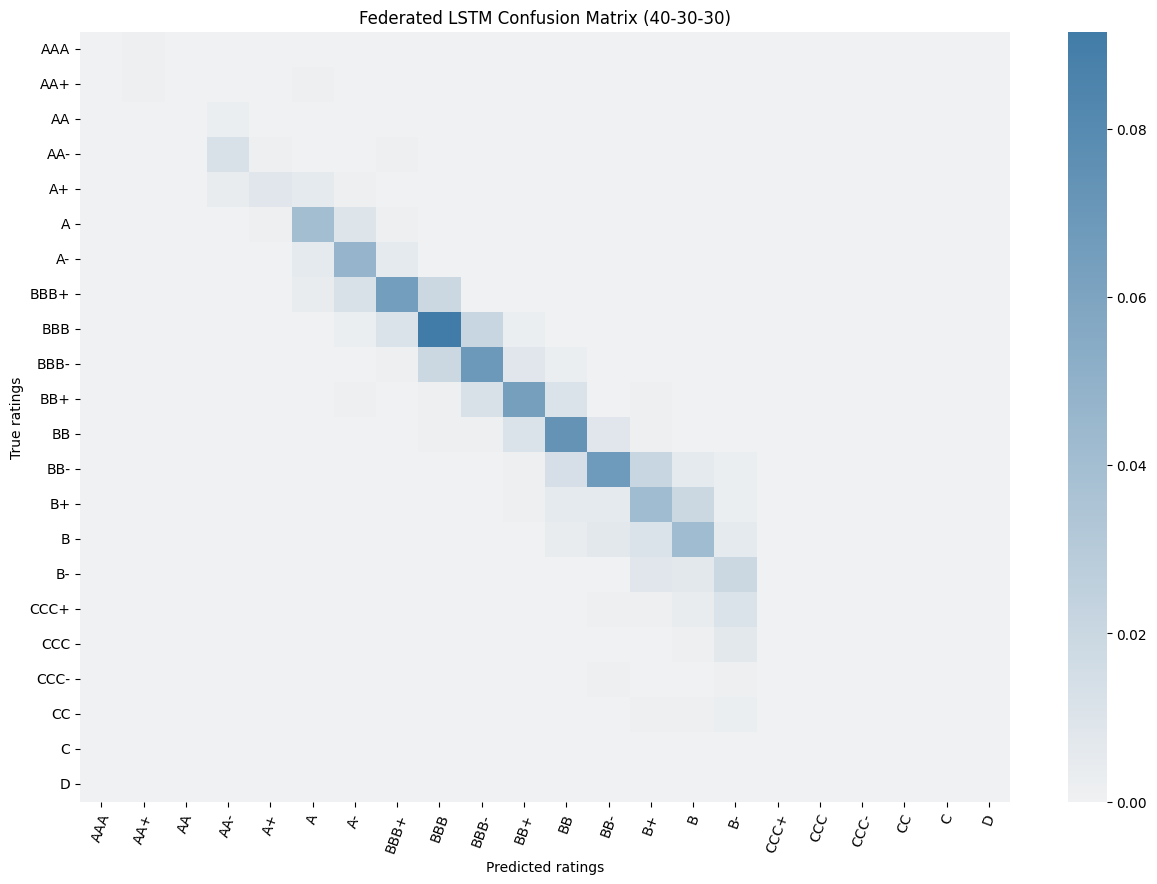

In [91]:
# 40-30-30
model_fl = run_lstm_simulation([0.4, 0.3, 0.3], 'split_40_30_30', 8, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (40-30-30)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 15:45:31,771 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None)


(launch_and_fit pid=25172) Epoch: 8, Loss: 0.6967456340789795 [repeated 47x across cluster]
(launch_and_evaluate pid=25172) Client 2 evaluate, config {} [repeated 4x across cluster]


2023-06-15 15:45:36,512	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 15:45:37,168 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 7360877364.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0}
INFO flwr 2023-06-15 15:45:37,168 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 15:45:37,169 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 15:45:38,023 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 15:45:38,023 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 15:45:38,023 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 15:45:38,023 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=25199) Epoch: 1, Loss: 20.463886260986328
(launch_and_fit pid=25199) Epoch: 2, Loss: 22.512332916259766
(launch_and_fit pid=25199) Epoch: 3, Loss: 24.346263885498047
(launch_and_fit pid=25199) Epoch: 4, Loss: 16.60611915588379
(launch_and_fit pid=25199) Epoch: 5, Loss: 24.944034576416016
(launch_and_fit pid=25199) Epoch: 6, Loss: 18.187198638916016
(launch_and_fit pid=25199) Epoch: 7, Loss: 20.954097747802734
(launch_and_fit pid=25199) Epoch: 8, Loss: 29.76752471923828


DEBUG flwr 2023-06-15 15:45:39,160 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:45:39,181 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:45:39,204 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:39,302 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:45:39,303 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:45:39,303 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=25199) Client 2 evaluate, config {}


DEBUG flwr 2023-06-15 15:45:41,968 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:42,001 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:42,093 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:42,094 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...
(launch_and_fit pid=25199) Epoch: 3, Loss: 10.748723030090332 [repeated 35x across cluster]
(launch_and_evaluate pid=25205) Client 1 evaluate, config {} [repeated 3x across cluster]


DEBUG flwr 2023-06-15 15:45:44,732 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:44,759 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:44,845 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:44,845 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 15:45:47,644 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:47,669 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:47,759 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:47,760 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 15:45:48,244 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:48,270 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:48,359 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:48,360 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=25199) Epoch: 8, Loss: 1.7360408306121826 [repeated 35x across cluster]
(launch_and_evaluate pid=25205) Client 1 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:45:51,353 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:51,381 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:51,467 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:51,467 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...
(launch_and_fit pid=25205) Epoch: 5, Loss: 4.144326210021973 [repeated 31x across cluster]


DEBUG flwr 2023-06-15 15:45:54,501 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:54,526 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:54,614 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:54,615 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=25205) Client 1 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:45:57,554 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:57,580 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:45:57,668 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:45:57,668 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=25199) Epoch: 2, Loss: 1.7568671703338623 [repeated 29x across cluster]
(launch_and_evaluate pid=25205) Client 0 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:46:00,756 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:00,787 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:00,895 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:00,896 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 15:46:01,350 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:01,378 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:01,463 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:01,464 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 15:46:01,919 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:01,955 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:02,044 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:02,045 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=25205) Epoch: 4, Loss: 2.3313441276550293 [repeated 50x across cluster]


DEBUG flwr 2023-06-15 15:46:05,072 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:05,098 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:05,187 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:05,188 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=25199) Client 0 evaluate, config {} [repeated 7x across cluster]


DEBUG flwr 2023-06-15 15:46:08,224 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:08,249 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:08,340 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:08,341 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_fit pid=25199) Epoch: 4, Loss: 2.0647995471954346 [repeated 24x across cluster]
(launch_and_evaluate pid=25199) Client 2 evaluate, config {} [repeated 3x across cluster]


DEBUG flwr 2023-06-15 15:46:11,116 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:11,141 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:11,234 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:11,235 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...
(launch_and_fit pid=25205) Epoch: 7, Loss: 0.5803768634796143 [repeated 27x across cluster]


DEBUG flwr 2023-06-15 15:46:14,176 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:14,206 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:14,297 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:14,298 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=25205) Client 1 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:46:17,285 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:17,316 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:17,415 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:17,416 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 15:46:17,868 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:17,892 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:17,979 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:17,980 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...
(launch_and_fit pid=25199) Epoch: 3, Loss: 0.9779354929924011 [repeated 44x across cluster]


DEBUG flwr 2023-06-15 15:46:20,852 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:20,879 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:20,975 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:20,976 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=25199) Client 0 evaluate, config {} [repeated 5x across cluster]


DEBUG flwr 2023-06-15 15:46:21,488 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:21,518 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:21,622 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:21,623 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 15:46:24,389 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:24,423 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:24,511 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:24,512 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...
(launch_and_fit pid=25205) Epoch: 7, Loss: 2.7735676765441895 [repeated 36x across cluster]
(launch_and_evaluate pid=25205) Client 2 evaluate, config {} [repeated 5x across cluster]


DEBUG flwr 2023-06-15 15:46:27,288 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:27,333 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:27,494 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:27,495 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 3)


Saving round 21 aggregated_parameters...
(launch_and_fit pid=25205) Epoch: 6, Loss: 1.5251356363296509 [repeated 31x across cluster]


DEBUG flwr 2023-06-15 15:46:30,359 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:30,391 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:30,484 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:30,485 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 3)


Saving round 22 aggregated_parameters...
(launch_and_evaluate pid=25205) Client 1 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:46:33,250 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:33,281 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:33,383 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:33,383 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 3)


Saving round 23 aggregated_parameters...
(launch_and_fit pid=25205) Epoch: 4, Loss: 0.7165605425834656 [repeated 30x across cluster]


DEBUG flwr 2023-06-15 15:46:36,065 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:36,094 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:36,183 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:36,183 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 3)


Saving round 24 aggregated_parameters...
(launch_and_evaluate pid=25199) Client 0 evaluate, config {} [repeated 3x across cluster]


DEBUG flwr 2023-06-15 15:46:36,615 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:36,641 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:36,729 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:36,730 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 3)


Saving round 25 aggregated_parameters...


DEBUG flwr 2023-06-15 15:46:37,209 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:37,241 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:37,328 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:37,328 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 3)


Saving round 26 aggregated_parameters...
(launch_and_fit pid=25205) Epoch: 7, Loss: 1.544762372970581 [repeated 51x across cluster]


DEBUG flwr 2023-06-15 15:46:40,201 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:40,232 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:40,317 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:40,318 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 3)


Saving round 27 aggregated_parameters...
(launch_and_evaluate pid=25205) Client 1 evaluate, config {} [repeated 7x across cluster]


DEBUG flwr 2023-06-15 15:46:43,021 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:43,047 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:43,135 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:43,135 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 3)


Saving round 28 aggregated_parameters...
(launch_and_fit pid=25199) Epoch: 5, Loss: 0.922974705696106 [repeated 30x across cluster]


DEBUG flwr 2023-06-15 15:46:46,119 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:46,144 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:46,229 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:46,230 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 3)


Saving round 29 aggregated_parameters...
(launch_and_evaluate pid=25205) Client 1 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:46:49,394 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:49,422 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:49,511 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:49,511 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 3)


Saving round 30 aggregated_parameters...
(launch_and_fit pid=25199) Epoch: 2, Loss: 2.08672833442688 [repeated 29x across cluster]
(launch_and_evaluate pid=25205) Client 2 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:46:52,504 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:52,528 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:52,616 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:52,617 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 3)


Saving round 31 aggregated_parameters...


DEBUG flwr 2023-06-15 15:46:53,140 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:53,164 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:53,261 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:53,261 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 3)


Saving round 32 aggregated_parameters...
(launch_and_fit pid=25199) Epoch: 6, Loss: 0.7355630993843079 [repeated 36x across cluster]


DEBUG flwr 2023-06-15 15:46:56,233 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:56,263 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:56,353 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:56,353 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 3)


Saving round 33 aggregated_parameters...
(launch_and_evaluate pid=25205) Client 1 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:46:59,198 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:59,220 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:46:59,308 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:46:59,309 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 3)


Saving round 34 aggregated_parameters...
(launch_and_fit pid=25205) Epoch: 3, Loss: 0.978477954864502 [repeated 29x across cluster]
(launch_and_evaluate pid=25205) Client 2 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:47:02,384 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:02,409 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:47:02,497 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:02,497 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 3)


Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:05,756 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:05,784 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:47:05,878 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:05,878 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 3)


Saving round 36 aggregated_parameters...
(launch_and_fit pid=25205) Epoch: 7, Loss: 0.9624288082122803 [repeated 20x across cluster]
(launch_and_evaluate pid=25205) Client 0 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:47:09,015 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:09,038 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:47:09,124 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:09,124 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 3)


Saving round 37 aggregated_parameters...
(launch_and_fit pid=25205) Epoch: 5, Loss: 0.858893632888794 [repeated 30x across cluster]


DEBUG flwr 2023-06-15 15:47:12,350 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:12,373 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:47:12,463 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:12,464 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 3)


Saving round 38 aggregated_parameters...
(launch_and_evaluate pid=25205) Client 2 evaluate, config {} [repeated 2x across cluster]


DEBUG flwr 2023-06-15 15:47:15,452 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:15,483 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:47:15,616 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:15,617 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 3)


Saving round 39 aggregated_parameters...
(launch_and_fit pid=25205) Epoch: 2, Loss: 0.6463509798049927 [repeated 29x across cluster]
(launch_and_evaluate pid=25205) Client 1 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 15:47:18,713 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:18,740 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 15:47:18,829 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
INFO flwr 2023-06-15 15:47:18,830 | server.py:147 | FL finished in 100.80545979202725
INFO flwr 2023-06-15 15:47:18,831 | app.py:218 | app_fit: losses_distributed [(1, 127.17337031900139), (2, 89.5131761442441), (3, 88.1997226074896), (4, 8.76005547850208), (5, 8.44382801664355), (6, 5.356449375866852), (7, 5.223300970873787), (8, 1.0804438280166435), (9, 1.0166435506241331), (10, 1.0610263522884882), (11, 1.073509015256588), (12, 0.9625520110957004), (13, 0.9140083217753121), (14, 0.970873786407767), (15, 0.9486823855755895), (16, 0.9001386962552012), (17, 0.9597780859916782), (18, 0.9223300970873787), (19, 1.0527045769764216), (20, 0.9167822468793343), (21, 0.923717059639389

Saving round 40 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_80_10_10/model_round_40.pth
0.811373092926491
0.0018398482832800245
0.9669447268693965
0.9674796747967479


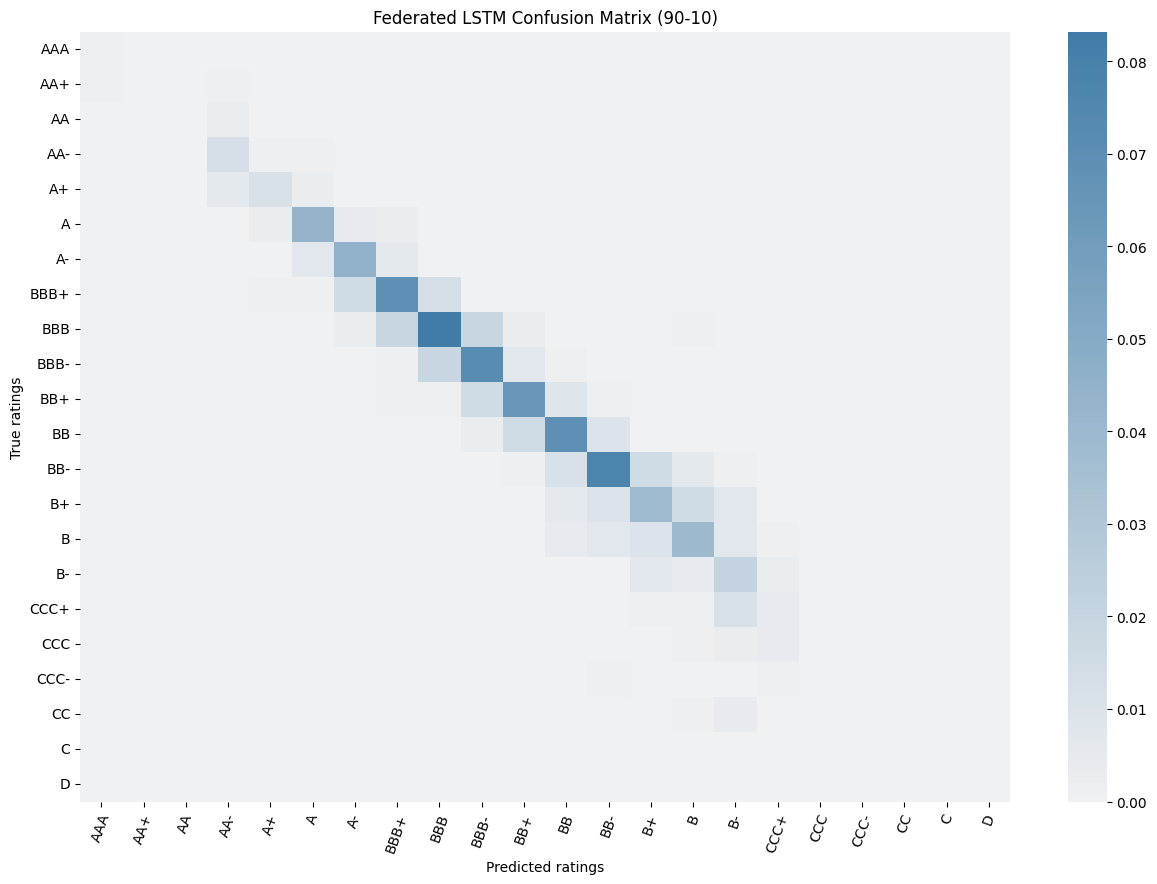

In [92]:
# 80-10-10
model_fl = run_lstm_simulation([0.8, 0.1, 0.1], 'split_80_10_10', 8, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 15:47:19,411 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None)


(launch_and_fit pid=25205) Epoch: 8, Loss: 0.7602003812789917 [repeated 6x across cluster]
(launch_and_evaluate pid=25205) Client 2 evaluate, config {} [repeated 2x across cluster]


2023-06-15 15:47:23,119	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 15:47:23,683 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'memory': 8230307431.0, 'CPU': 8.0}
INFO flwr 2023-06-15 15:47:23,684 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 15:47:23,684 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 15:47:24,484 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 15:47:24,484 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 15:47:24,484 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 15:47:24,485 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=25224) Epoch: 1, Loss: 43.520362854003906
(launch_and_fit pid=25224) Epoch: 2, Loss: 33.66813659667969
(launch_and_fit pid=25224) Epoch: 3, Loss: 29.31501007080078
(launch_and_fit pid=25224) Epoch: 4, Loss: 41.90547561645508
(launch_and_fit pid=25224) Epoch: 5, Loss: 48.53861999511719
(launch_and_fit pid=25224) Epoch: 6, Loss: 38.26542663574219
(launch_and_fit pid=25224) Epoch: 7, Loss: 43.85493469238281
(launch_and_fit pid=25224) Epoch: 8, Loss: 26.182300567626953


DEBUG flwr 2023-06-15 15:47:25,853 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:47:25,865 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:47:25,884 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:25,986 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:47:25,986 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:47:25,987 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=25224) Client 4 evaluate, config {}


DEBUG flwr 2023-06-15 15:47:26,775 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:26,803 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:26,895 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:26,896 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:27,749 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:27,776 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:27,868 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:27,868 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:28,708 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:28,735 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:28,830 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:28,831 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:29,679 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:29,707 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:29,795 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:29,795 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=25224) Epoch: 8, Loss: 17.5070858001709 [repeated 71x across cluster]


DEBUG flwr 2023-06-15 15:47:30,610 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:30,640 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:30,728 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:30,728 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=25225) Client 2 evaluate, config {} [repeated 11x across cluster]


DEBUG flwr 2023-06-15 15:47:31,632 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:31,670 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:31,769 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:31,769 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:32,755 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:32,791 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:32,886 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:32,886 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:33,838 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:33,872 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:33,964 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:33,964 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:34,888 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:34,931 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=25224) Epoch: 7, Loss: 21.139463424682617 [repeated 78x across cluster]
Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:35,046 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:35,046 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:35,894 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:35,925 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:36,020 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:36,021 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...
(launch_and_evaluate pid=25225) Client 3 evaluate, config {} [repeated 10x across cluster]


DEBUG flwr 2023-06-15 15:47:36,867 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:36,897 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:36,985 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:36,986 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:37,893 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:37,928 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:38,014 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:38,015 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:38,894 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:38,926 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:39,014 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:39,015 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:39,865 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:39,892 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:39,979 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:39,979 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=25224) Epoch: 8, Loss: 8.866580963134766 [repeated 81x across cluster]
Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:40,914 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:40,942 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:41,033 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:41,033 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=25225) Client 0 evaluate, config {} [repeated 10x across cluster]


DEBUG flwr 2023-06-15 15:47:41,973 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:42,002 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:42,086 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:42,087 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:42,996 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:43,041 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:43,164 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:43,165 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:44,158 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:44,189 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:44,280 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:44,281 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...
(launch_and_fit pid=25224) Epoch: 5, Loss: 2.698472738265991 [repeated 75x across cluster]


DEBUG flwr 2023-06-15 15:47:45,215 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:45,265 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:45,368 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:45,369 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:46,268 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:46,402 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 5)


Saving round 21 aggregated_parameters...
(launch_and_evaluate pid=25225) Client 1 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 15:47:46,542 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:46,543 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:47,432 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:47,457 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:47,551 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:47,552 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 5)


Saving round 22 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:48,465 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:48,490 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:48,582 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:48,583 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 5)


Saving round 23 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:49,455 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:49,482 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:49,573 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:49,573 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 5)


Saving round 24 aggregated_parameters...
(launch_and_fit pid=25224) Epoch: 3, Loss: 1.6684837341308594 [repeated 76x across cluster]


DEBUG flwr 2023-06-15 15:47:50,563 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:50,599 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:50,688 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:50,688 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 5)


Saving round 25 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:51,494 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:51,520 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=25225) Client 1 evaluate, config {} [repeated 10x across cluster]
Saving round 26 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:51,611 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:51,612 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:52,413 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:52,441 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:52,526 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:52,527 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 5)


Saving round 27 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:53,394 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:53,420 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:53,519 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:53,520 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 5)


Saving round 28 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:54,363 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:54,393 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:54,488 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:54,488 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 5)


Saving round 29 aggregated_parameters...
(launch_and_fit pid=25224) Epoch: 5, Loss: 1.5264534950256348 [repeated 84x across cluster]


DEBUG flwr 2023-06-15 15:47:55,340 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:55,365 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:55,455 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:55,455 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 5)


Saving round 30 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:56,360 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:56,386 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:56,478 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:56,479 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 5)


Saving round 31 aggregated_parameters...
(launch_and_evaluate pid=25224) Client 4 evaluate, config {} [repeated 11x across cluster]


DEBUG flwr 2023-06-15 15:47:57,328 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:57,354 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:57,448 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:57,448 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 5)


Saving round 32 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:58,302 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:58,330 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:58,421 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:58,421 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 5)


Saving round 33 aggregated_parameters...


DEBUG flwr 2023-06-15 15:47:59,289 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:59,317 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:47:59,413 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:47:59,413 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 5)


Saving round 34 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:00,245 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:00,275 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=25224) Epoch: 6, Loss: 1.7703732252120972 [repeated 82x across cluster]
Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:00,364 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:00,365 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:01,190 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:01,215 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:01,301 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:01,302 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 5)


Saving round 36 aggregated_parameters...
(launch_and_evaluate pid=25225) Client 2 evaluate, config {} [repeated 11x across cluster]


DEBUG flwr 2023-06-15 15:48:02,151 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:02,182 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:02,277 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:02,277 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 5)


Saving round 37 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:03,152 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:03,180 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:03,274 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:03,274 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 5)


Saving round 38 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:04,130 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:04,158 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:04,246 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:04,247 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 5)


Saving round 39 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:05,111 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:05,139 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:05,225 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
INFO flwr 2023-06-15 15:48:05,226 | server.py:147 | FL finished in 40.7409260829445
INFO flwr 2023-06-15 15:48:05,227 | app.py:218 | app_fit: losses_distributed [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 127.17337031900139), (5, 127.17337031900139), (6, 127.17337031900139), (7, 127.17337031900139), (8, 127.17337031900139), (9, 127.17337031900139), (10, 127.17337031900139), (11, 127.17337031900139), (12, 127.17337031900139), (13, 127.17337031900139), (14, 127.17337031900139), (15, 127.17337031900139), (16, 127.17337031900139), (17, 127.17337031900139), (18, 8.635228848821082), (19, 5.737864077669903), (20, 5.490984743411928), (21, 5.40638002

Saving round 40 aggregated_parameters...
(launch_and_fit pid=25224) Epoch: 8, Loss: 0.92794269323349 [repeated 84x across cluster]
Loading pre-trained model from:  lstm_model_checkpoints/split_20_20_20_20_20/model_round_40.pth
0.9653259361997226
0.0021889477011331577
0.9693671627075824
0.9705093833780162


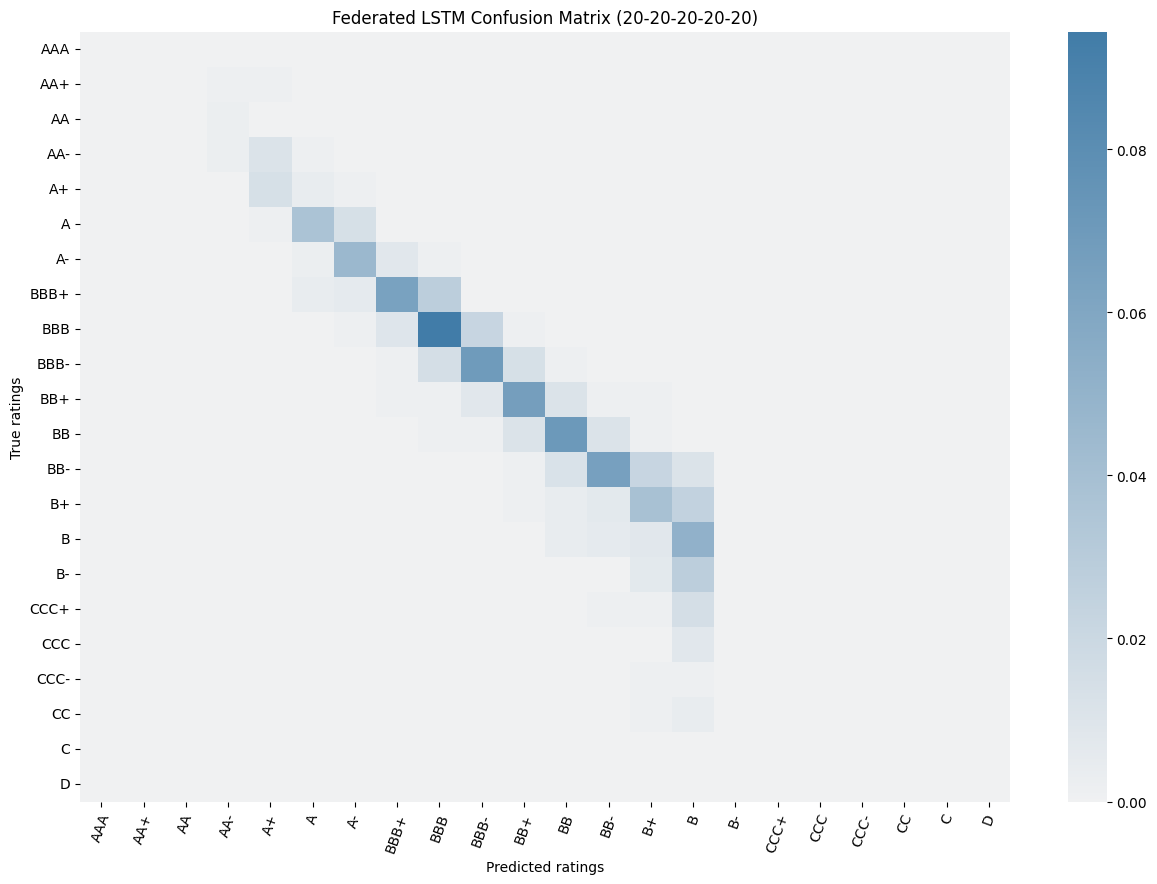

In [93]:
# 20-20-20-20-20
model_fl = run_lstm_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', 8, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (20-20-20-20-20)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 15:48:05,815 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=40, round_timeout=None)


(launch_and_evaluate pid=25225) Client 3 evaluate, config {} [repeated 8x across cluster]
(launch_and_fit pid=25225) Epoch: 8, Loss: 2.132438898086548


2023-06-15 15:48:10,608	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 15:48:11,123 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 8342226535.0}
INFO flwr 2023-06-15 15:48:11,124 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 15:48:11,124 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 15:48:11,926 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 15:48:11,926 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 15:48:11,927 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 15:48:11,927 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=25277) Epoch: 1, Loss: 45.5875244140625
(launch_and_fit pid=25277) Epoch: 2, Loss: 34.403839111328125
(launch_and_fit pid=25277) Epoch: 3, Loss: 30.137096405029297


DEBUG flwr 2023-06-15 15:48:13,846 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:48:13,860 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:48:13,880 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:13,983 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 15:48:13,984 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 15:48:13,984 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=25277) Client 0 evaluate, config {}


DEBUG flwr 2023-06-15 15:48:14,448 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:14,473 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:14,579 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:14,579 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:15,044 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:15,077 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:15,209 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:15,210 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:17,261 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:17,281 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:17,371 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:17,372 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...
(launch_and_fit pid=25277) Epoch: 8, Loss: 16.665569305419922 [repeated 61x across cluster]


DEBUG flwr 2023-06-15 15:48:17,849 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:17,883 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:17,972 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:17,973 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:18,423 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:18,456 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:18,557 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:18,558 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:19,048 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:19,073 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:19,167 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:19,167 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=25272) Client 1 evaluate, config {} [repeated 11x across cluster]
Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:19,624 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:19,650 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:19,735 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:19,735 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:21,915 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:21,940 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:22,035 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:22,036 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:22,503 | server.py:232 | fit_round 10 received 2 results and 0 failures


(launch_and_fit pid=25277) Epoch: 4, Loss: 4.232038497924805 [repeated 86x across cluster]


DEBUG flwr 2023-06-15 15:48:22,527 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:22,618 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:22,619 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:23,087 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:23,116 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:23,207 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:23,207 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:23,662 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:23,687 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:23,774 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:23,775 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=25272) Client 2 evaluate, config {} [repeated 12x across cluster]


DEBUG flwr 2023-06-15 15:48:24,208 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:24,232 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:24,319 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:24,320 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:24,778 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:24,803 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:24,898 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:24,899 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:25,372 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:25,397 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:25,484 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:25,485 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:25,979 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:26,003 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:26,089 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:26,090 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:26,562 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:26,585 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:26,672 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:26,672 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:27,154 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:27,179 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:27,265 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:27,265 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...
(launch_and_fit pid=25277) Epoch: 2, Loss: 1.4587136507034302 [repeated 140x across cluster]


DEBUG flwr 2023-06-15 15:48:27,756 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:27,782 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:27,877 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:27,877 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:28,393 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:28,418 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:28,506 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:28,506 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:29,014 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:29,043 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:29,135 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:29,136 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 5)


Saving round 21 aggregated_parameters...
(launch_and_evaluate pid=25272) Client 1 evaluate, config {} [repeated 16x across cluster]


DEBUG flwr 2023-06-15 15:48:31,433 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:31,454 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:31,543 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:31,543 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 5)


Saving round 22 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:32,054 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:32,081 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:32,171 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:32,171 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 5)


Saving round 23 aggregated_parameters...
(launch_and_fit pid=25277) Epoch: 4, Loss: 1.1276811361312866 [repeated 84x across cluster]


DEBUG flwr 2023-06-15 15:48:32,683 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:32,708 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:32,800 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:32,801 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 5)


Saving round 24 aggregated_parameters...
(launch_and_evaluate pid=25272) Client 1 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 15:48:35,009 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:35,035 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:35,119 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:35,119 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 5)


Saving round 25 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:35,632 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:35,657 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:35,743 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:35,743 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 5)


Saving round 26 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:36,218 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:36,244 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:36,342 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:36,343 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 5)


Saving round 27 aggregated_parameters...
(launch_and_fit pid=25277) Epoch: 4, Loss: 5.789041996002197 [repeated 70x across cluster]


DEBUG flwr 2023-06-15 15:48:38,383 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:38,409 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:38,503 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:38,503 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 5)


Saving round 28 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:39,018 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:39,046 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:39,132 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:39,133 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 5)


Saving round 29 aggregated_parameters...
(launch_and_evaluate pid=25272) Client 3 evaluate, config {} [repeated 10x across cluster]


DEBUG flwr 2023-06-15 15:48:39,618 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:39,644 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:39,730 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:39,731 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 5)


Saving round 30 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:40,213 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:40,238 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:40,326 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:40,326 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 5)


Saving round 31 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:42,555 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:42,579 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:42,668 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:42,668 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 5)


Saving round 32 aggregated_parameters...
(launch_and_fit pid=25272) Epoch: 7, Loss: 1.6584389209747314 [repeated 67x across cluster]


DEBUG flwr 2023-06-15 15:48:44,704 | server.py:232 | fit_round 33 received 2 results and 0 failures


(launch_and_evaluate pid=25272) Client 4 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 15:48:44,728 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:44,819 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:44,820 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 5)


Saving round 33 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:47,059 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:47,084 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:47,173 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:47,173 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 5)


Saving round 34 aggregated_parameters...
(launch_and_fit pid=25272) Epoch: 7, Loss: 2.96382999420166 [repeated 41x across cluster]


DEBUG flwr 2023-06-15 15:48:49,506 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:49,534 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:49,627 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:49,627 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=25272) Client 2 evaluate, config {} [repeated 4x across cluster]
Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:50,114 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:50,142 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:50,236 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:50,236 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 5)


Saving round 36 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:50,720 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:50,745 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:50,834 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:50,835 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 5)


Saving round 37 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:51,353 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:51,383 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:51,474 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:51,475 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 5)


Saving round 38 aggregated_parameters...


DEBUG flwr 2023-06-15 15:48:51,972 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:51,994 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:52,081 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:52,082 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 5)


Saving round 39 aggregated_parameters...
(launch_and_fit pid=25277) Epoch: 2, Loss: 1.4864234924316406 [repeated 81x across cluster]


DEBUG flwr 2023-06-15 15:48:54,225 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 15:48:54,251 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 15:48:54,339 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
INFO flwr 2023-06-15 15:48:54,339 | server.py:147 | FL finished in 42.41207641689107
INFO flwr 2023-06-15 15:48:54,342 | app.py:218 | app_fit: losses_distributed [(1, 89.47572815533981), (2, 88.19556171983356), (3, 62.64771151178918), (4, 56.92787794729542), (5, 56.85991678224688), (6, 56.85436893203884), (7, 56.858529819694866), (8, 56.87101248266297), (9, 56.79195561719833), (10, 56.793342579750345), (11, 56.79195561719833), (12, 56.793342579750345), (13, 17.15395284327323), (14, 12.475728155339805), (15, 1.5256588072122053), (16, 1.4507628294036061), (17, 1.4008321775312067), (18, 1.4882108183079057), (19, 1.2260748959778085), (20, 1.2815533980582525), (21, 1.13037447988904

Saving round 40 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_60_10_10_10_10/model_round_40.pth
0.9750346740638003
0.002210962979736508
0.9628238900699386
0.9633649932157395


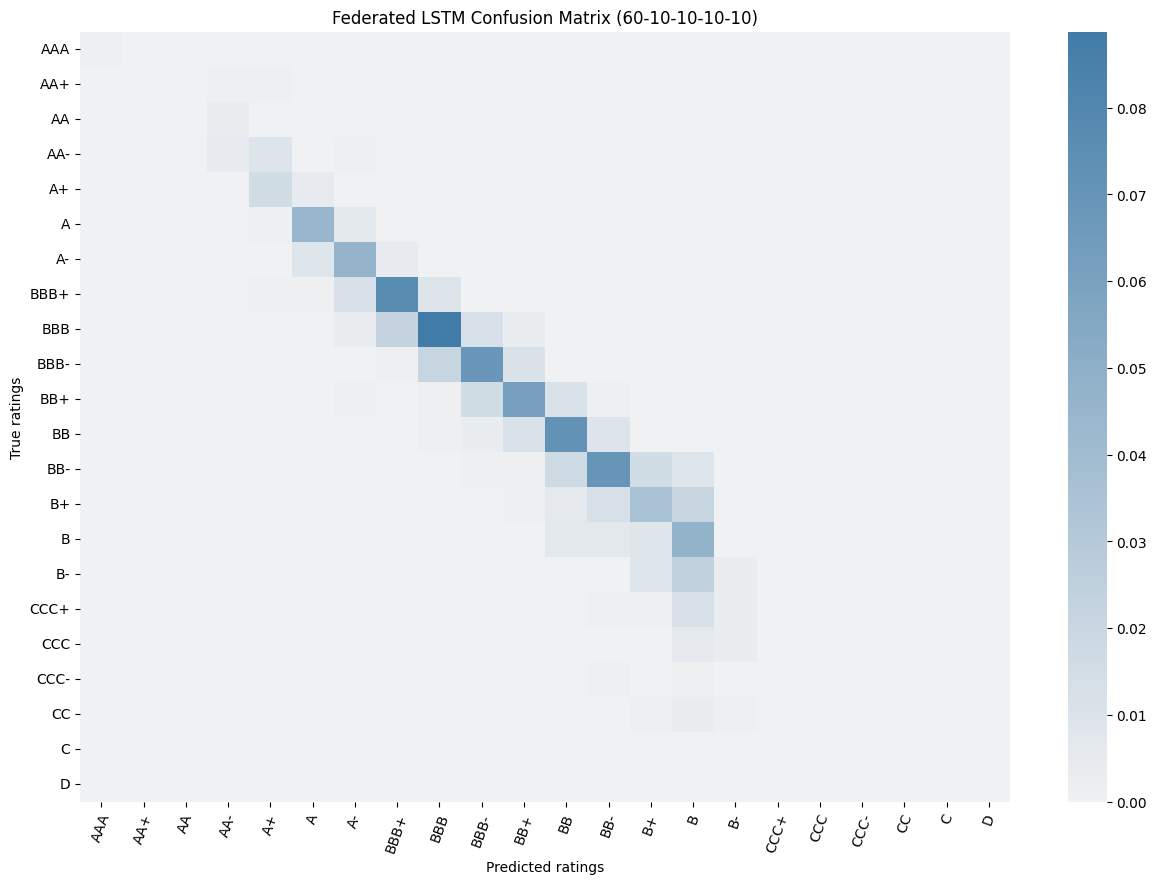

In [94]:
# 60-10-10-10-10
model_fl = run_lstm_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', 8, 4, 40)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (60-10-10-10-10)')

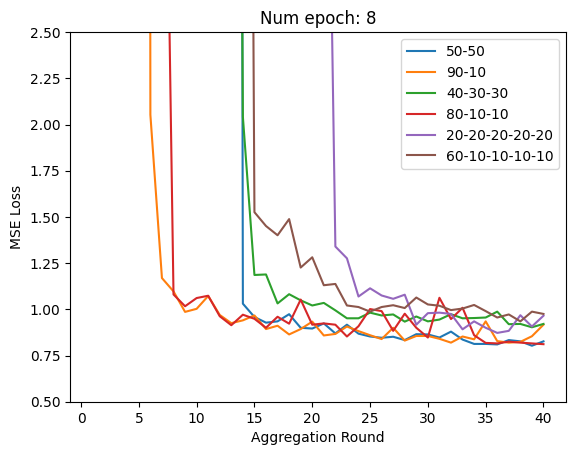

In [23]:
# Visualise loss convergence 8 epoch
ax = plt.gca()
ax.set_ylim([0.5, 2.5])
plot_loss([[(1, 88.8876560332871), (2, 57.22607489597781), (3, 33.61442441054091), (4, 33.47572815533981), (5, 33.50901525658807), (6, 33.499306518724), (7, 33.49514563106796), (8, 33.486823855755894), (9, 33.486823855755894), (10, 33.488210818307905), (11, 33.48127600554785), (12, 33.48266296809986), (13, 33.479889042995836), (14, 1.030513176144244), (15, 0.9583911234396671), (16, 0.9278779472954231), (17, 0.9348127600554785), (18, 0.9736477115117892), (19, 0.9001386962552012), (20, 0.8959778085991679), (21, 0.9237170596393898), (22, 0.869625520110957), (23, 0.9167822468793343), (24, 0.8682385575589459), (25, 0.8529819694868238), (26, 0.8460471567267683), (27, 0.8515950069348127), (28, 0.8335644937586685), (29, 0.8654646324549237), (30, 0.8640776699029126), (31, 0.8474341192787794), (32, 0.8793342579750347), (33, 0.8363384188626907), (34, 0.812760055478502), (35, 0.812760055478502), (36, 0.8099861303744799), (37, 0.8335644937586685), (38, 0.826629680998613), (39, 0.8030513176144244), (40, 0.826629680998613)]
, [(1, 75.22052704576977), (2, 71.54646324549238), (3, 71.4507628294036), (4, 71.42995839112344), (5, 57.205270457697644), (6, 2.0527045769764216), (7, 1.1692094313453536), (8, 1.0970873786407767), (9, 0.986130374479889), (10, 1.0027739251040222), (11, 1.072122052704577), (12, 0.9694868238557559), (13, 0.9251040221914009), (14, 0.9403606102635229), (15, 0.9667128987517337), (16, 0.8932038834951457), (17, 0.9112343966712899), (18, 0.8640776699029126), (19, 0.8932038834951457), (20, 0.9334257975034674), (21, 0.8585298196948682), (22, 0.8668515950069348), (23, 0.9070735090152566), (24, 0.8821081830790569), (25, 0.8599167822468793), (26, 0.8391123439667129), (27, 0.9001386962552012), (28, 0.8307905686546463), (29, 0.855755894590846), (30, 0.855755894590846), (31, 0.840499306518724), (32, 0.8196948682385575), (33, 0.8529819694868238), (34, 0.8377253814147018), (35, 0.9348127600554785), (36, 0.8280166435506241), (37, 0.8196948682385575), (38, 0.8238557558945908), (39, 0.8543689320388349), (40, 0.9167822468793343)]
, [(1, 73.29680998613037), (2, 71.76560332871013), (3, 71.55201109570042), (4, 71.47434119278779), (5, 71.41886269070736), (6, 71.39667128987517), (7, 71.40776699029126), (8, 71.40776699029126), (9, 71.39251040221914), (10, 71.39251040221914), (11, 21.81137309292649), (12, 12.421636615811373), (13, 12.228848821081831), (14, 2.041608876560333), (15, 1.1858529819694867), (16, 1.188626907073509), (17, 1.0319001386962552), (18, 1.0818307905686546), (19, 1.0485436893203883), (20, 1.0208044382801664), (21, 1.0346740638002774), (22, 0.9944521497919556), (23, 0.9514563106796117), (24, 0.9514563106796117), (25, 0.9819694868238558), (26, 0.9667128987517337), (27, 0.9722607489597781), (28, 0.9334257975034674), (29, 0.9611650485436893), (30, 0.9348127600554785), (31, 0.9445214979195562), (32, 0.9736477115117892), (33, 0.9514563106796117), (34, 0.9528432732316228), (35, 0.955617198335645), (36, 0.9875173370319001), (37, 0.9195561719833565), (38, 0.9209431345353676), (39, 0.9029126213592233), (40, 0.9209431345353676)]
, [(1, 127.17337031900139), (2, 89.5131761442441), (3, 88.1997226074896), (4, 8.76005547850208), (5, 8.44382801664355), (6, 5.356449375866852), (7, 5.223300970873787), (8, 1.0804438280166435), (9, 1.0166435506241331), (10, 1.0610263522884882), (11, 1.073509015256588), (12, 0.9625520110957004), (13, 0.9140083217753121), (14, 0.970873786407767), (15, 0.9486823855755895), (16, 0.9001386962552012), (17, 0.9597780859916782), (18, 0.9223300970873787), (19, 1.0527045769764216), (20, 0.9167822468793343), (21, 0.9237170596393898), (22, 0.9167822468793343), (23, 0.8529819694868238), (24, 0.9084604715672677), (25, 1.001386962552011), (26, 0.9902912621359223), (27, 0.883495145631068), (28, 0.9764216366158114), (29, 0.9001386962552012), (30, 0.8474341192787794), (31, 1.0624133148404993), (32, 0.9472954230235784), (33, 1.0083217753120666), (34, 0.8599167822468793), (35, 0.8183079056865464), (36, 0.8155339805825242), (37, 0.8252427184466019), (38, 0.8196948682385575), (39, 0.8155339805825242), (40, 0.811373092926491)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 127.17337031900139), (5, 127.17337031900139), (6, 127.17337031900139), (7, 127.17337031900139), (8, 127.17337031900139), (9, 127.17337031900139), (10, 127.17337031900139), (11, 127.17337031900139), (12, 127.17337031900139), (13, 127.17337031900139), (14, 127.17337031900139), (15, 127.17337031900139), (16, 127.17337031900139), (17, 127.17337031900139), (18, 8.635228848821082), (19, 5.737864077669903), (20, 5.490984743411928), (21, 5.406380027739251), (22, 1.3398058252427185), (23, 1.2760055478502081), (24, 1.0693481276005548), (25, 1.1137309292649098), (26, 1.0748959778085991), (27, 1.056865464632455), (28, 1.0790568654646324), (29, 0.9167822468793343), (30, 0.9791955617198336), (31, 0.9819694868238558), (32, 0.9750346740638003), (33, 0.8918169209431346), (34, 0.9348127600554785), (35, 0.9001386962552012), (36, 0.8723994452149791), (37, 0.883495145631068), (38, 0.9680998613037448), (39, 0.9070735090152566), (40, 0.9653259361997226)]
, [(1, 89.47572815533981), (2, 88.19556171983356), (3, 62.64771151178918), (4, 56.92787794729542), (5, 56.85991678224688), (6, 56.85436893203884), (7, 56.858529819694866), (8, 56.87101248266297), (9, 56.79195561719833), (10, 56.793342579750345), (11, 56.79195561719833), (12, 56.793342579750345), (13, 17.15395284327323), (14, 12.475728155339805), (15, 1.5256588072122053), (16, 1.4507628294036061), (17, 1.4008321775312067), (18, 1.4882108183079057), (19, 1.2260748959778085), (20, 1.2815533980582525), (21, 1.130374479889043), (22, 1.1373092926490984), (23, 1.0208044382801664), (24, 1.0124826629680999), (25, 0.9875173370319001), (26, 1.0124826629680999), (27, 1.0221914008321775), (28, 1.0069348127600555), (29, 1.0638002773925104), (30, 1.0263522884882108), (31, 1.0194174757281553), (32, 0.9958391123439667), (33, 1.0041608876560333), (34, 1.0235783633841886), (35, 0.9902912621359223), (36, 0.955617198335645), (37, 0.9722607489597781), (38, 0.9348127600554785), (39, 0.9875173370319001), (40, 0.9750346740638003)]]
, start=0, title='Num epoch: 8')

#### 4 Epoch

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 16:36:47,344 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=80, round_timeout=None)


(launch_and_fit pid=25921) Epoch: 4, Loss: 0.9646729230880737 [repeated 40x across cluster]
(launch_and_evaluate pid=25921) Client 1 evaluate, config {} [repeated 6x across cluster]


2023-06-15 16:36:51,379	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 16:36:51,927 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 8461326746.0, 'CPU': 8.0}
INFO flwr 2023-06-15 16:36:51,928 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 16:36:51,928 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 16:36:52,705 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 16:36:52,705 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 16:36:52,705 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 16:36:52,706 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=25954) Epoch: 1, Loss: 16.740615844726562
(launch_and_fit pid=25954) Epoch: 2, Loss: 16.783998489379883
(launch_and_fit pid=25954) Epoch: 3, Loss: 18.978315353393555
(launch_and_fit pid=25954) Epoch: 4, Loss: 9.611652374267578


DEBUG flwr 2023-06-15 16:36:54,194 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 16:36:54,210 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 16:36:54,233 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:36:54,323 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 16:36:54,323 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 16:36:54,323 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=25954) Client 1 evaluate, config {}


DEBUG flwr 2023-06-15 16:36:55,321 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:55,351 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:36:55,436 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:55,436 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:56,509 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:56,534 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:36:56,617 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:56,618 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:57,746 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:57,773 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:36:57,862 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:57,863 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...
(launch_and_fit pid=25954) Epoch: 1, Loss: 4.051019668579102 [repeated 29x across cluster]


DEBUG flwr 2023-06-15 16:36:59,015 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:59,046 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:36:59,134 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:59,134 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=25948) Client 1 evaluate, config {} [repeated 9x across cluster]


DEBUG flwr 2023-06-15 16:37:00,273 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:00,302 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:00,390 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:00,390 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:01,458 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:01,485 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:01,571 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:01,571 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:02,693 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:02,722 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:02,813 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:02,813 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=25954) Epoch: 2, Loss: 2.9684338569641113 [repeated 34x across cluster]


DEBUG flwr 2023-06-15 16:37:03,886 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:03,913 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:04,002 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:04,002 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...
(launch_and_evaluate pid=25948) Client 0 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:37:05,162 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:05,191 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:05,291 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:05,292 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:06,424 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:06,451 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:06,545 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:06,545 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:07,637 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:07,661 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:07,746 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:07,747 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...
(launch_and_fit pid=25954) Epoch: 3, Loss: 2.711134195327759 [repeated 34x across cluster]


DEBUG flwr 2023-06-15 16:37:08,923 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:08,950 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:09,038 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:09,039 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=25948) Client 1 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:37:10,159 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:10,186 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:10,272 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:10,273 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:11,385 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:11,414 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:11,500 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:11,501 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:12,589 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:12,620 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:12,703 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:12,703 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:13,822 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:13,852 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:13,941 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:13,941 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=25954) Epoch: 4, Loss: 1.0607041120529175 [repeated 34x across cluster]
Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=25948) Client 0 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:37:15,043 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:15,069 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:15,165 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:15,166 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:16,267 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:16,298 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:16,388 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:16,389 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:17,696 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:17,740 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:17,852 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:17,860 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:19,049 | server.py:232 | fit_round 21 received 2 results and 0 failures


(launch_and_fit pid=25954) Epoch: 3, Loss: 0.630359411239624 [repeated 30x across cluster]
Saving round 21 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:19,076 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:19,168 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:19,169 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=25948) Client 1 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:37:20,327 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:20,380 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:20,483 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:20,484 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 2)


Saving round 22 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:21,546 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:21,573 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:21,661 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:21,662 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 2)


Saving round 23 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:22,728 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:22,749 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:22,838 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:22,839 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 2)


Saving round 24 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:23,932 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:23,957 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:24,042 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:24,043 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=25954) Epoch: 4, Loss: 0.9347151517868042 [repeated 34x across cluster]
Saving round 25 aggregated_parameters...
(launch_and_evaluate pid=25948) Client 0 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:37:25,159 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:25,181 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:25,271 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:25,271 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 2)


Saving round 26 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:26,416 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:26,441 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:26,528 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:26,528 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 2)


Saving round 27 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:27,629 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:27,651 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:27,738 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:27,739 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 2)


Saving round 28 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:28,794 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:28,818 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:28,908 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:28,909 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 2)


Saving round 29 aggregated_parameters...
(launch_and_fit pid=25948) Epoch: 4, Loss: 0.896536648273468 [repeated 33x across cluster]


DEBUG flwr 2023-06-15 16:37:30,074 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:30,096 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:30,184 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:30,185 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 2)


Saving round 30 aggregated_parameters...
(launch_and_evaluate pid=25948) Client 0 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:37:31,436 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:31,462 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:31,548 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:31,549 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 2)


Saving round 31 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:32,752 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:32,776 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:32,864 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:32,864 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 2)


Saving round 32 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:33,953 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:33,982 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:34,078 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:34,078 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 2)


Saving round 33 aggregated_parameters...
(launch_and_fit pid=25954) Epoch: 4, Loss: 0.3936713635921478 [repeated 32x across cluster]


DEBUG flwr 2023-06-15 16:37:35,189 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:35,216 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:35,304 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:35,305 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=25948) Client 1 evaluate, config {} [repeated 8x across cluster]
Saving round 34 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:36,306 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:36,333 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:36,425 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:36,426 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 2)


Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:37,449 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:37,473 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:37,563 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:37,563 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 2)


Saving round 36 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:38,665 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:38,688 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:38,774 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:38,774 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 2)


Saving round 37 aggregated_parameters...
(launch_and_fit pid=25954) Epoch: 1, Loss: 0.4727479815483093 [repeated 33x across cluster]


DEBUG flwr 2023-06-15 16:37:39,898 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:39,921 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:40,011 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:40,011 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 2)


Saving round 38 aggregated_parameters...
(launch_and_evaluate pid=25948) Client 1 evaluate, config {} [repeated 10x across cluster]


DEBUG flwr 2023-06-15 16:37:41,071 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:41,094 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:41,181 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:41,182 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 2)


Saving round 39 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:42,325 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:42,351 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:42,440 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:42,441 | server.py:218 | fit_round 41: strategy sampled 2 clients (out of 2)


Saving round 40 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:43,580 | server.py:232 | fit_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:43,603 | server.py:168 | evaluate_round 41: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:43,691 | server.py:182 | evaluate_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:43,691 | server.py:218 | fit_round 42: strategy sampled 2 clients (out of 2)


Saving round 41 aggregated_parameters...
(launch_and_fit pid=25954) Epoch: 2, Loss: 0.4214042127132416 [repeated 34x across cluster]


DEBUG flwr 2023-06-15 16:37:44,820 | server.py:232 | fit_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:44,842 | server.py:168 | evaluate_round 42: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:44,931 | server.py:182 | evaluate_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:44,931 | server.py:218 | fit_round 43: strategy sampled 2 clients (out of 2)


Saving round 42 aggregated_parameters...
(launch_and_evaluate pid=25948) Client 1 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:37:46,086 | server.py:232 | fit_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:46,109 | server.py:168 | evaluate_round 43: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:46,197 | server.py:182 | evaluate_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:46,197 | server.py:218 | fit_round 44: strategy sampled 2 clients (out of 2)


Saving round 43 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:47,336 | server.py:232 | fit_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:47,360 | server.py:168 | evaluate_round 44: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:47,449 | server.py:182 | evaluate_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:47,450 | server.py:218 | fit_round 45: strategy sampled 2 clients (out of 2)


Saving round 44 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:48,596 | server.py:232 | fit_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:48,618 | server.py:168 | evaluate_round 45: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:48,706 | server.py:182 | evaluate_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:48,706 | server.py:218 | fit_round 46: strategy sampled 2 clients (out of 2)


Saving round 45 aggregated_parameters...
(launch_and_fit pid=25954) Epoch: 2, Loss: 0.36187270283699036 [repeated 32x across cluster]


DEBUG flwr 2023-06-15 16:37:49,838 | server.py:232 | fit_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:49,859 | server.py:168 | evaluate_round 46: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:49,949 | server.py:182 | evaluate_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:49,950 | server.py:218 | fit_round 47: strategy sampled 2 clients (out of 2)


Saving round 46 aggregated_parameters...
(launch_and_evaluate pid=25948) Client 0 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:37:51,082 | server.py:232 | fit_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:51,103 | server.py:168 | evaluate_round 47: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:51,192 | server.py:182 | evaluate_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:51,193 | server.py:218 | fit_round 48: strategy sampled 2 clients (out of 2)


Saving round 47 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:52,360 | server.py:232 | fit_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:52,381 | server.py:168 | evaluate_round 48: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:52,472 | server.py:182 | evaluate_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:52,473 | server.py:218 | fit_round 49: strategy sampled 2 clients (out of 2)


Saving round 48 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:53,578 | server.py:232 | fit_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:53,602 | server.py:168 | evaluate_round 49: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:53,691 | server.py:182 | evaluate_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:53,692 | server.py:218 | fit_round 50: strategy sampled 2 clients (out of 2)


Saving round 49 aggregated_parameters...
(launch_and_fit pid=25954) Epoch: 3, Loss: 0.7053580284118652 [repeated 34x across cluster]


DEBUG flwr 2023-06-15 16:37:54,858 | server.py:232 | fit_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:54,880 | server.py:168 | evaluate_round 50: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:54,976 | server.py:182 | evaluate_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:54,977 | server.py:218 | fit_round 51: strategy sampled 2 clients (out of 2)


Saving round 50 aggregated_parameters...
(launch_and_evaluate pid=25948) Client 0 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:37:56,181 | server.py:232 | fit_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:56,204 | server.py:168 | evaluate_round 51: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:56,294 | server.py:182 | evaluate_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:56,294 | server.py:218 | fit_round 52: strategy sampled 2 clients (out of 2)


Saving round 51 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:57,457 | server.py:232 | fit_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:57,483 | server.py:168 | evaluate_round 52: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:57,580 | server.py:182 | evaluate_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:57,580 | server.py:218 | fit_round 53: strategy sampled 2 clients (out of 2)


Saving round 52 aggregated_parameters...


DEBUG flwr 2023-06-15 16:37:58,698 | server.py:232 | fit_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:58,726 | server.py:168 | evaluate_round 53: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:37:58,818 | server.py:182 | evaluate_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:58,819 | server.py:218 | fit_round 54: strategy sampled 2 clients (out of 2)


Saving round 53 aggregated_parameters...
(launch_and_fit pid=25954) Epoch: 3, Loss: 0.967329740524292 [repeated 32x across cluster]


DEBUG flwr 2023-06-15 16:37:59,929 | server.py:232 | fit_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:37:59,953 | server.py:168 | evaluate_round 54: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:00,044 | server.py:182 | evaluate_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:00,044 | server.py:218 | fit_round 55: strategy sampled 2 clients (out of 2)


Saving round 54 aggregated_parameters...
(launch_and_evaluate pid=25948) Client 0 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:38:01,098 | server.py:232 | fit_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:01,124 | server.py:168 | evaluate_round 55: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:01,212 | server.py:182 | evaluate_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:01,213 | server.py:218 | fit_round 56: strategy sampled 2 clients (out of 2)


Saving round 55 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:02,382 | server.py:232 | fit_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:02,410 | server.py:168 | evaluate_round 56: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:02,501 | server.py:182 | evaluate_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:02,502 | server.py:218 | fit_round 57: strategy sampled 2 clients (out of 2)


Saving round 56 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:03,684 | server.py:232 | fit_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:03,708 | server.py:168 | evaluate_round 57: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:03,797 | server.py:182 | evaluate_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:03,798 | server.py:218 | fit_round 58: strategy sampled 2 clients (out of 2)


Saving round 57 aggregated_parameters...
(launch_and_fit pid=25948) Epoch: 3, Loss: 0.2704415023326874 [repeated 33x across cluster]


DEBUG flwr 2023-06-15 16:38:04,959 | server.py:232 | fit_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:04,984 | server.py:168 | evaluate_round 58: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:05,073 | server.py:182 | evaluate_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:05,073 | server.py:218 | fit_round 59: strategy sampled 2 clients (out of 2)


Saving round 58 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:06,171 | server.py:232 | fit_round 59 received 2 results and 0 failures


(launch_and_evaluate pid=25948) Client 0 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:38:06,198 | server.py:168 | evaluate_round 59: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:06,288 | server.py:182 | evaluate_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:06,288 | server.py:218 | fit_round 60: strategy sampled 2 clients (out of 2)


Saving round 59 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:07,458 | server.py:232 | fit_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:07,486 | server.py:168 | evaluate_round 60: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:07,576 | server.py:182 | evaluate_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:07,576 | server.py:218 | fit_round 61: strategy sampled 2 clients (out of 2)


Saving round 60 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:08,753 | server.py:232 | fit_round 61 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:08,787 | server.py:168 | evaluate_round 61: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:08,876 | server.py:182 | evaluate_round 61 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:08,877 | server.py:218 | fit_round 62: strategy sampled 2 clients (out of 2)


Saving round 61 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:10,042 | server.py:232 | fit_round 62 received 2 results and 0 failures


(launch_and_fit pid=25948) Epoch: 3, Loss: 0.3217717409133911 [repeated 32x across cluster]


DEBUG flwr 2023-06-15 16:38:10,072 | server.py:168 | evaluate_round 62: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:10,163 | server.py:182 | evaluate_round 62 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:10,163 | server.py:218 | fit_round 63: strategy sampled 2 clients (out of 2)


Saving round 62 aggregated_parameters...
(launch_and_evaluate pid=25948) Client 0 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:38:11,342 | server.py:232 | fit_round 63 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:11,373 | server.py:168 | evaluate_round 63: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:11,462 | server.py:182 | evaluate_round 63 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:11,463 | server.py:218 | fit_round 64: strategy sampled 2 clients (out of 2)


Saving round 63 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:12,597 | server.py:232 | fit_round 64 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:12,625 | server.py:168 | evaluate_round 64: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:12,711 | server.py:182 | evaluate_round 64 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:12,712 | server.py:218 | fit_round 65: strategy sampled 2 clients (out of 2)


Saving round 64 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:13,911 | server.py:232 | fit_round 65 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:13,946 | server.py:168 | evaluate_round 65: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:14,038 | server.py:182 | evaluate_round 65 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:14,039 | server.py:218 | fit_round 66: strategy sampled 2 clients (out of 2)


Saving round 65 aggregated_parameters...
(launch_and_fit pid=25948) Epoch: 3, Loss: 1.1263561248779297 [repeated 32x across cluster]


DEBUG flwr 2023-06-15 16:38:15,186 | server.py:232 | fit_round 66 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:15,215 | server.py:168 | evaluate_round 66: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:15,303 | server.py:182 | evaluate_round 66 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:15,303 | server.py:218 | fit_round 67: strategy sampled 2 clients (out of 2)


Saving round 66 aggregated_parameters...
(launch_and_evaluate pid=25948) Client 0 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:38:16,377 | server.py:232 | fit_round 67 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:16,409 | server.py:168 | evaluate_round 67: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:16,498 | server.py:182 | evaluate_round 67 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:16,498 | server.py:218 | fit_round 68: strategy sampled 2 clients (out of 2)


Saving round 67 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:17,653 | server.py:232 | fit_round 68 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:17,681 | server.py:168 | evaluate_round 68: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:17,775 | server.py:182 | evaluate_round 68 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:17,775 | server.py:218 | fit_round 69: strategy sampled 2 clients (out of 2)


Saving round 68 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:18,832 | server.py:232 | fit_round 69 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:18,877 | server.py:168 | evaluate_round 69: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:19,019 | server.py:182 | evaluate_round 69 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:19,020 | server.py:218 | fit_round 70: strategy sampled 2 clients (out of 2)


Saving round 69 aggregated_parameters...
(launch_and_fit pid=25954) Epoch: 3, Loss: 2.91485595703125 [repeated 31x across cluster]


DEBUG flwr 2023-06-15 16:38:20,200 | server.py:232 | fit_round 70 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:20,233 | server.py:168 | evaluate_round 70: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:20,320 | server.py:182 | evaluate_round 70 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:20,320 | server.py:218 | fit_round 71: strategy sampled 2 clients (out of 2)


Saving round 70 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:21,294 | server.py:232 | fit_round 71 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:21,325 | server.py:168 | evaluate_round 71: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=25948) Client 1 evaluate, config {} [repeated 8x across cluster]
Saving round 71 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:21,413 | server.py:182 | evaluate_round 71 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:21,413 | server.py:218 | fit_round 72: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:22,500 | server.py:232 | fit_round 72 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:22,534 | server.py:168 | evaluate_round 72: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:22,620 | server.py:182 | evaluate_round 72 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:22,620 | server.py:218 | fit_round 73: strategy sampled 2 clients (out of 2)


Saving round 72 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:23,762 | server.py:232 | fit_round 73 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:23,796 | server.py:168 | evaluate_round 73: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:23,881 | server.py:182 | evaluate_round 73 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:23,882 | server.py:218 | fit_round 74: strategy sampled 2 clients (out of 2)


Saving round 73 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:24,989 | server.py:232 | fit_round 74 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:25,020 | server.py:168 | evaluate_round 74: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:25,112 | server.py:182 | evaluate_round 74 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:25,112 | server.py:218 | fit_round 75: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=25954) Epoch: 4, Loss: 0.1507556438446045 [repeated 34x across cluster]
Saving round 74 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:26,201 | server.py:232 | fit_round 75 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:26,235 | server.py:168 | evaluate_round 75: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:26,333 | server.py:182 | evaluate_round 75 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:26,333 | server.py:218 | fit_round 76: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=25948) Client 0 evaluate, config {} [repeated 8x across cluster]
Saving round 75 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:27,399 | server.py:232 | fit_round 76 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:27,430 | server.py:168 | evaluate_round 76: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:27,529 | server.py:182 | evaluate_round 76 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:27,529 | server.py:218 | fit_round 77: strategy sampled 2 clients (out of 2)


Saving round 76 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:28,624 | server.py:232 | fit_round 77 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:28,655 | server.py:168 | evaluate_round 77: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:28,745 | server.py:182 | evaluate_round 77 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:28,745 | server.py:218 | fit_round 78: strategy sampled 2 clients (out of 2)


Saving round 77 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:29,865 | server.py:232 | fit_round 78 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:29,897 | server.py:168 | evaluate_round 78: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:29,992 | server.py:182 | evaluate_round 78 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:29,992 | server.py:218 | fit_round 79: strategy sampled 2 clients (out of 2)


Saving round 78 aggregated_parameters...
(launch_and_fit pid=25954) Epoch: 1, Loss: 0.7393742799758911 [repeated 34x across cluster]


DEBUG flwr 2023-06-15 16:38:31,068 | server.py:232 | fit_round 79 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:31,098 | server.py:168 | evaluate_round 79: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:31,187 | server.py:182 | evaluate_round 79 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:31,188 | server.py:218 | fit_round 80: strategy sampled 2 clients (out of 2)


Saving round 79 aggregated_parameters...
(launch_and_evaluate pid=25948) Client 1 evaluate, config {} [repeated 10x across cluster]


DEBUG flwr 2023-06-15 16:38:32,238 | server.py:232 | fit_round 80 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:32,270 | server.py:168 | evaluate_round 80: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:32,363 | server.py:182 | evaluate_round 80 received 2 results and 0 failures
INFO flwr 2023-06-15 16:38:32,364 | server.py:147 | FL finished in 99.65776720806025
INFO flwr 2023-06-15 16:38:32,366 | app.py:218 | app_fit: losses_distributed [(1, 127.17337031900139), (2, 127.17337031900139), (3, 25.187239944521497), (4, 25.03606102635229), (5, 24.9500693481276), (6, 24.8626907073509), (7, 24.814147018030514), (8, 24.78640776699029), (9, 24.776699029126213), (10, 24.787794729542302), (11, 24.76976421636616), (12, 24.742024965325935), (13, 24.730929264909847), (14, 1.1484049930651872), (15, 1.1816920943134535), (16, 1.1109570041608876), (17, 1.029126213592233), (18, 1.0069348127600555), (19, 1.176144244105409), (20, 1.0984743411927878), (21, 1.0180305131761

Saving round 80 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_50_50/model_round_80.pth
0.8252427184466019
0.001871298681284811
0.9654234833780078
0.9662618083670715


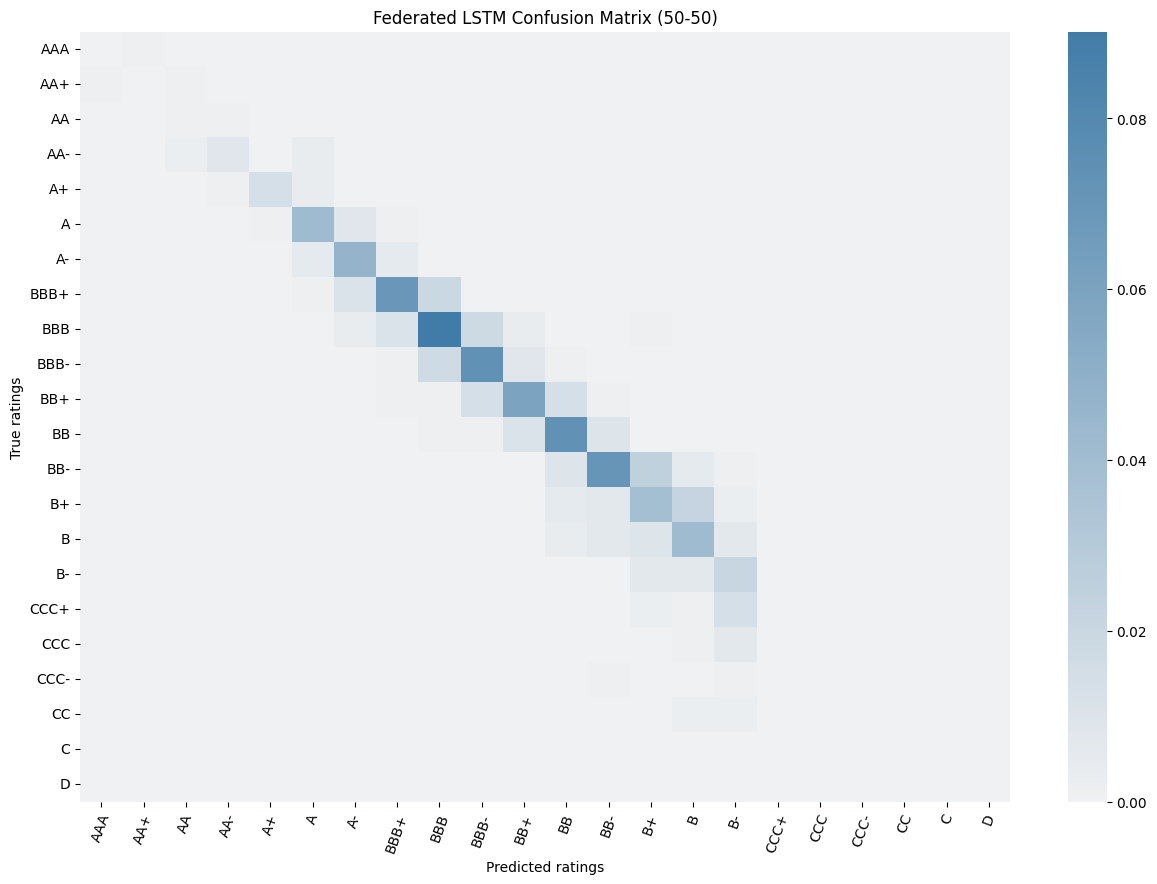

In [129]:
# 50-50
model_fl = run_lstm_simulation([0.5, 0.5], 'split_50_50', 4, 4, 80)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (50-50)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 16:38:33,043 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=80, round_timeout=None)


(launch_and_fit pid=25948) Epoch: 4, Loss: 0.5730886459350586 [repeated 15x across cluster]
(launch_and_evaluate pid=25948) Client 0 evaluate, config {} [repeated 2x across cluster]


2023-06-15 16:38:36,956	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 16:38:37,541 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'memory': 8137439642.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0}
INFO flwr 2023-06-15 16:38:37,542 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 16:38:37,542 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 16:38:38,361 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 16:38:38,361 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 16:38:38,361 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 16:38:38,362 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)


(launch_and_fit pid=25987) Epoch: 1, Loss: 18.41166877746582
(launch_and_fit pid=25987) Epoch: 2, Loss: 18.337669372558594
(launch_and_fit pid=25987) Epoch: 3, Loss: 17.492198944091797
(launch_and_fit pid=25987) Epoch: 4, Loss: 20.95535659790039


DEBUG flwr 2023-06-15 16:38:40,505 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 16:38:40,518 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 16:38:40,538 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:40,633 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 16:38:40,633 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 16:38:40,633 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=25987) Client 1 evaluate, config {}


DEBUG flwr 2023-06-15 16:38:42,220 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:42,282 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:42,377 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:42,377 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


Saving round 2 aggregated_parameters...
(launch_and_fit pid=25991) Epoch: 3, Loss: 7.85782527923584 [repeated 19x across cluster]


DEBUG flwr 2023-06-15 16:38:43,944 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:43,972 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:44,067 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:44,068 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:45,654 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:45,679 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:45,764 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:45,765 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


Saving round 4 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 5x across cluster]


DEBUG flwr 2023-06-15 16:38:47,363 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:47,390 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:47,489 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:47,490 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=25987) Epoch: 3, Loss: 7.176028251647949 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:38:49,087 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:49,107 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:49,195 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:49,195 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:50,781 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:50,804 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:50,888 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:50,888 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


Saving round 7 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 1 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:38:52,516 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:52,554 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:52,653 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:52,653 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=25987) Epoch: 3, Loss: 1.0388621091842651 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:38:54,383 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:54,414 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:54,498 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:54,499 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 16:38:56,117 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:56,143 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:56,231 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:56,232 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 2)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=25987) Client 1 evaluate, config {} [repeated 7x across cluster]


DEBUG flwr 2023-06-15 16:38:57,880 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:57,903 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:57,995 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:57,996 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 2)


Saving round 11 aggregated_parameters...
(launch_and_fit pid=25987) Epoch: 3, Loss: 0.7377861738204956 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:38:59,679 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:59,702 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:38:59,789 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:38:59,790 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 2)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 16:39:01,501 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:01,525 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:01,612 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:01,613 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 2)


Saving round 13 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 5x across cluster]


DEBUG flwr 2023-06-15 16:39:03,209 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:03,230 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:03,321 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:03,321 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 2)


Saving round 14 aggregated_parameters...
(launch_and_fit pid=25987) Epoch: 3, Loss: 1.8205602169036865 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:39:04,962 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:04,985 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:05,073 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:05,073 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 2)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 16:39:06,710 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:06,735 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:06,824 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:06,825 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=25991) Client 1 evaluate, config {} [repeated 6x across cluster]
Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 16:39:08,629 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:08,655 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:08,743 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:08,744 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 2)


Saving round 17 aggregated_parameters...
(launch_and_fit pid=25987) Epoch: 3, Loss: 1.0939658880233765 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:39:10,383 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:10,406 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:10,497 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:10,497 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 2)


Saving round 18 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:39:12,215 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:12,247 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:12,336 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:12,336 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 2)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 16:39:14,003 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:14,026 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:14,116 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:14,117 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 2)


Saving round 20 aggregated_parameters...
(launch_and_fit pid=25991) Epoch: 3, Loss: 0.4509655237197876 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:39:15,896 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:15,917 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:16,003 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:16,004 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 2)


Saving round 21 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:39:17,740 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:17,760 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:17,854 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:17,855 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 2)


Saving round 22 aggregated_parameters...


DEBUG flwr 2023-06-15 16:39:19,581 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:19,617 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:19,706 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:19,707 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 2)


Saving round 23 aggregated_parameters...
(launch_and_fit pid=25991) Epoch: 2, Loss: 0.5837497711181641 [repeated 23x across cluster]


DEBUG flwr 2023-06-15 16:39:21,365 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:21,391 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:21,486 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:21,486 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 2)


Saving round 24 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:39:23,162 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:23,185 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:23,278 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:23,278 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 2)


Saving round 25 aggregated_parameters...


DEBUG flwr 2023-06-15 16:39:24,882 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:24,911 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:24,998 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:24,998 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 2)


Saving round 26 aggregated_parameters...
(launch_and_fit pid=25991) Epoch: 2, Loss: 0.6696399450302124 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:39:26,614 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:26,640 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:26,730 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:26,730 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 2)


Saving round 27 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 1 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:39:28,506 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:28,532 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:28,626 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:28,627 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 2)


Saving round 28 aggregated_parameters...


DEBUG flwr 2023-06-15 16:39:30,435 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:30,458 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:30,545 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:30,546 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 2)


Saving round 29 aggregated_parameters...
(launch_and_fit pid=25987) Epoch: 1, Loss: 0.38017261028289795 [repeated 23x across cluster]


DEBUG flwr 2023-06-15 16:39:32,243 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:32,264 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:32,352 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:32,353 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 2)


Saving round 30 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 16:39:33,971 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:33,995 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:34,084 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:34,085 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 2)


Saving round 31 aggregated_parameters...


DEBUG flwr 2023-06-15 16:39:35,887 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:35,913 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:36,001 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:36,001 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 2)


Saving round 32 aggregated_parameters...
(launch_and_fit pid=25991) Epoch: 1, Loss: 0.5864063501358032 [repeated 20x across cluster]
(launch_and_evaluate pid=25991) Client 1 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:39:37,715 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:37,743 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:37,839 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:37,839 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 2)


Saving round 33 aggregated_parameters...


DEBUG flwr 2023-06-15 16:39:39,611 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:39,632 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:39,721 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:39,721 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 2)


Saving round 34 aggregated_parameters...


DEBUG flwr 2023-06-15 16:39:41,319 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:41,361 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:41,466 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:41,467 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 2)


Saving round 35 aggregated_parameters...
(launch_and_fit pid=25991) Epoch: 4, Loss: 3.1235852241516113 [repeated 23x across cluster]
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:39:43,232 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:43,266 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:43,361 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:43,361 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 2)


Saving round 36 aggregated_parameters...


DEBUG flwr 2023-06-15 16:39:45,087 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:45,113 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:45,200 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:45,201 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 2)


Saving round 37 aggregated_parameters...
(launch_and_fit pid=25987) Epoch: 3, Loss: 0.3510608375072479 [repeated 23x across cluster]


DEBUG flwr 2023-06-15 16:39:46,740 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:46,766 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:46,851 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:46,852 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 2)


Saving round 38 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:39:48,481 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:48,504 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:48,591 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:48,592 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 2)


Saving round 39 aggregated_parameters...


DEBUG flwr 2023-06-15 16:39:50,203 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:50,229 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:50,319 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:50,319 | server.py:218 | fit_round 41: strategy sampled 2 clients (out of 2)


Saving round 40 aggregated_parameters...
(launch_and_fit pid=25991) Epoch: 3, Loss: 0.4232552945613861 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:39:52,004 | server.py:232 | fit_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:52,072 | server.py:168 | evaluate_round 41: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:52,170 | server.py:182 | evaluate_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:52,171 | server.py:218 | fit_round 42: strategy sampled 2 clients (out of 2)


Saving round 41 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:39:53,856 | server.py:232 | fit_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:53,881 | server.py:168 | evaluate_round 42: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:53,986 | server.py:182 | evaluate_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:53,986 | server.py:218 | fit_round 43: strategy sampled 2 clients (out of 2)


Saving round 42 aggregated_parameters...


DEBUG flwr 2023-06-15 16:39:55,669 | server.py:232 | fit_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:55,693 | server.py:168 | evaluate_round 43: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:55,799 | server.py:182 | evaluate_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:55,800 | server.py:218 | fit_round 44: strategy sampled 2 clients (out of 2)


Saving round 43 aggregated_parameters...
(launch_and_fit pid=25987) Epoch: 3, Loss: 0.6029074192047119 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:39:57,319 | server.py:232 | fit_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:57,355 | server.py:168 | evaluate_round 44: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:57,445 | server.py:182 | evaluate_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:57,446 | server.py:218 | fit_round 45: strategy sampled 2 clients (out of 2)


Saving round 44 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:39:59,061 | server.py:232 | fit_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:59,084 | server.py:168 | evaluate_round 45: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:39:59,182 | server.py:182 | evaluate_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:39:59,183 | server.py:218 | fit_round 46: strategy sampled 2 clients (out of 2)


Saving round 45 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:00,864 | server.py:232 | fit_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:00,886 | server.py:168 | evaluate_round 46: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:00,976 | server.py:182 | evaluate_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:00,976 | server.py:218 | fit_round 47: strategy sampled 2 clients (out of 2)


Saving round 46 aggregated_parameters...
(launch_and_fit pid=25991) Epoch: 3, Loss: 0.22383788228034973 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:40:02,621 | server.py:232 | fit_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:02,647 | server.py:168 | evaluate_round 47: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:02,732 | server.py:182 | evaluate_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:02,733 | server.py:218 | fit_round 48: strategy sampled 2 clients (out of 2)


Saving round 47 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:40:04,349 | server.py:232 | fit_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:04,378 | server.py:168 | evaluate_round 48: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:04,473 | server.py:182 | evaluate_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:04,474 | server.py:218 | fit_round 49: strategy sampled 2 clients (out of 2)


Saving round 48 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:06,164 | server.py:232 | fit_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:06,194 | server.py:168 | evaluate_round 49: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:06,284 | server.py:182 | evaluate_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:06,284 | server.py:218 | fit_round 50: strategy sampled 2 clients (out of 2)


Saving round 49 aggregated_parameters...
(launch_and_fit pid=25987) Epoch: 3, Loss: 0.9028934240341187 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:40:08,020 | server.py:232 | fit_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:08,050 | server.py:168 | evaluate_round 50: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:08,144 | server.py:182 | evaluate_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:08,144 | server.py:218 | fit_round 51: strategy sampled 2 clients (out of 2)


Saving round 50 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:40:09,906 | server.py:232 | fit_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:09,946 | server.py:168 | evaluate_round 51: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:10,040 | server.py:182 | evaluate_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:10,041 | server.py:218 | fit_round 52: strategy sampled 2 clients (out of 2)


Saving round 51 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:11,683 | server.py:232 | fit_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:11,710 | server.py:168 | evaluate_round 52: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:11,800 | server.py:182 | evaluate_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:11,801 | server.py:218 | fit_round 53: strategy sampled 2 clients (out of 2)


Saving round 52 aggregated_parameters...
(launch_and_fit pid=25991) Epoch: 3, Loss: 0.19900670647621155 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:40:13,500 | server.py:232 | fit_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:13,523 | server.py:168 | evaluate_round 53: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:13,617 | server.py:182 | evaluate_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:13,618 | server.py:218 | fit_round 54: strategy sampled 2 clients (out of 2)


Saving round 53 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:40:15,230 | server.py:232 | fit_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:15,257 | server.py:168 | evaluate_round 54: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:15,346 | server.py:182 | evaluate_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:15,347 | server.py:218 | fit_round 55: strategy sampled 2 clients (out of 2)


Saving round 54 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:17,058 | server.py:232 | fit_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:17,086 | server.py:168 | evaluate_round 55: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:17,180 | server.py:182 | evaluate_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:17,180 | server.py:218 | fit_round 56: strategy sampled 2 clients (out of 2)


Saving round 55 aggregated_parameters...
(launch_and_fit pid=25991) Epoch: 3, Loss: 0.5262372493743896 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:40:18,850 | server.py:232 | fit_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:18,877 | server.py:168 | evaluate_round 56: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:18,967 | server.py:182 | evaluate_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:18,968 | server.py:218 | fit_round 57: strategy sampled 2 clients (out of 2)


Saving round 56 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:40:20,733 | server.py:232 | fit_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:20,769 | server.py:168 | evaluate_round 57: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:20,862 | server.py:182 | evaluate_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:20,862 | server.py:218 | fit_round 58: strategy sampled 2 clients (out of 2)


Saving round 57 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:22,503 | server.py:232 | fit_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:22,536 | server.py:168 | evaluate_round 58: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:22,636 | server.py:182 | evaluate_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:22,637 | server.py:218 | fit_round 59: strategy sampled 2 clients (out of 2)


Saving round 58 aggregated_parameters...
(launch_and_fit pid=25987) Epoch: 3, Loss: 0.21416273713111877 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:40:24,288 | server.py:232 | fit_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:24,316 | server.py:168 | evaluate_round 59: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:24,422 | server.py:182 | evaluate_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:24,422 | server.py:218 | fit_round 60: strategy sampled 2 clients (out of 2)


Saving round 59 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 4x across cluster]


DEBUG flwr 2023-06-15 16:40:26,063 | server.py:232 | fit_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:26,089 | server.py:168 | evaluate_round 60: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:26,186 | server.py:182 | evaluate_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:26,187 | server.py:218 | fit_round 61: strategy sampled 2 clients (out of 2)


Saving round 60 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:27,941 | server.py:232 | fit_round 61 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:27,976 | server.py:168 | evaluate_round 61: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:28,084 | server.py:182 | evaluate_round 61 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:28,085 | server.py:218 | fit_round 62: strategy sampled 2 clients (out of 2)


Saving round 61 aggregated_parameters...
(launch_and_fit pid=25991) Epoch: 3, Loss: 0.77022385597229 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:40:29,663 | server.py:232 | fit_round 62 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:29,694 | server.py:168 | evaluate_round 62: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:29,789 | server.py:182 | evaluate_round 62 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:29,790 | server.py:218 | fit_round 63: strategy sampled 2 clients (out of 2)


(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]
Saving round 62 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:31,328 | server.py:232 | fit_round 63 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:31,373 | server.py:168 | evaluate_round 63: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:31,472 | server.py:182 | evaluate_round 63 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:31,472 | server.py:218 | fit_round 64: strategy sampled 2 clients (out of 2)


Saving round 63 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:33,164 | server.py:232 | fit_round 64 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:33,202 | server.py:168 | evaluate_round 64: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:33,294 | server.py:182 | evaluate_round 64 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:33,295 | server.py:218 | fit_round 65: strategy sampled 2 clients (out of 2)


Saving round 64 aggregated_parameters...
(launch_and_fit pid=25987) Epoch: 3, Loss: 0.35985514521598816 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:40:34,991 | server.py:232 | fit_round 65 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:35,025 | server.py:168 | evaluate_round 65: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:35,114 | server.py:182 | evaluate_round 65 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:35,115 | server.py:218 | fit_round 66: strategy sampled 2 clients (out of 2)


Saving round 65 aggregated_parameters...
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:40:36,853 | server.py:232 | fit_round 66 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:36,889 | server.py:168 | evaluate_round 66: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:36,978 | server.py:182 | evaluate_round 66 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:36,979 | server.py:218 | fit_round 67: strategy sampled 2 clients (out of 2)


Saving round 66 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:38,590 | server.py:232 | fit_round 67 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:38,625 | server.py:168 | evaluate_round 67: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:38,716 | server.py:182 | evaluate_round 67 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:38,717 | server.py:218 | fit_round 68: strategy sampled 2 clients (out of 2)


Saving round 67 aggregated_parameters...
(launch_and_fit pid=25987) Epoch: 3, Loss: 0.1335030496120453 [repeated 24x across cluster]
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:40:40,466 | server.py:232 | fit_round 68 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:40,505 | server.py:168 | evaluate_round 68: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:40,621 | server.py:182 | evaluate_round 68 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:40,622 | server.py:218 | fit_round 69: strategy sampled 2 clients (out of 2)


Saving round 68 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:42,216 | server.py:232 | fit_round 69 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:42,250 | server.py:168 | evaluate_round 69: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:42,338 | server.py:182 | evaluate_round 69 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:42,339 | server.py:218 | fit_round 70: strategy sampled 2 clients (out of 2)


Saving round 69 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:43,997 | server.py:232 | fit_round 70 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:44,033 | server.py:168 | evaluate_round 70: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:44,122 | server.py:182 | evaluate_round 70 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:44,123 | server.py:218 | fit_round 71: strategy sampled 2 clients (out of 2)


Saving round 70 aggregated_parameters...
(launch_and_fit pid=25987) Epoch: 3, Loss: 0.23974169790744781 [repeated 24x across cluster]
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:40:45,715 | server.py:232 | fit_round 71 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:45,750 | server.py:168 | evaluate_round 71: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:45,843 | server.py:182 | evaluate_round 71 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:45,843 | server.py:218 | fit_round 72: strategy sampled 2 clients (out of 2)


Saving round 71 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:47,540 | server.py:232 | fit_round 72 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:47,576 | server.py:168 | evaluate_round 72: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:47,667 | server.py:182 | evaluate_round 72 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:47,668 | server.py:218 | fit_round 73: strategy sampled 2 clients (out of 2)


Saving round 72 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:49,407 | server.py:232 | fit_round 73 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:49,446 | server.py:168 | evaluate_round 73: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:49,539 | server.py:182 | evaluate_round 73 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:49,539 | server.py:218 | fit_round 74: strategy sampled 2 clients (out of 2)


Saving round 73 aggregated_parameters...
(launch_and_fit pid=25991) Epoch: 2, Loss: 0.5700590014457703 [repeated 23x across cluster]
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:40:51,236 | server.py:232 | fit_round 74 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:51,270 | server.py:168 | evaluate_round 74: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:51,360 | server.py:182 | evaluate_round 74 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:51,361 | server.py:218 | fit_round 75: strategy sampled 2 clients (out of 2)


Saving round 74 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:53,043 | server.py:232 | fit_round 75 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:53,078 | server.py:168 | evaluate_round 75: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:53,169 | server.py:182 | evaluate_round 75 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:53,169 | server.py:218 | fit_round 76: strategy sampled 2 clients (out of 2)


Saving round 75 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:54,905 | server.py:232 | fit_round 76 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:54,939 | server.py:168 | evaluate_round 76: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:55,030 | server.py:182 | evaluate_round 76 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:55,031 | server.py:218 | fit_round 77: strategy sampled 2 clients (out of 2)


Saving round 76 aggregated_parameters...
(launch_and_fit pid=25987) Epoch: 1, Loss: 0.39755403995513916 [repeated 23x across cluster]
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:40:56,640 | server.py:232 | fit_round 77 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:56,675 | server.py:168 | evaluate_round 77: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:56,769 | server.py:182 | evaluate_round 77 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:56,769 | server.py:218 | fit_round 78: strategy sampled 2 clients (out of 2)


Saving round 77 aggregated_parameters...


DEBUG flwr 2023-06-15 16:40:58,463 | server.py:232 | fit_round 78 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:58,494 | server.py:168 | evaluate_round 78: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:40:58,585 | server.py:182 | evaluate_round 78 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:40:58,585 | server.py:218 | fit_round 79: strategy sampled 2 clients (out of 2)


Saving round 78 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:00,339 | server.py:232 | fit_round 79 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:00,367 | server.py:168 | evaluate_round 79: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:41:00,458 | server.py:182 | evaluate_round 79 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:00,458 | server.py:218 | fit_round 80: strategy sampled 2 clients (out of 2)


Saving round 79 aggregated_parameters...
(launch_and_fit pid=25987) Epoch: 1, Loss: 0.2515557110309601 [repeated 20x across cluster]
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:41:02,193 | server.py:232 | fit_round 80 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:02,223 | server.py:168 | evaluate_round 80: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-06-15 16:41:02,314 | server.py:182 | evaluate_round 80 received 2 results and 0 failures
INFO flwr 2023-06-15 16:41:02,314 | server.py:147 | FL finished in 143.95217391708866
INFO flwr 2023-06-15 16:41:02,316 | app.py:218 | app_fit: losses_distributed [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 127.17337031900139), (5, 127.17337031900139), (6, 74.23578363384189), (7, 2.289875173370319), (8, 1.3356449375866852), (9, 1.1567267683772537), (10, 1.1484049930651872), (11, 1.0221914008321775), (12, 1.0221914008321775), (13, 1.0527045769764216), (14, 0.9889042995839112), (15, 1.0707350901525658), (16, 1.0249653259361997), (17, 0.984743411927878), (18, 0.9916782246879334), (19, 1.0235783633841886), (20, 1.0166435506241331), (21, 0.995839

Saving round 80 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_90_10/model_round_80.pth
0.8626907073509015
0.0019562147558977354
0.9669447268693965
0.9674796747967479


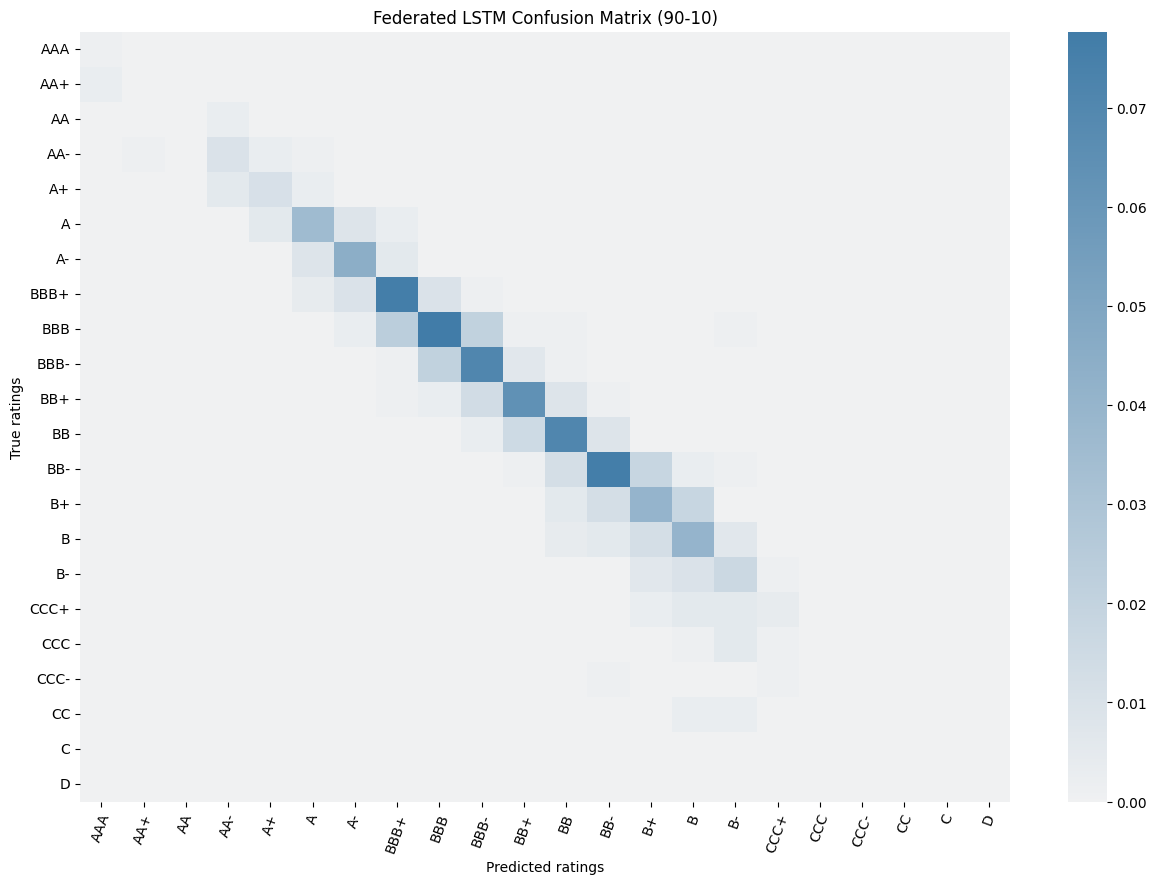

In [130]:
# 90-10
model_fl = run_lstm_simulation([0.9, 0.1], 'split_90_10', 4, 4, 80)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 16:41:02,914 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=80, round_timeout=None)


(launch_and_fit pid=25991) Epoch: 4, Loss: 0.06759181618690491 [repeated 7x across cluster]
(launch_and_evaluate pid=25991) Client 0 evaluate, config {} [repeated 2x across cluster]


2023-06-15 16:41:06,794	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 16:41:07,387 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'memory': 8347962573.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0}
INFO flwr 2023-06-15 16:41:07,387 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 16:41:07,387 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 16:41:08,201 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 16:41:08,202 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 16:41:08,202 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 16:41:08,202 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=26036) Epoch: 1, Loss: 34.86075973510742
(launch_and_fit pid=26036) Epoch: 2, Loss: 37.05783462524414
(launch_and_fit pid=26036) Epoch: 3, Loss: 38.58963394165039
(launch_and_fit pid=26036) Epoch: 4, Loss: 41.724510192871094


DEBUG flwr 2023-06-15 16:41:09,508 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 16:41:09,520 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 16:41:09,538 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:09,629 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 16:41:09,630 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 16:41:09,630 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=26036) Client 2 evaluate, config {}


DEBUG flwr 2023-06-15 16:41:10,374 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:10,402 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:10,494 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:10,494 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:11,282 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:11,316 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:11,418 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:11,419 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:12,288 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:12,314 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:12,402 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:12,403 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:13,194 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:13,222 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:13,305 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:13,305 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...
(launch_and_fit pid=26036) Epoch: 1, Loss: 5.381682395935059 [repeated 37x across cluster]


DEBUG flwr 2023-06-15 16:41:14,096 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:14,117 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:14,202 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:14,202 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)


Saving round 6 aggregated_parameters...
(launch_and_evaluate pid=26038) Client 0 evaluate, config {} [repeated 11x across cluster]


DEBUG flwr 2023-06-15 16:41:15,072 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:15,109 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:15,207 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:15,207 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:16,175 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:16,199 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:16,287 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:16,287 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:17,034 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:17,060 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:17,158 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:17,159 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:17,831 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:17,855 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:17,942 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:17,942 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:18,763 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:18,786 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=26036) Epoch: 4, Loss: 3.0344338417053223 [repeated 45x across cluster]
Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:18,870 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:18,871 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:19,674 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:19,696 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:19,786 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:19,786 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...
(launch_and_evaluate pid=26038) Client 0 evaluate, config {} [repeated 10x across cluster]


DEBUG flwr 2023-06-15 16:41:20,642 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:20,667 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:20,757 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:20,757 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:21,619 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:21,641 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:21,731 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:21,731 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:22,401 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:22,429 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:22,518 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:22,518 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:23,394 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:23,428 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:23,533 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:23,534 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...
(launch_and_evaluate pid=26038) 
(launch_and_fit pid=26036) Epoch: 1, Loss: 7.913577079772949 [repeated 43x across cluster]


DEBUG flwr 2023-06-15 16:41:24,361 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:24,390 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:24,487 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:24,488 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...
(launch_and_evaluate pid=26038) Client 2 evaluate, config {} [repeated 12x across cluster]


DEBUG flwr 2023-06-15 16:41:25,352 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:25,380 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:25,470 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:25,470 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:26,361 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:26,394 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:26,483 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:26,483 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:27,109 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:27,135 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:27,229 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:27,229 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:28,051 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:28,076 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:28,164 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:28,165 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 3)


Saving round 21 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:28,964 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:28,990 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=26036) Epoch: 3, Loss: 4.135076522827148 [repeated 45x across cluster]
Saving round 22 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:29,082 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:29,083 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:29,918 | server.py:232 | fit_round 23 received 2 results and 0 failures


(launch_and_evaluate pid=26038) Client 0 evaluate, config {} [repeated 10x across cluster]
Saving round 23 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:29,946 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:30,041 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:30,041 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:30,717 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:30,754 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:30,854 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:30,855 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 3)


Saving round 24 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:31,628 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:31,656 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:31,756 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:31,756 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 3)


Saving round 25 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:32,428 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:32,462 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:32,548 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:32,548 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 3)


Saving round 26 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:33,375 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:33,408 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:33,500 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:33,500 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 3)


Saving round 27 aggregated_parameters...
(launch_and_fit pid=26036) Epoch: 2, Loss: 0.7825248837471008 [repeated 45x across cluster]


DEBUG flwr 2023-06-15 16:41:34,121 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:34,151 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:34,238 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:34,239 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 3)


Saving round 28 aggregated_parameters...
(launch_and_evaluate pid=26038) Client 0 evaluate, config {} [repeated 12x across cluster]


DEBUG flwr 2023-06-15 16:41:35,032 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:35,055 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:35,141 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:35,141 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 3)


Saving round 29 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:35,951 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:35,974 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:36,059 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:36,060 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 3)


Saving round 30 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:36,739 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:36,762 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:36,849 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:36,850 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 3)


Saving round 31 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:37,521 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:37,549 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:37,647 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:37,648 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 3)


Saving round 32 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:38,327 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:38,350 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:38,436 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:38,437 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 3)


Saving round 33 aggregated_parameters...
(launch_and_fit pid=26038) Epoch: 2, Loss: 1.5875611305236816 [repeated 49x across cluster]


DEBUG flwr 2023-06-15 16:41:39,279 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:39,307 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:39,398 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:39,399 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 3)


Saving round 34 aggregated_parameters...
(launch_and_evaluate pid=26038) Client 2 evaluate, config {} [repeated 12x across cluster]


DEBUG flwr 2023-06-15 16:41:40,264 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:40,288 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:40,375 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:40,375 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 3)


Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:41,251 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:41,277 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:41,366 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:41,367 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 3)


Saving round 36 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:42,235 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:42,258 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:42,346 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:42,346 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 3)


Saving round 37 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:43,188 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:43,210 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:43,296 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:43,297 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 3)


Saving round 38 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:44,103 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:44,130 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=26036) Epoch: 3, Loss: 2.035982608795166 [repeated 41x across cluster]
Saving round 39 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:44,217 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:44,217 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=26038) Client 0 evaluate, config {} [repeated 10x across cluster]


DEBUG flwr 2023-06-15 16:41:45,064 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:45,095 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:45,189 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:45,189 | server.py:218 | fit_round 41: strategy sampled 2 clients (out of 3)


Saving round 40 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:46,051 | server.py:232 | fit_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:46,075 | server.py:168 | evaluate_round 41: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:46,162 | server.py:182 | evaluate_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:46,163 | server.py:218 | fit_round 42: strategy sampled 2 clients (out of 3)


Saving round 41 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:47,045 | server.py:232 | fit_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:47,069 | server.py:168 | evaluate_round 42: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:47,161 | server.py:182 | evaluate_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:47,161 | server.py:218 | fit_round 43: strategy sampled 2 clients (out of 3)


Saving round 42 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:47,871 | server.py:232 | fit_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:47,893 | server.py:168 | evaluate_round 43: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:47,980 | server.py:182 | evaluate_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:47,981 | server.py:218 | fit_round 44: strategy sampled 2 clients (out of 3)


Saving round 43 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:48,750 | server.py:232 | fit_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:48,774 | server.py:168 | evaluate_round 44: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:48,866 | server.py:182 | evaluate_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:48,867 | server.py:218 | fit_round 45: strategy sampled 2 clients (out of 3)


Saving round 44 aggregated_parameters...
(launch_and_fit pid=26036) Epoch: 1, Loss: 0.6333374977111816 [repeated 44x across cluster]


DEBUG flwr 2023-06-15 16:41:49,620 | server.py:232 | fit_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:49,643 | server.py:168 | evaluate_round 45: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:49,731 | server.py:182 | evaluate_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:49,731 | server.py:218 | fit_round 46: strategy sampled 2 clients (out of 3)


Saving round 45 aggregated_parameters...
(launch_and_evaluate pid=26038) Client 2 evaluate, config {} [repeated 12x across cluster]


DEBUG flwr 2023-06-15 16:41:50,612 | server.py:232 | fit_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:50,637 | server.py:168 | evaluate_round 46: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:50,724 | server.py:182 | evaluate_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:50,725 | server.py:218 | fit_round 47: strategy sampled 2 clients (out of 3)


Saving round 46 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:51,597 | server.py:232 | fit_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:51,619 | server.py:168 | evaluate_round 47: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:51,711 | server.py:182 | evaluate_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:51,711 | server.py:218 | fit_round 48: strategy sampled 2 clients (out of 3)


Saving round 47 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:52,486 | server.py:232 | fit_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:52,507 | server.py:168 | evaluate_round 48: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:52,596 | server.py:182 | evaluate_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:52,596 | server.py:218 | fit_round 49: strategy sampled 2 clients (out of 3)


Saving round 48 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:53,447 | server.py:232 | fit_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:53,474 | server.py:168 | evaluate_round 49: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:53,564 | server.py:182 | evaluate_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:53,565 | server.py:218 | fit_round 50: strategy sampled 2 clients (out of 3)


Saving round 49 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:54,305 | server.py:232 | fit_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:54,326 | server.py:168 | evaluate_round 50: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=26036) Epoch: 3, Loss: 0.6964675784111023 [repeated 44x across cluster]
Saving round 50 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:54,425 | server.py:182 | evaluate_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:54,425 | server.py:218 | fit_round 51: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:55,186 | server.py:232 | fit_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:55,211 | server.py:168 | evaluate_round 51: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=26038) Client 2 evaluate, config {} [repeated 10x across cluster]
Saving round 51 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:55,299 | server.py:182 | evaluate_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:55,299 | server.py:218 | fit_round 52: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:56,179 | server.py:232 | fit_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:56,204 | server.py:168 | evaluate_round 52: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:56,295 | server.py:182 | evaluate_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:56,296 | server.py:218 | fit_round 53: strategy sampled 2 clients (out of 3)


Saving round 52 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:57,180 | server.py:232 | fit_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:57,207 | server.py:168 | evaluate_round 53: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:57,296 | server.py:182 | evaluate_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:57,296 | server.py:218 | fit_round 54: strategy sampled 2 clients (out of 3)


Saving round 53 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:58,038 | server.py:232 | fit_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:58,061 | server.py:168 | evaluate_round 54: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:58,152 | server.py:182 | evaluate_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:58,153 | server.py:218 | fit_round 55: strategy sampled 2 clients (out of 3)


Saving round 54 aggregated_parameters...


DEBUG flwr 2023-06-15 16:41:59,076 | server.py:232 | fit_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:59,098 | server.py:168 | evaluate_round 55: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:41:59,187 | server.py:182 | evaluate_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:41:59,187 | server.py:218 | fit_round 56: strategy sampled 2 clients (out of 3)


Saving round 55 aggregated_parameters...
(launch_and_fit pid=26038) Epoch: 4, Loss: 0.9714318513870239 [repeated 43x across cluster]


DEBUG flwr 2023-06-15 16:42:00,100 | server.py:232 | fit_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:00,125 | server.py:168 | evaluate_round 56: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:00,212 | server.py:182 | evaluate_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:00,212 | server.py:218 | fit_round 57: strategy sampled 2 clients (out of 3)


Saving round 56 aggregated_parameters...
(launch_and_evaluate pid=26038) Client 0 evaluate, config {} [repeated 10x across cluster]


DEBUG flwr 2023-06-15 16:42:01,138 | server.py:232 | fit_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:01,159 | server.py:168 | evaluate_round 57: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:01,252 | server.py:182 | evaluate_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:01,252 | server.py:218 | fit_round 58: strategy sampled 2 clients (out of 3)


Saving round 57 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:02,108 | server.py:232 | fit_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:02,130 | server.py:168 | evaluate_round 58: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:02,218 | server.py:182 | evaluate_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:02,218 | server.py:218 | fit_round 59: strategy sampled 2 clients (out of 3)


Saving round 58 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:03,171 | server.py:232 | fit_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:03,194 | server.py:168 | evaluate_round 59: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:03,285 | server.py:182 | evaluate_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:03,285 | server.py:218 | fit_round 60: strategy sampled 2 clients (out of 3)


Saving round 59 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:04,127 | server.py:232 | fit_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:04,151 | server.py:168 | evaluate_round 60: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:04,242 | server.py:182 | evaluate_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:04,242 | server.py:218 | fit_round 61: strategy sampled 2 clients (out of 3)


Saving round 60 aggregated_parameters...
(launch_and_fit pid=26036) Epoch: 4, Loss: 1.1261928081512451 [repeated 40x across cluster]


DEBUG flwr 2023-06-15 16:42:04,910 | server.py:232 | fit_round 61 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:04,939 | server.py:168 | evaluate_round 61: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:05,025 | server.py:182 | evaluate_round 61 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:05,026 | server.py:218 | fit_round 62: strategy sampled 2 clients (out of 3)


Saving round 61 aggregated_parameters...
(launch_and_evaluate pid=26038) Client 0 evaluate, config {} [repeated 12x across cluster]


DEBUG flwr 2023-06-15 16:42:05,845 | server.py:232 | fit_round 62 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:05,876 | server.py:168 | evaluate_round 62: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:05,964 | server.py:182 | evaluate_round 62 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:05,965 | server.py:218 | fit_round 63: strategy sampled 2 clients (out of 3)


Saving round 62 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:06,628 | server.py:232 | fit_round 63 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:06,662 | server.py:168 | evaluate_round 63: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:06,749 | server.py:182 | evaluate_round 63 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:06,749 | server.py:218 | fit_round 64: strategy sampled 2 clients (out of 3)


Saving round 63 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:07,618 | server.py:232 | fit_round 64 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:07,647 | server.py:168 | evaluate_round 64: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:07,739 | server.py:182 | evaluate_round 64 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:07,739 | server.py:218 | fit_round 65: strategy sampled 2 clients (out of 3)


Saving round 64 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:08,596 | server.py:232 | fit_round 65 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:08,626 | server.py:168 | evaluate_round 65: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:08,710 | server.py:182 | evaluate_round 65 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:08,710 | server.py:218 | fit_round 66: strategy sampled 2 clients (out of 3)


Saving round 65 aggregated_parameters...
(launch_and_fit pid=26038) Epoch: 2, Loss: 1.437461256980896 [repeated 44x across cluster]


DEBUG flwr 2023-06-15 16:42:09,696 | server.py:232 | fit_round 66 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:09,739 | server.py:168 | evaluate_round 66: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:09,853 | server.py:182 | evaluate_round 66 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:09,854 | server.py:218 | fit_round 67: strategy sampled 2 clients (out of 3)


Saving round 66 aggregated_parameters...
(launch_and_evaluate pid=26038) Client 2 evaluate, config {} [repeated 10x across cluster]


DEBUG flwr 2023-06-15 16:42:10,488 | server.py:232 | fit_round 67 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:10,541 | server.py:168 | evaluate_round 67: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:10,634 | server.py:182 | evaluate_round 67 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:10,635 | server.py:218 | fit_round 68: strategy sampled 2 clients (out of 3)


Saving round 67 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:11,442 | server.py:232 | fit_round 68 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:11,478 | server.py:168 | evaluate_round 68: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:11,566 | server.py:182 | evaluate_round 68 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:11,567 | server.py:218 | fit_round 69: strategy sampled 2 clients (out of 3)


Saving round 68 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:12,375 | server.py:232 | fit_round 69 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:12,413 | server.py:168 | evaluate_round 69: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:12,504 | server.py:182 | evaluate_round 69 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:12,505 | server.py:218 | fit_round 70: strategy sampled 2 clients (out of 3)


Saving round 69 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:13,303 | server.py:232 | fit_round 70 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:13,339 | server.py:168 | evaluate_round 70: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:13,445 | server.py:182 | evaluate_round 70 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:13,446 | server.py:218 | fit_round 71: strategy sampled 2 clients (out of 3)


Saving round 70 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:14,250 | server.py:232 | fit_round 71 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:14,284 | server.py:168 | evaluate_round 71: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:14,386 | server.py:182 | evaluate_round 71 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:14,386 | server.py:218 | fit_round 72: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=26038) Epoch: 4, Loss: 1.314419150352478 [repeated 44x across cluster]
Saving round 71 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:15,264 | server.py:232 | fit_round 72 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:15,309 | server.py:168 | evaluate_round 72: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:15,396 | server.py:182 | evaluate_round 72 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:15,396 | server.py:218 | fit_round 73: strategy sampled 2 clients (out of 3)


Saving round 72 aggregated_parameters...
(launch_and_evaluate pid=26038) Client 2 evaluate, config {} [repeated 10x across cluster]


DEBUG flwr 2023-06-15 16:42:16,031 | server.py:232 | fit_round 73 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:16,073 | server.py:168 | evaluate_round 73: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:16,168 | server.py:182 | evaluate_round 73 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:16,168 | server.py:218 | fit_round 74: strategy sampled 2 clients (out of 3)


Saving round 73 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:16,947 | server.py:232 | fit_round 74 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:16,984 | server.py:168 | evaluate_round 74: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:17,073 | server.py:182 | evaluate_round 74 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:17,074 | server.py:218 | fit_round 75: strategy sampled 2 clients (out of 3)


Saving round 74 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:17,904 | server.py:232 | fit_round 75 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:17,945 | server.py:168 | evaluate_round 75: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:18,031 | server.py:182 | evaluate_round 75 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:18,031 | server.py:218 | fit_round 76: strategy sampled 2 clients (out of 3)


Saving round 75 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:18,721 | server.py:232 | fit_round 76 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:18,757 | server.py:168 | evaluate_round 76: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:18,843 | server.py:182 | evaluate_round 76 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:18,844 | server.py:218 | fit_round 77: strategy sampled 2 clients (out of 3)


Saving round 76 aggregated_parameters...
(launch_and_fit pid=26036) Epoch: 2, Loss: 0.8511611223220825 [repeated 43x across cluster]


DEBUG flwr 2023-06-15 16:42:19,624 | server.py:232 | fit_round 77 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:19,657 | server.py:168 | evaluate_round 77: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:19,742 | server.py:182 | evaluate_round 77 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:19,743 | server.py:218 | fit_round 78: strategy sampled 2 clients (out of 3)


Saving round 77 aggregated_parameters...
(launch_and_evaluate pid=26038) Client 2 evaluate, config {} [repeated 12x across cluster]


DEBUG flwr 2023-06-15 16:42:20,643 | server.py:232 | fit_round 78 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:20,674 | server.py:168 | evaluate_round 78: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:20,764 | server.py:182 | evaluate_round 78 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:20,764 | server.py:218 | fit_round 79: strategy sampled 2 clients (out of 3)


Saving round 78 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:21,688 | server.py:232 | fit_round 79 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:21,722 | server.py:168 | evaluate_round 79: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:21,813 | server.py:182 | evaluate_round 79 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:21,814 | server.py:218 | fit_round 80: strategy sampled 2 clients (out of 3)


Saving round 79 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:22,673 | server.py:232 | fit_round 80 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:22,708 | server.py:168 | evaluate_round 80: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:22,799 | server.py:182 | evaluate_round 80 received 2 results and 0 failures
INFO flwr 2023-06-15 16:42:22,800 | server.py:147 | FL finished in 74.59724000003189
INFO flwr 2023-06-15 16:42:22,801 | app.py:218 | app_fit: losses_distributed [(1, 127.17337031900139), (2, 127.17337031900139), (3, 107.500693481276), (4, 106.8987517337032), (5, 106.85298196948682), (6, 106.73647711511789), (7, 106.68238557558946), (8, 106.6629680998613), (9, 106.63384188626907), (10, 106.64355062413316), (11, 106.61719833564494), (12, 106.61026352288488), (13, 106.61026352288488), (14, 106.62690707350902), (15, 106.63384188626907), (16, 106.62690707350902), (17, 106.58668515950069), (18, 106.59361997226075), (19, 106.59361997226075), (20, 106.59361997226075), (21, 106.582524

Saving round 80 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_40_30_30/model_round_80.pth
0.8918169209431346
0.002022260591707788
0.9694557414425239
0.9704301075268817


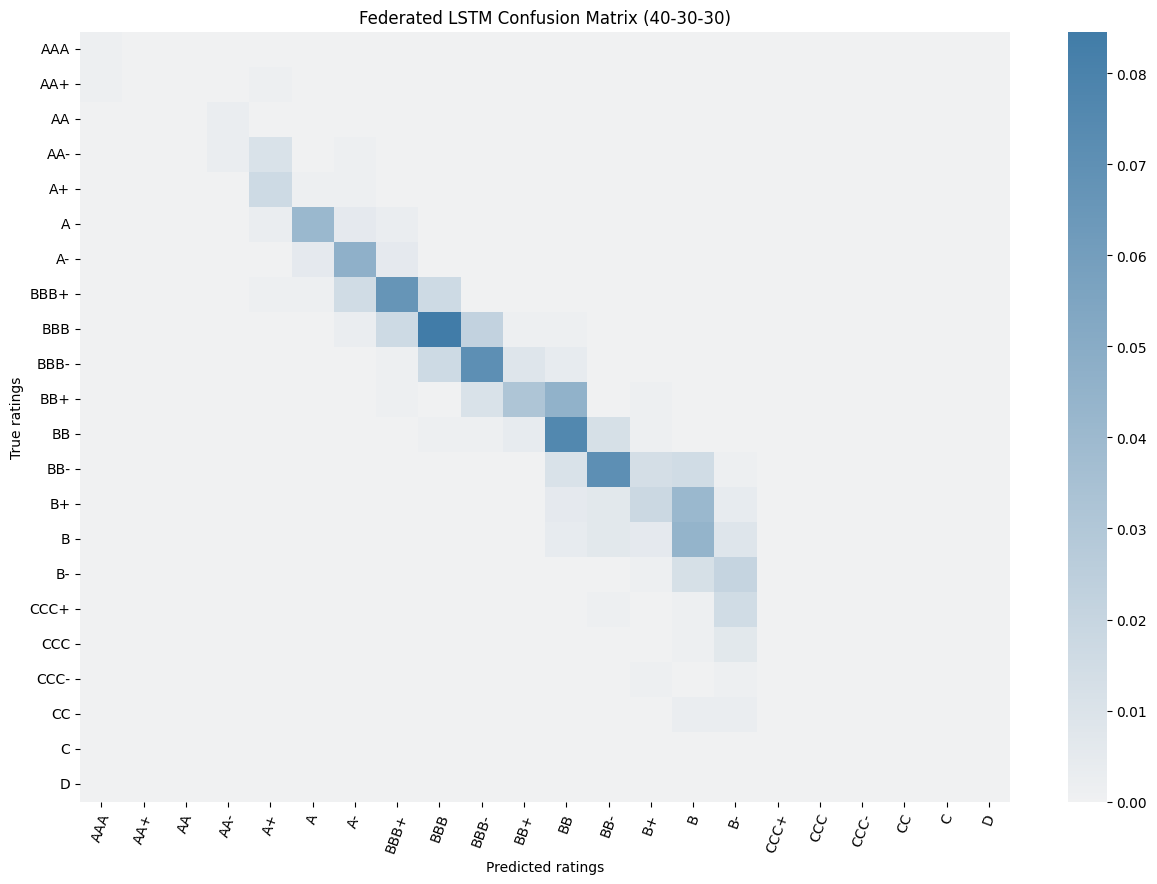

In [131]:
# 40-30-30
model_fl = run_lstm_simulation([0.4, 0.3, 0.3], 'split_40_30_30', 4, 4, 80)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (40-30-30)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 16:42:23,385 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=80, round_timeout=None)


(launch_and_fit pid=26036) Epoch: 4, Loss: 1.0405775308609009 [repeated 29x across cluster]
(launch_and_evaluate pid=26038) Client 1 evaluate, config {} [repeated 6x across cluster]


2023-06-15 16:42:27,242	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 16:42:27,789 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'CPU': 8.0, 'memory': 8331712922.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-06-15 16:42:27,789 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 16:42:27,790 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 16:42:28,569 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 16:42:28,569 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 16:42:28,569 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 16:42:28,570 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=26065) Epoch: 1, Loss: 37.29442596435547
(launch_and_fit pid=26065) Epoch: 2, Loss: 32.244327545166016


DEBUG flwr 2023-06-15 16:42:29,999 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 16:42:30,026 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 16:42:30,062 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:30,158 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 16:42:30,158 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 16:42:30,159 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 3)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=26065) Client 1 evaluate, config {}


DEBUG flwr 2023-06-15 16:42:30,401 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:30,436 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:30,541 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:30,542 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 3)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:30,814 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:30,843 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:31,019 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:31,020 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 3)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:32,601 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:32,672 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 3)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:32,892 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:32,893 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=26072) Epoch: 3, Loss: 11.399430274963379 [repeated 37x across cluster]


DEBUG flwr 2023-06-15 16:42:34,743 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:34,779 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:34,927 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:34,928 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 3)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:35,231 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:35,275 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=26072) Client 1 evaluate, config {} [repeated 9x across cluster]
Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:35,494 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:35,496 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:37,071 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:37,098 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:37,185 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:37,185 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 3)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:37,472 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:37,495 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:37,579 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:37,580 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 3)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:39,057 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:39,084 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:39,175 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:39,176 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 3)


Saving round 9 aggregated_parameters...
(launch_and_fit pid=26072) Epoch: 1, Loss: 3.877253532409668 [repeated 34x across cluster]
(launch_and_evaluate pid=26072) Client 2 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:42:40,711 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:40,734 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:40,822 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:40,823 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 3)


Saving round 10 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:42,360 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:42,383 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:42,474 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:42,475 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 3)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:42,751 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:42,800 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:42,902 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:42,903 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 3)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:43,175 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:43,200 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:43,290 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:43,291 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 3)


Saving round 13 aggregated_parameters...
(launch_and_fit pid=26065) Epoch: 3, Loss: 6.836190223693848 [repeated 38x across cluster]


DEBUG flwr 2023-06-15 16:42:45,097 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:45,131 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:45,230 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:45,230 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 3)


Saving round 14 aggregated_parameters...
(launch_and_evaluate pid=26072) Client 0 evaluate, config {} [repeated 10x across cluster]


DEBUG flwr 2023-06-15 16:42:46,917 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:46,945 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 3)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:47,178 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:47,179 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:47,443 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:47,470 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:47,562 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:47,562 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 3)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:49,060 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:49,088 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:49,177 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:49,178 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 3)


Saving round 17 aggregated_parameters...
(launch_and_fit pid=26065) Epoch: 1, Loss: 4.244089603424072 [repeated 30x across cluster]
(launch_and_evaluate pid=26072) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:42:50,728 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:50,754 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:50,843 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:50,844 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 3)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:52,402 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:52,447 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:52,531 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:52,531 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 3)


Saving round 19 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:54,096 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:54,120 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:54,210 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:54,210 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 3)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:54,496 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:54,524 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:54,617 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:54,618 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 3)


Saving round 21 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:54,904 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:54,927 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 3)


(launch_and_fit pid=26065) Epoch: 2, Loss: 0.8386072516441345 [repeated 29x across cluster]
Saving round 22 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:55,019 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:55,020 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:55,294 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:55,317 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:55,409 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:55,409 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 3)


Saving round 23 aggregated_parameters...
(launch_and_evaluate pid=26072) Client 1 evaluate, config {} [repeated 12x across cluster]


DEBUG flwr 2023-06-15 16:42:56,937 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:56,959 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:57,046 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:57,047 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 3)


Saving round 24 aggregated_parameters...


DEBUG flwr 2023-06-15 16:42:58,673 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:58,694 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:42:58,784 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:42:58,784 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 3)


Saving round 25 aggregated_parameters...
(launch_and_fit pid=26072) Epoch: 3, Loss: 1.9977632761001587 [repeated 37x across cluster]


DEBUG flwr 2023-06-15 16:43:00,375 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:00,398 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:00,489 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:00,489 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 3)


Saving round 26 aggregated_parameters...
(launch_and_evaluate pid=26072) Client 2 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:43:02,165 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:02,186 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:02,285 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:02,285 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 3)


Saving round 27 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:03,889 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:03,909 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:03,998 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:03,998 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 3)


Saving round 28 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:04,273 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:04,296 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:04,398 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:04,399 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 3)


Saving round 29 aggregated_parameters...
(launch_and_fit pid=26065) Epoch: 2, Loss: 2.089101791381836 [repeated 31x across cluster]


DEBUG flwr 2023-06-15 16:43:05,857 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:05,877 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:05,964 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:05,965 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 3)


Saving round 30 aggregated_parameters...
(launch_and_evaluate pid=26072) Client 0 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:43:06,229 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:06,253 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:06,349 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:06,349 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 3)


Saving round 31 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:07,904 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:07,928 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:08,030 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:08,030 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 3)


Saving round 32 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:09,622 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:09,644 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:09,733 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:09,734 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 3)


Saving round 33 aggregated_parameters...
(launch_and_fit pid=26072) Epoch: 2, Loss: 2.1777167320251465 [repeated 32x across cluster]


DEBUG flwr 2023-06-15 16:43:11,178 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:11,201 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:11,291 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:11,291 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 3)


Saving round 34 aggregated_parameters...
(launch_and_evaluate pid=26065) Client 0 evaluate, config {} [repeated 9x across cluster]


DEBUG flwr 2023-06-15 16:43:12,815 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:12,836 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:12,925 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:12,926 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 3)


Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:14,572 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:14,599 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:14,687 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:14,687 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 3)


Saving round 36 aggregated_parameters...
(launch_and_fit pid=26072) Epoch: 2, Loss: 1.6196684837341309 [repeated 24x across cluster]


DEBUG flwr 2023-06-15 16:43:16,357 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:16,382 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:16,476 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:16,477 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 3)


Saving round 37 aggregated_parameters...
(launch_and_evaluate pid=26065) Client 2 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:43:17,960 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:17,985 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:18,079 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:18,080 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 3)


Saving round 38 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:19,595 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:19,619 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:19,717 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:19,717 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 3)


Saving round 39 aggregated_parameters...
(launch_and_fit pid=26065) Epoch: 3, Loss: 1.808506965637207 [repeated 25x across cluster]


DEBUG flwr 2023-06-15 16:43:21,203 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:21,228 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:21,321 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:21,322 | server.py:218 | fit_round 41: strategy sampled 2 clients (out of 3)


Saving round 40 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:21,595 | server.py:232 | fit_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:21,622 | server.py:168 | evaluate_round 41: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:21,724 | server.py:182 | evaluate_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:21,725 | server.py:218 | fit_round 42: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=26072) Client 1 evaluate, config {} [repeated 7x across cluster]
Saving round 41 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:21,992 | server.py:232 | fit_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:22,016 | server.py:168 | evaluate_round 42: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:22,111 | server.py:182 | evaluate_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:22,112 | server.py:218 | fit_round 43: strategy sampled 2 clients (out of 3)


Saving round 42 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:22,385 | server.py:232 | fit_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:22,407 | server.py:168 | evaluate_round 43: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:22,497 | server.py:182 | evaluate_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:22,498 | server.py:218 | fit_round 44: strategy sampled 2 clients (out of 3)


Saving round 43 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:24,111 | server.py:232 | fit_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:24,135 | server.py:168 | evaluate_round 44: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:24,229 | server.py:182 | evaluate_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:24,229 | server.py:218 | fit_round 45: strategy sampled 2 clients (out of 3)


Saving round 44 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:25,804 | server.py:232 | fit_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:25,834 | server.py:168 | evaluate_round 45: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:25,925 | server.py:182 | evaluate_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:25,925 | server.py:218 | fit_round 46: strategy sampled 2 clients (out of 3)


Saving round 45 aggregated_parameters...
(launch_and_fit pid=26065) Epoch: 4, Loss: 1.424922227859497 [repeated 41x across cluster]


DEBUG flwr 2023-06-15 16:43:26,203 | server.py:232 | fit_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:26,229 | server.py:168 | evaluate_round 46: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:26,319 | server.py:182 | evaluate_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:26,320 | server.py:218 | fit_round 47: strategy sampled 2 clients (out of 3)


Saving round 46 aggregated_parameters...
(launch_and_evaluate pid=26072) Client 2 evaluate, config {} [repeated 12x across cluster]


DEBUG flwr 2023-06-15 16:43:27,829 | server.py:232 | fit_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:27,887 | server.py:168 | evaluate_round 47: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:28,018 | server.py:182 | evaluate_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:28,019 | server.py:218 | fit_round 48: strategy sampled 2 clients (out of 3)


Saving round 47 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:29,578 | server.py:232 | fit_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:29,604 | server.py:168 | evaluate_round 48: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:29,698 | server.py:182 | evaluate_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:29,699 | server.py:218 | fit_round 49: strategy sampled 2 clients (out of 3)


Saving round 48 aggregated_parameters...
(launch_and_fit pid=26065) Epoch: 3, Loss: 1.7196781635284424 [repeated 31x across cluster]


DEBUG flwr 2023-06-15 16:43:31,241 | server.py:232 | fit_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:31,268 | server.py:168 | evaluate_round 49: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:31,357 | server.py:182 | evaluate_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:31,358 | server.py:218 | fit_round 50: strategy sampled 2 clients (out of 3)


Saving round 49 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:31,619 | server.py:232 | fit_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:31,643 | server.py:168 | evaluate_round 50: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:31,747 | server.py:182 | evaluate_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:31,747 | server.py:218 | fit_round 51: strategy sampled 2 clients (out of 3)


(launch_and_evaluate pid=26072) Client 2 evaluate, config {} [repeated 6x across cluster]
Saving round 50 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:33,269 | server.py:232 | fit_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:33,294 | server.py:168 | evaluate_round 51: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:33,386 | server.py:182 | evaluate_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:33,386 | server.py:218 | fit_round 52: strategy sampled 2 clients (out of 3)


Saving round 51 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:35,029 | server.py:232 | fit_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:35,056 | server.py:168 | evaluate_round 52: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:35,162 | server.py:182 | evaluate_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:35,163 | server.py:218 | fit_round 53: strategy sampled 2 clients (out of 3)


Saving round 52 aggregated_parameters...
(launch_and_fit pid=26065) Epoch: 2, Loss: 0.9258012175559998 [repeated 31x across cluster]


DEBUG flwr 2023-06-15 16:43:36,617 | server.py:232 | fit_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:36,644 | server.py:168 | evaluate_round 53: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:36,741 | server.py:182 | evaluate_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:36,741 | server.py:218 | fit_round 54: strategy sampled 2 clients (out of 3)


Saving round 53 aggregated_parameters...
(launch_and_evaluate pid=26072) Client 2 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:43:37,043 | server.py:232 | fit_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:37,069 | server.py:168 | evaluate_round 54: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:37,165 | server.py:182 | evaluate_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:37,166 | server.py:218 | fit_round 55: strategy sampled 2 clients (out of 3)


Saving round 54 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:38,848 | server.py:232 | fit_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:38,874 | server.py:168 | evaluate_round 55: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:38,965 | server.py:182 | evaluate_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:38,965 | server.py:218 | fit_round 56: strategy sampled 2 clients (out of 3)


Saving round 55 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:40,560 | server.py:232 | fit_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:40,590 | server.py:168 | evaluate_round 56: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:40,684 | server.py:182 | evaluate_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:40,685 | server.py:218 | fit_round 57: strategy sampled 2 clients (out of 3)


Saving round 56 aggregated_parameters...
(launch_and_fit pid=26072) Epoch: 4, Loss: 0.7822617292404175 [repeated 30x across cluster]
(launch_and_evaluate pid=26072) Client 2 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:43:42,224 | server.py:232 | fit_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:42,249 | server.py:168 | evaluate_round 57: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:42,345 | server.py:182 | evaluate_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:42,346 | server.py:218 | fit_round 58: strategy sampled 2 clients (out of 3)


Saving round 57 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:43,891 | server.py:232 | fit_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:43,915 | server.py:168 | evaluate_round 58: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:44,026 | server.py:182 | evaluate_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:44,027 | server.py:218 | fit_round 59: strategy sampled 2 clients (out of 3)


Saving round 58 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:44,303 | server.py:232 | fit_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:44,334 | server.py:168 | evaluate_round 59: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:44,431 | server.py:182 | evaluate_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:44,432 | server.py:218 | fit_round 60: strategy sampled 2 clients (out of 3)


Saving round 59 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:45,983 | server.py:232 | fit_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:46,023 | server.py:168 | evaluate_round 60: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:46,117 | server.py:182 | evaluate_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:46,118 | server.py:218 | fit_round 61: strategy sampled 2 clients (out of 3)


Saving round 60 aggregated_parameters...
(launch_and_fit pid=26072) Epoch: 3, Loss: 0.5572590231895447 [repeated 27x across cluster]
(launch_and_evaluate pid=26072) Client 2 evaluate, config {} [repeated 8x across cluster]


DEBUG flwr 2023-06-15 16:43:47,743 | server.py:232 | fit_round 61 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:47,777 | server.py:168 | evaluate_round 61: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:47,877 | server.py:182 | evaluate_round 61 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:47,877 | server.py:218 | fit_round 62: strategy sampled 2 clients (out of 3)


Saving round 61 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:48,126 | server.py:232 | fit_round 62 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:48,165 | server.py:168 | evaluate_round 62: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:48,262 | server.py:182 | evaluate_round 62 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:48,263 | server.py:218 | fit_round 63: strategy sampled 2 clients (out of 3)


Saving round 62 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:49,777 | server.py:232 | fit_round 63 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:49,809 | server.py:168 | evaluate_round 63: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:49,907 | server.py:182 | evaluate_round 63 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:49,908 | server.py:218 | fit_round 64: strategy sampled 2 clients (out of 3)


Saving round 63 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:50,176 | server.py:232 | fit_round 64 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:50,207 | server.py:168 | evaluate_round 64: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:50,304 | server.py:182 | evaluate_round 64 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:50,305 | server.py:218 | fit_round 65: strategy sampled 2 clients (out of 3)


Saving round 64 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:50,569 | server.py:232 | fit_round 65 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:50,601 | server.py:168 | evaluate_round 65: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:50,701 | server.py:182 | evaluate_round 65 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:50,701 | server.py:218 | fit_round 66: strategy sampled 2 clients (out of 3)


Saving round 65 aggregated_parameters...
(launch_and_fit pid=26072) Epoch: 1, Loss: 3.2499961853027344 [repeated 46x across cluster]


DEBUG flwr 2023-06-15 16:43:52,262 | server.py:232 | fit_round 66 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:52,295 | server.py:168 | evaluate_round 66: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:52,387 | server.py:182 | evaluate_round 66 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:52,388 | server.py:218 | fit_round 67: strategy sampled 2 clients (out of 3)


Saving round 66 aggregated_parameters...
(launch_and_evaluate pid=26065) Client 2 evaluate, config {} [repeated 11x across cluster]


DEBUG flwr 2023-06-15 16:43:54,027 | server.py:232 | fit_round 67 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:54,061 | server.py:168 | evaluate_round 67: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:54,159 | server.py:182 | evaluate_round 67 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:54,159 | server.py:218 | fit_round 68: strategy sampled 2 clients (out of 3)


Saving round 67 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:54,466 | server.py:232 | fit_round 68 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:54,500 | server.py:168 | evaluate_round 68: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:54,593 | server.py:182 | evaluate_round 68 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:54,593 | server.py:218 | fit_round 69: strategy sampled 2 clients (out of 3)


Saving round 68 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:56,194 | server.py:232 | fit_round 69 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:56,234 | server.py:168 | evaluate_round 69: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:56,330 | server.py:182 | evaluate_round 69 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:56,330 | server.py:218 | fit_round 70: strategy sampled 2 clients (out of 3)


Saving round 69 aggregated_parameters...
(launch_and_fit pid=26072) Epoch: 3, Loss: 0.4725005626678467 [repeated 26x across cluster]
(launch_and_evaluate pid=26072) Client 2 evaluate, config {} [repeated 7x across cluster]


DEBUG flwr 2023-06-15 16:43:57,964 | server.py:232 | fit_round 70 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:58,000 | server.py:168 | evaluate_round 70: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:58,095 | server.py:182 | evaluate_round 70 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:58,095 | server.py:218 | fit_round 71: strategy sampled 2 clients (out of 3)


Saving round 70 aggregated_parameters...


DEBUG flwr 2023-06-15 16:43:59,651 | server.py:232 | fit_round 71 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:59,704 | server.py:168 | evaluate_round 71: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:43:59,795 | server.py:182 | evaluate_round 71 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:43:59,795 | server.py:218 | fit_round 72: strategy sampled 2 clients (out of 3)


Saving round 71 aggregated_parameters...


DEBUG flwr 2023-06-15 16:44:01,306 | server.py:232 | fit_round 72 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:01,343 | server.py:168 | evaluate_round 72: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:44:01,443 | server.py:182 | evaluate_round 72 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:01,444 | server.py:218 | fit_round 73: strategy sampled 2 clients (out of 3)


Saving round 72 aggregated_parameters...
(launch_and_fit pid=26072) Epoch: 3, Loss: 1.730503797531128 [repeated 24x across cluster]
(launch_and_evaluate pid=26072) Client 2 evaluate, config {} [repeated 6x across cluster]


DEBUG flwr 2023-06-15 16:44:02,955 | server.py:232 | fit_round 73 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:02,990 | server.py:168 | evaluate_round 73: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:44:03,080 | server.py:182 | evaluate_round 73 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:03,081 | server.py:218 | fit_round 74: strategy sampled 2 clients (out of 3)


Saving round 73 aggregated_parameters...


DEBUG flwr 2023-06-15 16:44:03,352 | server.py:232 | fit_round 74 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:03,390 | server.py:168 | evaluate_round 74: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:44:03,476 | server.py:182 | evaluate_round 74 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:03,477 | server.py:218 | fit_round 75: strategy sampled 2 clients (out of 3)


Saving round 74 aggregated_parameters...


DEBUG flwr 2023-06-15 16:44:04,995 | server.py:232 | fit_round 75 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:05,032 | server.py:168 | evaluate_round 75: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:44:05,121 | server.py:182 | evaluate_round 75 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:05,122 | server.py:218 | fit_round 76: strategy sampled 2 clients (out of 3)


Saving round 75 aggregated_parameters...
(launch_and_fit pid=26072) Epoch: 3, Loss: 1.5585839748382568 [repeated 32x across cluster]


DEBUG flwr 2023-06-15 16:44:06,726 | server.py:232 | fit_round 76 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:06,762 | server.py:168 | evaluate_round 76: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:44:06,852 | server.py:182 | evaluate_round 76 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:06,852 | server.py:218 | fit_round 77: strategy sampled 2 clients (out of 3)


Saving round 76 aggregated_parameters...


DEBUG flwr 2023-06-15 16:44:07,121 | server.py:232 | fit_round 77 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:07,158 | server.py:168 | evaluate_round 77: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:44:07,254 | server.py:182 | evaluate_round 77 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:07,254 | server.py:218 | fit_round 78: strategy sampled 2 clients (out of 3)


Saving round 77 aggregated_parameters...


DEBUG flwr 2023-06-15 16:44:07,530 | server.py:232 | fit_round 78 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:07,571 | server.py:168 | evaluate_round 78: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:44:07,677 | server.py:182 | evaluate_round 78 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:07,678 | server.py:218 | fit_round 79: strategy sampled 2 clients (out of 3)


Saving round 78 aggregated_parameters...
(launch_and_evaluate pid=26065) Client 2 evaluate, config {} [repeated 11x across cluster]


DEBUG flwr 2023-06-15 16:44:07,967 | server.py:232 | fit_round 79 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:08,003 | server.py:168 | evaluate_round 79: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:44:08,105 | server.py:182 | evaluate_round 79 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:08,106 | server.py:218 | fit_round 80: strategy sampled 2 clients (out of 3)


Saving round 79 aggregated_parameters...


DEBUG flwr 2023-06-15 16:44:08,373 | server.py:232 | fit_round 80 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:44:08,412 | server.py:168 | evaluate_round 80: strategy sampled 2 clients (out of 3)
DEBUG flwr 2023-06-15 16:44:08,501 | server.py:182 | evaluate_round 80 received 2 results and 0 failures
INFO flwr 2023-06-15 16:44:08,501 | server.py:147 | FL finished in 99.93118999991566
INFO flwr 2023-06-15 16:44:08,503 | app.py:218 | app_fit: losses_distributed [(1, 20.715672676837727), (2, 10.30235783633842), (3, 10.095700416088766), (4, 9.027739251040222), (5, 8.764216366158113), (6, 8.72122052704577), (7, 8.295423023578364), (8, 8.256588072122053), (9, 8.25242718446602), (10, 8.27877947295423), (11, 8.185852981969488), (12, 8.17753120665742), (13, 8.20388349514563), (14, 8.167822468793343), (15, 8.156726768377254), (16, 8.169209431345354), (17, 7.058252427184466), (18, 3.2288488210818307), (19, 3.163661581137309), (20, 1.0374479889042996), (21, 1.0263522884882108), (22, 1

Saving round 80 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_80_10_10/model_round_80.pth
1.001386962552011
0.002270718735945603
0.9622038389253473
0.9640479360852198


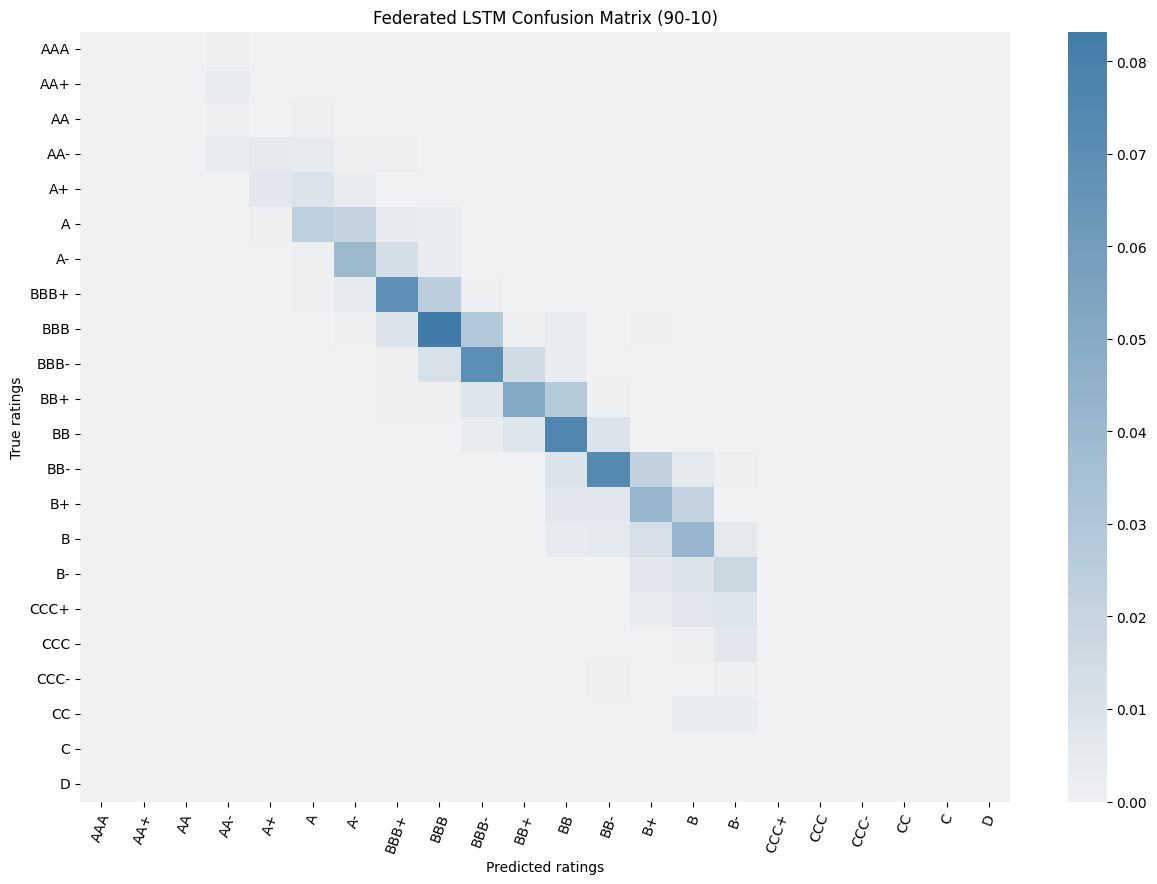

In [132]:
# 80-10-10
model_fl = run_lstm_simulation([0.8, 0.1, 0.1], 'split_80_10_10', 4, 4, 80)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (90-10)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 16:34:40,987 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=80, round_timeout=None)


(launch_and_fit pid=25870) Epoch: 4, Loss: 0.3386519253253937 [repeated 33x across cluster]
(launch_and_evaluate pid=25870) Client 2 evaluate, config {} [repeated 8x across cluster]


2023-06-15 16:34:44,777	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 16:34:45,598 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 7972480615.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-06-15 16:34:45,598 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 16:34:45,599 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 16:34:46,507 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 16:34:46,508 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 16:34:46,508 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 16:34:46,508 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=25902) Epoch: 1, Loss: 33.53369140625
(launch_and_fit pid=25902) Epoch: 2, Loss: 43.609310150146484
(launch_and_fit pid=25902) Epoch: 3, Loss: 41.27894592285156
(launch_and_fit pid=25902) Epoch: 4, Loss: 40.81202697753906


DEBUG flwr 2023-06-15 16:34:47,600 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 16:34:47,628 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 16:34:47,651 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:47,759 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 16:34:47,760 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 16:34:47,760 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=25902) Client 0 evaluate, config {}


DEBUG flwr 2023-06-15 16:34:48,179 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:48,207 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:48,307 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:48,307 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:48,734 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:48,759 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:48,844 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:48,844 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:49,291 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:49,316 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:49,412 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:49,413 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:49,856 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:49,883 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:49,975 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:49,976 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:50,384 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:50,411 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:50,498 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:50,498 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:50,963 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:50,998 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:51,084 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:51,085 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:51,486 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:51,507 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:51,594 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:51,594 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...
(launch_and_fit pid=25902) Epoch: 1, Loss: 12.746912002563477 [repeated 61x across cluster]


DEBUG flwr 2023-06-15 16:34:52,026 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:52,057 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:52,143 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:52,143 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:52,584 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:52,609 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:52,703 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:52,704 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...
(launch_and_evaluate pid=25905) Client 0 evaluate, config {} [repeated 19x across cluster]


DEBUG flwr 2023-06-15 16:34:53,166 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:53,199 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:53,286 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:53,286 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:53,714 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:53,741 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:53,826 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:53,827 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:54,242 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:54,270 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:54,359 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:54,360 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:54,797 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:54,827 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:54,916 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:54,916 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:55,338 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:55,367 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:55,455 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:55,455 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:55,866 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:55,894 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:55,990 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:55,991 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:56,414 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:56,445 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:56,528 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:56,529 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...
(launch_and_fit pid=25902) Epoch: 1, Loss: 9.867932319641113 [repeated 72x across cluster]


DEBUG flwr 2023-06-15 16:34:57,013 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:57,043 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:57,130 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:57,130 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:57,568 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:57,593 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:57,687 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:57,687 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...
(launch_and_evaluate pid=25905) Client 2 evaluate, config {} [repeated 18x across cluster]


DEBUG flwr 2023-06-15 16:34:58,132 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:58,160 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:58,252 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:58,253 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:58,749 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:58,778 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:58,866 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:58,866 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 5)


Saving round 21 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:59,320 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:59,349 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:34:59,449 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:59,449 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 5)


Saving round 22 aggregated_parameters...


DEBUG flwr 2023-06-15 16:34:59,928 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:34:59,954 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:00,048 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:00,048 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 5)


Saving round 23 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:00,528 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:00,553 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:00,641 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:00,642 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 5)


Saving round 24 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:01,053 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:01,078 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:01,164 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:01,164 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 5)


Saving round 25 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:01,589 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:01,616 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:01,703 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:01,703 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 5)


Saving round 26 aggregated_parameters...
(launch_and_fit pid=25902) Epoch: 1, Loss: 8.421476364135742 [repeated 72x across cluster]


DEBUG flwr 2023-06-15 16:35:02,133 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:02,157 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:02,242 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:02,242 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 5)


Saving round 27 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:02,670 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:02,694 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:02,780 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:02,780 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 5)


Saving round 28 aggregated_parameters...
(launch_and_evaluate pid=25905) Client 4 evaluate, config {} [repeated 18x across cluster]


DEBUG flwr 2023-06-15 16:35:03,203 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:03,226 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:03,315 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:03,315 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 5)


Saving round 29 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:03,754 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:03,778 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:03,862 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:03,863 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 5)


Saving round 30 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:04,288 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:04,312 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:04,397 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:04,397 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 5)


Saving round 31 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:04,831 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:04,853 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:04,941 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:04,941 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 5)


Saving round 32 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:05,375 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:05,398 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:05,483 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:05,484 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 5)


Saving round 33 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:05,915 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:05,936 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:06,022 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:06,022 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 5)


Saving round 34 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:06,462 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:06,484 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:06,571 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:06,571 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 5)


Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:06,987 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:07,008 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:07,095 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:07,095 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=25902) Epoch: 3, Loss: 6.72294807434082 [repeated 76x across cluster]
Saving round 36 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:07,531 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:07,554 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:07,642 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:07,642 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 5)


Saving round 37 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:08,093 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:08,118 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=25905) Client 0 evaluate, config {} [repeated 18x across cluster]
Saving round 38 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:08,206 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:08,207 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:08,641 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:08,664 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:08,755 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:08,755 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 5)


Saving round 39 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:09,208 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:09,231 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:09,342 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:09,345 | server.py:218 | fit_round 41: strategy sampled 2 clients (out of 5)


Saving round 40 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:09,837 | server.py:232 | fit_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:09,857 | server.py:168 | evaluate_round 41: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:09,949 | server.py:182 | evaluate_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:09,949 | server.py:218 | fit_round 42: strategy sampled 2 clients (out of 5)


Saving round 41 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:10,382 | server.py:232 | fit_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:10,409 | server.py:168 | evaluate_round 42: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:10,497 | server.py:182 | evaluate_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:10,497 | server.py:218 | fit_round 43: strategy sampled 2 clients (out of 5)


Saving round 42 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:10,950 | server.py:232 | fit_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:10,971 | server.py:168 | evaluate_round 43: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:11,060 | server.py:182 | evaluate_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:11,060 | server.py:218 | fit_round 44: strategy sampled 2 clients (out of 5)


Saving round 43 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:11,504 | server.py:232 | fit_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:11,528 | server.py:168 | evaluate_round 44: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:11,617 | server.py:182 | evaluate_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:11,618 | server.py:218 | fit_round 45: strategy sampled 2 clients (out of 5)


Saving round 44 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:12,053 | server.py:232 | fit_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:12,076 | server.py:168 | evaluate_round 45: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=25902) Epoch: 2, Loss: 3.8902547359466553 [repeated 71x across cluster]
Saving round 45 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:12,163 | server.py:182 | evaluate_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:12,164 | server.py:218 | fit_round 46: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:12,610 | server.py:232 | fit_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:12,632 | server.py:168 | evaluate_round 46: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:12,722 | server.py:182 | evaluate_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:12,723 | server.py:218 | fit_round 47: strategy sampled 2 clients (out of 5)


Saving round 46 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:13,164 | server.py:232 | fit_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:13,187 | server.py:168 | evaluate_round 47: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=25905) Client 4 evaluate, config {} [repeated 18x across cluster]
Saving round 47 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:13,274 | server.py:182 | evaluate_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:13,275 | server.py:218 | fit_round 48: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:13,841 | server.py:232 | fit_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:13,872 | server.py:168 | evaluate_round 48: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:13,969 | server.py:182 | evaluate_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:13,970 | server.py:218 | fit_round 49: strategy sampled 2 clients (out of 5)


Saving round 48 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:14,483 | server.py:232 | fit_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:14,512 | server.py:168 | evaluate_round 49: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:14,614 | server.py:182 | evaluate_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:14,615 | server.py:218 | fit_round 50: strategy sampled 2 clients (out of 5)


Saving round 49 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:15,092 | server.py:232 | fit_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:15,126 | server.py:168 | evaluate_round 50: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:15,226 | server.py:182 | evaluate_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:15,227 | server.py:218 | fit_round 51: strategy sampled 2 clients (out of 5)


Saving round 50 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:15,640 | server.py:232 | fit_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:15,673 | server.py:168 | evaluate_round 51: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:15,763 | server.py:182 | evaluate_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:15,764 | server.py:218 | fit_round 52: strategy sampled 2 clients (out of 5)


Saving round 51 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:16,209 | server.py:232 | fit_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:16,236 | server.py:168 | evaluate_round 52: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:16,323 | server.py:182 | evaluate_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:16,324 | server.py:218 | fit_round 53: strategy sampled 2 clients (out of 5)


Saving round 52 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:16,747 | server.py:232 | fit_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:16,775 | server.py:168 | evaluate_round 53: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:16,866 | server.py:182 | evaluate_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:16,867 | server.py:218 | fit_round 54: strategy sampled 2 clients (out of 5)


Saving round 53 aggregated_parameters...
(launch_and_fit pid=25902) Epoch: 2, Loss: 1.9532749652862549 [repeated 70x across cluster]


DEBUG flwr 2023-06-15 16:35:17,311 | server.py:232 | fit_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:17,342 | server.py:168 | evaluate_round 54: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:17,445 | server.py:182 | evaluate_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:17,446 | server.py:218 | fit_round 55: strategy sampled 2 clients (out of 5)


Saving round 54 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:17,887 | server.py:232 | fit_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:17,917 | server.py:168 | evaluate_round 55: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:18,006 | server.py:182 | evaluate_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:18,006 | server.py:218 | fit_round 56: strategy sampled 2 clients (out of 5)


Saving round 55 aggregated_parameters...
(launch_and_evaluate pid=25902) Client 0 evaluate, config {} [repeated 17x across cluster]


DEBUG flwr 2023-06-15 16:35:18,459 | server.py:232 | fit_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:18,483 | server.py:168 | evaluate_round 56: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:18,568 | server.py:182 | evaluate_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:18,569 | server.py:218 | fit_round 57: strategy sampled 2 clients (out of 5)


Saving round 56 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:18,993 | server.py:232 | fit_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:19,016 | server.py:168 | evaluate_round 57: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:19,107 | server.py:182 | evaluate_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:19,108 | server.py:218 | fit_round 58: strategy sampled 2 clients (out of 5)


Saving round 57 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:19,577 | server.py:232 | fit_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:19,603 | server.py:168 | evaluate_round 58: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:19,690 | server.py:182 | evaluate_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:19,690 | server.py:218 | fit_round 59: strategy sampled 2 clients (out of 5)


Saving round 58 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:20,106 | server.py:232 | fit_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:20,129 | server.py:168 | evaluate_round 59: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:20,218 | server.py:182 | evaluate_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:20,219 | server.py:218 | fit_round 60: strategy sampled 2 clients (out of 5)


Saving round 59 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:20,660 | server.py:232 | fit_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:20,683 | server.py:168 | evaluate_round 60: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:20,770 | server.py:182 | evaluate_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:20,770 | server.py:218 | fit_round 61: strategy sampled 2 clients (out of 5)


Saving round 60 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:21,220 | server.py:232 | fit_round 61 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:21,256 | server.py:168 | evaluate_round 61: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:21,347 | server.py:182 | evaluate_round 61 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:21,347 | server.py:218 | fit_round 62: strategy sampled 2 clients (out of 5)


Saving round 61 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:21,784 | server.py:232 | fit_round 62 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:21,817 | server.py:168 | evaluate_round 62: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:21,914 | server.py:182 | evaluate_round 62 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:21,915 | server.py:218 | fit_round 63: strategy sampled 2 clients (out of 5)


Saving round 62 aggregated_parameters...
(launch_and_fit pid=25902) Epoch: 1, Loss: 1.6405701637268066 [repeated 71x across cluster]


DEBUG flwr 2023-06-15 16:35:22,373 | server.py:232 | fit_round 63 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:22,403 | server.py:168 | evaluate_round 63: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:22,493 | server.py:182 | evaluate_round 63 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:22,493 | server.py:218 | fit_round 64: strategy sampled 2 clients (out of 5)


Saving round 63 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:22,939 | server.py:232 | fit_round 64 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:22,974 | server.py:168 | evaluate_round 64: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:23,065 | server.py:182 | evaluate_round 64 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:23,066 | server.py:218 | fit_round 65: strategy sampled 2 clients (out of 5)


Saving round 64 aggregated_parameters...
(launch_and_evaluate pid=25902) Client 0 evaluate, config {} [repeated 18x across cluster]


DEBUG flwr 2023-06-15 16:35:23,511 | server.py:232 | fit_round 65 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:23,540 | server.py:168 | evaluate_round 65: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:23,632 | server.py:182 | evaluate_round 65 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:23,633 | server.py:218 | fit_round 66: strategy sampled 2 clients (out of 5)


Saving round 65 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:24,068 | server.py:232 | fit_round 66 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:24,097 | server.py:168 | evaluate_round 66: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:24,187 | server.py:182 | evaluate_round 66 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:24,188 | server.py:218 | fit_round 67: strategy sampled 2 clients (out of 5)


Saving round 66 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:24,625 | server.py:232 | fit_round 67 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:24,654 | server.py:168 | evaluate_round 67: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:24,749 | server.py:182 | evaluate_round 67 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:24,749 | server.py:218 | fit_round 68: strategy sampled 2 clients (out of 5)


Saving round 67 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:25,166 | server.py:232 | fit_round 68 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:25,200 | server.py:168 | evaluate_round 68: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:25,294 | server.py:182 | evaluate_round 68 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:25,294 | server.py:218 | fit_round 69: strategy sampled 2 clients (out of 5)


Saving round 68 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:25,769 | server.py:232 | fit_round 69 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:25,810 | server.py:168 | evaluate_round 69: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:25,903 | server.py:182 | evaluate_round 69 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:25,904 | server.py:218 | fit_round 70: strategy sampled 2 clients (out of 5)


Saving round 69 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:26,374 | server.py:232 | fit_round 70 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:26,411 | server.py:168 | evaluate_round 70: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:26,510 | server.py:182 | evaluate_round 70 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:26,511 | server.py:218 | fit_round 71: strategy sampled 2 clients (out of 5)


Saving round 70 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:27,142 | server.py:232 | fit_round 71 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:27,209 | server.py:168 | evaluate_round 71: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:27,318 | server.py:182 | evaluate_round 71 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:27,319 | server.py:218 | fit_round 72: strategy sampled 2 clients (out of 5)


Saving round 71 aggregated_parameters...
(launch_and_fit pid=25902) Epoch: 4, Loss: 0.9290212988853455 [repeated 70x across cluster]


DEBUG flwr 2023-06-15 16:35:27,752 | server.py:232 | fit_round 72 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:27,788 | server.py:168 | evaluate_round 72: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:27,887 | server.py:182 | evaluate_round 72 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:27,887 | server.py:218 | fit_round 73: strategy sampled 2 clients (out of 5)


Saving round 72 aggregated_parameters...
(launch_and_evaluate pid=25905) Client 0 evaluate, config {} [repeated 17x across cluster]


DEBUG flwr 2023-06-15 16:35:28,324 | server.py:232 | fit_round 73 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:28,358 | server.py:168 | evaluate_round 73: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:28,449 | server.py:182 | evaluate_round 73 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:28,450 | server.py:218 | fit_round 74: strategy sampled 2 clients (out of 5)


Saving round 73 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:28,870 | server.py:232 | fit_round 74 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:28,902 | server.py:168 | evaluate_round 74: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:28,995 | server.py:182 | evaluate_round 74 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:28,996 | server.py:218 | fit_round 75: strategy sampled 2 clients (out of 5)


Saving round 74 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:29,450 | server.py:232 | fit_round 75 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:29,486 | server.py:168 | evaluate_round 75: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:29,577 | server.py:182 | evaluate_round 75 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:29,578 | server.py:218 | fit_round 76: strategy sampled 2 clients (out of 5)


Saving round 75 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:29,988 | server.py:232 | fit_round 76 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:30,022 | server.py:168 | evaluate_round 76: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:30,108 | server.py:182 | evaluate_round 76 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:30,108 | server.py:218 | fit_round 77: strategy sampled 2 clients (out of 5)


Saving round 76 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:30,558 | server.py:232 | fit_round 77 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:30,593 | server.py:168 | evaluate_round 77: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:30,680 | server.py:182 | evaluate_round 77 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:30,681 | server.py:218 | fit_round 78: strategy sampled 2 clients (out of 5)


Saving round 77 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:31,118 | server.py:232 | fit_round 78 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:31,147 | server.py:168 | evaluate_round 78: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:31,233 | server.py:182 | evaluate_round 78 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:31,233 | server.py:218 | fit_round 79: strategy sampled 2 clients (out of 5)


Saving round 78 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:31,670 | server.py:232 | fit_round 79 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:31,703 | server.py:168 | evaluate_round 79: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:31,796 | server.py:182 | evaluate_round 79 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:31,796 | server.py:218 | fit_round 80: strategy sampled 2 clients (out of 5)


Saving round 79 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:32,217 | server.py:232 | fit_round 80 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:32,249 | server.py:168 | evaluate_round 80: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:32,340 | server.py:182 | evaluate_round 80 received 2 results and 0 failures
INFO flwr 2023-06-15 16:35:32,340 | server.py:147 | FL finished in 45.831563791958615
INFO flwr 2023-06-15 16:35:32,342 | app.py:218 | app_fit: losses_distributed [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 66.52427184466019), (5, 58.17891816920943), (6, 57.48127600554785), (7, 57.23439667128987), (8, 57.12621359223301), (9, 57.07073509015257), (10, 57.01664355062413), (11, 56.92787794729542), (12, 56.905686546463244), (13, 56.90984743411928), (14, 56.86962552011096), (15, 56.8377253814147), (16, 56.81553398058252), (17, 56.81553398058252), (18, 56.79611650485437), (19, 56.794729542302356), (20, 56.793342579750345), (21, 56.78918169209431), 

(launch_and_fit pid=25902) Epoch: 4, Loss: 0.7285612225532532 [repeated 72x across cluster]
Saving round 80 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_20_20_20_20_20/model_round_80.pth
0.9472954230235784
0.002148062183726935
0.9721439134855346
0.9731903485254693


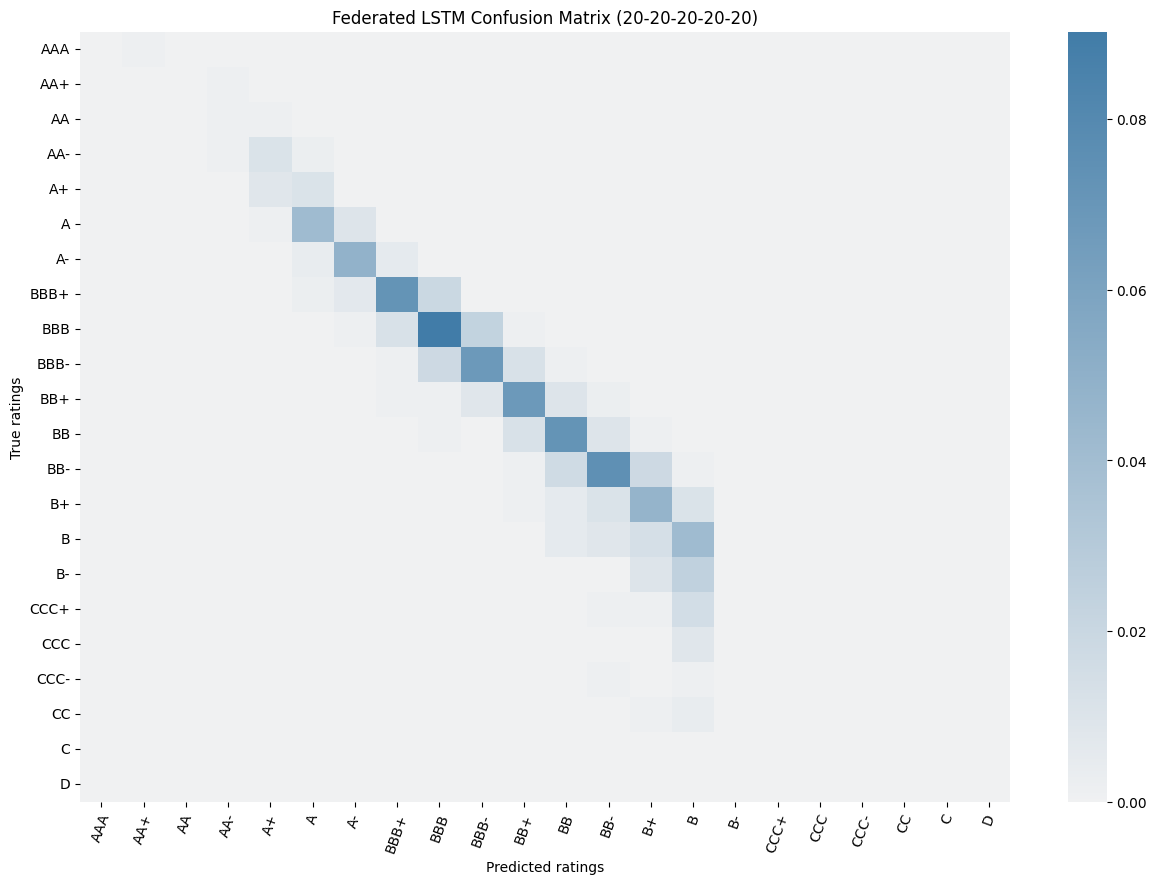

In [127]:
# 20-20-20-20-20
model_fl = run_lstm_simulation([0.2, 0.2, 0.2, 0.2, 0.2], 'split_20_20_20_20_20', 4, 4, 80)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (20-20-20-20-20)')

/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
INFO flwr 2023-06-15 16:35:32,947 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=80, round_timeout=None)


(launch_and_evaluate pid=25905) Client 1 evaluate, config {} [repeated 16x across cluster]
(launch_and_fit pid=25905) Epoch: 4, Loss: 2.8734774589538574


2023-06-15 16:35:37,090	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-06-15 16:35:37,685 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 8448158925.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0}
INFO flwr 2023-06-15 16:35:37,685 | server.py:86 | Initializing global parameters
INFO flwr 2023-06-15 16:35:37,685 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-06-15 16:35:38,514 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-06-15 16:35:38,514 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-06-15 16:35:38,515 | server.py:101 | FL starting
DEBUG flwr 2023-06-15 16:35:38,515 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=25923) Epoch: 1, Loss: 16.141586303710938
(launch_and_fit pid=25923) Epoch: 2, Loss: 17.905080795288086
(launch_and_fit pid=25923) Epoch: 3, Loss: 19.71624755859375
(launch_and_fit pid=25923) Epoch: 4, Loss: 10.121133804321289


DEBUG flwr 2023-06-15 16:35:39,378 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 16:35:39,391 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 16:35:39,417 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:39,509 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-06-15 16:35:39,509 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-06-15 16:35:39,510 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 5)


Saving round 1 aggregated_parameters...
(launch_and_evaluate pid=25923) Client 1 evaluate, config {}


DEBUG flwr 2023-06-15 16:35:40,562 | server.py:232 | fit_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:40,596 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:40,686 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:40,687 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 5)


Saving round 2 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:41,831 | server.py:232 | fit_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:41,864 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:41,950 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:41,950 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 5)


Saving round 3 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:43,087 | server.py:232 | fit_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:43,118 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:43,207 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:43,208 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 5)


Saving round 4 aggregated_parameters...
(launch_and_fit pid=25921) Epoch: 2, Loss: 18.43131446838379 [repeated 34x across cluster]


DEBUG flwr 2023-06-15 16:35:44,392 | server.py:232 | fit_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:44,425 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:44,513 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:44,513 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 5)


Saving round 5 aggregated_parameters...
(launch_and_evaluate pid=25921) Client 2 evaluate, config {} [repeated 9x across cluster]


DEBUG flwr 2023-06-15 16:35:45,766 | server.py:232 | fit_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:45,816 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:45,911 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:45,912 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 5)


Saving round 6 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:46,252 | server.py:232 | fit_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:46,286 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:46,374 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:46,374 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 5)


Saving round 7 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:46,617 | server.py:232 | fit_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:46,656 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:46,757 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:46,757 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 5)


Saving round 8 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:48,062 | server.py:232 | fit_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:48,133 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:48,228 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:48,228 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 5)


Saving round 9 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:48,475 | server.py:232 | fit_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:48,503 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:48,595 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:48,595 | server.py:218 | fit_round 11: strategy sampled 2 clients (out of 5)


Saving round 10 aggregated_parameters...
(launch_and_fit pid=25921) Epoch: 4, Loss: 7.326781749725342 [repeated 46x across cluster]


DEBUG flwr 2023-06-15 16:35:49,791 | server.py:232 | fit_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:49,816 | server.py:168 | evaluate_round 11: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:49,904 | server.py:182 | evaluate_round 11 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:49,904 | server.py:218 | fit_round 12: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=25921) Client 2 evaluate, config {} [repeated 10x across cluster]
Saving round 11 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:50,998 | server.py:232 | fit_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:51,027 | server.py:168 | evaluate_round 12: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:51,113 | server.py:182 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:51,113 | server.py:218 | fit_round 13: strategy sampled 2 clients (out of 5)


Saving round 12 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:52,263 | server.py:232 | fit_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:52,303 | server.py:168 | evaluate_round 13: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:52,431 | server.py:182 | evaluate_round 13 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:52,434 | server.py:218 | fit_round 14: strategy sampled 2 clients (out of 5)


Saving round 13 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:53,694 | server.py:232 | fit_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:53,721 | server.py:168 | evaluate_round 14: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:53,811 | server.py:182 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:53,812 | server.py:218 | fit_round 15: strategy sampled 2 clients (out of 5)


Saving round 14 aggregated_parameters...
(launch_and_fit pid=25923) Epoch: 2, Loss: 9.028212547302246 [repeated 30x across cluster]


DEBUG flwr 2023-06-15 16:35:54,881 | server.py:232 | fit_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:54,904 | server.py:168 | evaluate_round 15: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:54,989 | server.py:182 | evaluate_round 15 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:54,989 | server.py:218 | fit_round 16: strategy sampled 2 clients (out of 5)


Saving round 15 aggregated_parameters...
(launch_and_evaluate pid=25923) Client 2 evaluate, config {} [repeated 9x across cluster]


DEBUG flwr 2023-06-15 16:35:55,253 | server.py:232 | fit_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:55,283 | server.py:168 | evaluate_round 16: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:55,371 | server.py:182 | evaluate_round 16 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:55,371 | server.py:218 | fit_round 17: strategy sampled 2 clients (out of 5)


Saving round 16 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:56,550 | server.py:232 | fit_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:56,585 | server.py:168 | evaluate_round 17: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:56,687 | server.py:182 | evaluate_round 17 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:56,688 | server.py:218 | fit_round 18: strategy sampled 2 clients (out of 5)


Saving round 17 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:57,853 | server.py:232 | fit_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:57,890 | server.py:168 | evaluate_round 18: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:57,992 | server.py:182 | evaluate_round 18 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:57,993 | server.py:218 | fit_round 19: strategy sampled 2 clients (out of 5)


Saving round 18 aggregated_parameters...


DEBUG flwr 2023-06-15 16:35:59,109 | server.py:232 | fit_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:59,136 | server.py:168 | evaluate_round 19: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:35:59,287 | server.py:182 | evaluate_round 19 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:35:59,288 | server.py:218 | fit_round 20: strategy sampled 2 clients (out of 5)


Saving round 19 aggregated_parameters...
(launch_and_fit pid=25921) Epoch: 3, Loss: 2.842031955718994 [repeated 37x across cluster]
(launch_and_evaluate pid=25921) Client 3 evaluate, config {} [repeated 9x across cluster]


DEBUG flwr 2023-06-15 16:36:00,488 | server.py:232 | fit_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:00,511 | server.py:168 | evaluate_round 20: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:00,601 | server.py:182 | evaluate_round 20 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:00,602 | server.py:218 | fit_round 21: strategy sampled 2 clients (out of 5)


Saving round 20 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:01,755 | server.py:232 | fit_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:01,785 | server.py:168 | evaluate_round 21: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:01,920 | server.py:182 | evaluate_round 21 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:01,920 | server.py:218 | fit_round 22: strategy sampled 2 clients (out of 5)


Saving round 21 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:03,073 | server.py:232 | fit_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:03,113 | server.py:168 | evaluate_round 22: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:03,225 | server.py:182 | evaluate_round 22 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:03,225 | server.py:218 | fit_round 23: strategy sampled 2 clients (out of 5)


Saving round 22 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:03,481 | server.py:232 | fit_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:03,507 | server.py:168 | evaluate_round 23: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:03,595 | server.py:182 | evaluate_round 23 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:03,595 | server.py:218 | fit_round 24: strategy sampled 2 clients (out of 5)


Saving round 23 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:03,849 | server.py:232 | fit_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:03,873 | server.py:168 | evaluate_round 24: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:03,963 | server.py:182 | evaluate_round 24 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:03,963 | server.py:218 | fit_round 25: strategy sampled 2 clients (out of 5)


Saving round 24 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:04,257 | server.py:232 | fit_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:04,279 | server.py:168 | evaluate_round 25: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:04,365 | server.py:182 | evaluate_round 25 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:04,366 | server.py:218 | fit_round 26: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=25923) Epoch: 3, Loss: 2.070406198501587 [repeated 45x across cluster]
Saving round 25 aggregated_parameters...
(launch_and_evaluate pid=25921) Client 0 evaluate, config {} [repeated 12x across cluster]


DEBUG flwr 2023-06-15 16:36:05,608 | server.py:232 | fit_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:05,640 | server.py:168 | evaluate_round 26: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:05,737 | server.py:182 | evaluate_round 26 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:05,737 | server.py:218 | fit_round 27: strategy sampled 2 clients (out of 5)


Saving round 26 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:06,931 | server.py:232 | fit_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:06,972 | server.py:168 | evaluate_round 27: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:07,072 | server.py:182 | evaluate_round 27 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:07,073 | server.py:218 | fit_round 28: strategy sampled 2 clients (out of 5)


Saving round 27 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:07,360 | server.py:232 | fit_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:07,385 | server.py:168 | evaluate_round 28: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:07,477 | server.py:182 | evaluate_round 28 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:07,478 | server.py:218 | fit_round 29: strategy sampled 2 clients (out of 5)


Saving round 28 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:07,762 | server.py:232 | fit_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:07,790 | server.py:168 | evaluate_round 29: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:07,879 | server.py:182 | evaluate_round 29 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:07,880 | server.py:218 | fit_round 30: strategy sampled 2 clients (out of 5)


Saving round 29 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:09,158 | server.py:232 | fit_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:09,186 | server.py:168 | evaluate_round 30: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:09,275 | server.py:182 | evaluate_round 30 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:09,275 | server.py:218 | fit_round 31: strategy sampled 2 clients (out of 5)


Saving round 30 aggregated_parameters...
(launch_and_fit pid=25923) Epoch: 4, Loss: 1.4602560997009277 [repeated 44x across cluster]


DEBUG flwr 2023-06-15 16:36:09,550 | server.py:232 | fit_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:09,580 | server.py:168 | evaluate_round 31: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:09,668 | server.py:182 | evaluate_round 31 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:09,669 | server.py:218 | fit_round 32: strategy sampled 2 clients (out of 5)


Saving round 31 aggregated_parameters...
(launch_and_evaluate pid=25921) Client 2 evaluate, config {} [repeated 12x across cluster]


DEBUG flwr 2023-06-15 16:36:10,822 | server.py:232 | fit_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:10,851 | server.py:168 | evaluate_round 32: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:10,938 | server.py:182 | evaluate_round 32 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:10,938 | server.py:218 | fit_round 33: strategy sampled 2 clients (out of 5)


Saving round 32 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:12,045 | server.py:232 | fit_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:12,080 | server.py:168 | evaluate_round 33: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:12,216 | server.py:182 | evaluate_round 33 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:12,226 | server.py:218 | fit_round 34: strategy sampled 2 clients (out of 5)


Saving round 33 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:12,531 | server.py:232 | fit_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:12,558 | server.py:168 | evaluate_round 34: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:12,649 | server.py:182 | evaluate_round 34 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:12,649 | server.py:218 | fit_round 35: strategy sampled 2 clients (out of 5)


Saving round 34 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:13,742 | server.py:232 | fit_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:13,769 | server.py:168 | evaluate_round 35: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:13,862 | server.py:182 | evaluate_round 35 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:13,863 | server.py:218 | fit_round 36: strategy sampled 2 clients (out of 5)


Saving round 35 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:14,127 | server.py:232 | fit_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:14,152 | server.py:168 | evaluate_round 36: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:14,248 | server.py:182 | evaluate_round 36 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:14,249 | server.py:218 | fit_round 37: strategy sampled 2 clients (out of 5)


Saving round 36 aggregated_parameters...
(launch_and_fit pid=25921) Epoch: 2, Loss: 1.3689513206481934 [repeated 50x across cluster]
(launch_and_evaluate pid=25921) Client 0 evaluate, config {} [repeated 10x across cluster]


DEBUG flwr 2023-06-15 16:36:15,446 | server.py:232 | fit_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:15,474 | server.py:168 | evaluate_round 37: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:15,562 | server.py:182 | evaluate_round 37 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:15,562 | server.py:218 | fit_round 38: strategy sampled 2 clients (out of 5)


Saving round 37 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:15,840 | server.py:232 | fit_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:15,867 | server.py:168 | evaluate_round 38: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:15,955 | server.py:182 | evaluate_round 38 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:15,955 | server.py:218 | fit_round 39: strategy sampled 2 clients (out of 5)


Saving round 38 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:17,098 | server.py:232 | fit_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:17,147 | server.py:168 | evaluate_round 39: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:17,279 | server.py:182 | evaluate_round 39 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:17,280 | server.py:218 | fit_round 40: strategy sampled 2 clients (out of 5)


Saving round 39 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:18,467 | server.py:232 | fit_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:18,565 | server.py:168 | evaluate_round 40: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:18,665 | server.py:182 | evaluate_round 40 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:18,665 | server.py:218 | fit_round 41: strategy sampled 2 clients (out of 5)


Saving round 40 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:18,943 | server.py:232 | fit_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:18,971 | server.py:168 | evaluate_round 41: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:19,058 | server.py:182 | evaluate_round 41 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:19,059 | server.py:218 | fit_round 42: strategy sampled 2 clients (out of 5)


Saving round 41 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:19,302 | server.py:232 | fit_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:19,325 | server.py:168 | evaluate_round 42: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:19,422 | server.py:182 | evaluate_round 42 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:19,422 | server.py:218 | fit_round 43: strategy sampled 2 clients (out of 5)


Saving round 42 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:19,695 | server.py:232 | fit_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:19,723 | server.py:168 | evaluate_round 43: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=25923) Epoch: 2, Loss: 0.6715259552001953 [repeated 48x across cluster]
Saving round 43 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:19,818 | server.py:182 | evaluate_round 43 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:19,818 | server.py:218 | fit_round 44: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:20,098 | server.py:232 | fit_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:20,125 | server.py:168 | evaluate_round 44: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:20,218 | server.py:182 | evaluate_round 44 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:20,220 | server.py:218 | fit_round 45: strategy sampled 2 clients (out of 5)


Saving round 44 aggregated_parameters...
(launch_and_evaluate pid=25921) Client 4 evaluate, config {} [repeated 16x across cluster]


DEBUG flwr 2023-06-15 16:36:20,484 | server.py:232 | fit_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:20,516 | server.py:168 | evaluate_round 45: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:20,605 | server.py:182 | evaluate_round 45 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:20,605 | server.py:218 | fit_round 46: strategy sampled 2 clients (out of 5)


Saving round 45 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:21,772 | server.py:232 | fit_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:21,832 | server.py:168 | evaluate_round 46: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:21,934 | server.py:182 | evaluate_round 46 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:21,934 | server.py:218 | fit_round 47: strategy sampled 2 clients (out of 5)


Saving round 46 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:22,175 | server.py:232 | fit_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:22,197 | server.py:168 | evaluate_round 47: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:22,282 | server.py:182 | evaluate_round 47 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:22,282 | server.py:218 | fit_round 48: strategy sampled 2 clients (out of 5)


Saving round 47 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:23,418 | server.py:232 | fit_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:23,443 | server.py:168 | evaluate_round 48: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:23,547 | server.py:182 | evaluate_round 48 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:23,549 | server.py:218 | fit_round 49: strategy sampled 2 clients (out of 5)


Saving round 48 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:23,819 | server.py:232 | fit_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:23,862 | server.py:168 | evaluate_round 49: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:23,950 | server.py:182 | evaluate_round 49 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:23,950 | server.py:218 | fit_round 50: strategy sampled 2 clients (out of 5)


Saving round 49 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:24,198 | server.py:232 | fit_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:24,221 | server.py:168 | evaluate_round 50: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:24,310 | server.py:182 | evaluate_round 50 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:24,310 | server.py:218 | fit_round 51: strategy sampled 2 clients (out of 5)


Saving round 50 aggregated_parameters...
(launch_and_fit pid=25921) Epoch: 4, Loss: 1.0461771488189697 [repeated 66x across cluster]


DEBUG flwr 2023-06-15 16:36:25,463 | server.py:232 | fit_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:25,489 | server.py:168 | evaluate_round 51: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:25,581 | server.py:182 | evaluate_round 51 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:25,581 | server.py:218 | fit_round 52: strategy sampled 2 clients (out of 5)


Saving round 51 aggregated_parameters...
(launch_and_evaluate pid=25921) Client 4 evaluate, config {} [repeated 12x across cluster]


DEBUG flwr 2023-06-15 16:36:26,716 | server.py:232 | fit_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:26,749 | server.py:168 | evaluate_round 52: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:26,884 | server.py:182 | evaluate_round 52 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:26,885 | server.py:218 | fit_round 53: strategy sampled 2 clients (out of 5)


Saving round 52 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:27,133 | server.py:232 | fit_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:27,159 | server.py:168 | evaluate_round 53: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:27,247 | server.py:182 | evaluate_round 53 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:27,248 | server.py:218 | fit_round 54: strategy sampled 2 clients (out of 5)


Saving round 53 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:27,525 | server.py:232 | fit_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:27,557 | server.py:168 | evaluate_round 54: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:27,656 | server.py:182 | evaluate_round 54 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:27,656 | server.py:218 | fit_round 55: strategy sampled 2 clients (out of 5)


Saving round 54 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:28,772 | server.py:232 | fit_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:28,802 | server.py:168 | evaluate_round 55: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:28,923 | server.py:182 | evaluate_round 55 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:28,924 | server.py:218 | fit_round 56: strategy sampled 2 clients (out of 5)


Saving round 55 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:29,202 | server.py:232 | fit_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:29,231 | server.py:168 | evaluate_round 56: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:29,330 | server.py:182 | evaluate_round 56 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:29,331 | server.py:218 | fit_round 57: strategy sampled 2 clients (out of 5)


Saving round 56 aggregated_parameters...
(launch_and_fit pid=25923) Epoch: 3, Loss: 0.41510313749313354 [repeated 47x across cluster]


DEBUG flwr 2023-06-15 16:36:30,441 | server.py:232 | fit_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:30,469 | server.py:168 | evaluate_round 57: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:30,559 | server.py:182 | evaluate_round 57 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:30,559 | server.py:218 | fit_round 58: strategy sampled 2 clients (out of 5)


Saving round 57 aggregated_parameters...
(launch_and_evaluate pid=25923) Client 3 evaluate, config {} [repeated 13x across cluster]


DEBUG flwr 2023-06-15 16:36:30,809 | server.py:232 | fit_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:30,836 | server.py:168 | evaluate_round 58: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:30,928 | server.py:182 | evaluate_round 58 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:30,929 | server.py:218 | fit_round 59: strategy sampled 2 clients (out of 5)


Saving round 58 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:32,069 | server.py:232 | fit_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:32,094 | server.py:168 | evaluate_round 59: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:32,184 | server.py:182 | evaluate_round 59 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:32,184 | server.py:218 | fit_round 60: strategy sampled 2 clients (out of 5)


Saving round 59 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:32,458 | server.py:232 | fit_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:32,483 | server.py:168 | evaluate_round 60: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:32,579 | server.py:182 | evaluate_round 60 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:32,579 | server.py:218 | fit_round 61: strategy sampled 2 clients (out of 5)


Saving round 60 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:33,708 | server.py:232 | fit_round 61 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:33,742 | server.py:168 | evaluate_round 61: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:33,876 | server.py:182 | evaluate_round 61 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:33,876 | server.py:218 | fit_round 62: strategy sampled 2 clients (out of 5)


Saving round 61 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:34,164 | server.py:232 | fit_round 62 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:34,194 | server.py:168 | evaluate_round 62: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:34,287 | server.py:182 | evaluate_round 62 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:34,288 | server.py:218 | fit_round 63: strategy sampled 2 clients (out of 5)


Saving round 62 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:34,571 | server.py:232 | fit_round 63 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:34,601 | server.py:168 | evaluate_round 63: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:34,687 | server.py:182 | evaluate_round 63 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:34,688 | server.py:218 | fit_round 64: strategy sampled 2 clients (out of 5)


Saving round 63 aggregated_parameters...
(launch_and_fit pid=25923) Epoch: 4, Loss: 0.7593023777008057 [repeated 53x across cluster]


DEBUG flwr 2023-06-15 16:36:34,938 | server.py:232 | fit_round 64 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:34,968 | server.py:168 | evaluate_round 64: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:35,062 | server.py:182 | evaluate_round 64 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:35,062 | server.py:218 | fit_round 65: strategy sampled 2 clients (out of 5)


Saving round 64 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:35,340 | server.py:232 | fit_round 65 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:35,372 | server.py:168 | evaluate_round 65: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:35,459 | server.py:182 | evaluate_round 65 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:35,460 | server.py:218 | fit_round 66: strategy sampled 2 clients (out of 5)


Saving round 65 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:35,749 | server.py:232 | fit_round 66 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:35,777 | server.py:168 | evaluate_round 66: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=25921) Client 3 evaluate, config {} [repeated 17x across cluster]
Saving round 66 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:35,867 | server.py:182 | evaluate_round 66 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:35,868 | server.py:218 | fit_round 67: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:37,122 | server.py:232 | fit_round 67 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:37,153 | server.py:168 | evaluate_round 67: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:37,242 | server.py:182 | evaluate_round 67 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:37,242 | server.py:218 | fit_round 68: strategy sampled 2 clients (out of 5)


Saving round 67 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:38,432 | server.py:232 | fit_round 68 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:38,474 | server.py:168 | evaluate_round 68: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:38,574 | server.py:182 | evaluate_round 68 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:38,574 | server.py:218 | fit_round 69: strategy sampled 2 clients (out of 5)


Saving round 68 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:39,778 | server.py:232 | fit_round 69 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:39,824 | server.py:168 | evaluate_round 69: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:39,927 | server.py:182 | evaluate_round 69 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:39,927 | server.py:218 | fit_round 70: strategy sampled 2 clients (out of 5)


(launch_and_fit pid=25921) Epoch: 4, Loss: 0.7739664316177368 [repeated 48x across cluster]
Saving round 69 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:40,313 | server.py:232 | fit_round 70 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:40,355 | server.py:168 | evaluate_round 70: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:40,452 | server.py:182 | evaluate_round 70 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:40,453 | server.py:218 | fit_round 71: strategy sampled 2 clients (out of 5)


Saving round 70 aggregated_parameters...
(launch_and_evaluate pid=25921) Client 0 evaluate, config {} [repeated 10x across cluster]


DEBUG flwr 2023-06-15 16:36:41,546 | server.py:232 | fit_round 71 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:41,588 | server.py:168 | evaluate_round 71: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:41,676 | server.py:182 | evaluate_round 71 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:41,676 | server.py:218 | fit_round 72: strategy sampled 2 clients (out of 5)


Saving round 71 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:42,736 | server.py:232 | fit_round 72 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:42,771 | server.py:168 | evaluate_round 72: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:42,868 | server.py:182 | evaluate_round 72 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:42,869 | server.py:218 | fit_round 73: strategy sampled 2 clients (out of 5)


Saving round 72 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:43,117 | server.py:232 | fit_round 73 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:43,151 | server.py:168 | evaluate_round 73: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:43,238 | server.py:182 | evaluate_round 73 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:43,239 | server.py:218 | fit_round 74: strategy sampled 2 clients (out of 5)


Saving round 73 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:44,354 | server.py:232 | fit_round 74 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:44,391 | server.py:168 | evaluate_round 74: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:44,483 | server.py:182 | evaluate_round 74 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:44,484 | server.py:218 | fit_round 75: strategy sampled 2 clients (out of 5)


Saving round 74 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:44,739 | server.py:232 | fit_round 75 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:44,772 | server.py:168 | evaluate_round 75: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:44,856 | server.py:182 | evaluate_round 75 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:44,857 | server.py:218 | fit_round 76: strategy sampled 2 clients (out of 5)


Saving round 75 aggregated_parameters...
(launch_and_fit pid=25921) Epoch: 4, Loss: 0.42972999811172485 [repeated 48x across cluster]


DEBUG flwr 2023-06-15 16:36:45,100 | server.py:232 | fit_round 76 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:45,135 | server.py:168 | evaluate_round 76: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:45,226 | server.py:182 | evaluate_round 76 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:45,229 | server.py:218 | fit_round 77: strategy sampled 2 clients (out of 5)


Saving round 76 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:45,488 | server.py:232 | fit_round 77 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:45,521 | server.py:168 | evaluate_round 77: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:45,616 | server.py:182 | evaluate_round 77 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:45,616 | server.py:218 | fit_round 78: strategy sampled 2 clients (out of 5)


Saving round 77 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:45,879 | server.py:232 | fit_round 78 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:45,915 | server.py:168 | evaluate_round 78: strategy sampled 2 clients (out of 5)


(launch_and_evaluate pid=25921) Client 3 evaluate, config {} [repeated 14x across cluster]
Saving round 78 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:46,000 | server.py:182 | evaluate_round 78 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:46,001 | server.py:218 | fit_round 79: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:46,264 | server.py:232 | fit_round 79 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:46,297 | server.py:168 | evaluate_round 79: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:46,384 | server.py:182 | evaluate_round 79 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:46,385 | server.py:218 | fit_round 80: strategy sampled 2 clients (out of 5)


Saving round 79 aggregated_parameters...


DEBUG flwr 2023-06-15 16:36:46,651 | server.py:232 | fit_round 80 received 2 results and 0 failures
DEBUG flwr 2023-06-15 16:36:46,687 | server.py:168 | evaluate_round 80: strategy sampled 2 clients (out of 5)
DEBUG flwr 2023-06-15 16:36:46,774 | server.py:182 | evaluate_round 80 received 2 results and 0 failures
INFO flwr 2023-06-15 16:36:46,774 | server.py:147 | FL finished in 68.25881133391522
INFO flwr 2023-06-15 16:36:46,777 | app.py:218 | app_fit: losses_distributed [(1, 127.17337031900139), (2, 109.10263522884883), (3, 106.72676837725382), (4, 106.65325936199723), (5, 106.59639389736478), (6, 106.58113730929264), (7, 106.58113730929264), (8, 106.58113730929264), (9, 106.58113730929264), (10, 106.58113730929264), (11, 106.58113730929264), (12, 106.58113730929264), (13, 106.58113730929264), (14, 106.58113730929264), (15, 106.58113730929264), (16, 106.58113730929264), (17, 106.58113730929264), (18, 70.03190013869626), (19, 3.6712898751733705), (20, 2.002773925104022), (21, 1.556171

Saving round 80 aggregated_parameters...
Loading pre-trained model from:  lstm_model_checkpoints/split_60_10_10_10_10/model_round_80.pth
1.073509015256588
0.002434260805570494
0.9666789906645715
0.967741935483871


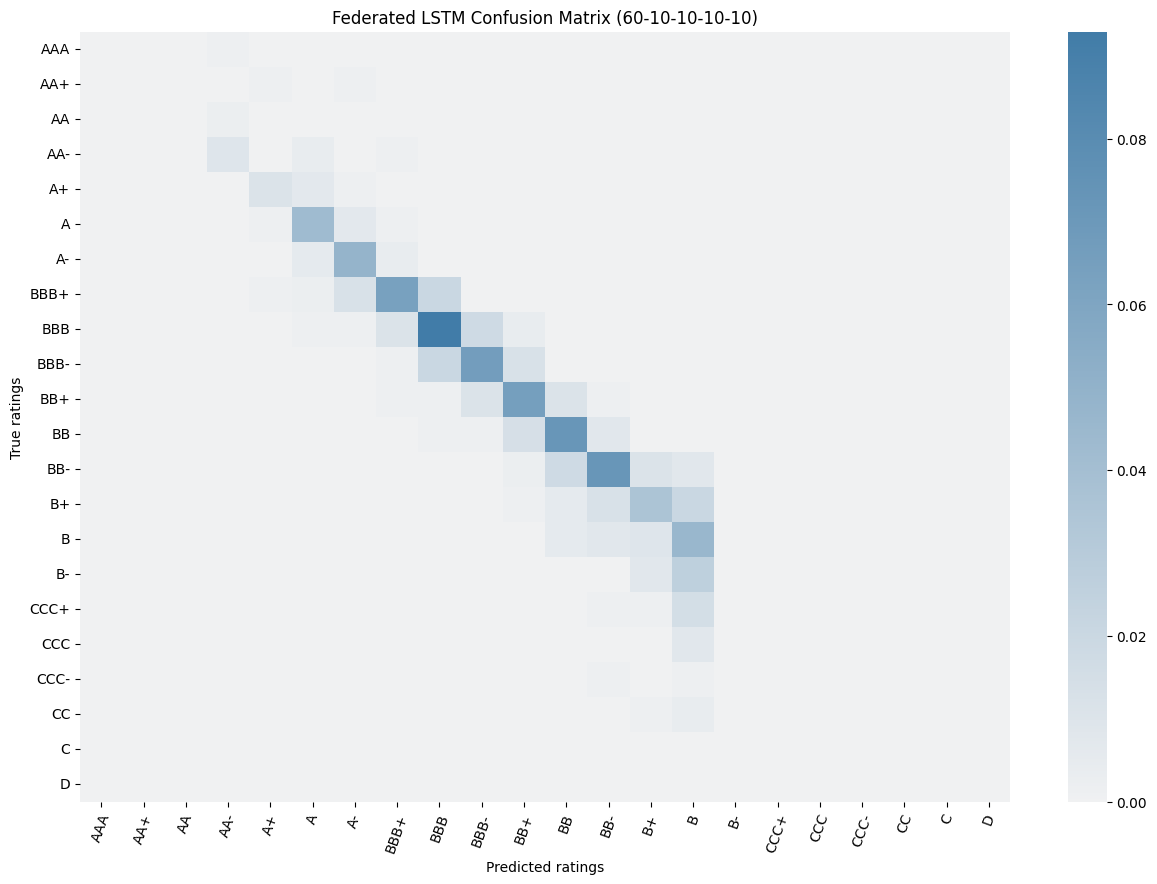

In [128]:
# 60-10-10-10-10
model_fl = run_lstm_simulation([0.6, 0.1, 0.1, 0.1, 0.1], 'split_60_10_10_10_10', 4, 4, 80)
mse, mse_norm, auc, f1 = test(model_fl, X_test, y_test)
print(mse)
print(mse_norm)
print(auc)
print(f1)
y_pred = prediction2label(model_fl(X_test))
confusion(y_pred, y_test, 'Federated LSTM Confusion Matrix (60-10-10-10-10)')

Text(0.5, 1.0, 'Num epoch: 4')

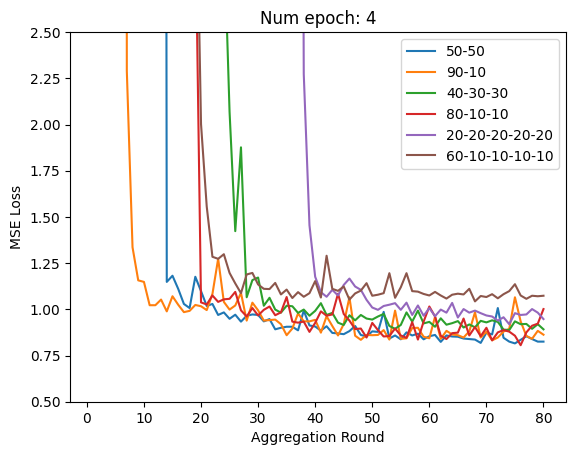

In [178]:
# Visualise loss convergence 4 epoch
ax = plt.gca()
ax.set_ylim([0.5, 2.5])
plot_loss([[(1, 127.17337031900139), (2, 127.17337031900139), (3, 25.187239944521497), (4, 25.03606102635229), (5, 24.9500693481276), (6, 24.8626907073509), (7, 24.814147018030514), (8, 24.78640776699029), (9, 24.776699029126213), (10, 24.787794729542302), (11, 24.76976421636616), (12, 24.742024965325935), (13, 24.730929264909847), (14, 1.1484049930651872), (15, 1.1816920943134535), (16, 1.1109570041608876), (17, 1.029126213592233), (18, 1.0069348127600555), (19, 1.176144244105409), (20, 1.0984743411927878), (21, 1.0180305131761442), (22, 1.029126213592233), (23, 0.9694868238557559), (24, 0.9833564493758669), (25, 0.9486823855755895), (26, 0.970873786407767), (27, 0.9334257975034674), (28, 0.9653259361997226), (29, 0.9722607489597781), (30, 0.9694868238557559), (31, 0.9348127600554785), (32, 0.9472954230235784), (33, 0.8918169209431346), (34, 0.9001386962552012), (35, 0.9056865464632455), (36, 0.9056865464632455), (37, 0.8862690707350902), (38, 0.9930651872399445), (39, 0.912621359223301), (40, 0.9070735090152566), (41, 0.8848821081830791), (42, 0.9084604715672677), (43, 0.8723994452149791), (44, 0.869625520110957), (45, 0.8654646324549237), (46, 0.8821081830790569), (47, 0.9098474341192788), (48, 0.8613037447988904), (49, 0.8529819694868238), (50, 0.8807212205270458), (51, 0.8779472954230236), (52, 0.986130374479889), (53, 0.841886269070735), (54, 0.8585298196948682), (55, 0.8377253814147018), (56, 0.8751733703190014), (57, 0.8585298196948682), (58, 0.8682385575589459), (59, 0.8377253814147018), (60, 0.8543689320388349), (61, 0.8613037447988904), (62, 0.8238557558945908), (63, 0.8585298196948682), (64, 0.8529819694868238), (65, 0.8515950069348127), (66, 0.841886269070735), (67, 0.8391123439667129), (68, 0.8363384188626907), (69, 0.8183079056865464), (70, 0.8737864077669902), (71, 0.8640776699029126), (72, 1.0069348127600555), (73, 0.8460471567267683), (74, 0.8252427184466019), (75, 0.8155339805825242), (76, 0.8349514563106796), (77, 0.8543689320388349), (78, 0.8391123439667129), (79, 0.8252427184466019), (80, 0.8252427184466019)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 127.17337031900139), (5, 127.17337031900139), (6, 74.23578363384189), (7, 2.289875173370319), (8, 1.3356449375866852), (9, 1.1567267683772537), (10, 1.1484049930651872), (11, 1.0221914008321775), (12, 1.0221914008321775), (13, 1.0527045769764216), (14, 0.9889042995839112), (15, 1.0707350901525658), (16, 1.0249653259361997), (17, 0.984743411927878), (18, 0.9916782246879334), (19, 1.0235783633841886), (20, 1.0166435506241331), (21, 0.9958391123439667), (22, 1.0832177531206657), (23, 1.273231622746186), (24, 1.0402219140083218), (25, 0.9986130374479889), (26, 1.0208044382801664), (27, 1.08876560332871), (28, 0.9389736477115118), (29, 1.0360610263522885), (30, 0.9944521497919556), (31, 0.9389736477115118), (32, 0.941747572815534), (33, 0.9445214979195562), (34, 0.9195561719833565), (35, 0.8599167822468793), (36, 0.8959778085991679), (37, 0.9778085991678225), (38, 0.9348127600554785), (39, 0.9348127600554785), (40, 0.9431345353675451), (41, 0.8737864077669902), (42, 0.9625520110957004), (43, 0.9098474341192788), (44, 0.8585298196948682), (45, 0.9195561719833565), (46, 1.0651872399445215), (47, 0.8571428571428571), (48, 0.8349514563106796), (49, 0.8613037447988904), (50, 0.8599167822468793), (51, 0.8613037447988904), (52, 0.8876560332871013), (53, 0.8363384188626907), (54, 0.9930651872399445), (55, 0.840499306518724), (56, 0.8432732316227461), (57, 0.8987517337031901), (58, 0.9001386962552012), (59, 0.8515950069348127), (60, 0.8432732316227461), (61, 0.9597780859916782), (62, 0.840499306518724), (63, 0.883495145631068), (64, 0.8640776699029126), (65, 0.8599167822468793), (66, 0.8474341192787794), (67, 0.8807212205270458), (68, 0.9833564493758669), (69, 0.8474341192787794), (70, 0.8793342579750347), (71, 0.8321775312066574), (72, 0.8474341192787794), (73, 0.8793342579750347), (74, 0.8945908460471568), (75, 1.0651872399445215), (76, 0.9348127600554785), (77, 0.855755894590846), (78, 0.840499306518724), (79, 0.883495145631068), (80, 0.8626907073509015)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 107.500693481276), (4, 106.8987517337032), (5, 106.85298196948682), (6, 106.73647711511789), (7, 106.68238557558946), (8, 106.6629680998613), (9, 106.63384188626907), (10, 106.64355062413316), (11, 106.61719833564494), (12, 106.61026352288488), (13, 106.61026352288488), (14, 106.62690707350902), (15, 106.63384188626907), (16, 106.62690707350902), (17, 106.58668515950069), (18, 106.59361997226075), (19, 106.59361997226075), (20, 106.59361997226075), (21, 106.58252427184466), (22, 19.76976421636616), (23, 4.638002773925104), (24, 3.059639389736477), (25, 2.0693481276005548), (26, 1.4230235783633842), (27, 1.8765603328710125), (28, 1.0651872399445215), (29, 1.1581137309292648), (30, 1.1719833564493758), (31, 1.0194174757281553), (32, 1.0624133148404993), (33, 0.9986130374479889), (34, 0.9819694868238558), (35, 1.0194174757281553), (36, 1.0166435506241331), (37, 0.9805825242718447), (38, 0.9986130374479889), (39, 0.9653259361997226), (40, 0.9916782246879334), (41, 1.0332871012482663), (42, 0.9694868238557559), (43, 0.9805825242718447), (44, 0.9278779472954231), (45, 0.9153952843273232), (46, 0.9680998613037448), (47, 0.9403606102635229), (48, 0.9694868238557559), (49, 0.9500693481276006), (50, 0.9445214979195562), (51, 0.9611650485436893), (52, 0.9750346740638003), (53, 0.9098474341192788), (54, 0.8945908460471568), (55, 0.9153952843273232), (56, 0.9833564493758669), (57, 0.9334257975034674), (58, 0.9930651872399445), (59, 0.9237170596393898), (60, 0.9320388349514563), (61, 0.9056865464632455), (62, 0.9514563106796117), (63, 0.9167822468793343), (64, 0.9251040221914009), (65, 0.9361997226074896), (66, 0.9015256588072122), (67, 0.9181692094313454), (68, 0.9029126213592233), (69, 0.9375866851595007), (70, 0.9292649098474342), (71, 0.9403606102635229), (72, 0.9320388349514563), (73, 0.8904299583911235), (74, 0.8876560332871013), (75, 0.9348127600554785), (76, 0.9195561719833565), (77, 0.9209431345353676), (78, 0.8945908460471568), (79, 0.9195561719833565), (80, 0.8918169209431346)]
, [(1, 20.715672676837727), (2, 10.30235783633842), (3, 10.095700416088766), (4, 9.027739251040222), (5, 8.764216366158113), (6, 8.72122052704577), (7, 8.295423023578364), (8, 8.256588072122053), (9, 8.25242718446602), (10, 8.27877947295423), (11, 8.185852981969488), (12, 8.17753120665742), (13, 8.20388349514563), (14, 8.167822468793343), (15, 8.156726768377254), (16, 8.169209431345354), (17, 7.058252427184466), (18, 3.2288488210818307), (19, 3.163661581137309), (20, 1.0374479889042996), (21, 1.0263522884882108), (22, 1.0748959778085991), (23, 1.0402219140083218), (24, 1.0540915395284327), (25, 1.056865464632455), (26, 1.0943134535367545), (27, 0.9944521497919556), (28, 0.9611650485436893), (29, 1.0069348127600555), (30, 0.9667128987517337), (31, 0.9972260748959778), (32, 1.015256588072122), (33, 0.9680998613037448), (34, 0.9833564493758669), (35, 1.0665742024965326), (36, 0.9334257975034674), (37, 0.9278779472954231), (38, 0.9334257975034674), (39, 0.8779472954230236), (40, 0.926490984743412), (41, 0.9889042995839112), (42, 0.9653259361997226), (43, 0.9722607489597781), (44, 1.0846047156726768), (45, 0.9750346740638003), (46, 0.9389736477115118), (47, 0.8932038834951457), (48, 0.8959778085991679), (49, 0.8474341192787794), (50, 0.926490984743412), (51, 0.8876560332871013), (52, 0.8529819694868238), (53, 0.855755894590846), (54, 0.8959778085991679), (55, 0.8585298196948682), (56, 0.8460471567267683), (57, 0.9306518723994452), (58, 0.8363384188626907), (59, 0.9334257975034674), (60, 1.015256588072122), (61, 0.9611650485436893), (62, 0.8571428571428571), (63, 0.8391123439667129), (64, 0.871012482662968), (65, 0.8737864077669902), (66, 0.9500693481276006), (67, 0.8585298196948682), (68, 0.9042995839112344), (69, 0.8543689320388349), (70, 0.9001386962552012), (71, 0.8321775312066574), (72, 0.8751733703190014), (73, 0.8876560332871013), (74, 0.8793342579750347), (75, 0.8571428571428571), (76, 0.8058252427184466), (77, 0.8751733703190014), (78, 0.9112343966712899), (79, 0.9223300970873787), (80, 1.001386962552011)]
, [(1, 127.17337031900139), (2, 127.17337031900139), (3, 127.17337031900139), (4, 66.52427184466019), (5, 58.17891816920943), (6, 57.48127600554785), (7, 57.23439667128987), (8, 57.12621359223301), (9, 57.07073509015257), (10, 57.01664355062413), (11, 56.92787794729542), (12, 56.905686546463244), (13, 56.90984743411928), (14, 56.86962552011096), (15, 56.8377253814147), (16, 56.81553398058252), (17, 56.81553398058252), (18, 56.79611650485437), (19, 56.794729542302356), (20, 56.793342579750345), (21, 56.78918169209431), (22, 56.794729542302356), (23, 56.794729542302356), (24, 56.794729542302356), (25, 56.794729542302356), (26, 56.794729542302356), (27, 56.794729542302356), (28, 56.793342579750345), (29, 56.794729542302356), (30, 56.794729542302356), (31, 56.793342579750345), (32, 56.793342579750345), (33, 56.78918169209431), (34, 56.78918169209431), (35, 56.793342579750345), (36, 56.78918169209431), (37, 10.660194174757281), (38, 2.2732316227461857), (39, 1.4549237170596394), (40, 1.176144244105409), (41, 1.0929264909847434), (42, 1.0679611650485437), (43, 1.1054091539528432), (44, 1.0748959778085991), (45, 1.131761442441054), (46, 1.1664355062413314), (47, 1.1234396671289875), (48, 1.1054091539528432), (49, 1.0513176144244105), (50, 1.0097087378640777), (51, 0.9972260748959778), (52, 1.0180305131761442), (53, 1.0249653259361997), (54, 1.0332871012482663), (55, 0.9972260748959778), (56, 1.0360610263522885), (57, 0.9694868238557559), (58, 1.0208044382801664), (59, 0.9653259361997226), (60, 1.0069348127600555), (61, 0.9625520110957004), (62, 0.9986130374479889), (63, 0.9819694868238558), (64, 1.0346740638002774), (65, 0.955617198335645), (66, 1.001386962552011), (67, 0.9819694868238558), (68, 0.9930651872399445), (69, 0.9791955617198336), (70, 0.9667128987517337), (71, 0.9611650485436893), (72, 0.9389736477115118), (73, 0.957004160887656), (74, 0.9195561719833565), (75, 0.9791955617198336), (76, 0.9694868238557559), (77, 0.9722607489597781), (78, 1.001386962552011), (79, 0.9819694868238558), (80, 0.9472954230235784)]
, [(1, 127.17337031900139), (2, 109.10263522884883), (3, 106.72676837725382), (4, 106.65325936199723), (5, 106.59639389736478), (6, 106.58113730929264), (7, 106.58113730929264), (8, 106.58113730929264), (9, 106.58113730929264), (10, 106.58113730929264), (11, 106.58113730929264), (12, 106.58113730929264), (13, 106.58113730929264), (14, 106.58113730929264), (15, 106.58113730929264), (16, 106.58113730929264), (17, 106.58113730929264), (18, 70.03190013869626), (19, 3.6712898751733705), (20, 2.002773925104022), (21, 1.5561719833564494), (22, 1.2843273231622747), (23, 1.273231622746186), (24, 1.2981969486823857), (25, 1.1969486823855755), (26, 1.1400832177531206), (27, 1.087378640776699), (28, 1.188626907073509), (29, 1.1969486823855755), (30, 1.1345353675450762), (31, 1.1109570041608876), (32, 1.1095700416088765), (33, 1.1428571428571428), (34, 1.0804438280166435), (35, 1.1067961165048543), (36, 1.0610263522884882), (37, 1.0929264909847434), (38, 1.0679611650485437), (39, 1.087378640776699), (40, 1.1525658807212205), (41, 1.0638002773925104), (42, 1.289875173370319), (43, 1.1109570041608876), (44, 1.0998613037447988), (45, 1.1234396671289875), (46, 1.0527045769764216), (47, 1.085991678224688), (48, 1.10124826629681), (49, 1.1414701803051317), (50, 1.073509015256588), (51, 1.0790568654646324), (52, 1.087378640776699), (53, 1.1955617198335644), (54, 1.0624133148404993), (55, 1.1192787794729542), (56, 1.1955617198335644), (57, 1.0984743411927878), (58, 1.0957004160887656), (59, 1.0832177531206657), (60, 1.0748959778085991), (61, 1.0943134535367545), (62, 1.0748959778085991), (63, 1.058252427184466), (64, 1.0790568654646324), (65, 1.0846047156726768), (66, 1.0804438280166435), (67, 1.1109570041608876), (68, 1.042995839112344), (69, 1.072122052704577), (70, 1.0665742024965326), (71, 1.0818307905686546), (72, 1.059639389736477), (73, 1.0818307905686546), (74, 1.0984743411927878), (75, 1.1359223300970873), (76, 1.0748959778085991), (77, 1.056865464632455), (78, 1.073509015256588), (79, 1.0707350901525658), (80, 1.073509015256588)]]
, start=0, title='Num epoch: 4')

Text(0.5, 1.0, 'MSE Loss distribution across workers per Number epoch')

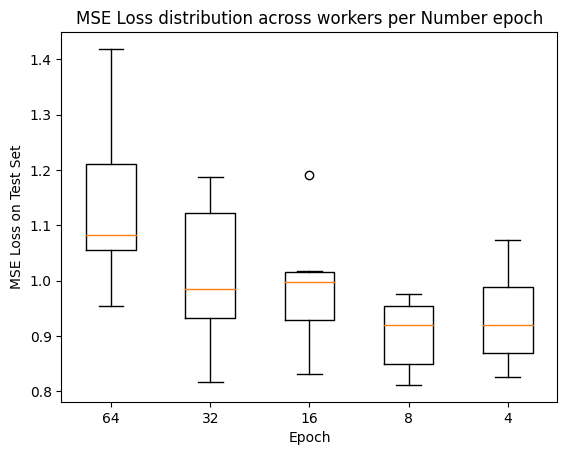

In [16]:
# Visualise MSE loss distribution for num epoch
a = [0.9542302357836339,
1.0790568654646324,
1.0846047156726768,
1.0485436893203883,
1.2524271844660195,
1.418862690707351]

b = [0.8169209431345353,
0.9306518723994452,
0.9375866851595007,
1.1525658807212205,
1.0332871012482663,
1.1872399445214978]

c = [0.9084604715672677,
0.8307905686546463,
1.0055478502080444,
0.9902912621359223,
1.0180305131761442,
1.19001386962552]

d = [0.826629680998613,
0.9167822468793343,
0.9209431345353676,
0.811373092926491,
0.9653259361997226,
0.9750346740638003]

e = [0.8252427184466019,
0.8626907073509015,
0.8918169209431346,
1.001386962552011,
0.9472954230235784,
1.073509015256588]

xticks = [64, 32, 16, 8, 4]
plt.boxplot([a, b, c, d, e])
plt.xticks(ticks=range(1, len(xticks)+1), labels=xticks)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss on Test Set')
plt.title('MSE Loss distribution across workers per Number epoch')